<a href="https://colab.research.google.com/github/thesukiyang/CryptoTrade/blob/main/time_series_momentum_2022_07_01_~_2023_01_20.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
from pylab import rcParams
import matplotlib.pyplot as plt
from pandas.io import sql as sqlio
import sys
import glob
import os
import statsmodels.api as sm
import statsmodels.formula.api as smf
import psycopg2
from functools import reduce
import itertools
import random
import pytz

import gzip
import seaborn as sns
import requests
import pickle
import time
import itertools
import scipy
from scipy.stats import norm

import os.path as op
# from ysera.portfolio_metrics import(calculate_sharpe)

from datetime import timedelta
import datetime
from scipy import stats
import matplotlib.dates as mdates

In [ ]:
# mount google drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
# add to path
repo_dir = '/content/drive/My Drive/Quant Research/CryptoCurrency/Strategy/Stats Arb/Amber/Data/prod_data_kline_20220814'
sys.path.append(repo_dir)

##
# add to path
lib_dir = '/content/drive/My Drive/Quant Research/CryptoCurrency/Strategy/Strategy/Stats Arb/Amber/Code'
sys.path.append(lib_dir)
##
data_repo = '/content/drive/My Drive/GrandTech/DataDepot/data_repo/'

Mounted at /content/drive


# Utility functions

In [ ]:
exchange_mapping = {
    'OKEX_FUTURE': 'okef',
    'OKEX': 'okex',
    'BINANCE':'binance',
    'BINANCE_SWAP_USDT':'binancef',
    'HUOBI_FUTURE': 'huobif',
}

horizon_mapping = {'INDEX': 'i',
                   'CW': 't',
                   'NW': 'n',
                   'CQ': 'q',
                   'PS': 'td'}

# data loading helper
def save_obj(obj, name):
    with open(''+ name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name):
    with open('' + name + '.pkl', 'rb') as f:
        return pickle.load(f)

def log_ret(df):
  '''
  Calculate the log return
  '''
  return np.log(df).diff(1)
#   return df.diff(1)/df.shift(1)  # (B-A)/A


def status_output(df):
  '''
  output order status ratio
  '''
  return (df.groupby('status')['status'].count() / len(df)).map(lambda x: "{0:.3f}%".format(x * 100))

def query_dev_db(sql):
  conn = psycopg2.connect(database='bigboat_dev',
                          user='cherry',
                          password='peach',
                          host='postgres-toothless-dev-instance.ca3tjki2fsjc.us-west-1.rds.amazonaws.com',
                          port='5432')
  df = sqlio.read_sql_query(sql, conn)
  conn.close()
  return df

def query_snapshot_db(sql):
  conn = psycopg2.connect(database='bigboat',
                          user='cherry',
                          password='peach',
                          host='postgres-bigboat-proddata2-tokyo.cf70estofbbl.ap-northeast-1.rds.amazonaws.com',
                          port='5432')
  df = sqlio.read_sql_query(sql, conn)
  conn.close()
  return df


def calc_unit_notional(df):
  df['unit_notional'] = df['asset'].map(lambda x: 100 if x == 'BTC' else 10)
  
# mapping to time to expiry

def get_weekly_expire_ts(ts, weekday=4, hour=8, minute=0):
    def before_time_of_day(ts):
        return ts < ts.replace(hour=hour, minute=minute, second=0, microsecond=0)
    ##
    week_end_ts = ts + datetime.timedelta(days=(weekday - ts.weekday()))
    week_end_ts = week_end_ts.replace(hour=hour, minute=minute, second=0, microsecond=0)
    if ts.weekday() < weekday or (ts.weekday() == weekday and before_time_of_day(ts)):
        return week_end_ts
    else:
        return week_end_ts + datetime.timedelta(days=7)

def get_biweekly_expire_ts(ts, weekday=4, hour=8, minute=0):
    return get_weekly_expire_ts(ts, weekday=weekday, hour=hour, minute=minute) + datetime.timedelta(days=7)

def get_quarterly_expire_ts(ts, weekday=4, hour=8, minute=0):
    ts = get_biweekly_expire_ts(ts, weekday=weekday, hour=hour, minute=minute) + datetime.timedelta(days=7)
    ts_n = ts
    while ts.month % 3 != 0 or ts_n.month == ts.month:
        ts = ts_n
        ts_n += datetime.timedelta(days=7)
    return ts

In [ ]:
# import datetime
def calculate_rolling_drawdown(cumm_pnl: pd.Series, lookback=30):
    '''
    Drawdown Helper: return rolling drawdown in 30 periods (default)
    Keyword arguments:
    cumm_pnl -- pd.Series
    '''    
    return cumm_pnl - cumm_pnl.rolling(lookback, min_periods=1).max()


# Sharpe ratio of the strategy, r_0 risk free rate
def calculate_sharpe_ratio(period_pnl: pd.Series, r_0, scale=252*24): 
    '''
    Sharpe Ratio Helper

    Keyword arguments:
    period_pnl -- pd.Series
    '''
    annualized_returns = scale * period_pnl.mean()
    annualized_vol = np.sqrt(scale) * period_pnl.std()
    if annualized_vol == 0:
        return np.nan
    else:
        return np.mean(annualized_returns - r_0) / annualized_vol


def calculate_rolling_sharpe_ratio(period_pnl: pd.Series, rolling_window, scale=365*24, r_0=0.0): 
    '''
    Sharpe Ratio Helper

    Keyword arguments:
    period_pnl -- pd.Series
    '''
    annualized_returns = scale * period_pnl.ewm(halflife=30, min_periods=60).mean()
    annualized_vol = np.sqrt(scale) * period_pnl.ewm(halflife=30, min_periods=60).std()
    return np.mean(annualized_returns - r_0) / annualized_vol


def calculate_turnover(period_weight:pd.DataFrame, lookback=30):
    '''
    Turnover Helper: return rolling two_sided turnover in 30 periods (default)
    Keyword arguments:
    period_weight -- pd.DataFrame
    '''
    return period_weight.diff().abs().rolling(lookback).sum().sum(axis=1)

def calculate_total_turnover(period_weight:pd.DataFrame):
    '''
    Turnover Helper: return total two_sided turnover
    Keyword arguments:
    period_weight -- pd.DataFrame
    '''
    return period_weight.diff().abs().sum().sum()


# Averaging holding period
def calculate_per_dollor_return(period_pnl: pd.Series, period_weight:pd.DataFrame):
    '''
    Per Dollar Return Helper
    Keyword arguments:
    period_pnl -- pd.Series
    period_weight -- pd.DataFrame 
    '''
    cumm_pnl = period_pnl.cumsum()
    if period_weight.diff().abs().sum().sum() !=0:
        return cumm_pnl.iloc[-1]/period_weight.diff().abs().sum().sum()
    else:
        return cumm_pnl.iloc[-1]


def calculate_expanding_drawdown(period_pnl: pd.Series):
    '''
    Drawdown Helper: return expending drawdown
    Keyword arguments:
    period_pnl -- pd.Series
    '''
    cumm_pnl = period_pnl.cumsum()
    return cumm_pnl -cumm_pnl.cummax()

def calculate_maximum_drawdown(period_pnl: pd.Series):
    '''
    Maximum Drawdown Helper: return maximum drawdown
    Keyword arguments:
    period_pnl -- pd.Series
    '''
    cumm_pnl = period_pnl.cumsum()
    temp_pnl = cumm_pnl.cummax() - cumm_pnl
    end = temp_pnl.idxmax() # end of maximum drawdown
    if end == 0:
        return 0
    else:
        start = cumm_pnl[:end].idxmax()  # start of maximum drawdown
        return cumm_pnl[start] - cumm_pnl[end]


# rolling holding period
def calculate_holding_period(period_weight:pd.DataFrame, lookback=30):
    '''
    Turnover Helper: return rolling implied holding period in 30 periods (default)
    Keyword arguments:
    period_weight -- pd.DataFrame
    '''
    if period_weight.diff().abs().rolling(lookback, min_periods=1).sum().sum(axis=1) !=0:
        return lookback/period_weight.diff().abs().rolling(lookback, min_periods=1).sum().sum()
    else:
        return lookback


# Sharpe ratio of the strategy, r_0 risk free rate
def sharpe_ratio(strat_returns, r_0, scale=365*24): 
    '''
    Sharpe Ratio Helper

    Keyword arguments:
    strat_returns -- np.array
    '''
    annualized_returns = scale * strat_returns.mean()
    annualized_vol = np.sqrt(scale) * strat_returns.std()
    if annualized_vol == 0:
        return 0
    else:
        return np.mean(annualized_returns - r_0) / annualized_vol

# Informaton ratio
def information_ratio(strat_returns, index_returns): 
    '''
    Information Ratio Helper
    '''
    return np.mean(strat_returns - index_returns) / np.std(strat_returns - index_returns)

# Portfolio turnover
def turn_over(strat_position):
    '''
    Turnover Helper
    '''
    return np.sum(np.abs(np.diff(strat_position)))
    # return df_returns.diff().abs().sum()


# Averaging holding period
def avg_holding_period(strat_position):
    '''
    Holding Period Helper

    Keyword arguments:
    strat_position -- np.array 
    '''
    # return df_position.abs().sum()/np.round(0.5*df_position.abs().diff(1).fillna(1).abs().sum())
    if np.abs(np.nan_to_num(np.diff(np.abs(strat_position)),nan = 1)).sum() == 0:
        return 0
    else:
        return np.abs(strat_position).sum()/np.abs(np.nan_to_num(np.diff(np.abs(strat_position)),nan = 1)).sum()


# Strategy maximum drawdown
def maximum_drawdown(strat_returns): 
    '''
    Maximum Drawdown Helper
    '''
    if np.all((strat_returns==0)):
        return 0.0
    else:
        equity_temp = 1+np.cumsum(strat_returns)
        end = np.argmax(np.maximum.accumulate(equity_temp) - equity_temp) # end of maximum drawdown
        start = np.argmax(equity_temp[:end])  # start of maximum drawdown
        return equity_temp[start] - equity_temp[end]

In [ ]:
def calculate_EMA(data, time_span, min_periods):
  """
  Keyword arguments:
  data -- pd.Series 
  span -- int
  """
  EMA_series = data.ewm(span=time_span, min_periods = min_periods, adjust = True).mean()
#   EMA_series = data.ewm(span=time_span-1, adjust = False).mean()
  return EMA_series


def calculate_SNR(data, rolling_window):
    """
    Keyword arguments:
    data -- pd.Series 
    """
    if len(data) < rolling_window:
        return np.nan
    else:
        sum_difference = data.diff(1).abs().rolling(rolling_window).sum()
        interval_difference = data - data.shift(rolling_window)
        SNR_value = interval_difference/sum_difference

    return SNR_value


def calculate_SNR_ewm(data, rolling_window):
    """
    Keyword arguments:
    data -- pd.Series 
    """
    if len(data) < rolling_window:
        return np.nan
    else:
        sum_difference = data.diff(1).abs().ewm(span = rolling_window).mean()
        interval_difference = data.diff(1).ewm(span = rolling_window).mean()
        # interval_difference = data - data.shift(rolling_window)
        SNR_value = interval_difference/sum_difference

    return SNR_value

COUNT = 0
def calculate_SNR_array(data):
    """
    Keyword arguments:
    data -- np array 
    """
    global  COUNT
    sum_difference = np.sum(np.absolute(np.diff(data)))
    interval_difference = data[-1] - data[0]

    if sum_difference == 0:
        # print('zero in denorminator')
        COUNT +=1
        return np.nan
    else:
        SNR_value = interval_difference/sum_difference
        return SNR_value

In [ ]:
# two help function for EMA check
def is_monotonic_increase(L):
    return all(x <= y for x, y in zip(L, L[1:]))

def is_monotonic_decrease(L):
    return all(x >= y for x, y in zip(L, L[1:]))  

In [ ]:
def build_stochatic_RSI(df, window=14, is_smooth=True, smooth_window=30):
    '''
    Build Stochastic RSI
    '''
    RSI = build_RSI(df, window=window)
    RSI_min = RSI.rolling(window=window).min()
    RSI_max = RSI.rolling(window=window).max()

    Stocha_RSI = (RSI - RSI_min) / (RSI_max - RSI_min)
    
    if is_smooth:
        Stocha_RSI = Stocha_RSI.ewm(span=smooth_window).mean()

    return Stocha_RSI

def build_RSI(df, window=14):
    '''
    Build RSI
    '''
    delta = df.diff()
    dUp, dDown = delta.copy(), abs(delta.copy())
    dUp[delta < 0] = 0
    dDown[delta > 0] = 0
    
    RS_up = dUp.ewm(span=window).mean()
    RS_down = dDown.ewm(span=window).mean()

    # delta = df.ewm(span = window).mean().diff()
    # dUp, dDown = delta.copy(), abs(delta.copy())
    # dUp[delta < 0] = 0
    # dDown[delta > 0] = 0
    # RS_up = dUp
    # RS_down = dDown

    RSI = 100 - 100 / (1 + RS_up / RS_down)
    return RSI


def build_ATR(df, smooth_window = 1):
    '''
    Build ATR
    '''
    s1 = df['high'] - df['low']
    s2 = abs(df['high'] - df['close'].shift(1))
    s3 = abs(df['low'] - df['close'].shift(1))
    TR =  pd.concat([s1, s2, s3], axis=1).max(axis=1)
    ATR = TR.ewm(span = smooth_window).mean()
    return ATR

In [ ]:
def break_out_strategy_single_currency_org(df_data,df_atr=0,df_atr_filter=0,time_span_list=[10,20,30,50],volume_span_list=[10,20,30,50],
                                        frequency_1 ='1H',frequency_2 = '4H',snr_cutoff = 0.6,t_cost = 0.0005, return_shift=2,t_cost_flag=True,
                                        phase_shift = 0,snr_stop_flag = True,smoothing_snr_flag = False,market_index_flag = False,  
                                        rolling_window = 7,stop_loss_flag = False,stop_loss_limit = None, 
                                        price_range_filter_flag = False,filter_look_back_window = 200, filter_look_back_window_long_term = 1000,
                                        price_range_lower_limit = 0.0, price_range_upper_limit_quantile = 0.5,
                                        price_range_lower_limit_quantile = 0.0, price_range_upper_limit=0.0356,                                 
                                        snr_scaler = 1,stop_loss_decision_lag = 0,stop_loss_implementation_lag = 0,
                                        price_range_filter_continuous_flag = False, stop_loss_frequency = '15T', stop_loss_continuous_flag = False,
                                        return_shift_1min = 2,return_shift_by_1min_flag = False,volume_breakout_flag = False, price_range_span=10,
                                        stop_loss_span = 1,dynamic_price_range_limit_flag= False,cross_volume_breakout_flag=False,
                                        exchange='HUOBI_FUTURE',directional_price_range_filter_flag=False, hedge_frequency = '5T',hedge_profit_flag=False,
                                        hedge_volume_breakout_flag = False, hedge_stop_loss_limit = -0.002,hedge_time_span_list = [10,20,30],
                                        take_profit_limit = 0.1,hedge_stop_loss_flag=False,snr_take_profit_flag = False, fast_snr_rolling_window_scaler = 0.5,
                                        snr_take_profit_frequency = '1H', rsi_take_profit_flag = False, rsi_window = 100, rsi_smooth_flag = False,
                                        rsi_smooth_window = 10, rsi_upper_limit = 0.9, rsi_lower_limit = 0.1,rsi_smooth_scaler = 1.0,
                                        price_spread_lower_limit = 0.0, price_spread_upper_limit = 0.02, price_spread_limit_flag = False,
                                        atr_take_profit_flag = False, atr_smooth_window = 30,atr_coef=3, atr_take_profit_limit = 0.1,
                                        rsi_half_flag = False, atr_half_flag = False, rsi_and_atr_take_profit_flag = False,
                                        trail_stop_flag = False, winning_trail_stop_flag= False, lossing_trail_stop_flag = False,trail_stop_limit = -0.02,
                                        winning_profit_limit = 0.01,trail_stop_span=1,atr_filter_smooth_window=200,atr_range_lower_limit=0.0,
                                        atr_filter_flag=False,atr_range_upper_limit=0.01,currency='BTC',currency_volume_breakout_flag=False,
                                        currency_volume_span_list = [10,20,30],discrete_volume_breakout_flag=False
                                        ):
    """
    Keyword arguments:
    df_data -- pd.Series  
    """
    # pice data
    price = df_data.sort_index()[f'close_{currency}'].shift(phase_shift).resample(frequency_1,label = 'right').last().fillna(method='ffill')
    price_1min = df_data.sort_index()['market_index'].shift(phase_shift).resample('1T',label = 'right').last().fillna(method='ffill')
    # volume data
    volume_huobi = df_data.sort_index()['volume_huobi'].shift(phase_shift).resample(frequency_1,label = 'right').sum().fillna(method='ffill')
    volume_okex = df_data.sort_index()['volume_huobi'].shift(phase_shift).resample(frequency_1,label = 'right').sum().fillna(method='ffill')
    currency_volume = df_data.sort_index()[f'volume_{currency}'].shift(phase_shift).resample(frequency_1,label = 'right').sum().fillna(method='ffill')
    

    ## EMA
    df = pd.concat([calculate_EMA(price.sort_index(), time_span = span, min_periods=span) for span in time_span_list],axis=1)
    EMA_cols = ['EMA_' + str(span) for span in time_span_list]
    df.columns = EMA_cols

    ## SNR - outer
    df_SNR_temp = calculate_SNR(price.resample(frequency_2, label = 'right').last().sort_index(),rolling_window = rolling_window)
    df['SNR'] = df_SNR_temp.resample(frequency_1).fillna(method = 'ffill')
    frequency = int(pd.to_timedelta(frequency_2)/pd.to_timedelta(frequency_1))
    df['SNR_smoothing'] = calculate_SNR_ewm(price.ewm(span=frequency).mean(),rolling_window=rolling_window*frequency).fillna(method = 'ffill')

    ## RSI - outer
    df_RSI_temp = build_stochatic_RSI(price.ewm(span=int(rsi_smooth_scaler*frequency)).mean(),window=rsi_window,is_smooth=rsi_smooth_flag,\
                                      smooth_window=rsi_smooth_window)    
    
    ## price
    df['price'] = price  

    ## macro view
    if not df.empty:
        df_res = pd.DataFrame()
        df_res['price'] = df['price']
        df_res['is_monotonic_increasing'] = df[EMA_cols].apply(lambda x: x.is_monotonic, axis=1)
        df_res['is_monotonic_decreasing'] = df[EMA_cols].apply(lambda x: (-x).is_monotonic, axis=1)

        ## RSI
        df_res['RSI'] = df_RSI_temp.resample(frequency_1,label = 'right').last().sort_index()
      
        ## SNR
        if smoothing_snr_flag:
            df_res['SNR'] = df['SNR_smoothing']
        else:
            df_res['SNR'] = df['SNR']

        # df_res['SNR'] = df_res['SNR']*np.sqrt(snr_scaler)

        ## macro view from EMA
        df_res['macro_view_EMA'] = np.where(df_res['is_monotonic_increasing'], -1, np.where(df_res['is_monotonic_decreasing'], 1, None))
        df_res['macro_view_EMA'] = df_res['macro_view_EMA'].fillna(method = 'ffill')
       
        # init positions as ema
        df_res['position'] = df_res['macro_view_EMA']

        ## ema flip check
        df_res['is_ema_order_flipped'] = df_res['macro_view_EMA'].where(df_res['macro_view_EMA'].isna(),
            other = df_res['macro_view_EMA'] != df_res['macro_view_EMA'].shift()).fillna(value = False)

        ## volume breakout indicator
        if volume_breakout_flag:
            ## volume EMA - huobi
            df_volume_huobi = pd.concat([calculate_EMA(volume_huobi.sort_index(), time_span = span, min_periods=span) for span in volume_span_list],axis=1)
            Volume_EMA_cols = ['Volume_EMA_' + str(span) for span in volume_span_list]
            df_volume_huobi.columns = Volume_EMA_cols

            ema_mat = df_volume_huobi.values
            short_indicator = [is_monotonic_increase(row) for row in ema_mat]
            long_indicator = [is_monotonic_decrease(row) for row in ema_mat]
            df_res['volume_breakout_indicator_huobi'] = np.where(short_indicator, 0.0, np.where(long_indicator, 1.0, None))
            df_res['volume_breakout_indicator_huobi'] = df_res['volume_breakout_indicator_huobi'].fillna(method = 'ffill').fillna(0.0)
            df_res['volume_breakout_change_indicator_huobi'] = df_res['volume_breakout_indicator_huobi'].where(df_res['is_ema_order_flipped'], None)
            df_res['volume_breakout_change_indicator_huobi'] = df_res['volume_breakout_change_indicator_huobi'].fillna(method = 'ffill').fillna(0.0)

            ## volume EMA - okex
            df_volume_okex = pd.concat([calculate_EMA(volume_okex.sort_index(), time_span = span, min_periods=span) for span in volume_span_list],axis=1)
            Volume_EMA_cols = ['Volume_EMA_' + str(span) for span in volume_span_list]
            df_volume_okex.columns = Volume_EMA_cols

            ema_mat = df_volume_okex.values
            short_indicator = [is_monotonic_increase(row) for row in ema_mat]
            long_indicator = [is_monotonic_decrease(row) for row in ema_mat]
            df_res['volume_breakout_indicator_okex'] = np.where(short_indicator, 0.0, np.where(long_indicator, 1.0, None))
            df_res['volume_breakout_indicator_okex'] = df_res['volume_breakout_indicator_okex'].fillna(method = 'ffill').fillna(0.0)

            df_res['volume_breakout_change_indicator_okex'] = df_res['volume_breakout_indicator_okex'].where(df_res['is_ema_order_flipped'], None)
            df_res['volume_breakout_change_indicator_okex'] = df_res['volume_breakout_change_indicator_okex'].fillna(method = 'ffill').fillna(0.0)

            ## update position
            if cross_volume_breakout_flag:
                df_res['volume_breakout_change_indicator'] = np.where((df_res['volume_breakout_change_indicator_huobi']==1)|\
                                                                      (df_res['volume_breakout_change_indicator_okex']==1), 1.0, 0.0)                
                df_res['position'] = df_res['position'].where(df_res['volume_breakout_change_indicator'] == 1.0, 0.0)
            elif exchange == 'HUOBI_FUTURE':
                df_res['position'] = df_res['position'].where(df_res['volume_breakout_change_indicator_huobi'] == 1.0, 0.0)
            elif exchange == 'OKEX_FUTURE':
                df_res['position'] = df_res['position'].where(df_res['volume_breakout_change_indicator_okex'] == 1.0, 0.0)

        if currency_volume_breakout_flag: 
            ## currency volume EMA
            df_volume_currency = pd.concat([calculate_EMA(currency_volume.sort_index(), time_span = span, min_periods=span) \
                                            for span in currency_volume_span_list],axis=1)
            Volume_EMA_cols = ['Volume_EMA_' + str(span) for span in currency_volume_span_list]
            df_volume_currency.columns = Volume_EMA_cols
            
            ema_mat = df_volume_currency.values
            short_indicator = [is_monotonic_increase(row) for row in ema_mat]
            long_indicator = [is_monotonic_decrease(row) for row in ema_mat]
            if discrete_volume_breakout_flag:
                df_res['volume_breakout_indicator_currency'] = np.where(long_indicator, 1.0, 0.0)
            else:
                df_res['volume_breakout_indicator_currency'] = np.where(short_indicator, 0.0, np.where(long_indicator, 1.0, None))
                df_res['volume_breakout_indicator_currency'] = df_res['volume_breakout_indicator_currency'].fillna(method = 'ffill').fillna(0.0)
            df_res['volume_breakout_change_indicator_currency'] = df_res['volume_breakout_indicator_currency'].where(df_res['is_ema_order_flipped'], None)
            df_res['volume_breakout_change_indicator_currency'] = df_res['volume_breakout_change_indicator_currency'].fillna(method = 'ffill').fillna(0.0)

            ## update position
            df_res['position'] = df_res['position'].where(df_res['volume_breakout_change_indicator_currency'] == 1.0, 0.0)
        
        ## snr: stop strategy
        if snr_stop_flag:
            df_res['snr_level_indicator'] = 0.0
            df_res['snr_level_indicator'] = df_res['snr_level_indicator'].mask(df_res['SNR'] > snr_cutoff, 1.0)
            df_res['snr_level_indicator'] = df_res['snr_level_indicator'].mask(df_res['SNR'] < -snr_cutoff, -1.0) 
            df_res['snr_crossing_indicator'] = np.nan
            df_res['snr_crossing_indicator'] = df_res['snr_crossing_indicator'].mask(df_res['macro_view_EMA']
                                                                                        * df_res['snr_level_indicator'].diff() < 0.0, 1.0)
            # reset snr crossing indicator when ema order flipped
            df_res['snr_crossing_indicator'] = df_res['snr_crossing_indicator'].mask(df_res['is_ema_order_flipped'], 0.0)
            # forward fill indicator
            df_res['snr_crossing_indicator'] = df_res['snr_crossing_indicator'].fillna(method='ffill').fillna(0.0)

            # turn off when snr_crossing_indicator is active
            df_res['position'] = df_res['position'].mask(df_res['snr_crossing_indicator'] == 1.0, 0.0)

        ## atr: open position filter
        if atr_filter_flag:
            tr = df_atr_filter.sort_index()[f'market_index_tr_{currency}'].shift(phase_shift).resample(frequency_1,label = 'right').last().fillna(method='ffill')
            ## ATR
            df_res['ATR_filter'] = tr.ewm(span=atr_filter_smooth_window).mean()
            df_res['atr_filter_level_indicator'] = 0.0
            df_res['atr_filter_level_indicator'] = df_res['atr_filter_level_indicator']\
            .mask((df_res['ATR_filter']>=atr_range_lower_limit)&(df_res['ATR_filter']<=atr_range_upper_limit), 1)
            ## 
            df_res['atr_filter_crossing_indicator'] = np.nan
            df_res['atr_filter_crossing_indicator'] = df_res['atr_filter_level_indicator'].where(df_res['is_ema_order_flipped'], np.nan)
            # forward fill indicator
            df_res['atr_filter_crossing_indicator'] = df_res['atr_filter_crossing_indicator'].fillna(method='ffill').fillna(0.0)

            # turn off when atr_filter_crossing_indicator is active
            df_res['position'] = df_res['position'].mask(df_res['atr_filter_crossing_indicator'] == 1.0, 0.0)

        ## rsi: take profit
        if rsi_take_profit_flag:
            df_res['rsi_level_indicator'] = 0.0
            df_res['rsi_level_indicator'] = df_res['rsi_level_indicator'].mask(df_res['RSI'] > rsi_upper_limit, 1.0)
            df_res['rsi_level_indicator'] = df_res['rsi_level_indicator'].mask(df_res['RSI'] < rsi_lower_limit, -1.0) 
            df_res['rsi_crossing_indicator'] = np.nan
            df_res['rsi_crossing_indicator'] = df_res['rsi_crossing_indicator'].mask(df_res['macro_view_EMA']
                                                                                        * df_res['rsi_level_indicator'].diff() < 0.0, 1.0)
            
            df_res['rsi_crossing_indicator'] = df_res['rsi_crossing_indicator'].where(df_res['snr_level_indicator']
                                                                                      *df_res['rsi_level_indicator'].diff() < 0.0,np.nan)
            
            df_res['rsi_crossing_indicator'] = df_res['rsi_crossing_indicator'].mask(df_res['is_ema_order_flipped'], 0.0)
            # forward fill indicator
            df_res['rsi_crossing_indicator'] = df_res['rsi_crossing_indicator'].fillna(method='ffill').fillna(0.0)

            # turn off when snr_crossing_indicator is active
            if rsi_half_flag:
                df_res['position'] = df_res['position'].mask(df_res['rsi_crossing_indicator'] == 1.0, 0.5*df_res['position'])
            else:
                df_res['position'] = df_res['position'].mask(df_res['rsi_crossing_indicator'] == 1.0, 0.0)

        ## atr: take profit
        if atr_take_profit_flag:
            tr = df_atr.sort_index()[f'market_index_tr_{currency}'].shift(phase_shift).resample(frequency_1,label = 'right').last().fillna(method='ffill')
            ## ATR
            df_res['ATR'] = tr.ewm(span=atr_smooth_window).mean()
            df_res['price_rolling_high'] = df_res['price'].rolling(atr_smooth_window).max()
            df_res['atr_limit'] = df_res['price_rolling_high'] - atr_coef*df_res['ATR']
            df_res['atr_level_indicator'] = 0.0
            df_res['atr_level_indicator'] = df_res['atr_level_indicator'].mask(df_res['atr_limit'] < df_res['price'], 1.0)
            df_res['atr_level_indicator'] = df_res['atr_level_indicator'].mask(df_res['atr_limit'] > df_res['price'], -1.0) 
            df_res['atr_crossing_indicator'] = np.nan
            df_res['atr_crossing_indicator'] = df_res['atr_crossing_indicator'].mask(df_res['macro_view_EMA']
                                                                                    * df_res['atr_level_indicator'].diff() < 0.0, 1.0)
            
            df_res['atr_crossing_indicator'] = df_res['atr_crossing_indicator'].where(df_res['snr_level_indicator']*df_res['atr_level_indicator'].diff() < 0.0,np.nan)
            df_res['atr_crossing_indicator'] = df_res['atr_crossing_indicator'].mask(df_res['is_ema_order_flipped'], 0.0)
            # forward fill indicator
            df_res['atr_crossing_indicator'] = df_res['atr_crossing_indicator'].fillna(method='ffill').fillna(0.0)

            # turn off when snr_crossing_indicator is active
            if atr_half_flag:
                df_res['position'] = df_res['position'].mask(df_res['atr_crossing_indicator'] == 1.0, 0.5*df_res['position'])
            else:
                df_res['position'] = df_res['position'].mask(df_res['atr_crossing_indicator'] == 1.0, 0.0)


        ## atr & rsi: take profit
        if rsi_and_atr_take_profit_flag:
            tr = df_atr.sort_index()[f'market_index_tr_{currency}'].shift(phase_shift).resample(frequency_1,label = 'right').last().fillna(method='ffill')
            ## ATR
            df_res['ATR'] = tr.ewm(span=atr_smooth_window).mean()
            df_res['price_rolling_high'] = df_res['price'].rolling(atr_smooth_window).max()
            df_res['atr_limit'] = df_res['price_rolling_high'] - atr_coef*df_res['ATR']
            df_res['atr_level_indicator'] = 0.0
            df_res['atr_level_indicator'] = df_res['atr_level_indicator'].mask(df_res['atr_limit'] < df_res['price'], 1.0)
            df_res['atr_level_indicator'] = df_res['atr_level_indicator'].mask(df_res['atr_limit'] > df_res['price'], -1.0) 
            df_res['atr_crossing_indicator'] = np.nan
            df_res['atr_crossing_indicator'] = df_res['atr_crossing_indicator'].mask(df_res['macro_view_EMA']
                                                                                    * df_res['atr_level_indicator'].diff() < 0.0, 1.0)
            
            df_res['atr_crossing_indicator'] = df_res['atr_crossing_indicator'].where(df_res['snr_level_indicator']*df_res['atr_level_indicator'].diff() < 0.0,np.nan)
            df_res['atr_crossing_indicator'] = df_res['atr_crossing_indicator'].mask(df_res['is_ema_order_flipped'], 0.0)
            # forward fill indicator
            df_res['atr_crossing_indicator'] = df_res['atr_crossing_indicator'].fillna(method='ffill').fillna(0.0)

            df_res['rsi_level_indicator'] = 0.0
            df_res['rsi_level_indicator'] = df_res['rsi_level_indicator'].mask(df_res['RSI'] > rsi_upper_limit, 1.0)
            df_res['rsi_level_indicator'] = df_res['rsi_level_indicator'].mask(df_res['RSI'] < rsi_lower_limit, -1.0) 
            df_res['rsi_crossing_indicator'] = np.nan
            df_res['rsi_crossing_indicator'] = df_res['rsi_crossing_indicator'].mask(df_res['macro_view_EMA']
                                                                                        * df_res['rsi_level_indicator'].diff() < 0.0, 1.0)
            
            df_res['rsi_crossing_indicator'] = df_res['rsi_crossing_indicator'].where(df_res['snr_level_indicator']
                                                                                      *df_res['rsi_level_indicator'].diff() < 0.0,np.nan)
            
            df_res['rsi_crossing_indicator'] = df_res['rsi_crossing_indicator'].mask(df_res['is_ema_order_flipped'], 0.0)
            # forward fill indicator
            df_res['rsi_crossing_indicator'] = df_res['rsi_crossing_indicator'].fillna(method='ffill').fillna(0.0)

            # turn off when snr_crossing_indicator is active
            df_res['position'] = df_res['position'].mask((df_res['atr_crossing_indicator']==1) & (df_res['rsi_crossing_indicator'] == 1.0), 0.0)

        ## snr: take profit
        if snr_take_profit_flag:
            ## SNR - take profit
            price_snr = df_data.sort_index()['market_index'].shift(phase_shift).resample(snr_take_profit_frequency,label = 'right').last().fillna(method='ffill')
            df_temp = calculate_SNR_ewm(price_snr.ewm(span=frequency).mean(),rolling_window=int(fast_snr_rolling_window_scaler*rolling_window*frequency)).fillna(method = 'ffill')
            df_res['SNR_take_profit'] = df_temp.resample(frequency_1,label = 'right').last().sort_index()
            df_res['fast_snr_level_indicator'] = 0.0
            df_res['fast_snr_level_indicator'] = df_res['fast_snr_level_indicator'].mask(df_res['SNR_take_profit'] > snr_cutoff, 1.0)
            df_res['fast_snr_level_indicator'] = df_res['fast_snr_level_indicator'].mask(df_res['SNR_take_profit'] < -snr_cutoff, -1.0) 
            df_res['fast_snr_crossing_indicator'] = np.nan
            df_res['fast_snr_crossing_indicator'] = df_res['fast_snr_crossing_indicator'].mask(df_res['macro_view_EMA']
                                                                                        * df_res['fast_snr_level_indicator'].diff() < 0.0, 1.0)
            df_res['fast_snr_crossing_indicator'] = df_res['fast_snr_crossing_indicator'].where(df_res['snr_level_indicator']
                                                                                                *df_res['fast_snr_level_indicator'].diff() < 0.0,np.nan)
            # reset snr crossing indicator when ema order flipped
            df_res['fast_snr_crossing_indicator'] = df_res['fast_snr_crossing_indicator'].mask(df_res['is_ema_order_flipped'], 0.0)
            # forward fill indicator
            df_res['fast_snr_crossing_indicator'] = df_res['fast_snr_crossing_indicator'].fillna(method='ffill').fillna(0.0)

            # take profit when snr_crossing_indicator is active
            df_res['position'] = df_res['position'].mask(df_res['fast_snr_crossing_indicator'] == 1.0, 0.0)

        ## price range filter
        if price_range_filter_flag:
            if market_index_flag:
                ## long term
                df_res['price_max_rolling'] = df_res['price'].ewm(span = price_range_span).mean().rolling(filter_look_back_window).max()
                df_res['price_min_rolling'] = df_res['price'].ewm(span = price_range_span).mean().rolling(filter_look_back_window).min()
                df_res['price_range_rolling'] = df_res['price_max_rolling'] - df_res['price_min_rolling']
            else:
                ## long term
                df_res['price_max_rolling'] = np.log(df_res['price']).ewm(span = price_range_span).mean().rolling(filter_look_back_window).max()
                df_res['price_min_rolling'] = np.log(df_res['price']).ewm(span = price_range_span).mean().rolling(filter_look_back_window).min()
                df_res['price_range_rolling'] = df_res['price_max_rolling'] - df_res['price_min_rolling']
            
            df_res['price_range_level_indicator'] = 0.0
            df_res['price_range_level_indicator'] = df_res['price_range_level_indicator']\
            .mask((df_res['price_range_rolling']>=price_range_lower_limit)&\
                                            (df_res['price_range_rolling']<=price_range_upper_limit),other = 1)
            
            df_res['price_range_change_indicator']  = np.nan
            df_res['price_range_change_indicator']  = df_res['price_range_level_indicator'].where(df_res['is_ema_order_flipped'], np.nan)

            ##
            if dynamic_price_range_limit_flag:
                price_range_lower_limit = df_res['price_range_rolling'].rolling(filter_look_back_window_long_term)\
                .quantile(price_range_lower_limit_quantile)
                
                price_range_upper_limit = df_res['price_range_rolling'].rolling(filter_look_back_window_long_term)\
                .quantile(price_range_upper_limit_quantile)
                df_res['price_range_level_indicator'] = 0.0
                df_res['price_range_level_indicator'] = df_res['price_range_level_indicator']\
                .mask((df_res['price_range_rolling']>=price_range_lower_limit)&\
                                                (df_res['price_range_rolling']<=price_range_upper_limit),other = 1)
                
                df_res['price_range_change_indicator']  = np.nan
                df_res['price_range_change_indicator']  = np.where((df_res['is_ema_order_flipped'])&(df_res['price_range_level_indicator'] == 0.0),0,\
                                                                  np.where((df_res['is_ema_order_flipped'])&(df_res['price_range_level_indicator'] == 1),\
                                                                            1,np.nan))
            
            ## continuous to use price range filter
            if price_range_filter_continuous_flag:
                df_res['price_range_change_indicator'] = df_res['price_range_change_indicator'].mask(df_res['price_range_level_indicator'].diff() == 1, 1)
           
            ##           
            df_res['price_range_change_indicator'] = df_res['price_range_change_indicator'].fillna(method = 'ffill').fillna(0.0)
            ## update position
            df_res['position'] = df_res['position'].where(df_res['price_range_change_indicator'] == 1.0, 0.0)
            
        ## directional price range filter
        if directional_price_range_filter_flag: 
            if market_index_flag:
                ## long term
                df_res['price_max_index'] = df_res['price'].ewm(span = price_range_span).mean().rolling(filter_look_back_window).apply(lambda x: np.argmax(x))
                df_res['price_min_index'] = df_res['price'].ewm(span = price_range_span).mean().rolling(filter_look_back_window).apply(lambda x: np.argmin(x))
                df_res['price_range_direction_indicator'] = np.where(df_res['price_max_index'] > df_res['price_min_index'],1.0,-1.0) # 1 -> long position
            else:
                ## long term
                df_res['price_max_index'] = np.log(df_res['price']).rolling(filter_look_back_window).apply(lambda x: pd.Series(x).idxmax())
                df_res['price_min_index'] = np.log(df_res['price']).rolling(filter_look_back_window).apply(lambda x: pd.Series(x).idxmin())
                df_res['price_range_direction_indicator'] = np.where(df_res['price_max_index'] > df_res['price_min_index'],1.0,-1.0) # 1 -> long position

            df_res['price_range_direction_change_indicator']  = np.nan
            df_res['price_range_direction_change_indicator']  = df_res['price_range_direction_indicator'].where(df_res['is_ema_order_flipped'],None)
            df_res['price_range_direction_change_indicator'] = df_res['price_range_direction_change_indicator'].fillna(method = 'ffill').fillna(0.0)
            # update position
            df_res['position'] = df_res['position'].where((df_res['price_range_direction_change_indicator'] == df_res['macro_view_EMA']), 0.0)

        ## price_spread_limit flag
        if price_spread_limit_flag: 
            df_res['price_spread_indicator']  = (df_res['price_spread'] > price_spread_lower_limit)&(df_res['price_spread'] < price_spread_upper_limit)
            df_res['price_spread_change_indicator']  = df_res['price_spread_indicator'].where(df_res['is_ema_order_flipped'],None)
            df_res['price_spread_change_indicator'] = df_res['price_spread_change_indicator'].fillna(method = 'ffill').fillna(0.0)
            ## update position
            df_res['position'] = df_res['position'].where(df_res['price_spread_change_indicator'] == 1.0, 0.0)


        ## hedge profit
        if hedge_profit_flag:
            df_res_temp = break_out_strategy_hedge_signal(df_data = df_data,time_span_list = hedge_time_span_list,
                                                          frequency_1 = hedge_frequency,market_index_flag = market_index_flag,
                                                          stop_loss_flag = hedge_stop_loss_flag,                       
                                                          stop_loss_limit = hedge_stop_loss_limit,
                                                          stop_loss_span=1,volume_breakout_flag = hedge_volume_breakout_flag,
                                                          exchange=exchange
                                                          ) 

            if not df_res_temp.empty:
                df_res['hedge_position'] = df_res_temp.resample(frequency_1, label = 'right').last().fillna(method='ffill')

                if market_index_flag:
                    df_res['return_origin'] = df_res['price'].ewm(span=stop_loss_span).mean().diff(1)*df_res['macro_view_EMA']
                else:
                    df_res['return_origin'] = log_ret(df_res['price'].ewm(span=stop_loss_span).mean())*df_res['macro_view_EMA']

                df_res['return_group'] = df_res.index.where(df_res['is_ema_order_flipped'], other = None)
                df_res['return_group'] = df_res['return_group'].fillna(method = 'ffill')
                # print('return_group nan: ', df_res['return_group'].isna().sum())
                if df_res['return_group'].isna().sum()>0:
                    df_res['return_group'] = df_res['return_group'].fillna(value = df_res[df_res['return_group'].isna()].index.values[0])

                ## cumulative return for each trade
                df_res['cumulative_return_per_trade'] = df_res.groupby('return_group')['return_origin'].apply(lambda x: x.cumsum())
                ## stop loss indicator
                df_res['take_profit_indicator'] = 0.0
                df_res['take_profit_indicator'] = df_res['take_profit_indicator'].mask(df_res['cumulative_return_per_trade']>=take_profit_limit, 1.0)
                # df_res['take_profit_indicator'] = df_res['take_profit_indicator'].fillna(method = 'ffill').fillna(0.0)

                ## 
                df_res['hedge_indicator'] = (df_res['macro_view_EMA'] == -df_res['hedge_position']) * df_res['take_profit_indicator']
                df_res['hedge_indicator'] = np.where(df_res['hedge_indicator'].diff()==1,1,None)
                df_res['hedge_indicator'] = df_res['hedge_indicator'].mask(df_res['is_ema_order_flipped'], 0.0)
                df_res['hedge_indicator'] = df_res['hedge_indicator'].fillna(method = 'ffill').fillna(0.0)

                ## update position
                df_res['position'] = df_res['position'].mask(df_res['hedge_indicator']==1,0.0)
            else:
                df_res['position'] = df_res['position']

        ## stop loss
        if stop_loss_flag:
            if stop_loss_continuous_flag:

                df_stop_loss = pd.DataFrame()
                ##
                df_stop_loss['price'] = df_data.sort_index()['market_index'].shift(phase_shift).resample(stop_loss_frequency,label = 'right').last()\
                .fillna(method='ffill').ewm(span=stop_loss_span).mean()

                df_stop_loss['macro_view_EMA'] = df_res['macro_view_EMA'].sort_index().resample(stop_loss_frequency, label = 'right').fillna(method='ffill')
                
                df_stop_loss['is_ema_order_flipped'] = df_res['is_ema_order_flipped'].sort_index().resample(stop_loss_frequency,label='right')\
                .fillna(method='ffill').fillna(value = False)
                
                df_stop_loss['position'] = df_res['position'].sort_index().resample(stop_loss_frequency, label = 'right').fillna(method='ffill')
                
            
                ## return
                if market_index_flag:
                    df_stop_loss['return_origin'] = df_stop_loss['price'].diff(1).shift(-1)*df_stop_loss['macro_view_EMA']
                else:
                    df_stop_loss['return_origin'] = log_ret(df_stop_loss['price']).shift(-1)*df_stop_loss['macro_view_EMA']
                
                ## return group
                df_res['return_group'] = df_res.index.where(df_res['is_ema_order_flipped'], other = None)
                df_res['return_group'] = df_res['return_group'].fillna(method = 'ffill')
                df_stop_loss['return_group'] = df_res['return_group'].resample(stop_loss_frequency).fillna(method = 'ffill')
                if df_stop_loss['return_group'].isna().sum()>0:
                    df_stop_loss['return_group'] = df_stop_loss['return_group'].fillna(value=df_stop_loss[df_stop_loss['return_group'].isna()].index.values[0])
                
                ## cumulative return for each trade
                df_stop_loss['cumulative_return_per_trade'] = df_stop_loss.groupby('return_group')['return_origin'].apply(lambda x: \
                                                                                                            x.shift(-stop_loss_decision_lag)\
                                                                                                            .shift(stop_loss_decision_lag).cumsum())
                ## stop loss indicator
                df_stop_loss['stop_loss_indicator'] = np.nan
                df_stop_loss['stop_loss_indicator'] = df_stop_loss['stop_loss_indicator'].where((df_stop_loss['cumulative_return_per_trade'].isna()) | \
                                                                                    (df_stop_loss['cumulative_return_per_trade']>=stop_loss_limit), other = 1)
                df_stop_loss['stop_loss_indicator'] = df_stop_loss['stop_loss_indicator'].shift(1)
                df_stop_loss['stop_loss_indicator'] = df_stop_loss['stop_loss_indicator'].mask(
                    df_stop_loss['is_ema_order_flipped'].notna()&df_stop_loss['is_ema_order_flipped'], other = 0)
                df_stop_loss['stop_loss_indicator'] = df_stop_loss['stop_loss_indicator'].fillna(method = 'ffill').fillna(0.0)

                ## update position
                df_stop_loss['position'] = df_stop_loss['position'].mask(df_stop_loss['stop_loss_indicator'] == 1.0, 0.0)
                # print(df_stop_loss.tail(10))

            else:
                if market_index_flag:
                    df_res['return_origin'] = df_res['price'].ewm(span=stop_loss_span).mean().diff(1).shift(-1)*df_res['macro_view_EMA']
                else:
                    df_res['return_origin'] = log_ret(df_res['price'].ewm(span=stop_loss_span).mean()).shift(-1)*df_res['macro_view_EMA']

                df_res['return_group'] = df_res.index.where(df_res['is_ema_order_flipped'], other = None)
                df_res['return_group'] = df_res['return_group'].fillna(method = 'ffill')
                # print('return_group nan: ', df_res['return_group'].isna().sum())
                if df_res['return_group'].isna().sum()>0:
                    df_res['return_group'] = df_res['return_group'].fillna(value = df_res[df_res['return_group'].isna()].index.values[0])

                ## cumulative return for each trade
                df_res['cumulative_return_per_trade'] = df_res.groupby('return_group')['return_origin'].apply(lambda x: \
                                                                                                            x.shift(-stop_loss_decision_lag)\
                                                                                                            .shift(stop_loss_decision_lag).cumsum())
                # df_res['cumulative_return_per_trade_origin'] = df_res.groupby('return_group')['return_origin'].cumsum()
                ## stop loss indicator
                df_res['stop_loss_indicator'] = np.nan
                df_res['stop_loss_indicator'] = df_res['stop_loss_indicator'].where((df_res['cumulative_return_per_trade'].isna()) | \
                                                                                    (df_res['cumulative_return_per_trade']>=stop_loss_limit), other = 1)
                df_res['stop_loss_indicator'] = df_res['stop_loss_indicator'].shift(1)
                df_res['stop_loss_indicator'] = df_res['stop_loss_indicator'].mask(df_res['is_ema_order_flipped'], other = 0)
                df_res['stop_loss_indicator'] = df_res['stop_loss_indicator'].fillna(method = 'ffill').fillna(0.0)

                df_res['position'] = df_res['position'].mask(df_res['stop_loss_indicator'] == 1.0, 0.0)

        ## trail stop loss
        if trail_stop_flag:
            # df_stop_loss = pd.DataFrame()
            df_stop_loss = df_res.sort_index().resample(stop_loss_frequency, label = 'right').fillna(method='ffill')
            ##
            df_stop_loss['price'] = df_data.sort_index()['market_index'].shift(phase_shift).resample(stop_loss_frequency,label = 'right').last()\
            .fillna(method='ffill').ewm(span=stop_loss_span).mean()

            df_stop_loss['macro_view_EMA'] = df_res['macro_view_EMA'].sort_index().resample(stop_loss_frequency, label = 'right').fillna(method='ffill')
            
            df_stop_loss['is_ema_order_flipped'] = df_res['is_ema_order_flipped'].sort_index().resample(stop_loss_frequency,label='right')\
            .fillna(method='ffill').fillna(value = False)
            
            df_stop_loss['position'] = df_res['position'].sort_index().resample(stop_loss_frequency, label = 'right').fillna(method='ffill')

            ## return
            if market_index_flag:
                df_stop_loss['return_origin'] = df_stop_loss['price'].diff(1).shift(-1)*df_stop_loss['macro_view_EMA']
            else:
                df_stop_loss['return_origin'] = log_ret(df_stop_loss['price']).shift(-1)*df_stop_loss['macro_view_EMA']

            ## stop loss indicator
            df_stop_loss['return_rolling'] = df_stop_loss['return_origin'].rolling(trail_stop_span).sum()
            df_stop_loss['trail_stop_loss_indicator'] = np.nan
            df_stop_loss['trail_stop_loss_indicator'] = df_stop_loss['trail_stop_loss_indicator'].where(df_stop_loss['return_rolling']>=trail_stop_limit,1.0)
            ##
            df_stop_loss['trail_stop_loss_indicator_copy'] = df_stop_loss['trail_stop_loss_indicator']
            df_stop_loss['trail_stop_loss_indicator'] = df_stop_loss['trail_stop_loss_indicator'].shift(1)
            df_stop_loss['trail_stop_loss_indicator'] = df_stop_loss['trail_stop_loss_indicator'].mask(df_stop_loss['is_ema_order_flipped']==1.0, 0.0)
            df_stop_loss['trail_stop_loss_indicator_copy_v2'] = df_stop_loss['trail_stop_loss_indicator']
            df_stop_loss['trail_stop_loss_indicator'] = df_stop_loss['trail_stop_loss_indicator'].fillna(method = 'ffill').fillna(0.0)
            ## update position
            df_stop_loss['position'] = df_stop_loss['position'].mask(df_stop_loss['trail_stop_loss_indicator'] == 1.0, 0.0)
            
            ## update return series
            if market_index_flag:
                df_stop_loss['return_before_t_cost'] = df_stop_loss['price'].diff(1)*df_stop_loss['position'].shift(return_shift)
            else:
                df_stop_loss['return_before_t_cost'] = log_ret(df_stop_loss['price'])*df_stop_loss['position'].shift(return_shift)
            ## t-cost
            if t_cost_flag:
                df_stop_loss['t_cost'] = t_cost*df_stop_loss['position'].shift(return_shift).diff(1).abs()
                df_stop_loss['return'] = df_stop_loss['return_before_t_cost'] - df_stop_loss['t_cost']
            else:
                df_stop_loss['return'] = df_stop_loss['return_before_t_cost']
            return df_stop_loss, df
        
        ## winning trail stop loss
        if winning_trail_stop_flag:
            df_stop_loss = pd.DataFrame()
            ##
            df_stop_loss['price'] = df_data.sort_index()['market_index'].shift(phase_shift).resample(stop_loss_frequency,label = 'right').last()\
            .fillna(method='ffill').ewm(span=stop_loss_span).mean()

            df_stop_loss['macro_view_EMA'] = df_res['macro_view_EMA'].sort_index().resample(stop_loss_frequency, label = 'right').fillna(method='ffill')
            
            df_stop_loss['is_ema_order_flipped'] = df_res['is_ema_order_flipped'].sort_index().resample(stop_loss_frequency,label='right')\
            .fillna(method='ffill').fillna(value = False)
            
            df_stop_loss['position'] = df_res['position'].sort_index().resample(stop_loss_frequency, label = 'right').fillna(method='ffill')
                   
            ## return
            if market_index_flag:
                df_stop_loss['return_origin'] = df_stop_loss['price'].diff(1).shift(-1)*df_stop_loss['macro_view_EMA']
            else:
                df_stop_loss['return_origin'] = log_ret(df_stop_loss['price']).shift(-1)*df_stop_loss['macro_view_EMA']

            ## return group
            df_res['return_group'] = df_res.index.where(df_res['is_ema_order_flipped'], other = None)
            df_res['return_group'] = df_res['return_group'].fillna(method = 'ffill')
            df_stop_loss['return_group'] = df_res['return_group'].resample(stop_loss_frequency).fillna(method = 'ffill')
            if df_stop_loss['return_group'].isna().sum()>0:
                df_stop_loss['return_group'] = df_stop_loss['return_group'].fillna(value=df_stop_loss[df_stop_loss['return_group'].isna()].index.values[0])
            
            ## cumulative return for each trade
            df_stop_loss['cumulative_return_per_trade'] = df_stop_loss.groupby('return_group')['return_origin'].apply(lambda x: \
                                                                                                        x.shift(-stop_loss_decision_lag)\
                                                                                                        .shift(stop_loss_decision_lag).cumsum())
            ## stop loss indicator
            df_stop_loss['return_rolling'] = df_stop_loss['return_origin'].rolling(trail_stop_span).sum()
            df_stop_loss['winning_trail_stop_indicator'] = np.nan
            df_stop_loss['winning_trail_stop_indicator'] = df_stop_loss['winning_trail_stop_indicator'].mask((df_stop_loss['return_rolling']<trail_stop_limit) & \
                                                                                (df_stop_loss['cumulative_return_per_trade']>=winning_profit_limit),1.0)
            df_stop_loss['winning_trail_stop_indicator'] = df_stop_loss['winning_trail_stop_indicator'].shift(1)
            df_stop_loss['winning_trail_stop_indicator'] = df_stop_loss['winning_trail_stop_indicator'].mask(
                df_stop_loss['is_ema_order_flipped'].notna()&df_stop_loss['is_ema_order_flipped'], other = 0)
            df_stop_loss['winning_trail_stop_indicator'] = df_stop_loss['winning_trail_stop_indicator'].fillna(method = 'ffill').fillna(0.0)

            ## update position
            df_stop_loss['position'] = df_stop_loss['position'].mask(df_stop_loss['winning_trail_stop_indicator'] == 1.0, 0.0)

            ## update return series
            if market_index_flag:
                df_stop_loss['return_before_t_cost'] = df_stop_loss['price'].diff(1)*df_stop_loss['position'].shift(return_shift)
            else:
                df_stop_loss['return_before_t_cost'] = log_ret(df_stop_loss['price'])*df_stop_loss['position'].shift(return_shift)
            ## t-cost
            if t_cost_flag:
                df_stop_loss['t_cost'] = t_cost*df_stop_loss['position'].shift(return_shift).diff(1).abs()
                df_stop_loss['return'] = df_stop_loss['return_before_t_cost'] - df_stop_loss['t_cost']
            else:
                df_stop_loss['return'] = df_stop_loss['return_before_t_cost']
            
            return df_stop_loss, df

        ## lossing trail stop loss
        if lossing_trail_stop_flag:
            df_stop_loss = pd.DataFrame()
            ##
            df_stop_loss['price'] = df_data.sort_index()['market_index'].shift(phase_shift).resample(stop_loss_frequency,label = 'right').last()\
            .fillna(method='ffill').ewm(span=stop_loss_span).mean()

            df_stop_loss['macro_view_EMA'] = df_res['macro_view_EMA'].sort_index().resample(stop_loss_frequency, label = 'right').fillna(method='ffill')
            
            df_stop_loss['is_ema_order_flipped'] = df_res['is_ema_order_flipped'].sort_index().resample(stop_loss_frequency,label='right')\
            .fillna(method='ffill').fillna(value = False)
            
            df_stop_loss['position'] = df_res['position'].sort_index().resample(stop_loss_frequency, label = 'right').fillna(method='ffill')
                   
            ## return
            if market_index_flag:
                df_stop_loss['return_origin'] = df_stop_loss['price'].diff(1).shift(-1)*df_stop_loss['macro_view_EMA']
            else:
                df_stop_loss['return_origin'] = log_ret(df_stop_loss['price']).shift(-1)*df_stop_loss['macro_view_EMA']

            ## return group
            df_res['return_group'] = df_res.index.where(df_res['is_ema_order_flipped'], other = None)
            df_res['return_group'] = df_res['return_group'].fillna(method = 'ffill')
            df_stop_loss['return_group'] = df_res['return_group'].resample(stop_loss_frequency).fillna(method = 'ffill')
            if df_stop_loss['return_group'].isna().sum()>0:
                df_stop_loss['return_group'] = df_stop_loss['return_group'].fillna(value=df_stop_loss[df_stop_loss['return_group'].isna()].index.values[0])
            
            ## cumulative return for each trade
            df_stop_loss['cumulative_return_per_trade'] = df_stop_loss.groupby('return_group')['return_origin'].apply(lambda x: \
                                                                                                        x.shift(-stop_loss_decision_lag)\
                                                                                                        .shift(stop_loss_decision_lag).cumsum())
            ## stop loss indicator
            df_stop_loss['return_rolling'] = df_stop_loss['return_origin'].rolling(trail_stop_span).sum()
            df_stop_loss['lossing_trail_stop_indicator'] = np.nan
            df_stop_loss['lossing_trail_stop_indicator'] = df_stop_loss['lossing_trail_stop_indicator'].mask((df_stop_loss['return_rolling']<trail_stop_limit) & \
                                                                                (df_stop_loss['cumulative_return_per_trade']<0),1.0)
            df_stop_loss['lossing_trail_stop_indicator'] = df_stop_loss['lossing_trail_stop_indicator'].shift(1)
            df_stop_loss['lossing_trail_stop_indicator'] = df_stop_loss['lossing_trail_stop_indicator'].mask(
                df_stop_loss['is_ema_order_flipped'].notna()&df_stop_loss['is_ema_order_flipped'], other = 0)
            df_stop_loss['lossing_trail_stop_indicator'] = df_stop_loss['lossing_trail_stop_indicator'].fillna(method = 'ffill').fillna(0.0)

            ## update position
            df_stop_loss['position'] = df_stop_loss['position'].mask(df_stop_loss['lossing_trail_stop_indicator'] == 1.0, 0.0)

            ## update return series
            if market_index_flag:
                df_stop_loss['return_before_t_cost'] = df_stop_loss['price'].diff(1)*df_stop_loss['position'].shift(return_shift)
            else:
                df_stop_loss['return_before_t_cost'] = log_ret(df_stop_loss['price'])*df_stop_loss['position'].shift(return_shift)
            ## t-cost
            if t_cost_flag:
                df_stop_loss['t_cost'] = t_cost*df_stop_loss['position'].shift(return_shift).diff(1).abs()
                df_stop_loss['return'] = df_stop_loss['return_before_t_cost'] - df_stop_loss['t_cost']
            else:
                df_stop_loss['return'] = df_stop_loss['return_before_t_cost']
            
            return df_stop_loss, df
                   
        # ## updated strategy return
        if stop_loss_flag & stop_loss_continuous_flag:
            if market_index_flag:
                df_stop_loss['return_before_t_cost'] = df_stop_loss['price'].diff(1)*df_stop_loss['position'].shift(return_shift)
            else:
                df_stop_loss['return_before_t_cost'] = log_ret(df_stop_loss['price'])*df_stop_loss['position'].shift(return_shift)

            ## t-cost
            if t_cost_flag:
                df_stop_loss['t_cost'] = t_cost*df_stop_loss['position'].shift(return_shift).diff(1).abs()
                df_stop_loss['return'] = df_stop_loss['return_before_t_cost'] - df_stop_loss['t_cost']
            else:
                df_stop_loss['return'] = df_stop_loss['return_before_t_cost']

            return df_stop_loss, df

        ## 1 min return/t_cost
        if return_shift_by_1min_flag:
            df_res_1min = pd.DataFrame()
            df_res_1min['price'] = price_1min
            df_res_1min['position'] = df_res['position'].sort_index().resample('1T', label = 'right').fillna(method='ffill')
            
            ## update return
            if market_index_flag:
                df_res_1min['return_before_t_cost'] = df_res_1min['price'].diff(1)*df_res_1min['position'].shift(return_shift_1min)
            else:
                df_res_1min['return_before_t_cost'] = log_ret(df_res_1min['price'])*df_res_1min['position'].shift(return_shift_1min)

            ## update t-cost
            if t_cost_flag:
                df_res_1min['t_cost'] = t_cost*df_res_1min['position'].shift(return_shift_1min).diff(1).abs()
                df_res_1min['return'] = df_res_1min['return_before_t_cost'] - df_res_1min['t_cost']
            else:
                df_res_1min['return'] = df_res_1min['return_before_t_cost']

            return df_res_1min, df

        else:
            ## update return
            if market_index_flag:
                df_res['return_before_t_cost'] = df_res['price'].diff(1)*df_res['position'].shift(return_shift)
            else:
                df_res['return_before_t_cost'] = log_ret(df_res['price'])*df_res['position'].shift(return_shift)

            ## update t-cost
            if t_cost_flag:
                df_res['t_cost'] = t_cost*df_res['position'].shift(return_shift).diff(1).abs()
                df_res['return'] = df_res['return_before_t_cost'] - df_res['t_cost']
            else:
                df_res['return'] = df_res['return_before_t_cost']

            return df_res, df

    else:
        return np.nan, np.nan


In [ ]:
def break_out_strategy_single_currency(df_data,df_atr=0,df_atr_filter=0,time_span_list=[10,20,30,50],
                                        frequency_1 ='1H',frequency_2 = '4H',snr_cutoff = 0.6,t_cost = 0.0005, return_shift=2,t_cost_flag=True,
                                        snr_stop_flag = True,rolling_window = 7,stop_loss_flag = False,stop_loss_limit = None, 
                                        price_range_filter_flag = False,price_range_filter_look_back_window = 200,
                                        price_range_lower_limit = 0.0, price_range_upper_limit=0.0356,                                 
                                        stop_loss_decision_lag = 0,stop_loss_frequency = '15T', stop_loss_continuous_flag = False,
                                        exchange='HUOBI_FUTURE',
                                        rsi_take_profit_flag = False, rsi_window = 100, rsi_smooth_flag = False,
                                        rsi_smooth_window = 10, rsi_upper_limit = 0.9, rsi_lower_limit = 0.1,rsi_smooth_scaler = 1.0,
                                        atr_take_profit_flag = False, atr_smooth_window = 30,atr_coef=3, atr_take_profit_limit = 0.1,
                                        rsi_half_flag = False, atr_half_flag = False,atr_filter_smooth_window=200,atr_range_lower_limit=0.0,
                                        atr_filter_flag=False,atr_range_upper_limit=0.01,currency='BTC',currency_volume_breakout_flag=False,
                                        currency_volume_span_list = [10,20,30]
                                        ):
    """
    Keyword arguments:
    df_data -- pd.Series  
    """
    # pice data
    price = df_data.sort_index()[f'close_{currency}'].resample(frequency_1,label = 'right').last().fillna(method='ffill')
    # volume data
    currency_volume = df_data.sort_index()[f'volume_{currency}'].resample(frequency_1,label = 'right').sum().fillna(method='ffill')    

    ## EMA
    df = pd.concat([calculate_EMA(price.sort_index(), time_span = span, min_periods=span) for span in time_span_list],axis=1)
    EMA_cols = ['EMA_' + str(span) for span in time_span_list]
    df.columns = EMA_cols

    ## SNR - outer
    df_SNR_temp = calculate_SNR(price.resample(frequency_2, label = 'right').last().sort_index(),rolling_window = rolling_window)
    df['SNR'] = df_SNR_temp.resample(frequency_1).fillna(method = 'ffill')
    frequency = int(pd.to_timedelta(frequency_2)/pd.to_timedelta(frequency_1))
    df['SNR_smoothing'] = calculate_SNR_ewm(price.ewm(span=frequency).mean(),rolling_window=rolling_window*frequency).fillna(method = 'ffill')

    ## RSI - outer
    df_RSI_temp = build_stochatic_RSI(price.ewm(span=int(rsi_smooth_scaler*frequency)).mean(),window=rsi_window,is_smooth=rsi_smooth_flag,\
                                      smooth_window=rsi_smooth_window)      
    ## price
    df['price'] = price  

    ## strategy
    if not df.empty:
        df_res = pd.DataFrame()
        df_res['price'] = df['price']
        ## RSI
        df_res['RSI'] = df_RSI_temp.resample(frequency_1,label = 'right').last().sort_index()   
        ## SNR
        df_res['SNR'] = df['SNR_smoothing']

        ## macro view from EMA
        price_ema_mat = df[EMA_cols].values
        short_indicator = [is_monotonic_increase(row) for row in price_ema_mat]
        long_indicator = [is_monotonic_decrease(row) for row in price_ema_mat]
        df_res['macro_view_EMA'] = np.where(short_indicator, -1, np.where(long_indicator, 1, None))
        df_res['macro_view_EMA'] = df_res['macro_view_EMA'].fillna(method = 'ffill').fillna(0.0)

        # init positions as ema
        df_res['position'] = df_res['macro_view_EMA']

        ## ema flip check
        df_res['is_ema_order_flipped'] = df_res['macro_view_EMA'].where(df_res['macro_view_EMA'].isna(),
            other = df_res['macro_view_EMA'] != df_res['macro_view_EMA'].shift()).fillna(value = False)

        ##
        if currency_volume_breakout_flag: 
            ## currency volume EMA
            df_volume_currency = pd.concat([calculate_EMA(currency_volume.sort_index(), time_span = span, min_periods=span) \
                                            for span in currency_volume_span_list],axis=1)
            Volume_EMA_cols = ['Volume_EMA_' + str(span) for span in currency_volume_span_list]
            df_volume_currency.columns = Volume_EMA_cols
            
            ema_mat = df_volume_currency.values
            short_indicator = [is_monotonic_increase(row) for row in ema_mat]
            long_indicator = [is_monotonic_decrease(row) for row in ema_mat]
            df_res['volume_breakout_indicator_currency'] = np.where(short_indicator, 0.0, np.where(long_indicator, 1.0, None))
            df_res['volume_breakout_indicator_currency'] = df_res['volume_breakout_indicator_currency'].fillna(method = 'ffill').fillna(0.0)
            df_res['volume_breakout_change_indicator_currency'] = df_res['volume_breakout_indicator_currency'].where(df_res['is_ema_order_flipped'], None)
            df_res['volume_breakout_change_indicator_currency'] = df_res['volume_breakout_change_indicator_currency'].fillna(method = 'ffill').fillna(0.0)

            ## update position
            df_res['position'] = df_res['position'].where(df_res['volume_breakout_change_indicator_currency'] == 1.0, 0.0)

        ## snr: stop strategy
        if snr_stop_flag:
            df_res['snr_level_indicator'] = 0.0
            df_res['snr_level_indicator'] = df_res['snr_level_indicator'].mask(df_res['SNR'] > snr_cutoff, 1.0)
            df_res['snr_level_indicator'] = df_res['snr_level_indicator'].mask(df_res['SNR'] < -snr_cutoff, -1.0) 
            df_res['snr_crossing_indicator'] = np.nan
            df_res['snr_crossing_indicator'] = df_res['snr_crossing_indicator'].mask(df_res['macro_view_EMA']
                                                                                        * df_res['snr_level_indicator'].diff() < 0.0, 1.0)
            # reset snr crossing indicator when ema order flipped
            df_res['snr_crossing_indicator'] = df_res['snr_crossing_indicator'].mask(df_res['is_ema_order_flipped'], 0.0)
            # forward fill indicator
            df_res['snr_crossing_indicator'] = df_res['snr_crossing_indicator'].fillna(method='ffill').fillna(0.0)

            # turn off when snr_crossing_indicator is active
            df_res['position'] = df_res['position'].mask(df_res['snr_crossing_indicator'] == 1.0, 0.0)

        ## atr: open position filter
        if atr_filter_flag:
            tr = df_atr_filter.sort_index()[f'market_index_tr_{currency}'].resample(frequency_1,label = 'right').last().fillna(method='ffill')
            ## ATR
            df_res['ATR_filter'] = tr.ewm(span=atr_filter_smooth_window).mean()
            df_res['atr_filter_level_indicator'] = 0.0
            df_res['atr_filter_level_indicator'] = df_res['atr_filter_level_indicator']\
            .mask((df_res['ATR_filter']>=atr_range_lower_limit)&(df_res['ATR_filter']<=atr_range_upper_limit), 1)
            ## 
            df_res['atr_filter_crossing_indicator'] = np.nan
            df_res['atr_filter_crossing_indicator'] = df_res['atr_filter_level_indicator'].where(df_res['is_ema_order_flipped'], np.nan)
            # forward fill indicator
            df_res['atr_filter_crossing_indicator'] = df_res['atr_filter_crossing_indicator'].fillna(method='ffill').fillna(0.0)

            # turn off when atr_filter_crossing_indicator is active
            df_res['position'] = df_res['position'].mask(df_res['atr_filter_crossing_indicator'] == 1.0, 0.0)

        ## rsi: take profit
        if rsi_take_profit_flag:
            df_res['rsi_level_indicator'] = 0.0
            df_res['rsi_level_indicator'] = df_res['rsi_level_indicator'].mask(df_res['RSI'] > rsi_upper_limit, 1.0)
            df_res['rsi_level_indicator'] = df_res['rsi_level_indicator'].mask(df_res['RSI'] < rsi_lower_limit, -1.0) 
            df_res['rsi_crossing_indicator'] = np.nan
            df_res['rsi_crossing_indicator'] = df_res['rsi_crossing_indicator'].mask(df_res['macro_view_EMA']
                                                                                        * df_res['rsi_level_indicator'].diff() < 0.0, 1.0)
            
            df_res['rsi_crossing_indicator'] = df_res['rsi_crossing_indicator'].where(df_res['snr_level_indicator']
                                                                                      *df_res['rsi_level_indicator'].diff() < 0.0,np.nan)
            
            df_res['rsi_crossing_indicator'] = df_res['rsi_crossing_indicator'].mask(df_res['is_ema_order_flipped'], 0.0)
            # forward fill indicator
            df_res['rsi_crossing_indicator'] = df_res['rsi_crossing_indicator'].fillna(method='ffill').fillna(0.0)

            # turn off when snr_crossing_indicator is active
            if rsi_half_flag:
                df_res['position'] = df_res['position'].mask(df_res['rsi_crossing_indicator'] == 1.0, 0.5*df_res['position'])
            else:
                df_res['position'] = df_res['position'].mask(df_res['rsi_crossing_indicator'] == 1.0, 0.0)

        ## atr: take profit
        if atr_take_profit_flag:
            tr = df_atr.sort_index()[f'market_index_tr_{currency}'].resample(frequency_1,label = 'right').last().fillna(method='ffill')
            ## ATR
            df_res['ATR'] = tr.ewm(span=atr_smooth_window).mean()
            df_res['price_rolling_high'] = df_res['price'].rolling(atr_smooth_window).max()
            df_res['atr_limit'] = df_res['price_rolling_high'] - atr_coef*df_res['ATR']
            df_res['atr_level_indicator'] = 0.0
            df_res['atr_level_indicator'] = df_res['atr_level_indicator'].mask(df_res['atr_limit'] < df_res['price'], 1.0)
            df_res['atr_level_indicator'] = df_res['atr_level_indicator'].mask(df_res['atr_limit'] > df_res['price'], -1.0) 
            df_res['atr_crossing_indicator'] = np.nan
            df_res['atr_crossing_indicator'] = df_res['atr_crossing_indicator'].mask(df_res['macro_view_EMA']
                                                                                    * df_res['atr_level_indicator'].diff() < 0.0, 1.0)
            
            df_res['atr_crossing_indicator'] = df_res['atr_crossing_indicator'].where(df_res['snr_level_indicator']*df_res['atr_level_indicator'].diff() < 0.0,np.nan)
            df_res['atr_crossing_indicator'] = df_res['atr_crossing_indicator'].mask(df_res['is_ema_order_flipped'], 0.0)
            # forward fill indicator
            df_res['atr_crossing_indicator'] = df_res['atr_crossing_indicator'].fillna(method='ffill').fillna(0.0)

            # turn off when snr_crossing_indicator is active
            if atr_half_flag:
                df_res['position'] = df_res['position'].mask(df_res['atr_crossing_indicator'] == 1.0, 0.5*df_res['position'])
            else:
                df_res['position'] = df_res['position'].mask(df_res['atr_crossing_indicator'] == 1.0, 0.0)

        ## price range filter
        if price_range_filter_flag:
            ## 
            df_res['price_max_rolling'] = df_res['price'].rolling(price_range_filter_look_back_window).max()
            df_res['price_min_rolling'] = df_res['price'].rolling(price_range_filter_look_back_window).min()
            df_res['price_range_rolling'] = df_res['price_max_rolling'] - df_res['price_min_rolling']
            
            df_res['price_range_level_indicator'] = 0.0
            df_res['price_range_level_indicator'] = df_res['price_range_level_indicator']\
            .mask((df_res['price_range_rolling']>=price_range_lower_limit)&\
                                            (df_res['price_range_rolling']<=price_range_upper_limit),other = 1)
            
            df_res['price_range_change_indicator']  = np.nan
            df_res['price_range_change_indicator']  = df_res['price_range_level_indicator'].where(df_res['is_ema_order_flipped'], np.nan)
           
            ##           
            df_res['price_range_change_indicator'] = df_res['price_range_change_indicator'].fillna(method = 'ffill').fillna(0.0)
            ## update position
            df_res['position'] = df_res['position'].where(df_res['price_range_change_indicator'] == 1.0, 0.0)
    
        ## stop loss
        if stop_loss_flag:
            if stop_loss_continuous_flag:

                df_stop_loss = pd.DataFrame()
                ##
                df_stop_loss['price'] = df_data.sort_index()[f'close_{currency}'].resample(stop_loss_frequency,label = 'right').last()\
                .fillna(method='ffill')

                df_stop_loss['macro_view_EMA'] = df_res['macro_view_EMA'].sort_index().resample(stop_loss_frequency, label = 'right').fillna(method='ffill')
                
                df_stop_loss['is_ema_order_flipped'] = df_res['is_ema_order_flipped'].sort_index().resample(stop_loss_frequency,label='right')\
                .fillna(method='ffill').fillna(value = False)
                
                df_stop_loss['position'] = df_res['position'].sort_index().resample(stop_loss_frequency, label = 'right').fillna(method='ffill')
                            
                ## return
                df_stop_loss['return_origin'] = df_stop_loss['price'].diff(1).shift(-1)*df_stop_loss['macro_view_EMA']
                
                ## return group
                df_res['return_group'] = df_res.index.where(df_res['is_ema_order_flipped'], other = None)
                df_res['return_group'] = df_res['return_group'].fillna(method = 'ffill')
                df_stop_loss['return_group'] = df_res['return_group'].resample(stop_loss_frequency, label= 'right').fillna(method = 'ffill')
                if df_stop_loss['return_group'].isna().sum()>0:
                    df_stop_loss['return_group'] = df_stop_loss['return_group'].fillna(value=df_stop_loss[df_stop_loss['return_group'].isna()].index[0])
                
                ## cumulative return for each trade
                df_stop_loss['cumulative_return_per_trade'] = df_stop_loss.groupby('return_group')['return_origin'].apply(lambda x: \
                                                                                                            x.shift(-stop_loss_decision_lag)\
                                                                                                            .shift(stop_loss_decision_lag).cumsum())
                ## stop loss indicator
                df_stop_loss['stop_loss_indicator'] = np.nan
                df_stop_loss['stop_loss_indicator'] = df_stop_loss['stop_loss_indicator'].where((df_stop_loss['cumulative_return_per_trade'].isna()) | \
                                                                                    (df_stop_loss['cumulative_return_per_trade']>=stop_loss_limit), other = 1)
                df_stop_loss['stop_loss_indicator'] = df_stop_loss['stop_loss_indicator'].shift(1)
                df_stop_loss['stop_loss_indicator'] = df_stop_loss['stop_loss_indicator'].mask(
                    df_stop_loss['is_ema_order_flipped'].notna()&df_stop_loss['is_ema_order_flipped'], other = 0)
                df_stop_loss['stop_loss_indicator'] = df_stop_loss['stop_loss_indicator'].fillna(method = 'ffill').fillna(0.0)

                ## update position
                df_stop_loss['position'] = df_stop_loss['position'].mask(df_stop_loss['stop_loss_indicator'] == 1.0, 0.0)
                # print(df_stop_loss.tail(10))

            else:
                df_res['return_origin'] = df_res['price'].diff(1).shift(-1)*df_res['macro_view_EMA']
                df_res['return_group'] = df_res.index.where(df_res['is_ema_order_flipped'], other = None)
                df_res['return_group'] = df_res['return_group'].fillna(method = 'ffill')
                # print('return_group nan: ', df_res['return_group'].isna().sum())
                if df_res['return_group'].isna().sum()>0:
                    df_res['return_group'] = df_res['return_group'].fillna(value = df_res[df_res['return_group'].isna()].index[0])

                ## cumulative return for each trade
                df_res['cumulative_return_per_trade'] = df_res.groupby('return_group')['return_origin'].apply(lambda x: \
                                                                                                            x.shift(-stop_loss_decision_lag)\
                                                                                                            .shift(stop_loss_decision_lag).cumsum())
                ## stop loss indicator
                df_res['stop_loss_indicator'] = np.nan
                df_res['stop_loss_indicator'] = df_res['stop_loss_indicator'].where((df_res['cumulative_return_per_trade'].isna()) | \
                                                                                    (df_res['cumulative_return_per_trade']>=stop_loss_limit), other = 1)
                df_res['stop_loss_indicator'] = df_res['stop_loss_indicator'].shift(1)
                df_res['stop_loss_indicator'] = df_res['stop_loss_indicator'].mask(df_res['is_ema_order_flipped'], other = 0)
                df_res['stop_loss_indicator'] = df_res['stop_loss_indicator'].fillna(method = 'ffill').fillna(0.0)

                df_res['position'] = df_res['position'].mask(df_res['stop_loss_indicator'] == 1.0, 0.0)
                  
        ## updated strategy return
        if stop_loss_flag & stop_loss_continuous_flag:
            df_stop_loss['return_before_t_cost'] = df_stop_loss['price'].diff(1)*df_stop_loss['position'].shift(return_shift)

            ## t-cost
            if t_cost_flag:
                df_stop_loss['t_cost'] = t_cost*df_stop_loss['position'].shift(return_shift).diff(1).abs()
                df_stop_loss['return'] = df_stop_loss['return_before_t_cost'] - df_stop_loss['t_cost']
            else:
                df_stop_loss['return'] = df_stop_loss['return_before_t_cost']

            return df_stop_loss, df
        else:
            ## update return
            df_res['return_before_t_cost'] = df_res['price'].diff(1)*df_res['position'].shift(return_shift)
            ## update t-cost
            if t_cost_flag:
                df_res['t_cost'] = t_cost*df_res['position'].shift(return_shift).diff(1).abs()
                df_res['return'] = df_res['return_before_t_cost'] - df_res['t_cost']
            else:
                df_res['return'] = df_res['return_before_t_cost']

            return df_res, df
    else:
        return np.nan, np.nan


# Portfolio construction

In [ ]:
grouped_net_pnl = pd.DataFrame()
grouped_pos = pd.DataFrame()

start_date = '2022-07-01'
end_date = '2023-01-20'

## Time series momentum - Binance 

#### 5min

In [ ]:
currency_list = ['BTC', 'ETH', 'BCH', 'LTC', 'EOS', 'XRP']

df_market_index = pd.DataFrame()
df_market_index_volume = pd.DataFrame()
for currency in currency_list:
    filename_temp = op.join(repo_dir, 'df_spot_kline_binance') + '_' + start_date.replace('-','_') + '_to_' + end_date.replace('-','_') + '_' + currency
    if op.exists(filename_temp + '.pkl'): 
        df_temp = load_obj(filename_temp) 
        df_volume_temp = df_temp[['volume']].rename(columns = {'volume':'volume_' + currency})
        df_price_temp = df_temp[['close']].rename(columns = {'close':'close_' + currency})
        df_volume_temp[f'volume_{currency}'] = np.multiply(df_volume_temp.values,df_price_temp.values)
        df_market_index_volume = pd.concat([df_market_index_volume,df_volume_temp], axis=1)
        df_market_index = pd.concat([df_market_index,df_price_temp], axis=1)
        
df_market_index_volume = df_market_index_volume.fillna(0.0).ewm(span=5).mean()
## log(1+volume)
df_market_index_volume = np.log(1+df_market_index_volume)
df_market_index_volume['volume_huobi'] = df_market_index_volume.mean(axis=1)

## market index
df_market_index = df_market_index.fillna(axis=0, method = 'ffill').dropna()
df_market_index = np.log(df_market_index)
df_market_index['market_index'] = df_market_index.mean(axis=1)

##
# df_market_index['volume_okex'] = df_market_index_volume['volume_okex']
print(len(df_market_index))
##
df_market_index = pd.concat([df_market_index,df_market_index_volume],axis=1)
##
df_market_index = df_market_index.sort_index()
df_market_index.head()

292320


,close_BTC,close_ETH,close_BCH,close_LTC,close_EOS,close_XRP,market_index,volume_BTC,volume_ETH,volume_BCH,volume_LTC,volume_EOS,volume_XRP,volume_huobi
quote_time,,,,,,,,,,,,,,
2022-07-01 00:01:00,9.894396,6.971791,4.631812,3.981549,-0.080126,-1.106846,4.048763,16.041436,16.148219,9.890940,10.913400,8.913324,12.386064,12.382231
2022-07-01 00:02:00,9.895359,6.970157,4.628887,3.980429,-0.077962,-1.108663,4.048035,15.859364,15.827347,10.443814,10.790964,9.535083,12.281482,12.456343
2022-07-01 00:03:00,9.891413,6.964948,4.628887,3.981176,-0.080126,-1.107149,4.046525,15.607945,15.585239,10.236127,10.818406,9.614405,12.076756,12.323146
2022-07-01 00:04:00,9.890869,6.963833,4.629863,3.980803,-0.077962,-1.112610,4.045799,15.523429,15.362352,9.897789,10.792028,9.736761,12.675609,12.331328
2022-07-01 00:05:00,9.889402,6.961902,4.632785,3.980616,-0.080126,-1.114437,4.045024,15.473083,15.467909,9.857720,10.982550,9.722685,12.517975,12.336987


In [ ]:
currency_list = ['BTC', 'ETH', 'BCH', 'LTC', 'EOS', 'XRP']
freq = '3T'

## Price Range
df_ATR = pd.DataFrame()
df_market_index_high = pd.DataFrame()
df_market_index_low = pd.DataFrame()
df_market_index_close = pd.DataFrame()
for currency in currency_list:
    filename_temp = op.join(repo_dir, 'df_spot_kline_binance') + '_' + start_date.replace('-','_') + '_to_' + end_date.replace('-','_') + '_' + currency
    if op.exists(filename_temp + '.pkl'): 
        df_temp = load_obj(filename_temp) 
        ##
        df_price_high_temp = df_temp[['high']].resample(freq).max().rename(columns = {'high':'high_' + currency}).fillna(method='ffill')
        df_price_low_temp = df_temp[['low']].resample(freq).min().rename(columns = {'low':'low_' + currency}).fillna(method='ffill')
        df_price_close_temp = df_temp[['close']].resample(freq).last().rename(columns = {'close':'close_' + currency}).fillna(method='ffill')
        ## 
        df_ATR['high'] = np.log(df_price_high_temp[f'high_{currency}'].fillna(method='ffill'))
        df_ATR['low'] = np.log(df_price_low_temp.fillna(method='ffill'))
        df_ATR['close'] = np.log(df_price_close_temp.fillna(method='ffill'))
        df_ATR[f'market_index_tr_{currency}'] = build_ATR(df_ATR, smooth_window = 1)

df_ATR = df_ATR.drop(['high','low','close'],axis=1)
# df_ATR = df_ATR[pd.Timestamp('2019-04-01'):pd.Timestamp('2019-07-31')]
df_ATR.head(3)

,market_index_tr_BTC,market_index_tr_ETH,market_index_tr_BCH,market_index_tr_LTC,market_index_tr_EOS,market_index_tr_XRP
quote_time,,,,,,
2022-07-01 00:00:00,0.010681,0.008939,0.011673,0.009127,0.004329,0.007855
2022-07-01 00:03:00,0.009498,0.012899,0.003899,0.004479,0.005414,0.009105
2022-07-01 00:06:00,0.008410,0.009984,0.006806,0.009503,0.006501,0.005794


In [ ]:
currency_list = ['BTC', 'ETH', 'BCH', 'LTC', 'EOS', 'XRP']
freq = '5T'

## Price Range
df_ATR_filter = pd.DataFrame()
df_market_index_high = pd.DataFrame()
df_market_index_low = pd.DataFrame()
df_market_index_close = pd.DataFrame()
for currency in currency_list:
    filename_temp = op.join(repo_dir, 'df_spot_kline_binance') + '_' + start_date.replace('-','_') + '_to_' + end_date.replace('-','_') + '_' + currency
    if op.exists(filename_temp + '.pkl'): 
        df_temp = load_obj(filename_temp) 
        ##
        df_price_high_temp = df_temp[['high']].resample(freq).max().rename(columns = {'high':'high_' + currency}).fillna(method='ffill')
        df_price_low_temp = df_temp[['low']].resample(freq).min().rename(columns = {'low':'low_' + currency}).fillna(method='ffill')
        df_price_close_temp = df_temp[['close']].resample(freq).last().rename(columns = {'close':'close_' + currency}).fillna(method='ffill')

        df_ATR_filter['high'] = np.log(df_price_high_temp[f'high_{currency}'].fillna(method='ffill'))
        df_ATR_filter['low'] = np.log(df_price_low_temp.fillna(method='ffill'))
        df_ATR_filter['close'] = np.log(df_price_close_temp.fillna(method='ffill'))
        df_ATR_filter[f'market_index_tr_{currency}'] = build_ATR(df_ATR_filter, smooth_window = 1)

df_ATR_filter = df_ATR_filter.drop(['high','low','close'],axis=1)
# df_ATR_filter = df_ATR_filter[pd.Timestamp('2019-04-01'):pd.Timestamp('2019-07-31')]
df_ATR_filter.head(3)

,market_index_tr_BTC,market_index_tr_ETH,market_index_tr_BCH,market_index_tr_LTC,market_index_tr_EOS,market_index_tr_XRP
quote_time,,,,,,
2022-07-01 00:00:00,0.011621,0.014186,0.011673,0.009127,0.004329,0.011197
2022-07-01 00:05:00,0.008410,0.009984,0.006806,0.009503,0.006501,0.008243
2022-07-01 00:10:00,0.003868,0.005500,0.004852,0.022803,0.006480,0.005799


In [ ]:
df_market_index_in = df_market_index[pd.Timestamp('2020-01-01'):]
df_ATR_in = df_ATR[pd.Timestamp('2020-01-01'):]
df_ATR_filter_in = df_ATR_filter[pd.Timestamp('2020-01-01'):]

##### ETH

###### return series

<ipython-input-11-550c5ea8623a>:235: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df_res['cumulative_return_per_trade'] = df_res.groupby('return_group')['return_origin'].apply(lambda x: \
<ipython-input-18-5def54b4b65a>:113: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_performance_metrics = df_performance_metrics.append(df_performance_metrics_temp, ignore_index=True)


Running time in round 1 is: 1.130483865737915s


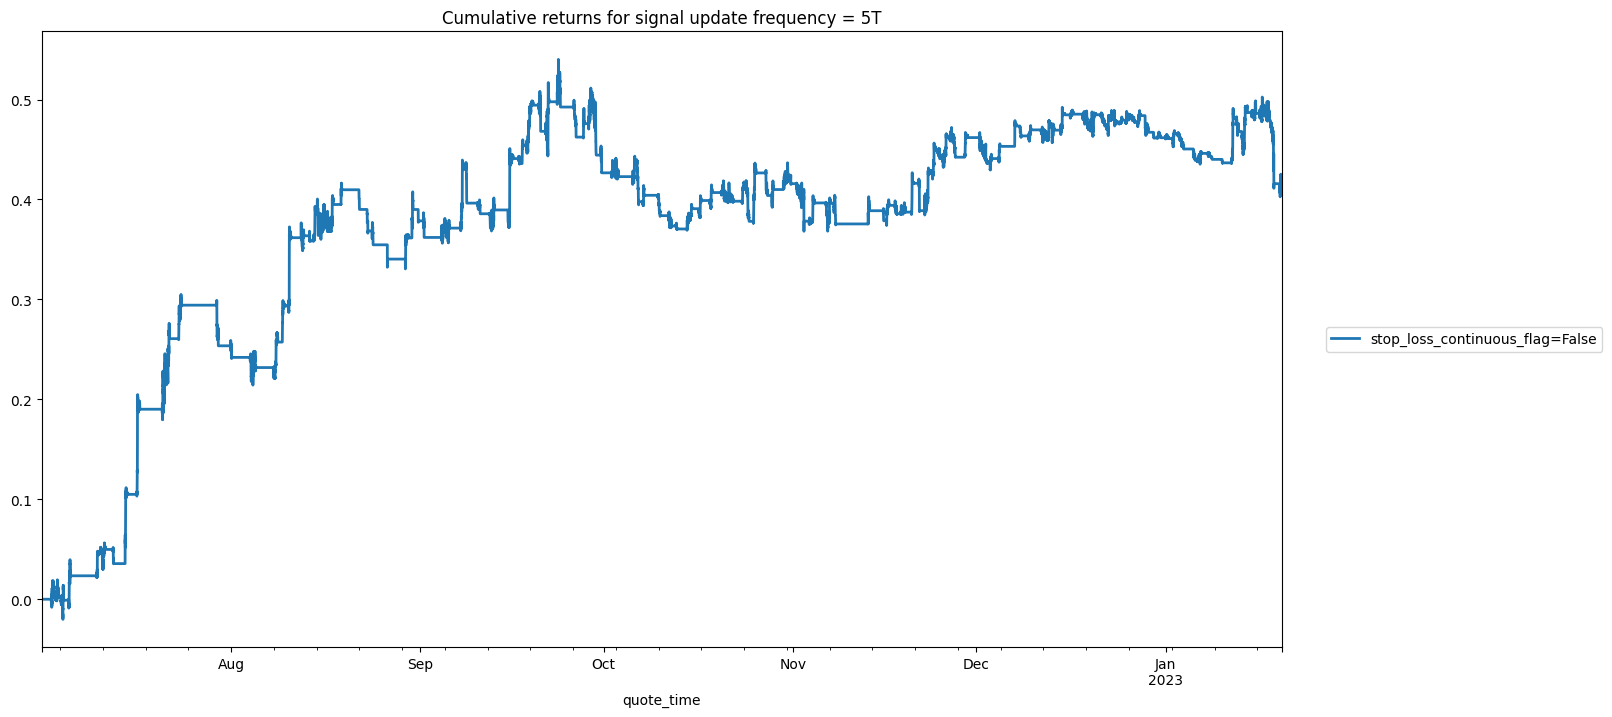

Running time in seconds:  1.5340962409973145


In [ ]:
# start_date = '2020-01-01'
# end_date = '2020-06-02'
start = time.time()

r_0 = 0.0
scale = 365*24*12
frequency_1 = '5T'
frequency_2 = '120T'
stop_loss_frequency = '1T'
exchange = 'HUOBI_FUTURE'

time_span_list = [10,20,30,50,100] 
rolling_window = 7
snr_cutoff = 0.6
t_cost = 0.0005
return_shift = 2

## indicator
snr_stop_flag = True
stop_loss_flag = True
stop_loss_continuous_flag_list = [False]
price_range_filter_flag = True


## indicator values
stop_loss_limit = -0.01
stop_loss_decision_lag = 0
price_range_filter_look_back_window = 200
price_range_lower_limit = 0.0
price_range_upper_limit = 0.065

#
rsi_take_profit_flag = True
rsi_half_flag = True
rsi_window = 100
rsi_smooth_flag = True
rsi_smooth_window = 10
rsi_upper_limit = 0.9
rsi_lower_limit = 0.1
rsi_smooth_scaler = 1/12

#
atr_take_profit_flag = True
atr_half_flag = True
atr_smooth_window = 22
atr_coef=3

#
atr_filter_flag = True
atr_filter_smooth_window = 200
atr_range_lower_limit = 0.004
atr_range_upper_limit = 0.005

#
currency='ETH'
currency_volume_breakout_flag=True
currency_volume_span_list = [10,20,30,50,100]

df_performance_metrics = pd.DataFrame()
##
count = 0
fig, ax = plt.subplots(figsize=(16,8))
for stop_loss_continuous_flag in stop_loss_continuous_flag_list:
    df_res, df = break_out_strategy_single_currency(df_data = df_market_index_in, df_atr = df_ATR_in,df_atr_filter=df_ATR_filter_in,
                                                     time_span_list = time_span_list,exchange=exchange,currency=currency,
                                                  frequency_2 = frequency_2, rolling_window = rolling_window, frequency_1 = frequency_1,                                      
                                                  snr_cutoff = snr_cutoff, t_cost = t_cost, return_shift = return_shift, snr_stop_flag = snr_stop_flag,
                                                  price_range_filter_flag = price_range_filter_flag,stop_loss_flag = stop_loss_flag,                      
                                                  price_range_lower_limit = price_range_lower_limit,price_range_upper_limit=price_range_upper_limit,     
                                                  stop_loss_limit = stop_loss_limit,stop_loss_decision_lag = stop_loss_decision_lag,
                                                  price_range_filter_look_back_window = price_range_filter_look_back_window,
                                                  rsi_window = rsi_window,rsi_take_profit_flag =rsi_take_profit_flag,rsi_smooth_flag=rsi_smooth_flag,
                                                  rsi_smooth_window = rsi_smooth_window,rsi_upper_limit=rsi_upper_limit,rsi_lower_limit=rsi_lower_limit,
                                                  atr_take_profit_flag = atr_take_profit_flag,atr_smooth_window=atr_smooth_window,atr_coef=atr_coef,
                                                  rsi_smooth_scaler=rsi_smooth_scaler,atr_half_flag=atr_half_flag,rsi_half_flag=rsi_half_flag,
                                                  atr_filter_flag=atr_filter_flag,atr_filter_smooth_window=atr_filter_smooth_window,
                                                  atr_range_upper_limit=atr_range_upper_limit,atr_range_lower_limit=atr_range_lower_limit,
                                                  currency_volume_breakout_flag=currency_volume_breakout_flag,stop_loss_frequency=stop_loss_frequency,
                                                  currency_volume_span_list=currency_volume_span_list,stop_loss_continuous_flag=stop_loss_continuous_flag
                                                  ) 

    ## plots
    # df_res = df_res[pd.Timestamp('2020-10-01'):]
    df_res['return'].cumsum().plot(ax = ax, lw = 2,label = f'stop_loss_continuous_flag={stop_loss_continuous_flag}')


    ## turnover
    turnover = df_res.position.diff().abs().sum()

    ## total return
    total_return = df_res['return'].sum()

    ## maximum drawdown
    max_drawdown = maximum_drawdown(df_res['return'].dropna().values)


    ## sharpe ratio
    shp_ratio = sharpe_ratio(df_res['return'].dropna().resample('D').sum().values, r_0=0, scale = 365)

    ## performance metrics
    total_return = df_res['return'].sum()
    df_performance_metrics_temp = pd.DataFrame({'sharpe_ratio': shp_ratio,
                                                'return_per_trade': 2*total_return/turnover,
                                                'protfolio turn_over': turnover,
                                                'total_return': total_return,
                                                'max_drawdown':max_drawdown,
                                                'stop_loss_limit':stop_loss_limit,
                                                'stop_loss_flag':stop_loss_flag,
                                                'stop_loss_continuous_flag':stop_loss_continuous_flag
                                                },
                                                index = [0])

    df_performance_metrics = df_performance_metrics.append(df_performance_metrics_temp, ignore_index=True)

    ##
    end = time.time()
    count +=1
    print('Running time in round {} is: {}s'.format(count, end - start))

## plot title and legend
ax.set_title('Cumulative returns for signal update frequency = {}'.format(frequency_1))
ax.legend(loc = 'center left', bbox_to_anchor=(1.03, 0.5))
plt.show()

# ## performance metrics
# pd.set_option('display.max_columns', 50)
# print(df_performance_metrics)

##
end = time.time()
print('Running time in seconds: ', end - start)

In [ ]:
df_performance_metrics

,sharpe_ratio,return_per_trade,protfolio turn_over,total_return,max_drawdown,stop_loss_limit,stop_loss_flag,stop_loss_continuous_flag
0,2.141839,0.001974,425.0,0.419405,0.171997,-0.01,True,False


In [ ]:
grouped_net_pnl['time_series_momentum_ETH_5min'] = df_res['return']
grouped_pos['time_series_momentum_ETH_5min'] = df_res['position']

In [ ]:
df_res['is_ema_order_flipped']

quote_time
2022-07-01 00:05:00     True
2022-07-01 00:10:00    False
2022-07-01 00:15:00    False
2022-07-01 00:20:00    False
2022-07-01 00:25:00    False
                       ...  
2023-01-19 23:45:00    False
2023-01-19 23:50:00    False
2023-01-19 23:55:00    False
2023-01-20 00:00:00    False
2023-01-20 00:05:00    False
Freq: 5T, Name: is_ema_order_flipped, Length: 58465, dtype: bool

<Axes: xlabel='quote_time'>

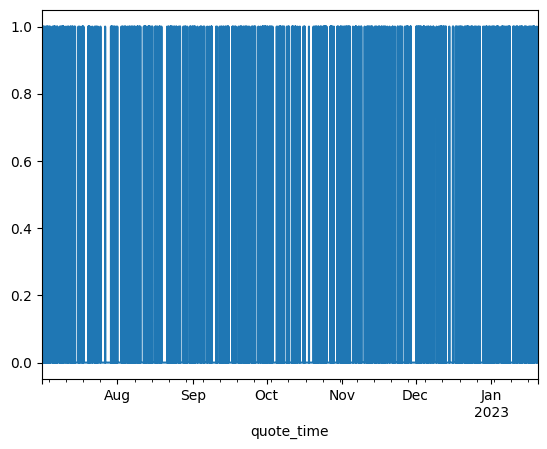

In [ ]:
(df_res['is_ema_order_flipped']*1.0).plot()

In [ ]:
df_res['is_ema_order_flipped'].isna().sum()

0

In [ ]:
df_res['macro_view_EMA']

quote_time
2022-07-01 00:05:00    0.0
2022-07-01 00:10:00    0.0
2022-07-01 00:15:00    0.0
2022-07-01 00:20:00    0.0
2022-07-01 00:25:00    0.0
                      ... 
2023-01-19 23:45:00    1.0
2023-01-19 23:50:00    1.0
2023-01-19 23:55:00    1.0
2023-01-20 00:00:00    1.0
2023-01-20 00:05:00    1.0
Freq: 5T, Name: macro_view_EMA, Length: 58465, dtype: float64

In [ ]:
df_res['macro_view_EMA']!=df_res['macro_view_EMA'].shift()

quote_time
2022-07-01 00:05:00     True
2022-07-01 00:10:00    False
2022-07-01 00:15:00    False
2022-07-01 00:20:00    False
2022-07-01 00:25:00    False
                       ...  
2023-01-19 23:45:00    False
2023-01-19 23:50:00    False
2023-01-19 23:55:00    False
2023-01-20 00:00:00    False
2023-01-20 00:05:00    False
Freq: 5T, Name: macro_view_EMA, Length: 58465, dtype: bool

In [ ]:
df_res.iloc[-1,:]

price                                                   7.346713
RSI                                                     0.370734
SNR                                                     0.440411
macro_view_EMA                                               1.0
position                                                     1.0
is_ema_order_flipped                                       False
volume_breakout_indicator_currency                           0.0
volume_breakout_change_indicator_currency                    1.0
snr_level_indicator                                          0.0
snr_crossing_indicator                                       0.0
ATR_filter                                              0.002069
atr_filter_level_indicator                                   0.0
atr_filter_crossing_indicator                                0.0
rsi_level_indicator                                          0.0
rsi_crossing_indicator                                       0.0
ATR                      

In [ ]:
df_res.iloc[-2,:]

price                                                   7.347164
RSI                                                     0.360565
SNR                                                     0.438729
macro_view_EMA                                               1.0
position                                                     1.0
is_ema_order_flipped                                       False
volume_breakout_indicator_currency                           0.0
volume_breakout_change_indicator_currency                    1.0
snr_level_indicator                                          0.0
snr_crossing_indicator                                       0.0
ATR_filter                                              0.002085
atr_filter_level_indicator                                   0.0
atr_filter_crossing_indicator                                0.0
rsi_level_indicator                                          0.0
rsi_crossing_indicator                                       0.0
ATR                      

In [ ]:
df_res['price']

quote_time
2022-07-01 00:05:00    6.963833
2022-07-01 00:10:00    6.961704
2022-07-01 00:15:00    6.962821
2022-07-01 00:20:00    6.965354
2022-07-01 00:25:00    6.965864
                         ...   
2023-01-19 23:45:00    7.345475
2023-01-19 23:50:00    7.345771
2023-01-19 23:55:00    7.346765
2023-01-20 00:00:00    7.347164
2023-01-20 00:05:00    7.346713
Freq: 5T, Name: price, Length: 58465, dtype: float64

In [ ]:
df_res['price'].shift(0)

quote_time
2022-07-01 00:05:00    6.963833
2022-07-01 00:10:00    6.961704
2022-07-01 00:15:00    6.962821
2022-07-01 00:20:00    6.965354
2022-07-01 00:25:00    6.965864
                         ...   
2023-01-19 23:45:00    7.345475
2023-01-19 23:50:00    7.345771
2023-01-19 23:55:00    7.346765
2023-01-20 00:00:00    7.347164
2023-01-20 00:05:00    7.346713
Freq: 5T, Name: price, Length: 58465, dtype: float64

In [ ]:
df_res['price'].diff()

quote_time
2022-07-01 00:05:00         NaN
2022-07-01 00:10:00   -0.002130
2022-07-01 00:15:00    0.001117
2022-07-01 00:20:00    0.002533
2022-07-01 00:25:00    0.000510
                         ...   
2023-01-19 23:45:00   -0.000336
2023-01-19 23:50:00    0.000297
2023-01-19 23:55:00    0.000993
2023-01-20 00:00:00    0.000400
2023-01-20 00:05:00   -0.000451
Freq: 5T, Name: price, Length: 58465, dtype: float64

In [ ]:
df_res['price'].diff().shift(-1)

quote_time
2022-07-01 00:05:00   -0.002130
2022-07-01 00:10:00    0.001117
2022-07-01 00:15:00    0.002533
2022-07-01 00:20:00    0.000510
2022-07-01 00:25:00    0.017565
                         ...   
2023-01-19 23:45:00    0.000297
2023-01-19 23:50:00    0.000993
2023-01-19 23:55:00    0.000400
2023-01-20 00:00:00   -0.000451
2023-01-20 00:05:00         NaN
Freq: 5T, Name: price, Length: 58465, dtype: float64

##### BTC

###### return series

<ipython-input-11-550c5ea8623a>:235: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df_res['cumulative_return_per_trade'] = df_res.groupby('return_group')['return_origin'].apply(lambda x: \
<ipython-input-32-4edaa2f8f35a>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_performance_metrics = df_performance_metrics.append(df_performance_metrics_temp, ignore_index=True)


Running time in round 1 is: 1.0846383571624756s


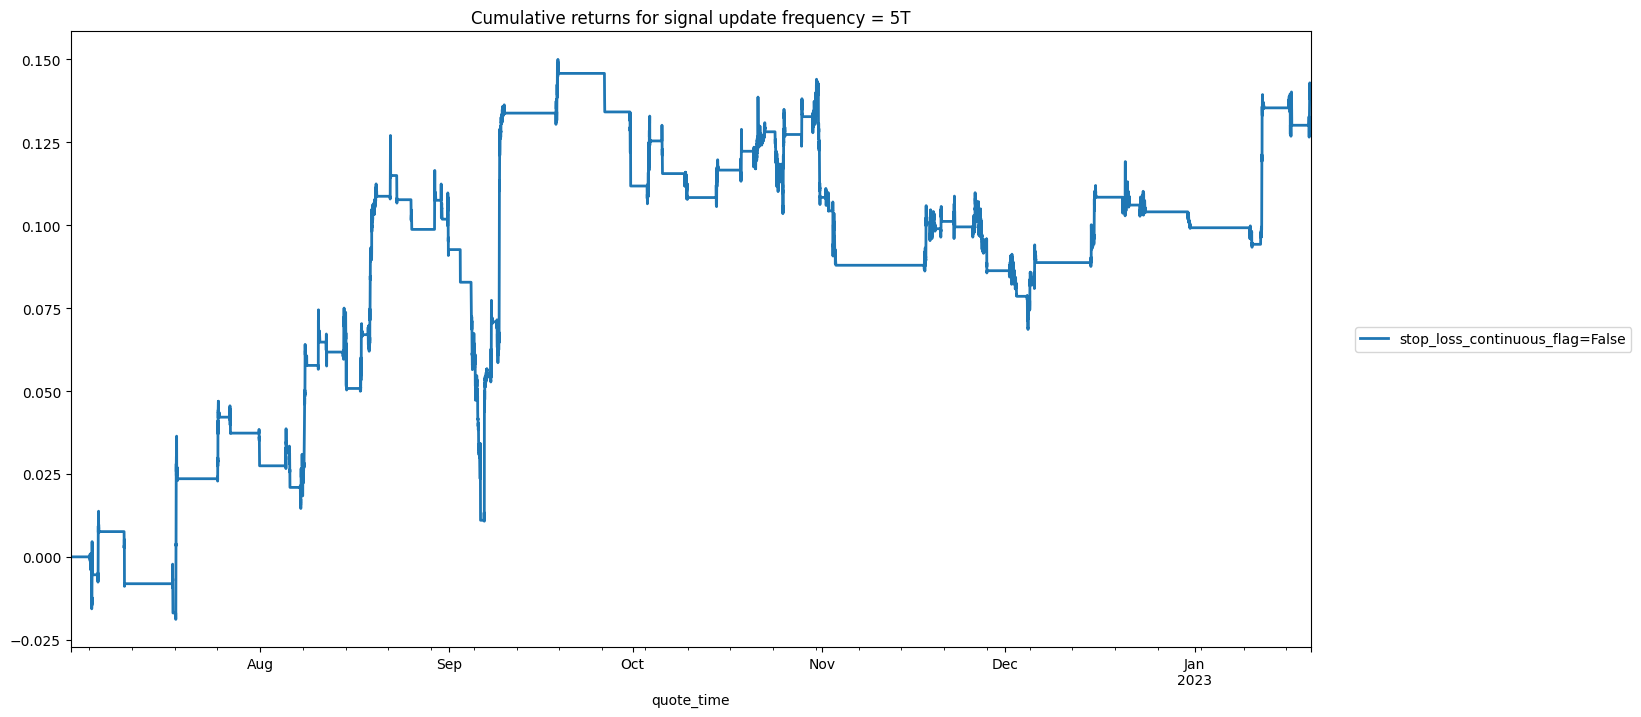

Running time in seconds:  1.4708690643310547


In [ ]:
# start_date = '2020-01-01'
# end_date = '2020-06-02'
start = time.time()

r_0 = 0.0
scale = 365*24*12
frequency_1 = '5T'
frequency_2 = '120T'
stop_loss_frequency = '1T'
exchange = 'HUOBI_FUTURE'

time_span_list = [10,20,30,50,100,150]  
rolling_window = 7
snr_cutoff = 0.6
t_cost = 0.0005
return_shift = 2

## indicator
snr_stop_flag = True
stop_loss_flag = True
stop_loss_continuous_flag_list = [False]
price_range_filter_flag = True


## indicator values
stop_loss_limit = -0.007
stop_loss_decision_lag = 0
price_range_filter_look_back_window = 200
price_range_lower_limit = 0.01
price_range_upper_limit = 0.04

#
rsi_take_profit_flag = True
rsi_half_flag = True
rsi_window = 100
rsi_smooth_flag = True
rsi_smooth_window = 10
rsi_upper_limit = 0.9
rsi_lower_limit = 0.1
rsi_smooth_scaler = 1/12

#
atr_take_profit_flag = True
atr_half_flag = True
atr_smooth_window = 22
atr_coef=3

#
atr_filter_flag = True
atr_filter_smooth_window = 200
atr_range_lower_limit = 0.0031
atr_range_upper_limit = 0.004

#
currency='BTC'
currency_volume_breakout_flag=True
currency_volume_span_list = [10,20,30,50,100,150,200]

df_performance_metrics = pd.DataFrame()
##
count = 0
fig, ax = plt.subplots(figsize=(16,8))
for stop_loss_continuous_flag in stop_loss_continuous_flag_list:
    df_res, df = break_out_strategy_single_currency(df_data = df_market_index_in, df_atr = df_ATR_in,df_atr_filter=df_ATR_filter_in,
                                                     time_span_list = time_span_list,exchange=exchange,currency=currency,
                                                  frequency_2 = frequency_2, rolling_window = rolling_window, frequency_1 = frequency_1,                                      
                                                  snr_cutoff = snr_cutoff, t_cost = t_cost, return_shift = return_shift, snr_stop_flag = snr_stop_flag, 
                                                  price_range_filter_flag = price_range_filter_flag,stop_loss_flag = stop_loss_flag,                      
                                                  price_range_lower_limit = price_range_lower_limit,price_range_upper_limit=price_range_upper_limit,     
                                                  stop_loss_limit = stop_loss_limit,stop_loss_decision_lag = stop_loss_decision_lag,
                                                  price_range_filter_look_back_window = price_range_filter_look_back_window,
                                                  rsi_window = rsi_window,rsi_take_profit_flag =rsi_take_profit_flag,rsi_smooth_flag=rsi_smooth_flag,
                                                  rsi_smooth_window = rsi_smooth_window,rsi_upper_limit=rsi_upper_limit,rsi_lower_limit=rsi_lower_limit,
                                                  atr_take_profit_flag = atr_take_profit_flag,atr_smooth_window=atr_smooth_window,atr_coef=atr_coef,
                                                  rsi_smooth_scaler=rsi_smooth_scaler,atr_half_flag=atr_half_flag,rsi_half_flag=rsi_half_flag,
                                                  atr_filter_flag=atr_filter_flag,atr_filter_smooth_window=atr_filter_smooth_window,
                                                  atr_range_upper_limit=atr_range_upper_limit,atr_range_lower_limit=atr_range_lower_limit,
                                                  currency_volume_breakout_flag=currency_volume_breakout_flag,stop_loss_frequency=stop_loss_frequency,
                                                  currency_volume_span_list=currency_volume_span_list,stop_loss_continuous_flag=stop_loss_continuous_flag
                                                  )   


    ## plots
    # df_res = df_res[pd.Timestamp('2020-10-01'):]
    df_res['return'].cumsum().plot(ax = ax, lw = 2,label = f'stop_loss_continuous_flag={stop_loss_continuous_flag}')


    ## turnover
    turnover = df_res.position.diff().abs().sum()

    ## total return
    total_return = df_res['return'].sum()

    ## maximum drawdown
    max_drawdown = maximum_drawdown(df_res['return'].dropna().values)


    ## sharpe ratio
    shp_ratio = sharpe_ratio(df_res['return'].dropna().resample('D').sum().values, r_0=0, scale = 365)

    ## performance metrics
    total_return = df_res['return'].sum()
    df_performance_metrics_temp = pd.DataFrame({'sharpe_ratio': shp_ratio,
                                                'return_per_trade': 2*total_return/turnover,
                                                'protfolio turn_over': turnover,
                                                'total_return': total_return,
                                                'max_drawdown':max_drawdown,
                                                'stop_loss_limit':stop_loss_limit,
                                                'atr_upper_limit':atr_range_upper_limit,
                                                'stop_loss_continuous_flag':stop_loss_continuous_flag
                                                },
                                                index = [0])

    df_performance_metrics = df_performance_metrics.append(df_performance_metrics_temp, ignore_index=True)

    ##
    end = time.time()
    count +=1
    print('Running time in round {} is: {}s'.format(count, end - start))

## plot title and legend
ax.set_title('Cumulative returns for signal update frequency = {}'.format(frequency_1))
ax.legend(loc = 'center left', bbox_to_anchor=(1.03, 0.5))
plt.show()

# ## performance metrics
# pd.set_option('display.max_columns', 50)
# print(df_performance_metrics)

##
end = time.time()
print('Running time in seconds: ', end - start)

In [ ]:
df_performance_metrics

,sharpe_ratio,return_per_trade,protfolio turn_over,total_return,max_drawdown,stop_loss_limit,atr_upper_limit,stop_loss_continuous_flag
0,1.333164,0.001752,158.0,0.138444,0.116325,-0.007,0.004,False


In [ ]:
grouped_net_pnl['time_series_momentum_BTC_5min'] = df_res['return']
grouped_pos['time_series_momentum_BTC_5min'] = df_res['position']

##### ADA

In [ ]:
currency_list = ['ADA']

df_market_index = pd.DataFrame()
df_market_index_volume = pd.DataFrame()
for currency in currency_list:
    filename_temp = op.join(repo_dir, 'df_spot_kline_binance') + '_' + start_date.replace('-','_') + '_to_' + end_date.replace('-','_') + '_' + currency
    if op.exists(filename_temp + '.pkl'): 
        df_temp = load_obj(filename_temp) 
        df_volume_temp = df_temp[['volume']].rename(columns = {'volume':'volume_' + currency})
        df_price_temp = df_temp[['close']].rename(columns = {'close':'close_' + currency})
        df_volume_temp[f'volume_{currency}'] = np.multiply(df_volume_temp.values,df_price_temp.values)
        df_market_index_volume = pd.concat([df_market_index_volume,df_volume_temp], axis=1)
        df_market_index = pd.concat([df_market_index,df_price_temp], axis=1)
        
df_market_index_volume = df_market_index_volume.fillna(0.0).ewm(span=5).mean()
## log(1+volume)
df_market_index_volume = np.log(1+df_market_index_volume)

## market index
df_market_index = df_market_index.fillna(axis=0, method = 'ffill').dropna()
df_market_index = np.log(df_market_index)

##
# df_market_index['volume_okex'] = df_market_index_volume['volume_okex']
print(len(df_market_index))
##

df_market_index = pd.concat([df_market_index,df_market_index_volume],axis=1)
##
df_market_index = df_market_index.sort_index()
df_market_index.head()

292320


,close_ADA,volume_ADA
quote_time,,
2022-07-01 00:01:00,-0.779577,12.361994
2022-07-01 00:02:00,-0.779577,12.385985
2022-07-01 00:03:00,-0.780231,12.050745
2022-07-01 00:04:00,-0.780231,11.844386
2022-07-01 00:05:00,-0.781104,11.924464


In [ ]:
currency_list = ['ADA']
freq = '3T'

## Price Range
df_ATR = pd.DataFrame()
df_market_index_high = pd.DataFrame()
df_market_index_low = pd.DataFrame()
df_market_index_close = pd.DataFrame()
for currency in currency_list:
    filename_temp = op.join(repo_dir, 'df_spot_kline_binance') + '_' + start_date.replace('-','_') + '_to_' + end_date.replace('-','_') + '_' + currency
    if op.exists(filename_temp + '.pkl'): 
        df_temp = load_obj(filename_temp)
        df_price_high_temp = df_temp[['high']].resample(freq).max().rename(columns = {'high':'high_' + currency}).fillna(method='ffill')
        df_price_low_temp = df_temp[['low']].resample(freq).min().rename(columns = {'low':'low_' + currency}).fillna(method='ffill')
        df_price_close_temp = df_temp[['close']].resample(freq).last().rename(columns = {'close':'close_' + currency}).fillna(method='ffill')
        ## 
        df_ATR['high'] = np.log(df_price_high_temp[f'high_{currency}'].fillna(method='ffill'))
        df_ATR['low'] = np.log(df_price_low_temp.fillna(method='ffill'))
        df_ATR['close'] = np.log(df_price_close_temp.fillna(method='ffill'))
        df_ATR[f'market_index_tr_{currency}'] = build_ATR(df_ATR, smooth_window = 1)

df_ATR = df_ATR.drop(['high','low','close'],axis=1)
# df_ATR = df_ATR[pd.Timestamp('2019-04-01'):pd.Timestamp('2019-07-31')]
df_ATR.head(3)

,market_index_tr_ADA
quote_time,
2022-07-01 00:00:00,0.007838
2022-07-01 00:03:00,0.004581
2022-07-01 00:06:00,0.008074


In [ ]:
currency_list = ['ADA']
freq = '5T'

## Price Range
df_ATR_filter = pd.DataFrame()
df_market_index_high = pd.DataFrame()
df_market_index_low = pd.DataFrame()
df_market_index_close = pd.DataFrame()
for currency in currency_list:
    filename_temp = op.join(repo_dir, 'df_spot_kline_binance') + '_' + start_date.replace('-','_') + '_to_' + end_date.replace('-','_') + '_' + currency
    if op.exists(filename_temp + '.pkl'): 
        df_temp = load_obj(filename_temp) 
        df_price_high_temp = df_temp[['high']].resample(freq).max().rename(columns = {'high':'high_' + currency}).fillna(method='ffill')
        df_price_low_temp = df_temp[['low']].resample(freq).min().rename(columns = {'low':'low_' + currency}).fillna(method='ffill')
        df_price_close_temp = df_temp[['close']].resample(freq).last().rename(columns = {'close':'close_' + currency}).fillna(method='ffill')

        df_ATR_filter['high'] = np.log(df_price_high_temp[f'high_{currency}'].fillna(method='ffill'))
        df_ATR_filter['low'] = np.log(df_price_low_temp.fillna(method='ffill'))
        df_ATR_filter['close'] = np.log(df_price_close_temp.fillna(method='ffill'))
        df_ATR_filter[f'market_index_tr_{currency}'] = build_ATR(df_ATR_filter, smooth_window = 1)

# df_ATR_filter = df_ATR_filter[pd.Timestamp('2019-04-01'):pd.Timestamp('2019-07-31')]
df_ATR_filter.head(3)

,high,low,close,market_index_tr_ADA
quote_time,,,,
2022-07-01 00:00:00,-0.774140,-0.781978,-0.780231,0.007838
2022-07-01 00:05:00,-0.776311,-0.784386,-0.779577,0.008074
2022-07-01 00:10:00,-0.768086,-0.779795,-0.772407,0.011709


In [ ]:
df_market_index_in = df_market_index[pd.Timestamp('2020-01-01'):]
df_ATR_in = df_ATR[pd.Timestamp('2020-01-01'):]
df_ATR_filter_in = df_ATR_filter[pd.Timestamp('2020-01-01'):]

###### return series

<ipython-input-11-550c5ea8623a>:235: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df_res['cumulative_return_per_trade'] = df_res.groupby('return_group')['return_origin'].apply(lambda x: \
<ipython-input-39-8908990d631f>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_performance_metrics = df_performance_metrics.append(df_performance_metrics_temp, ignore_index=True)


Running time in round 1 is: 1.7679128646850586s


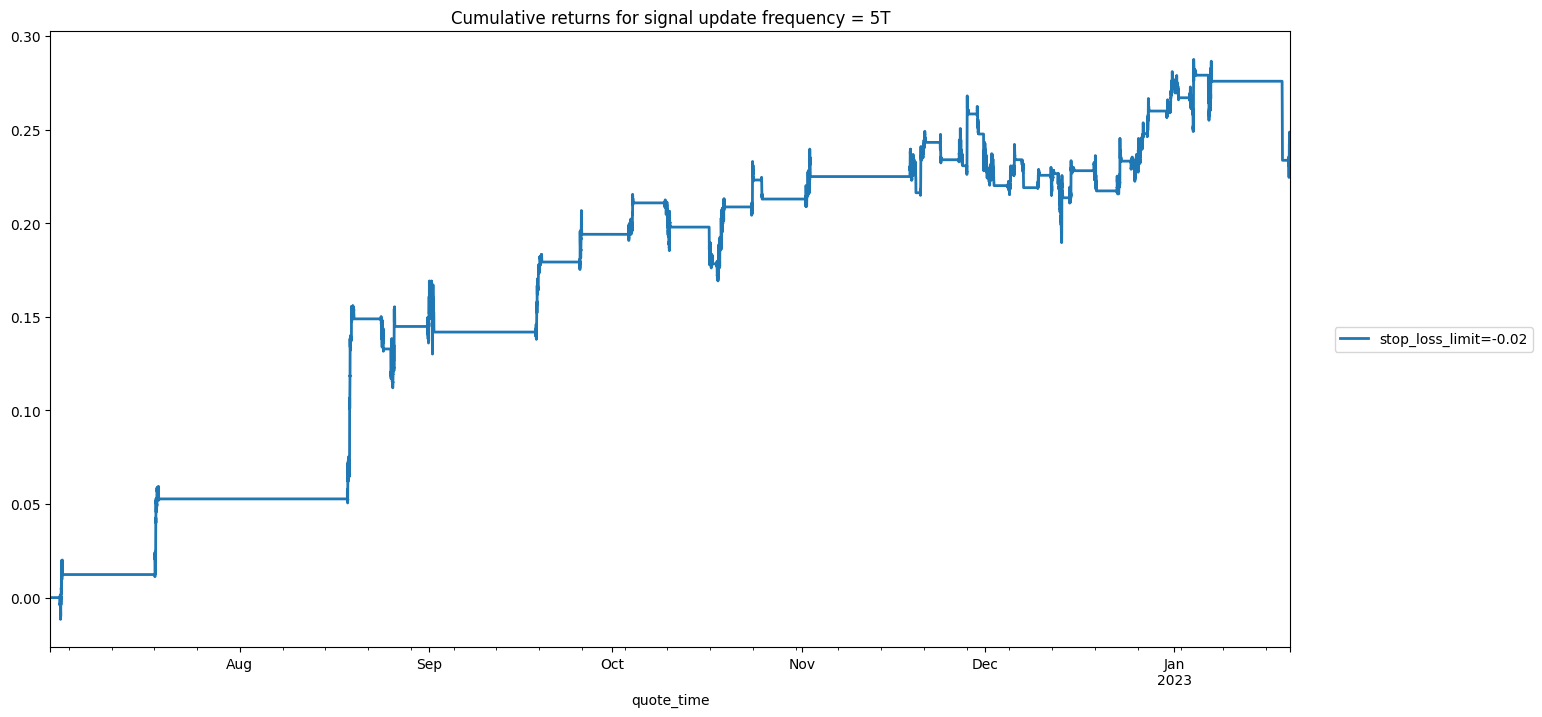

Running time in seconds:  2.3060879707336426


In [ ]:
# start_date = '2020-01-01'
# end_date = '2020-06-02'
start = time.time()

r_0 = 0.0
scale = 365*24*12
frequency_1 = '5T'
frequency_2 = '120T'
stop_loss_frequency = '1T'
exchange = 'HUOBI_FUTURE'

time_span_list = [10,20,30,50,100,150]  
rolling_window = 7
snr_cutoff = 0.6
t_cost = 0.0005
return_shift = 2

## indicator
snr_stop_flag = True
stop_loss_flag = True
stop_loss_continuous_flag = False
price_range_filter_flag = True


## indicator values
stop_loss_limit_list = [-0.02]
stop_loss_decision_lag = 0
price_range_filter_look_back_window = 200
price_range_lower_limit = 0.0
price_range_upper_limit = 0.03

rsi_take_profit_flag = True
rsi_half_flag = True
rsi_window = 100
rsi_smooth_flag = True
rsi_smooth_window = 10
rsi_upper_limit = 0.9
rsi_lower_limit = 0.1
rsi_smooth_scaler = 1/12

#
atr_take_profit_flag = True
atr_half_flag = True
atr_smooth_window = 22
atr_coef=3

#
atr_filter_flag = True
atr_filter_smooth_window = 200
atr_range_lower_limit = 0.0035
atr_range_upper_limit = 0.004

#
currency='ADA'
currency_volume_breakout_flag=True
currency_volume_span_list = [10,20,30,50,100,150]

df_performance_metrics = pd.DataFrame()
##
count = 0
fig, ax = plt.subplots(figsize=(16,8))
for stop_loss_limit in stop_loss_limit_list:
    df_res, df = break_out_strategy_single_currency(df_data = df_market_index_in, df_atr = df_ATR_in,df_atr_filter=df_ATR_filter_in,
                                                     time_span_list = time_span_list,exchange=exchange,currency=currency,
                                                  frequency_2 = frequency_2, rolling_window = rolling_window, frequency_1 = frequency_1,                                      
                                                  snr_cutoff = snr_cutoff, t_cost = t_cost, return_shift = return_shift, snr_stop_flag = snr_stop_flag,
                                                  price_range_filter_flag = price_range_filter_flag,stop_loss_flag = stop_loss_flag,                      
                                                  price_range_lower_limit = price_range_lower_limit,price_range_upper_limit=price_range_upper_limit,     
                                                  stop_loss_limit = stop_loss_limit,stop_loss_decision_lag = stop_loss_decision_lag,
                                                  price_range_filter_look_back_window = price_range_filter_look_back_window,
                                                  rsi_window = rsi_window,rsi_take_profit_flag =rsi_take_profit_flag,rsi_smooth_flag=rsi_smooth_flag,
                                                  rsi_smooth_window = rsi_smooth_window,rsi_upper_limit=rsi_upper_limit,rsi_lower_limit=rsi_lower_limit,
                                                  atr_take_profit_flag = atr_take_profit_flag,atr_smooth_window=atr_smooth_window,atr_coef=atr_coef,
                                                  rsi_smooth_scaler=rsi_smooth_scaler,atr_half_flag=atr_half_flag,rsi_half_flag=rsi_half_flag,
                                                  atr_filter_flag=atr_filter_flag,atr_filter_smooth_window=atr_filter_smooth_window,
                                                  atr_range_upper_limit=atr_range_upper_limit,atr_range_lower_limit=atr_range_lower_limit,
                                                  currency_volume_breakout_flag=currency_volume_breakout_flag,stop_loss_frequency=stop_loss_frequency,
                                                  currency_volume_span_list=currency_volume_span_list,stop_loss_continuous_flag=stop_loss_continuous_flag
                                                  ) 


    ## plots
    df_res['return'].cumsum().plot(ax = ax, lw = 2,label = f'stop_loss_limit={stop_loss_limit}')


    ## turnover
    turnover = df_res.position.diff().abs().sum()

    ## total return
    total_return = df_res['return'].sum()

    ## maximum drawdown
    max_drawdown = maximum_drawdown(df_res['return'].dropna().values)


    ## sharpe ratio
    shp_ratio = sharpe_ratio(df_res['return'].dropna().resample('D').sum().values, r_0=0, scale = 365)

    ## performance metrics
    total_return = df_res['return'].sum()
    df_performance_metrics_temp = pd.DataFrame({'sharpe_ratio': shp_ratio,
                                                'return_per_trade': 2*total_return/turnover,
                                                'protfolio turn_over': turnover,
                                                'total_return': total_return,
                                                'max_drawdown':max_drawdown,
                                                'stop_loss_limit':stop_loss_limit,
                                                'stop_loss_flag':stop_loss_flag,
                                                'price_range_limit':price_range_upper_limit,
                                                'atr_lower_limit':atr_range_lower_limit,
                                                'atr_upper_limit':atr_range_upper_limit
                                                },
                                                index = [0])

    df_performance_metrics = df_performance_metrics.append(df_performance_metrics_temp, ignore_index=True)

    ##
    end = time.time()
    count +=1
    print('Running time in round {} is: {}s'.format(count, end - start))

## plot title and legend
ax.set_title('Cumulative returns for signal update frequency = {}'.format(frequency_1))
ax.legend(loc = 'center left', bbox_to_anchor=(1.03, 0.5))
plt.show()

# ## performance metrics
# pd.set_option('display.max_columns', 50)
# print(df_performance_metrics)

##
end = time.time()
print('Running time in seconds: ', end - start)

In [ ]:
df_performance_metrics

,sharpe_ratio,return_per_trade,protfolio turn_over,total_return,max_drawdown,stop_loss_limit,stop_loss_flag,price_range_limit,atr_lower_limit,atr_upper_limit
0,2.43023,0.004401,107.0,0.235445,0.078409,-0.02,True,0.03,0.0035,0.004


In [ ]:
grouped_net_pnl['time_series_momentum_ADA_5min'] = df_res['return']
grouped_pos['time_series_momentum_ADA_5min'] = df_res['position']

##### AVAX

In [ ]:
currency_list = ['AVAX']

df_market_index = pd.DataFrame()
df_market_index_volume = pd.DataFrame()
for currency in currency_list:
    filename_temp = op.join(repo_dir, 'df_spot_kline_binance') + '_' + start_date.replace('-','_') + '_to_' + end_date.replace('-','_') + '_' + currency
    if op.exists(filename_temp + '.pkl'): 
        df_temp = load_obj(filename_temp) 
        df_volume_temp = df_temp[['volume']].rename(columns = {'volume':'volume_' + currency})
        df_price_temp = df_temp[['close']].rename(columns = {'close':'close_' + currency})
        df_volume_temp[f'volume_{currency}'] = np.multiply(df_volume_temp.values,df_price_temp.values)
        df_market_index_volume = pd.concat([df_market_index_volume,df_volume_temp], axis=1)
        df_market_index = pd.concat([df_market_index,df_price_temp], axis=1)
        
df_market_index_volume = df_market_index_volume.fillna(0.0).ewm(span=5).mean()
## log(1+volume)
df_market_index_volume = np.log(1+df_market_index_volume)

## market index
df_market_index = df_market_index.fillna(axis=0, method = 'ffill').dropna()
df_market_index = np.log(df_market_index)

##
print(len(df_market_index))
##
df_market_index = pd.concat([df_market_index,df_market_index_volume],axis=1)
##
df_market_index = df_market_index.sort_index()
df_market_index.head()

292320


,close_AVAX,volume_AVAX
quote_time,,
2022-07-01 00:01:00,2.826129,11.180571
2022-07-01 00:02:00,2.826129,11.740328
2022-07-01 00:03:00,2.824351,11.480962
2022-07-01 00:04:00,2.823757,11.253682
2022-07-01 00:05:00,2.821379,11.385549


In [ ]:
currency_list = ['AVAX']
freq = '3T'

## Price Range
df_ATR = pd.DataFrame()
df_market_index_high = pd.DataFrame()
df_market_index_low = pd.DataFrame()
df_market_index_close = pd.DataFrame()
for currency in currency_list:
    filename_temp = op.join(repo_dir, 'df_spot_kline_binance') + '_' + start_date.replace('-','_') + '_to_' + end_date.replace('-','_') + '_' + currency
    if op.exists(filename_temp + '.pkl'): 
        df_temp = load_obj(filename_temp)
        df_price_high_temp = df_temp[['high']].resample(freq).max().rename(columns = {'high':'high_' + currency}).fillna(method='ffill')
        df_price_low_temp = df_temp[['low']].resample(freq).min().rename(columns = {'low':'low_' + currency}).fillna(method='ffill')
        df_price_close_temp = df_temp[['close']].resample(freq).last().rename(columns = {'close':'close_' + currency}).fillna(method='ffill')
        ## 
        df_ATR['high'] = np.log(df_price_high_temp[f'high_{currency}'].fillna(method='ffill'))
        df_ATR['low'] = np.log(df_price_low_temp.fillna(method='ffill'))
        df_ATR['close'] = np.log(df_price_close_temp.fillna(method='ffill'))
        df_ATR[f'market_index_tr_{currency}'] = build_ATR(df_ATR, smooth_window = 1)

df_ATR = df_ATR.drop(['high','low','close'],axis=1)
# df_ATR = df_ATR[pd.Timestamp('2019-04-01'):pd.Timestamp('2019-07-31')]
df_ATR.head(3)

,market_index_tr_AVAX
quote_time,
2022-07-01 00:00:00,0.008868
2022-07-01 00:03:00,0.006530
2022-07-01 00:06:00,0.008328


In [ ]:
currency_list = ['AVAX']
freq = '5T'

## Price Range
df_ATR_filter = pd.DataFrame()
df_market_index_high = pd.DataFrame()
df_market_index_low = pd.DataFrame()
df_market_index_close = pd.DataFrame()
for currency in currency_list:
    filename_temp = op.join(repo_dir, 'df_spot_kline_binance') + '_' + start_date.replace('-','_') + '_to_' + end_date.replace('-','_') + '_' + currency
    if op.exists(filename_temp + '.pkl'): 
        df_temp = load_obj(filename_temp) 
        df_price_high_temp = df_temp[['high']].resample(freq).max().rename(columns = {'high':'high_' + currency}).fillna(method='ffill')
        df_price_low_temp = df_temp[['low']].resample(freq).min().rename(columns = {'low':'low_' + currency}).fillna(method='ffill')
        df_price_close_temp = df_temp[['close']].resample(freq).last().rename(columns = {'close':'close_' + currency}).fillna(method='ffill')

        df_ATR_filter['high'] = np.log(df_price_high_temp[f'high_{currency}'].fillna(method='ffill'))
        df_ATR_filter['low'] = np.log(df_price_low_temp.fillna(method='ffill'))
        df_ATR_filter['close'] = np.log(df_price_close_temp.fillna(method='ffill'))
        df_ATR_filter[f'market_index_tr_{currency}'] = build_ATR(df_ATR_filter, smooth_window = 1)

# df_ATR_filter = df_ATR_filter[pd.Timestamp('2019-04-01'):pd.Timestamp('2019-07-31')]
df_ATR_filter.head(3)

,high,low,close,market_index_tr_AVAX
quote_time,,,,
2022-07-01 00:00:00,2.832625,2.822569,2.823757,0.010056
2022-07-01 00:05:00,2.826129,2.817801,2.821379,0.008328
2022-07-01 00:10:00,2.830268,2.821379,2.827314,0.008889


In [ ]:
df_market_index_in = df_market_index[pd.Timestamp('2020-01-01'):]
df_ATR_in = df_ATR[pd.Timestamp('2020-01-01'):]
df_ATR_filter_in = df_ATR_filter[pd.Timestamp('2020-01-01'):]

###### return series

<ipython-input-11-550c5ea8623a>:235: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df_res['cumulative_return_per_trade'] = df_res.groupby('return_group')['return_origin'].apply(lambda x: \
<ipython-input-46-0d8a1c04b4b4>:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_performance_metrics = df_performance_metrics.append(df_performance_metrics_temp, ignore_index=True)


Running time in round 1 is: 1.1467561721801758s


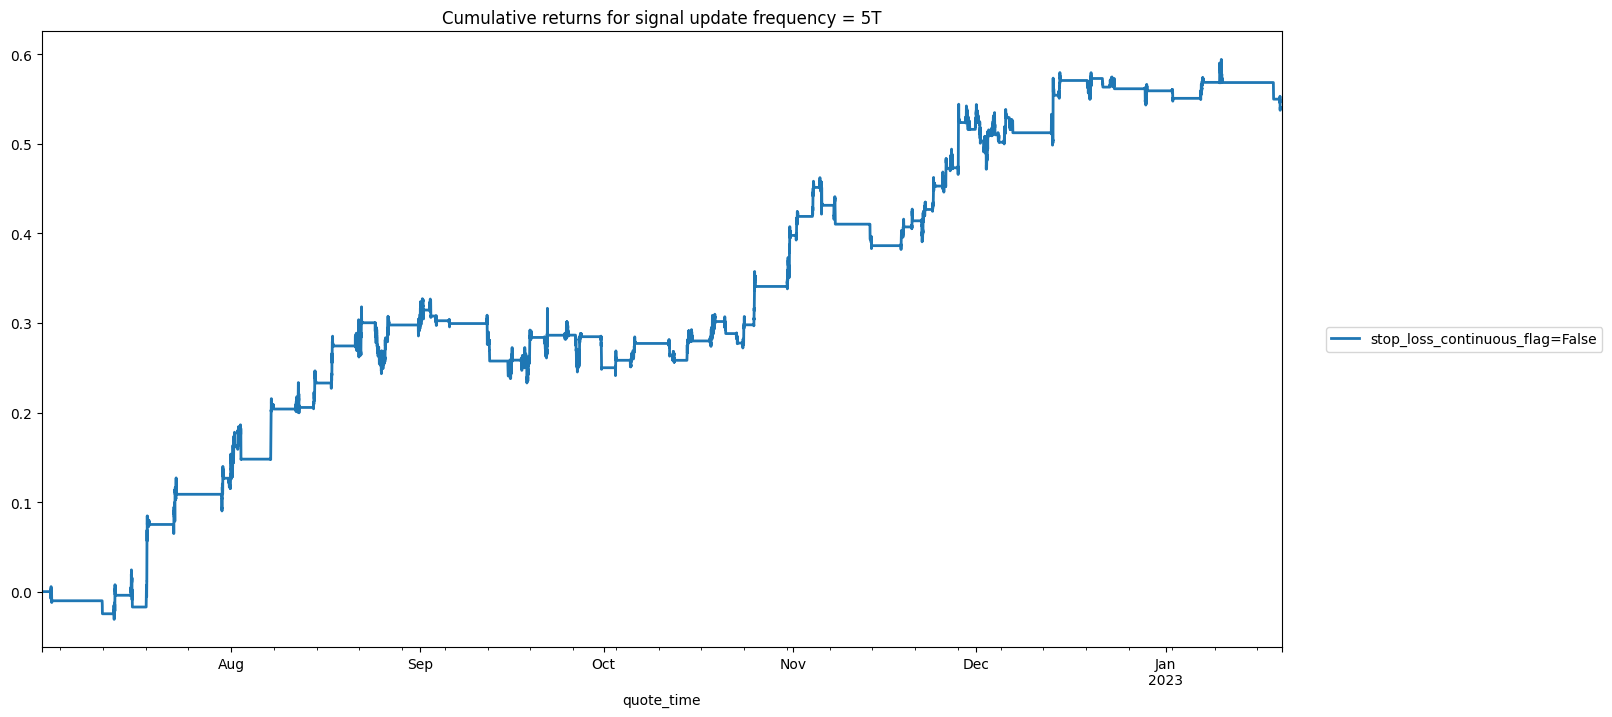

Running time in seconds:  1.5812499523162842


In [ ]:
# start_date = '2020-01-01'
# end_date = '2020-06-02'
start = time.time()

r_0 = 0.0
scale = 365*24*12
frequency_1 = '5T'
frequency_2 = '120T'
stop_loss_frequency = '1T'
exchange = 'HUOBI_FUTURE'

time_span_list = [10,20,30,50,100]  
rolling_window = 7
snr_cutoff = 0.6
t_cost = 0.0005
return_shift = 2

## indicator
snr_stop_flag = True
stop_loss_flag = True
stop_loss_continuous_flag_list = [False]
price_range_filter_flag = True


## indicator values
stop_loss_limit = -0.012
stop_loss_decision_lag = 0
price_range_filter_look_back_window = 200
price_range_lower_limit = 0.02
price_range_upper_limit = 0.05

rsi_take_profit_flag = True
rsi_half_flag = True
rsi_window = 100
rsi_smooth_flag = True
rsi_smooth_window = 10
rsi_upper_limit = 0.9
rsi_lower_limit = 0.1
rsi_smooth_scaler = 1/12

#
atr_take_profit_flag = True
atr_half_flag = True
atr_smooth_window = 22
atr_coef=3

#
atr_filter_flag = True
atr_filter_smooth_window = 200
atr_range_lower_limit = 0.0035
atr_range_upper_limit = 0.004

#
currency='AVAX'
currency_volume_breakout_flag=True
currency_volume_span_list = [10,20,30,50,100]

df_performance_metrics = pd.DataFrame()
##
count = 0
fig, ax = plt.subplots(figsize=(16,8))
for stop_loss_continuous_flag in stop_loss_continuous_flag_list:
    df_res, df = break_out_strategy_single_currency(df_data = df_market_index_in, df_atr = df_ATR_in,df_atr_filter=df_ATR_filter_in,
                                                     time_span_list = time_span_list,exchange=exchange,
                                                  frequency_2 = frequency_2, rolling_window = rolling_window, frequency_1 = frequency_1,                                      
                                                  snr_cutoff = snr_cutoff, t_cost = t_cost, return_shift = return_shift, snr_stop_flag = snr_stop_flag,
                                                  price_range_filter_flag = price_range_filter_flag,stop_loss_flag = stop_loss_flag,                      
                                                  price_range_lower_limit = price_range_lower_limit,price_range_upper_limit=price_range_upper_limit,     
                                                  stop_loss_limit = stop_loss_limit,stop_loss_decision_lag = stop_loss_decision_lag,
                                                  price_range_filter_look_back_window = price_range_filter_look_back_window,
                                                  rsi_window = rsi_window,rsi_take_profit_flag =rsi_take_profit_flag,rsi_smooth_flag=rsi_smooth_flag,
                                                  rsi_smooth_window = rsi_smooth_window,rsi_upper_limit=rsi_upper_limit,rsi_lower_limit=rsi_lower_limit,
                                                  atr_take_profit_flag = atr_take_profit_flag,atr_smooth_window=atr_smooth_window,atr_coef=atr_coef,
                                                  rsi_smooth_scaler=rsi_smooth_scaler,atr_half_flag=atr_half_flag,rsi_half_flag=rsi_half_flag,
                                                  atr_filter_flag=atr_filter_flag,atr_filter_smooth_window=atr_filter_smooth_window,
                                                  atr_range_upper_limit=atr_range_upper_limit,currency=currency,atr_range_lower_limit=atr_range_lower_limit,
                                                  currency_volume_breakout_flag=currency_volume_breakout_flag,stop_loss_frequency=stop_loss_frequency,
                                                  currency_volume_span_list=currency_volume_span_list,stop_loss_continuous_flag=stop_loss_continuous_flag
                                                  )   


    ## plots
    df_res['return'].cumsum().plot(ax = ax, lw = 2,label = f'stop_loss_continuous_flag={stop_loss_continuous_flag}')


    ## turnover
    turnover = df_res.position.diff().abs().sum()

    ## total return
    total_return = df_res['return'].sum()

    ## maximum drawdown
    max_drawdown = maximum_drawdown(df_res['return'].dropna().values)


    ## sharpe ratio
    shp_ratio = sharpe_ratio(df_res['return'].dropna().resample('D').sum().values, r_0=0, scale = 365)

    ## performance metrics
    total_return = df_res['return'].sum()
    df_performance_metrics_temp = pd.DataFrame({'sharpe_ratio': shp_ratio,
                                                'return_per_trade': 2*total_return/turnover,
                                                'protfolio turn_over': turnover,
                                                'total_return': total_return,
                                                'max_drawdown':max_drawdown,
                                                'stop_loss_limit':stop_loss_limit,
                                                'price_upper_limit':price_range_upper_limit,
                                                'atr_upper_limit':atr_range_upper_limit,
                                                'atr_lower_limit':atr_range_lower_limit,
                                                'stop_loss_continuous_flag':stop_loss_continuous_flag
                                                },
                                                index = [0])

    df_performance_metrics = df_performance_metrics.append(df_performance_metrics_temp, ignore_index=True)

    ##
    end = time.time()
    count +=1
    print('Running time in round {} is: {}s'.format(count, end - start))

## plot title and legend
ax.set_title('Cumulative returns for signal update frequency = {}'.format(frequency_1))
ax.legend(loc = 'center left', bbox_to_anchor=(1.03, 0.5))
plt.show()

# ## performance metrics
# pd.set_option('display.max_columns', 50)
# print(df_performance_metrics)

##
end = time.time()
print('Running time in seconds: ', end - start)

In [ ]:
df_performance_metrics

,sharpe_ratio,return_per_trade,protfolio turn_over,total_return,max_drawdown,stop_loss_limit,price_upper_limit,atr_upper_limit,atr_lower_limit,stop_loss_continuous_flag
0,3.34627,0.005349,202.0,0.540206,0.094097,-0.012,0.05,0.004,0.0035,False


In [ ]:
grouped_net_pnl['time_series_momentum_AVAX_5min'] = df_res['return']
grouped_pos['time_series_momentum_AVAX_5min'] = df_res['position']

##### AXS

In [ ]:
currency_list = ['AXS']

df_market_index = pd.DataFrame()
df_market_index_volume = pd.DataFrame()
for currency in currency_list:
    filename_temp = op.join(repo_dir, 'df_spot_kline_binance') + '_' + start_date.replace('-','_') + '_to_' + end_date.replace('-','_') + '_' + currency
    if op.exists(filename_temp + '.pkl'): 
        df_temp = load_obj(filename_temp) 
        df_volume_temp = df_temp[['volume']].rename(columns = {'volume':'volume_' + currency})
        df_price_temp = df_temp[['close']].rename(columns = {'close':'close_' + currency})
        df_volume_temp[f'volume_{currency}'] = np.multiply(df_volume_temp.values,df_price_temp.values)
        df_market_index_volume = pd.concat([df_market_index_volume,df_volume_temp], axis=1)
        df_market_index = pd.concat([df_market_index,df_price_temp], axis=1)
        
df_market_index_volume = df_market_index_volume.fillna(0.0).ewm(span=5).mean()
## log(1+volume)
df_market_index_volume = np.log(1+df_market_index_volume)

## market index
df_market_index = df_market_index.fillna(axis=0, method = 'ffill').dropna()
df_market_index = np.log(df_market_index)

##
print(len(df_market_index))
##

df_market_index = pd.concat([df_market_index,df_market_index_volume],axis=1)
##
df_market_index = df_market_index.sort_index()
df_market_index.head()

292320


,close_AXS,volume_AXS
quote_time,,
2022-07-01 00:01:00,2.675527,9.820841
2022-07-01 00:02:00,2.674838,10.438452
2022-07-01 00:03:00,2.677591,10.130693
2022-07-01 00:04:00,2.674838,9.939230
2022-07-01 00:05:00,2.671386,9.948809


In [ ]:
currency_list = ['AXS']
freq = '3T'

## Price Range
df_ATR = pd.DataFrame()
df_market_index_high = pd.DataFrame()
df_market_index_low = pd.DataFrame()
df_market_index_close = pd.DataFrame()
for currency in currency_list:
    filename_temp = op.join(repo_dir, 'df_spot_kline_binance') + '_' + start_date.replace('-','_') + '_to_' + end_date.replace('-','_') + '_' + currency
    if op.exists(filename_temp + '.pkl'): 
        df_temp = load_obj(filename_temp)
        df_price_high_temp = df_temp[['high']].resample(freq).max().rename(columns = {'high':'high_' + currency}).fillna(method='ffill')
        df_price_low_temp = df_temp[['low']].resample(freq).min().rename(columns = {'low':'low_' + currency}).fillna(method='ffill')
        df_price_close_temp = df_temp[['close']].resample(freq).last().rename(columns = {'close':'close_' + currency}).fillna(method='ffill')
        ## 
        df_ATR['high'] = np.log(df_price_high_temp[f'high_{currency}'].fillna(method='ffill'))
        df_ATR['low'] = np.log(df_price_low_temp.fillna(method='ffill'))
        df_ATR['close'] = np.log(df_price_close_temp.fillna(method='ffill'))
        df_ATR[f'market_index_tr_{currency}'] = build_ATR(df_ATR, smooth_window = 1)

df_ATR = df_ATR.drop(['high','low','close'],axis=1)
# df_ATR = df_ATR[pd.Timestamp('2019-04-01'):pd.Timestamp('2019-07-31')]
df_ATR.head(3)

,market_index_tr_AXS
quote_time,
2022-07-01 00:00:00,0.008253
2022-07-01 00:03:00,0.006897
2022-07-01 00:06:00,0.009649


In [ ]:
currency_list = ['AXS']
freq = '5T'

## Price Range
df_ATR_filter = pd.DataFrame()
df_market_index_high = pd.DataFrame()
df_market_index_low = pd.DataFrame()
df_market_index_close = pd.DataFrame()
for currency in currency_list:
    filename_temp = op.join(repo_dir, 'df_spot_kline_binance') + '_' + start_date.replace('-','_') + '_to_' + end_date.replace('-','_') + '_' + currency
    if op.exists(filename_temp + '.pkl'): 
        df_temp = load_obj(filename_temp) 
        df_price_high_temp = df_temp[['high']].resample(freq).max().rename(columns = {'high':'high_' + currency}).fillna(method='ffill')
        df_price_low_temp = df_temp[['low']].resample(freq).min().rename(columns = {'low':'low_' + currency}).fillna(method='ffill')
        df_price_close_temp = df_temp[['close']].resample(freq).last().rename(columns = {'close':'close_' + currency}).fillna(method='ffill')

        df_ATR_filter['high'] = np.log(df_price_high_temp[f'high_{currency}'].fillna(method='ffill'))
        df_ATR_filter['low'] = np.log(df_price_low_temp.fillna(method='ffill'))
        df_ATR_filter['close'] = np.log(df_price_close_temp.fillna(method='ffill'))
        df_ATR_filter[f'market_index_tr_{currency}'] = build_ATR(df_ATR_filter, smooth_window = 1)

# df_ATR_filter = df_ATR_filter[pd.Timestamp('2019-04-01'):pd.Timestamp('2019-07-31')]
df_ATR_filter.head(3)

,high,low,close,market_index_tr_AXS
quote_time,,,,
2022-07-01 00:00:00,2.681022,2.672768,2.674838,0.008253
2022-07-01 00:05:00,2.679651,2.670002,2.677591,0.009649
2022-07-01 00:10:00,2.698000,2.676903,2.688528,0.021096


In [ ]:
df_market_index_in = df_market_index[pd.Timestamp('2020-01-01'):]
df_ATR_in = df_ATR[pd.Timestamp('2020-01-01'):]
df_ATR_filter_in = df_ATR_filter[pd.Timestamp('2020-01-01'):]

###### return series

<ipython-input-11-550c5ea8623a>:235: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df_res['cumulative_return_per_trade'] = df_res.groupby('return_group')['return_origin'].apply(lambda x: \
<ipython-input-53-3beea9b08c52>:113: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_performance_metrics = df_performance_metrics.append(df_performance_metrics_temp, ignore_index=True)


Running time in round 1 is: 1.731243371963501s


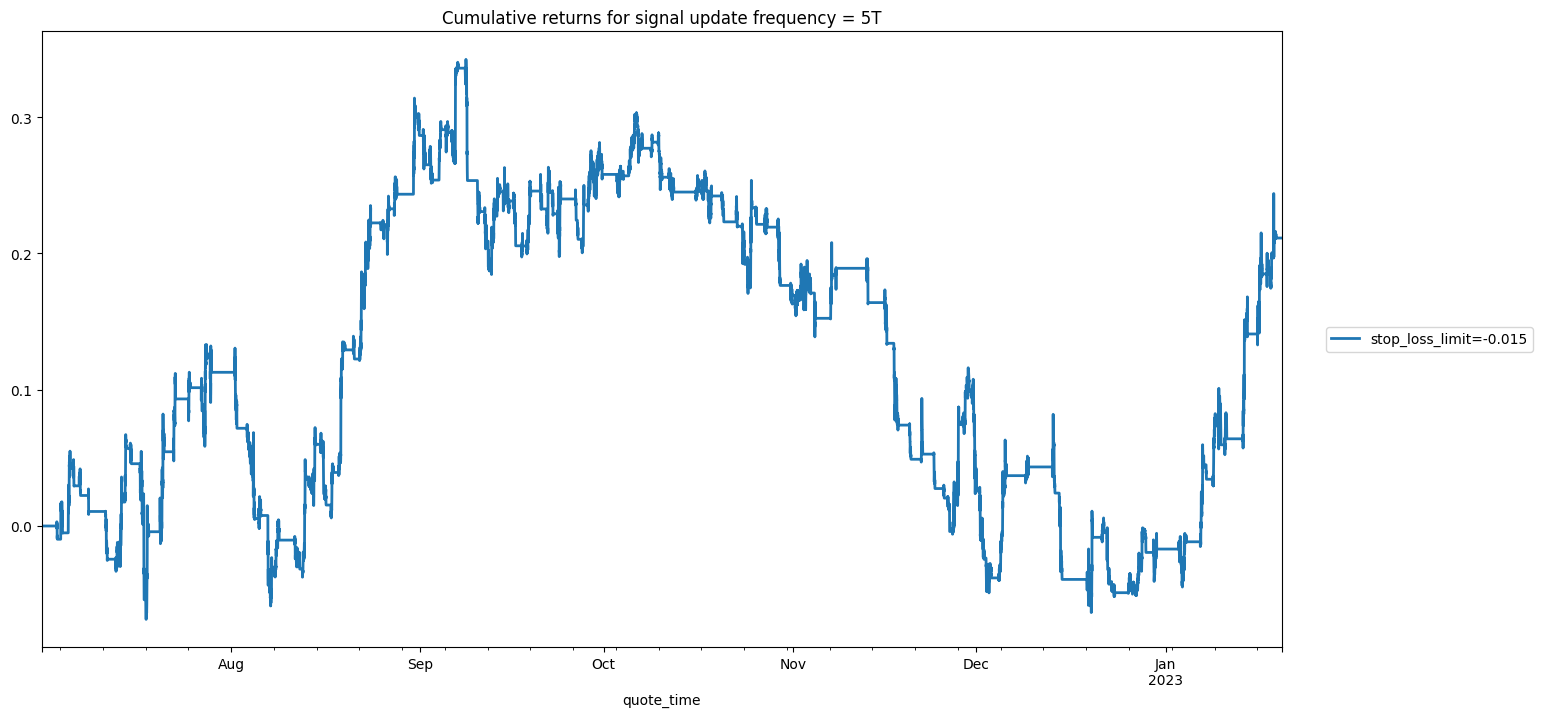

Running time in seconds:  2.170722007751465


In [ ]:
# start_date = '2020-01-01'
# end_date = '2020-06-02'
start = time.time()

r_0 = 0.0
scale = 365*24*12
frequency_1 = '5T'
frequency_2 = '120T'
stop_loss_frequency = '1T'
exchange = 'HUOBI_FUTURE'

time_span_list = [10,20,30,50]  
rolling_window = 7
snr_cutoff = 0.6
t_cost = 0.0005
return_shift = 2

## indicator
snr_stop_flag = True
stop_loss_flag = True
stop_loss_continuous_flag = False
price_range_filter_flag = True


## indicator values
stop_loss_limit_list = [-0.015]
stop_loss_decision_lag = 0
price_range_filter_look_back_window = 200
price_range_lower_limit = 0.0
price_range_upper_limit = 0.075

rsi_take_profit_flag = True
rsi_half_flag = True
rsi_window = 100
rsi_smooth_flag = True
rsi_smooth_window = 10
rsi_upper_limit = 0.9
rsi_lower_limit = 0.1
rsi_smooth_scaler = 1/12

#
atr_take_profit_flag = True
atr_half_flag = True
atr_smooth_window = 22
atr_coef=3

#
atr_filter_flag = True
atr_filter_smooth_window = 200
atr_range_lower_limit = 0.0065
atr_range_upper_limit = 0.0075

#
currency='AXS'
currency_volume_breakout_flag=True
currency_volume_span_list = [10,20,30,50,100,150]

df_performance_metrics = pd.DataFrame()
##
count = 0
fig, ax = plt.subplots(figsize=(16,8))
for stop_loss_limit in stop_loss_limit_list:
    df_res, df = break_out_strategy_single_currency(df_data = df_market_index_in, df_atr = df_ATR_in,df_atr_filter=df_ATR_filter_in,
                                                     time_span_list = time_span_list,exchange=exchange,currency=currency,
                                                  frequency_2 = frequency_2, rolling_window = rolling_window, frequency_1 = frequency_1,                                      
                                                  snr_cutoff = snr_cutoff, t_cost = t_cost, return_shift = return_shift, snr_stop_flag = snr_stop_flag, 
                                                  price_range_filter_flag = price_range_filter_flag,stop_loss_flag = stop_loss_flag,                      
                                                  price_range_lower_limit = price_range_lower_limit,price_range_upper_limit=price_range_upper_limit,     
                                                  stop_loss_limit = stop_loss_limit,stop_loss_decision_lag = stop_loss_decision_lag,
                                                  price_range_filter_look_back_window = price_range_filter_look_back_window,
                                                  rsi_window = rsi_window,rsi_take_profit_flag =rsi_take_profit_flag,rsi_smooth_flag=rsi_smooth_flag,
                                                  rsi_smooth_window = rsi_smooth_window,rsi_upper_limit=rsi_upper_limit,rsi_lower_limit=rsi_lower_limit,
                                                  atr_take_profit_flag = atr_take_profit_flag,atr_smooth_window=atr_smooth_window,atr_coef=atr_coef,
                                                  rsi_smooth_scaler=rsi_smooth_scaler,atr_half_flag=atr_half_flag,rsi_half_flag=rsi_half_flag,
                                                  atr_filter_flag=atr_filter_flag,atr_filter_smooth_window=atr_filter_smooth_window,
                                                  atr_range_upper_limit=atr_range_upper_limit,atr_range_lower_limit=atr_range_lower_limit,
                                                  currency_volume_breakout_flag=currency_volume_breakout_flag,stop_loss_frequency=stop_loss_frequency,
                                                  currency_volume_span_list=currency_volume_span_list,stop_loss_continuous_flag=stop_loss_continuous_flag
                                                  )  


    ## plots
    df_res['return'].cumsum().plot(ax = ax, lw = 2,label = f'stop_loss_limit={stop_loss_limit}')


    ## turnover
    turnover = df_res.position.diff().abs().sum()

    ## total return
    total_return = df_res['return'].sum()

    ## maximum drawdown
    max_drawdown = maximum_drawdown(df_res['return'].dropna().values)


    ## sharpe ratio
    shp_ratio = sharpe_ratio(df_res['return'].dropna().resample('D').sum().values, r_0=0, scale = 365)

    ## performance metrics
    total_return = df_res['return'].sum()
    df_performance_metrics_temp = pd.DataFrame({'sharpe_ratio': shp_ratio,
                                                'return_per_trade': 2*total_return/turnover,
                                                'protfolio turn_over': turnover,
                                                'total_return': total_return,
                                                'max_drawdown':max_drawdown,
                                                'stop_loss_limit':stop_loss_limit,
                                                'stop_loss_flag':stop_loss_flag,
                                                'price_range_limit':price_range_upper_limit,
                                                'atr_range_limit':atr_range_upper_limit
                                                },
                                                index = [0])

    df_performance_metrics = df_performance_metrics.append(df_performance_metrics_temp, ignore_index=True)

    ##
    end = time.time()
    count +=1
    print('Running time in round {} is: {}s'.format(count, end - start))

## plot title and legend
ax.set_title('Cumulative returns for signal update frequency = {}'.format(frequency_1))
ax.legend(loc = 'center left', bbox_to_anchor=(1.03, 0.5))
plt.show()

# ## performance metrics
# pd.set_option('display.max_columns', 50)
# print(df_performance_metrics)

##
end = time.time()
print('Running time in seconds: ', end - start)

In [ ]:
df_performance_metrics

,sharpe_ratio,return_per_trade,protfolio turn_over,total_return,max_drawdown,stop_loss_limit,stop_loss_flag,price_range_limit,atr_range_limit
0,0.822805,0.000806,524.0,0.211294,0.405887,-0.015,True,0.075,0.0075


In [ ]:
grouped_net_pnl['time_series_momentum_AXS_5min'] = df_res['return']
grouped_pos['time_series_momentum_AXS_5min'] = df_res['position']

##### DOT

In [ ]:
currency_list = ['DOT']

df_market_index = pd.DataFrame()
df_market_index_volume = pd.DataFrame()
for currency in currency_list:
    filename_temp = op.join(repo_dir, 'df_spot_kline_binance') + '_' + start_date.replace('-','_') + '_to_' + end_date.replace('-','_') + '_' + currency
    if op.exists(filename_temp + '.pkl'): 
        df_temp = load_obj(filename_temp) 
        df_volume_temp = df_temp[['volume']].rename(columns = {'volume':'volume_' + currency})
        df_price_temp = df_temp[['close']].rename(columns = {'close':'close_' + currency})
        df_volume_temp[f'volume_{currency}'] = np.multiply(df_volume_temp.values,df_price_temp.values)
        df_market_index_volume = pd.concat([df_market_index_volume,df_volume_temp], axis=1)
        df_market_index = pd.concat([df_market_index,df_price_temp], axis=1)
        
df_market_index_volume = df_market_index_volume.fillna(0.0).ewm(span=5).mean()
## log(1+volume)
df_market_index_volume = np.log(1+df_market_index_volume)

## market index
df_market_index = df_market_index.fillna(axis=0, method = 'ffill').dropna()
df_market_index = np.log(df_market_index)

##
print(len(df_market_index))
##
df_market_index = pd.concat([df_market_index,df_market_index_volume],axis=1)
##
df_market_index = df_market_index.sort_index()
df_market_index.head()

292320


,close_DOT,volume_DOT
quote_time,,
2022-07-01 00:01:00,1.953028,12.205388
2022-07-01 00:02:00,1.953028,12.143013
2022-07-01 00:03:00,1.951608,11.715764
2022-07-01 00:04:00,1.951608,11.386515
2022-07-01 00:05:00,1.948763,11.580190


In [ ]:
currency_list = ['DOT']
freq = '3T'

## Price Range
df_ATR = pd.DataFrame()
df_market_index_high = pd.DataFrame()
df_market_index_low = pd.DataFrame()
df_market_index_close = pd.DataFrame()
for currency in currency_list:
    filename_temp = op.join(repo_dir, 'df_spot_kline_binance') + '_' + start_date.replace('-','_') + '_to_' + end_date.replace('-','_') + '_' + currency
    if op.exists(filename_temp + '.pkl'): 
        df_temp = load_obj(filename_temp)
        df_price_high_temp = df_temp[['high']].resample(freq).max().rename(columns = {'high':'high_' + currency}).fillna(method='ffill')
        df_price_low_temp = df_temp[['low']].resample(freq).min().rename(columns = {'low':'low_' + currency}).fillna(method='ffill')
        df_price_close_temp = df_temp[['close']].resample(freq).last().rename(columns = {'close':'close_' + currency}).fillna(method='ffill')
        ## 
        df_ATR['high'] = np.log(df_price_high_temp[f'high_{currency}'].fillna(method='ffill'))
        df_ATR['low'] = np.log(df_price_low_temp.fillna(method='ffill'))
        df_ATR['close'] = np.log(df_price_close_temp.fillna(method='ffill'))
        df_ATR[f'market_index_tr_{currency}'] = build_ATR(df_ATR, smooth_window = 1)

df_ATR = df_ATR.drop(['high','low','close'],axis=1)
# df_ATR = df_ATR[pd.Timestamp('2019-04-01'):pd.Timestamp('2019-07-31')]
df_ATR.head(3)

,market_index_tr_DOT
quote_time,
2022-07-01 00:00:00,0.008511
2022-07-01 00:03:00,0.005690
2022-07-01 00:06:00,0.008559


In [ ]:
currency_list = ['DOT']
freq = '5T'

## Price Range
df_ATR_filter = pd.DataFrame()
df_market_index_high = pd.DataFrame()
df_market_index_low = pd.DataFrame()
df_market_index_close = pd.DataFrame()
for currency in currency_list:
    filename_temp = op.join(repo_dir, 'df_spot_kline_binance') + '_' + start_date.replace('-','_') + '_to_' + end_date.replace('-','_') + '_' + currency
    if op.exists(filename_temp + '.pkl'): 
        df_temp = load_obj(filename_temp) 
        df_price_high_temp = df_temp[['high']].resample(freq).max().rename(columns = {'high':'high_' + currency}).fillna(method='ffill')
        df_price_low_temp = df_temp[['low']].resample(freq).min().rename(columns = {'low':'low_' + currency}).fillna(method='ffill')
        df_price_close_temp = df_temp[['close']].resample(freq).last().rename(columns = {'close':'close_' + currency}).fillna(method='ffill')

        df_ATR_filter['high'] = np.log(df_price_high_temp[f'high_{currency}'].fillna(method='ffill'))
        df_ATR_filter['low'] = np.log(df_price_low_temp.fillna(method='ffill'))
        df_ATR_filter['close'] = np.log(df_price_close_temp.fillna(method='ffill'))
        df_ATR_filter[f'market_index_tr_{currency}'] = build_ATR(df_ATR_filter, smooth_window = 1)

# df_ATR_filter = df_ATR_filter[pd.Timestamp('2019-04-01'):pd.Timestamp('2019-07-31')]
df_ATR_filter.head(3)

,high,low,close,market_index_tr_DOT
quote_time,,,,
2022-07-01 00:00:00,1.957274,1.948763,1.951608,0.008511
2022-07-01 00:05:00,1.951608,1.943049,1.947338,0.008559
2022-07-01 00:10:00,1.954445,1.947338,1.951608,0.007107


In [ ]:
df_market_index_in = df_market_index[pd.Timestamp('2020-01-01'):]
df_ATR_in = df_ATR[pd.Timestamp('2020-01-01'):]
df_ATR_filter_in = df_ATR_filter[pd.Timestamp('2020-01-01'):]

###### return series

<ipython-input-11-550c5ea8623a>:235: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df_res['cumulative_return_per_trade'] = df_res.groupby('return_group')['return_origin'].apply(lambda x: \
<ipython-input-60-f6fde09fdfff>:112: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_performance_metrics = df_performance_metrics.append(df_performance_metrics_temp, ignore_index=True)


Running time in round 1 is: 1.4027562141418457s


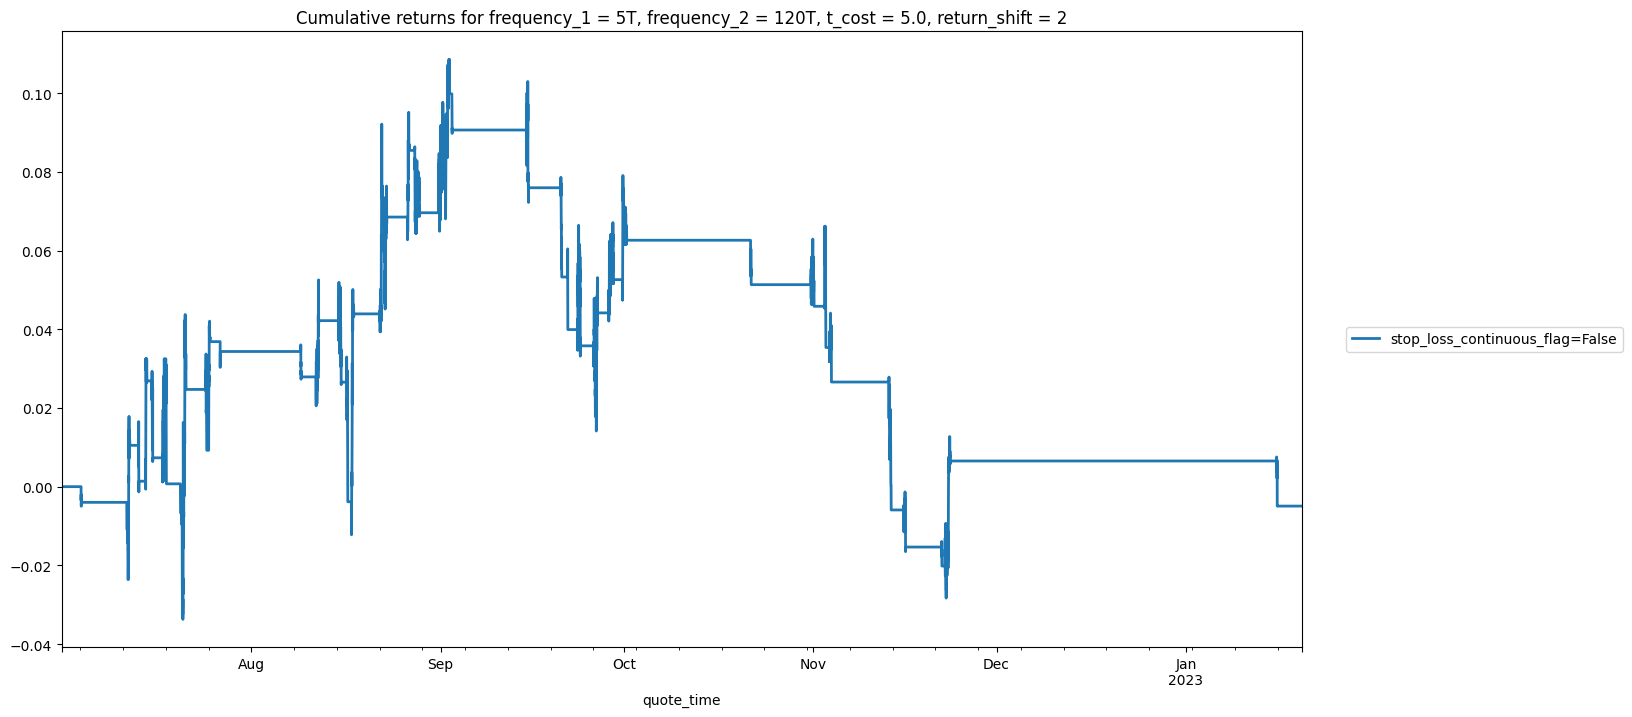

Running time in seconds:  1.9259698390960693


In [ ]:
# start_date = '2020-01-01'
# end_date = '2020-06-02'
start = time.time()

r_0 = 0.0
scale = 365*24*12
frequency_1 = '5T'
frequency_2 = '120T'
stop_loss_frequency = '1T'
exchange = 'HUOBI_FUTURE'

time_span_list = [10,20,30,50,100]  
rolling_window = 7
snr_cutoff = 0.6
t_cost = 0.0005
return_shift = 2

## indicator
snr_stop_flag = True
stop_loss_flag = True
stop_loss_continuous_flag_list = [False]
price_range_filter_flag = True


## indicator values
stop_loss_limit = -0.007
stop_loss_decision_lag = 0
price_range_filter_look_back_window = 200
price_range_lower_limit = 0.0
price_range_upper_limit = 0.057

rsi_take_profit_flag = True
rsi_half_flag = True
rsi_window = 100
rsi_smooth_flag = True
rsi_smooth_window = 10
rsi_upper_limit = 0.9
rsi_lower_limit = 0.1
rsi_smooth_scaler = 1/12

#
atr_take_profit_flag = True
atr_half_flag = True
atr_smooth_window = 22
atr_coef=3

#
atr_filter_flag = True
atr_filter_smooth_window = 200
atr_range_lower_limit = 0.0035
atr_range_upper_limit = 0.004

#
currency='DOT'
currency_volume_breakout_flag=True
currency_volume_span_list = [10,20,30,50,100,150,200]

df_performance_metrics = pd.DataFrame()
##
count = 0
fig, ax = plt.subplots(figsize=(16,8))
for stop_loss_continuous_flag in stop_loss_continuous_flag_list:
    df_res, df = break_out_strategy_single_currency(df_data = df_market_index_in, df_atr = df_ATR_in,df_atr_filter=df_ATR_filter_in,
                                                     time_span_list = time_span_list,exchange=exchange,
                                                  frequency_2 = frequency_2, rolling_window = rolling_window, frequency_1 = frequency_1,                                      
                                                  snr_cutoff = snr_cutoff, t_cost = t_cost, return_shift = return_shift, snr_stop_flag = snr_stop_flag, 
                                                  price_range_filter_flag = price_range_filter_flag,stop_loss_flag = stop_loss_flag,                      
                                                  price_range_lower_limit = price_range_lower_limit,price_range_upper_limit=price_range_upper_limit,     
                                                  stop_loss_limit = stop_loss_limit,stop_loss_decision_lag = stop_loss_decision_lag,
                                                  price_range_filter_look_back_window = price_range_filter_look_back_window,
                                                  rsi_window = rsi_window,rsi_take_profit_flag =rsi_take_profit_flag,rsi_smooth_flag=rsi_smooth_flag,
                                                  rsi_smooth_window = rsi_smooth_window,rsi_upper_limit=rsi_upper_limit,rsi_lower_limit=rsi_lower_limit,
                                                  atr_take_profit_flag = atr_take_profit_flag,atr_smooth_window=atr_smooth_window,atr_coef=atr_coef,
                                                  rsi_smooth_scaler=rsi_smooth_scaler,atr_half_flag=atr_half_flag,rsi_half_flag=rsi_half_flag,
                                                  atr_filter_flag=atr_filter_flag,atr_filter_smooth_window=atr_filter_smooth_window,
                                                  atr_range_upper_limit=atr_range_upper_limit,currency=currency,
                                                  currency_volume_breakout_flag=currency_volume_breakout_flag,stop_loss_frequency=stop_loss_frequency,
                                                  currency_volume_span_list=currency_volume_span_list,stop_loss_continuous_flag=stop_loss_continuous_flag
                                                  )   


    ## plots
    # df_res = df_res[pd.Timestamp('2020-10-01'):]
    df_res['return'].cumsum().plot(ax = ax, lw = 2,label = f'stop_loss_continuous_flag={stop_loss_continuous_flag}')


    ## turnover
    turnover = df_res.position.diff().abs().sum()

    ## total return
    total_return = df_res['return'].sum()

    ## maximum drawdown
    max_drawdown = maximum_drawdown(df_res['return'].dropna().values)


    ## sharpe ratio
    shp_ratio = sharpe_ratio(df_res['return'].dropna().resample('D').sum().values, r_0=0, scale = 365)

    ## performance metrics
    total_return = df_res['return'].sum()
    df_performance_metrics_temp = pd.DataFrame({'sharpe_ratio': shp_ratio,
                                                'return_per_trade': 2*total_return/turnover,
                                                'protfolio turn_over': turnover,
                                                'total_return': total_return,
                                                'max_drawdown':max_drawdown,
                                                'stop_loss_limit':stop_loss_limit,
                                                'stop_loss_continuous_flag':stop_loss_continuous_flag
                                                },
                                                index = [0])

    df_performance_metrics = df_performance_metrics.append(df_performance_metrics_temp, ignore_index=True)

    ##
    end = time.time()
    count +=1
    print('Running time in round {} is: {}s'.format(count, end - start))

## plot title and legend
ax.set_title('Cumulative returns for frequency_1 = {}, frequency_2 = {}, t_cost = {}, return_shift = {}'\
             .format(frequency_1, frequency_2, np.round(t_cost*10000,1), return_shift))
ax.legend(loc = 'center left', bbox_to_anchor=(1.03, 0.5))
plt.show()

# ## performance metrics
# pd.set_option('display.max_columns', 50)
# print(df_performance_metrics)

##
end = time.time()
print('Running time in seconds: ', end - start)

In [ ]:
df_performance_metrics

,sharpe_ratio,return_per_trade,protfolio turn_over,total_return,max_drawdown,stop_loss_limit,stop_loss_continuous_flag
0,-0.057218,-0.000087,114.0,-0.004936,0.136911,-0.007,False


In [ ]:
grouped_net_pnl['time_series_momentum_DOT_5min'] = df_res['return']
grouped_pos['time_series_momentum_DOT_5min'] = df_res['position']

##### SOL

In [ ]:
currency_list = ['SOL']

df_market_index = pd.DataFrame()
df_market_index_volume = pd.DataFrame()
for currency in currency_list:
    filename_temp = op.join(repo_dir, 'df_spot_kline_binance') + '_' + start_date.replace('-','_') + '_to_' + end_date.replace('-','_') + '_' + currency
    if op.exists(filename_temp + '.pkl'): 
        df_temp = load_obj(filename_temp) 
        df_volume_temp = df_temp[['volume']].rename(columns = {'volume':'volume_' + currency})
        df_price_temp = df_temp[['close']].rename(columns = {'close':'close_' + currency})
        df_volume_temp[f'volume_{currency}'] = np.multiply(df_volume_temp.values,df_price_temp.values)
        df_market_index_volume = pd.concat([df_market_index_volume,df_volume_temp], axis=1)
        df_market_index = pd.concat([df_market_index,df_price_temp], axis=1)
        
df_market_index_volume = df_market_index_volume.fillna(0.0).ewm(span=5).mean()
## log(1+volume)
df_market_index_volume = np.log(1+df_market_index_volume)

## market index
df_market_index = df_market_index.fillna(axis=0, method = 'ffill').dropna()
df_market_index = np.log(df_market_index)

##
print(len(df_market_index))
##
df_market_index = pd.concat([df_market_index,df_market_index_volume],axis=1)
##
df_market_index = df_market_index.sort_index()
df_market_index.head()

292320


,close_SOL,volume_SOL
quote_time,,
2022-07-01 00:01:00,3.513931,12.687973
2022-07-01 00:02:00,3.513633,12.881426
2022-07-01 00:03:00,3.511545,12.773005
2022-07-01 00:04:00,3.512441,12.589146
2022-07-01 00:05:00,3.511844,13.114980


In [ ]:
currency_list = ['SOL']
freq = '3T'

## Price Range
df_ATR = pd.DataFrame()
df_market_index_high = pd.DataFrame()
df_market_index_low = pd.DataFrame()
df_market_index_close = pd.DataFrame()
for currency in currency_list:
    filename_temp = op.join(repo_dir, 'df_spot_kline_binance') + '_' + start_date.replace('-','_') + '_to_' + end_date.replace('-','_') + '_' + currency
    if op.exists(filename_temp + '.pkl'): 
        df_temp = load_obj(filename_temp)
        df_price_high_temp = df_temp[['high']].resample(freq).max().rename(columns = {'high':'high_' + currency}).fillna(method='ffill')
        df_price_low_temp = df_temp[['low']].resample(freq).min().rename(columns = {'low':'low_' + currency}).fillna(method='ffill')
        df_price_close_temp = df_temp[['close']].resample(freq).last().rename(columns = {'close':'close_' + currency}).fillna(method='ffill')
        ## 
        df_ATR['high'] = np.log(df_price_high_temp[f'high_{currency}'].fillna(method='ffill'))
        df_ATR['low'] = np.log(df_price_low_temp.fillna(method='ffill'))
        df_ATR['close'] = np.log(df_price_close_temp.fillna(method='ffill'))
        df_ATR[f'market_index_tr_{currency}'] = build_ATR(df_ATR, smooth_window = 1)

df_ATR = df_ATR.drop(['high','low','close'],axis=1)
# df_ATR = df_ATR[pd.Timestamp('2019-04-01'):pd.Timestamp('2019-07-31')]
df_ATR.head(3)

KeyboardInterrupt: ignored

In [ ]:
currency_list = ['SOL']
freq = '5T'

## Price Range
df_ATR_filter = pd.DataFrame()
df_market_index_high = pd.DataFrame()
df_market_index_low = pd.DataFrame()
df_market_index_close = pd.DataFrame()
for currency in currency_list:
    filename_temp = op.join(repo_dir, 'df_spot_kline_binance') + '_' + start_date.replace('-','_') + '_to_' + end_date.replace('-','_') + '_' + currency
    if op.exists(filename_temp + '.pkl'): 
        df_temp = load_obj(filename_temp) 
        df_price_high_temp = df_temp[['high']].resample(freq).max().rename(columns = {'high':'high_' + currency}).fillna(method='ffill')
        df_price_low_temp = df_temp[['low']].resample(freq).min().rename(columns = {'low':'low_' + currency}).fillna(method='ffill')
        df_price_close_temp = df_temp[['close']].resample(freq).last().rename(columns = {'close':'close_' + currency}).fillna(method='ffill')

        df_ATR_filter['high'] = np.log(df_price_high_temp[f'high_{currency}'].fillna(method='ffill'))
        df_ATR_filter['low'] = np.log(df_price_low_temp.fillna(method='ffill'))
        df_ATR_filter['close'] = np.log(df_price_close_temp.fillna(method='ffill'))
        df_ATR_filter[f'market_index_tr_{currency}'] = build_ATR(df_ATR_filter, smooth_window = 1)

# df_ATR_filter = df_ATR_filter[pd.Timestamp('2019-04-01'):pd.Timestamp('2019-07-31')]
df_ATR_filter.head(3)

In [ ]:
df_market_index_in = df_market_index[pd.Timestamp('2020-01-01'):]
df_ATR_in = df_ATR[pd.Timestamp('2020-01-01'):]
df_ATR_filter_in = df_ATR_filter[pd.Timestamp('2020-01-01'):]

###### return series

In [ ]:
# start_date = '2020-01-01'
# end_date = '2020-06-02'
start = time.time()

r_0 = 0.0
scale = 365*24*12
frequency_1 = '5T'
frequency_2 = '120T'
stop_loss_frequency = '1T'
exchange = 'HUOBI_FUTURE'

time_span_list = [10,20,30,50]  
rolling_window = 7
snr_cutoff = 0.6
t_cost = 0.0005
return_shift = 2

## indicator
snr_stop_flag = True
stop_loss_flag = True
stop_loss_continuous_flag = False
price_range_filter_flag = True


## indicator values
stop_loss_limit_list = [-0.01]
stop_loss_decision_lag = 0
price_range_filter_look_back_window = 200
price_range_lower_limit = 0.03
price_range_upper_limit = 0.06

rsi_take_profit_flag = True
rsi_half_flag = True
rsi_window = 100
rsi_smooth_flag = True
rsi_smooth_window = 10
rsi_upper_limit = 0.9
rsi_lower_limit = 0.1
rsi_smooth_scaler = 1/12

#
atr_take_profit_flag = True
atr_half_flag = True
atr_smooth_window = 22
atr_coef=3

#
atr_filter_flag = True
atr_filter_smooth_window = 200
atr_range_lower_limit = 0.0025
atr_range_upper_limit = 0.003

#
currency='SOL'
currency_volume_breakout_flag=True
currency_volume_span_list = [10,20,30,50,100]

df_performance_metrics = pd.DataFrame()
##
count = 0
fig, ax = plt.subplots(figsize=(16,8))
for stop_loss_limit in stop_loss_limit_list:
    df_res, df = break_out_strategy_single_currency(df_data = df_market_index_in, df_atr = df_ATR_in,df_atr_filter=df_ATR_filter_in,
                                                     time_span_list = time_span_list,exchange=exchange,currency=currency,
                                                  frequency_2 = frequency_2, rolling_window = rolling_window, frequency_1 = frequency_1,                                      
                                                  snr_cutoff = snr_cutoff, t_cost = t_cost, return_shift = return_shift, snr_stop_flag = snr_stop_flag, 
                                                  price_range_filter_flag = price_range_filter_flag,stop_loss_flag = stop_loss_flag,                      
                                                  price_range_lower_limit = price_range_lower_limit,price_range_upper_limit=price_range_upper_limit,     
                                                  stop_loss_limit = stop_loss_limit,stop_loss_decision_lag = stop_loss_decision_lag,
                                                  price_range_filter_look_back_window = price_range_filter_look_back_window,
                                                  rsi_window = rsi_window,rsi_take_profit_flag =rsi_take_profit_flag,rsi_smooth_flag=rsi_smooth_flag,
                                                  rsi_smooth_window = rsi_smooth_window,rsi_upper_limit=rsi_upper_limit,rsi_lower_limit=rsi_lower_limit,
                                                  atr_take_profit_flag = atr_take_profit_flag,atr_smooth_window=atr_smooth_window,atr_coef=atr_coef,
                                                  rsi_smooth_scaler=rsi_smooth_scaler,atr_half_flag=atr_half_flag,rsi_half_flag=rsi_half_flag,
                                                  atr_filter_flag=atr_filter_flag,atr_filter_smooth_window=atr_filter_smooth_window,
                                                  atr_range_upper_limit=atr_range_upper_limit,atr_range_lower_limit=atr_range_lower_limit,
                                                  currency_volume_breakout_flag=currency_volume_breakout_flag,stop_loss_frequency=stop_loss_frequency,
                                                  currency_volume_span_list=currency_volume_span_list,stop_loss_continuous_flag=stop_loss_continuous_flag
                                                  )  

    ## plots
    df_res['return'].cumsum().plot(ax = ax, lw = 2,label = f'stop_loss_limit={stop_loss_limit}')


    ## turnover
    turnover = df_res.position.diff().abs().sum()

    ## total return
    total_return = df_res['return'].sum()

    ## maximum drawdown
    max_drawdown = maximum_drawdown(df_res['return'].dropna().values)


    ## sharpe ratio
    shp_ratio = sharpe_ratio(df_res['return'].dropna().resample('D').sum().values, r_0=0, scale = 365)

    ## performance metrics
    total_return = df_res['return'].sum()
    df_performance_metrics_temp = pd.DataFrame({'sharpe_ratio': shp_ratio,
                                                'return_per_trade': 2*total_return/turnover,
                                                'protfolio turn_over': turnover,
                                                'total_return': total_return,
                                                'max_drawdown':max_drawdown,
                                                'stop_loss_limit':stop_loss_limit,
                                                'stop_loss_flag':stop_loss_flag,
                                                'price_range_limit':price_range_upper_limit,
                                                'atr_range_limit':atr_range_upper_limit
                                                },
                                                index = [0])

    df_performance_metrics = df_performance_metrics.append(df_performance_metrics_temp, ignore_index=True)

    ##
    end = time.time()
    count +=1
    print('Running time in round {} is: {}s'.format(count, end - start))

## plot title and legend
ax.set_title('Cumulative returns for signal update frequency = {}'.format(frequency_1))
ax.legend(loc = 'center left', bbox_to_anchor=(1.03, 0.5))
plt.show()

# ## performance metrics
# pd.set_option('display.max_columns', 50)
# print(df_performance_metrics)

##
end = time.time()
print('Running time in seconds: ', end - start)

In [ ]:
df_performance_metrics

In [ ]:
grouped_net_pnl['time_series_momentum_SOL_5min'] = df_res['return']
grouped_pos['time_series_momentum_SOL_5min'] = df_res['position']

##### LINK

In [ ]:
currency_list = ['LINK']

df_market_index = pd.DataFrame()
df_market_index_volume = pd.DataFrame()
for currency in currency_list:
    filename_temp = op.join(repo_dir, 'df_spot_kline_binance') + '_' + start_date.replace('-','_') + '_to_' + end_date.replace('-','_') + '_' + currency
    if op.exists(filename_temp + '.pkl'): 
        df_temp = load_obj(filename_temp) 
        df_volume_temp = df_temp[['volume']].rename(columns = {'volume':'volume_' + currency})
        df_price_temp = df_temp[['close']].rename(columns = {'close':'close_' + currency})
        df_volume_temp[f'volume_{currency}'] = np.multiply(df_volume_temp.values,df_price_temp.values)
        df_market_index_volume = pd.concat([df_market_index_volume,df_volume_temp], axis=1)
        df_market_index = pd.concat([df_market_index,df_price_temp], axis=1)
        
df_market_index_volume = df_market_index_volume.fillna(0.0).ewm(span=5).mean()
## log(1+volume)
df_market_index_volume = np.log(1+df_market_index_volume)

## market index
df_market_index = df_market_index.fillna(axis=0, method = 'ffill').dropna()
df_market_index = np.log(df_market_index)

##
print(len(df_market_index))
##
df_market_index = pd.concat([df_market_index,df_market_index_volume],axis=1)
##
df_market_index = df_market_index.sort_index()
df_market_index.head()

In [ ]:
currency_list = ['LINK']
freq = '3T'

## Price Range
df_ATR = pd.DataFrame()
df_market_index_high = pd.DataFrame()
df_market_index_low = pd.DataFrame()
df_market_index_close = pd.DataFrame()
for currency in currency_list:
    filename_temp = op.join(repo_dir, 'df_spot_kline_binance') + '_' + start_date.replace('-','_') + '_to_' + end_date.replace('-','_') + '_' + currency
    if op.exists(filename_temp + '.pkl'): 
        df_temp = load_obj(filename_temp)
        df_price_high_temp = df_temp[['high']].resample(freq).max().rename(columns = {'high':'high_' + currency}).fillna(method='ffill')
        df_price_low_temp = df_temp[['low']].resample(freq).min().rename(columns = {'low':'low_' + currency}).fillna(method='ffill')
        df_price_close_temp = df_temp[['close']].resample(freq).last().rename(columns = {'close':'close_' + currency}).fillna(method='ffill')
        ## 
        df_ATR['high'] = np.log(df_price_high_temp[f'high_{currency}'].fillna(method='ffill'))
        df_ATR['low'] = np.log(df_price_low_temp.fillna(method='ffill'))
        df_ATR['close'] = np.log(df_price_close_temp.fillna(method='ffill'))
        df_ATR[f'market_index_tr_{currency}'] = build_ATR(df_ATR, smooth_window = 1)

df_ATR = df_ATR.drop(['high','low','close'],axis=1)
# df_ATR = df_ATR[pd.Timestamp('2019-04-01'):pd.Timestamp('2019-07-31')]
df_ATR.head(3)

In [ ]:
currency_list = ['LINK']
freq = '5T'

## Price Range
df_ATR_filter = pd.DataFrame()
df_market_index_high = pd.DataFrame()
df_market_index_low = pd.DataFrame()
df_market_index_close = pd.DataFrame()
for currency in currency_list:
    filename_temp = op.join(repo_dir, 'df_spot_kline_binance') + '_' + start_date.replace('-','_') + '_to_' + end_date.replace('-','_') + '_' + currency
    if op.exists(filename_temp + '.pkl'): 
        df_temp = load_obj(filename_temp) 
        df_price_high_temp = df_temp[['high']].resample(freq).max().rename(columns = {'high':'high_' + currency}).fillna(method='ffill')
        df_price_low_temp = df_temp[['low']].resample(freq).min().rename(columns = {'low':'low_' + currency}).fillna(method='ffill')
        df_price_close_temp = df_temp[['close']].resample(freq).last().rename(columns = {'close':'close_' + currency}).fillna(method='ffill')

        df_ATR_filter['high'] = np.log(df_price_high_temp[f'high_{currency}'].fillna(method='ffill'))
        df_ATR_filter['low'] = np.log(df_price_low_temp.fillna(method='ffill'))
        df_ATR_filter['close'] = np.log(df_price_close_temp.fillna(method='ffill'))
        df_ATR_filter[f'market_index_tr_{currency}'] = build_ATR(df_ATR_filter, smooth_window = 1)

# df_ATR_filter = df_ATR_filter[pd.Timestamp('2019-04-01'):pd.Timestamp('2019-07-31')]
df_ATR_filter.head(3)

In [ ]:
df_market_index_in = df_market_index[pd.Timestamp('2020-01-01'):]
df_ATR_in = df_ATR[pd.Timestamp('2020-01-01'):]
df_ATR_filter_in = df_ATR_filter[pd.Timestamp('2020-01-01'):]

###### return series

In [ ]:
# start_date = '2020-01-01'
# end_date = '2020-06-02'
start = time.time()

r_0 = 0.0
scale = 365*24*12
frequency_1 = '5T'
frequency_2 = '120T'
stop_loss_frequency = '1T'
exchange = 'HUOBI_FUTURE'

time_span_list = [10,20,30,50,100]  
rolling_window = 7
snr_cutoff = 0.6
t_cost = 0.0005
return_shift = 2

## indicator
snr_stop_flag = True
stop_loss_flag = True
stop_loss_continuous_flag_list = [False]
price_range_filter_flag = True


## indicator values
stop_loss_limit = -0.008
stop_loss_decision_lag = 0
price_range_filter_look_back_window = 200
price_range_lower_limit = 0.015
price_range_upper_limit = 0.035

rsi_take_profit_flag = True
rsi_half_flag = True
rsi_window = 100
rsi_smooth_flag = True
rsi_smooth_window = 10
rsi_upper_limit = 0.9
rsi_lower_limit = 0.1
rsi_smooth_scaler = 1/12

#
atr_take_profit_flag = True
atr_half_flag = True
atr_smooth_window = 22
atr_coef=3

#
atr_filter_flag = True
atr_filter_smooth_window = 200
atr_range_lower_limit = 0.004
atr_range_upper_limit = 0.0055

#
currency='LINK'
currency_volume_breakout_flag=True
currency_volume_span_list = [10,20,30,50]

df_performance_metrics = pd.DataFrame()
##
count = 0
fig, ax = plt.subplots(figsize=(16,8))
for stop_loss_continuous_flag in stop_loss_continuous_flag_list:
    df_res, df = break_out_strategy_single_currency(df_data = df_market_index_in, df_atr = df_ATR_in,df_atr_filter=df_ATR_filter_in,
                                                     time_span_list = time_span_list,exchange=exchange,currency=currency,
                                                  frequency_2 = frequency_2, rolling_window = rolling_window, frequency_1 = frequency_1,                                      
                                                  snr_cutoff = snr_cutoff, t_cost = t_cost, return_shift = return_shift, snr_stop_flag = snr_stop_flag,
                                                  price_range_filter_flag = price_range_filter_flag,stop_loss_flag = stop_loss_flag,                      
                                                  price_range_lower_limit = price_range_lower_limit,price_range_upper_limit=price_range_upper_limit,     
                                                  stop_loss_limit = stop_loss_limit,stop_loss_decision_lag = stop_loss_decision_lag,
                                                  price_range_filter_look_back_window = price_range_filter_look_back_window,
                                                  rsi_window = rsi_window,rsi_take_profit_flag =rsi_take_profit_flag,rsi_smooth_flag=rsi_smooth_flag,
                                                  rsi_smooth_window = rsi_smooth_window,rsi_upper_limit=rsi_upper_limit,rsi_lower_limit=rsi_lower_limit,
                                                  atr_take_profit_flag = atr_take_profit_flag,atr_smooth_window=atr_smooth_window,atr_coef=atr_coef,
                                                  rsi_smooth_scaler=rsi_smooth_scaler,atr_half_flag=atr_half_flag,rsi_half_flag=rsi_half_flag,
                                                  atr_filter_flag=atr_filter_flag,atr_filter_smooth_window=atr_filter_smooth_window,
                                                  atr_range_upper_limit=atr_range_upper_limit,atr_range_lower_limit=atr_range_lower_limit,
                                                  currency_volume_breakout_flag=currency_volume_breakout_flag,stop_loss_frequency=stop_loss_frequency,
                                                  currency_volume_span_list=currency_volume_span_list,stop_loss_continuous_flag=stop_loss_continuous_flag
                                                  )  

    ## plots
    # df_res = df_res[pd.Timestamp('2020-10-01'):]
    df_res['return'].cumsum().plot(ax = ax, lw = 2,label = f'stop_loss_continuous_flag={stop_loss_continuous_flag}')


    ## turnover
    turnover = df_res.position.diff().abs().sum()

    ## total return
    total_return = df_res['return'].sum()

    ## maximum drawdown
    max_drawdown = maximum_drawdown(df_res['return'].dropna().values)


    ## sharpe ratio
    shp_ratio = sharpe_ratio(df_res['return'].dropna().resample('D').sum().values, r_0=0, scale = 365)

    ## performance metrics
    total_return = df_res['return'].sum()
    df_performance_metrics_temp = pd.DataFrame({'sharpe_ratio': shp_ratio,
                                                'return_per_trade': 2*total_return/turnover,
                                                'protfolio turn_over': turnover,
                                                'total_return': total_return,
                                                'max_drawdown':max_drawdown,
                                                'stop_loss_limit':stop_loss_limit,
                                                'stop_loss_flag':stop_loss_flag,
                                                'stop_loss_continuous_flag':stop_loss_continuous_flag
                                                },
                                                index = [0])

    df_performance_metrics = df_performance_metrics.append(df_performance_metrics_temp, ignore_index=True)

    ##
    end = time.time()
    count +=1
    print('Running time in round {} is: {}s'.format(count, end - start))

## plot title and legend
ax.set_title('Cumulative returns for signal update frequency = {}'.format(frequency_1))
ax.legend(loc = 'center left', bbox_to_anchor=(1.03, 0.5))
plt.show()

# ## performance metrics
# pd.set_option('display.max_columns', 50)
# print(df_performance_metrics)

##
end = time.time()
print('Running time in seconds: ', end - start)

In [ ]:
df_performance_metrics

In [ ]:
grouped_net_pnl['time_series_momentum_LINK_5min'] = df_res['return']
grouped_pos['time_series_momentum_LINK_5min'] = df_res['position']

##### TRX

In [ ]:
currency_list = ['TRX']

df_market_index = pd.DataFrame()
df_market_index_volume = pd.DataFrame()
for currency in currency_list:
    filename_temp = op.join(repo_dir, 'df_spot_kline_binance') + '_' + start_date.replace('-','_') + '_to_' + end_date.replace('-','_') + '_' + currency
    if op.exists(filename_temp + '.pkl'): 
        df_temp = load_obj(filename_temp) 
        df_volume_temp = df_temp[['volume']].rename(columns = {'volume':'volume_' + currency})
        df_price_temp = df_temp[['close']].rename(columns = {'close':'close_' + currency})
        df_volume_temp[f'volume_{currency}'] = np.multiply(df_volume_temp.values,df_price_temp.values)
        df_market_index_volume = pd.concat([df_market_index_volume,df_volume_temp], axis=1)
        df_market_index = pd.concat([df_market_index,df_price_temp], axis=1)
        
df_market_index_volume = df_market_index_volume.fillna(0.0).ewm(span=5).mean()
## log(1+volume)
df_market_index_volume = np.log(1+df_market_index_volume)

## market index
df_market_index = df_market_index.fillna(axis=0, method = 'ffill').dropna()
df_market_index = np.log(df_market_index)

##
print(len(df_market_index))
##
df_market_index = pd.concat([df_market_index,df_market_index_volume],axis=1)
##
df_market_index = df_market_index.sort_index()
df_market_index.head()

In [ ]:
currency_list = ['TRX']
freq = '3T'

## Price Range
df_ATR = pd.DataFrame()
df_market_index_high = pd.DataFrame()
df_market_index_low = pd.DataFrame()
df_market_index_close = pd.DataFrame()
for currency in currency_list:
    filename_temp = op.join(repo_dir, 'df_spot_kline_binance') + '_' + start_date.replace('-','_') + '_to_' + end_date.replace('-','_') + '_' + currency
    if op.exists(filename_temp + '.pkl'): 
        df_temp = load_obj(filename_temp)
        df_price_high_temp = df_temp[['high']].resample(freq).max().rename(columns = {'high':'high_' + currency}).fillna(method='ffill')
        df_price_low_temp = df_temp[['low']].resample(freq).min().rename(columns = {'low':'low_' + currency}).fillna(method='ffill')
        df_price_close_temp = df_temp[['close']].resample(freq).last().rename(columns = {'close':'close_' + currency}).fillna(method='ffill')
        ## 
        df_ATR['high'] = np.log(df_price_high_temp[f'high_{currency}'].fillna(method='ffill'))
        df_ATR['low'] = np.log(df_price_low_temp.fillna(method='ffill'))
        df_ATR['close'] = np.log(df_price_close_temp.fillna(method='ffill'))
        df_ATR[f'market_index_tr_{currency}'] = build_ATR(df_ATR, smooth_window = 1)

df_ATR = df_ATR.drop(['high','low','close'],axis=1)
# df_ATR = df_ATR[pd.Timestamp('2019-04-01'):pd.Timestamp('2019-07-31')]
df_ATR.head(3)

In [ ]:
currency_list = ['TRX']
freq = '5T'

## Price Range
df_ATR_filter = pd.DataFrame()
df_market_index_high = pd.DataFrame()
df_market_index_low = pd.DataFrame()
df_market_index_close = pd.DataFrame()
for currency in currency_list:
    filename_temp = op.join(repo_dir, 'df_spot_kline_binance') + '_' + start_date.replace('-','_') + '_to_' + end_date.replace('-','_') + '_' + currency
    if op.exists(filename_temp + '.pkl'): 
        df_temp = load_obj(filename_temp) 
        df_price_high_temp = df_temp[['high']].resample(freq).max().rename(columns = {'high':'high_' + currency}).fillna(method='ffill')
        df_price_low_temp = df_temp[['low']].resample(freq).min().rename(columns = {'low':'low_' + currency}).fillna(method='ffill')
        df_price_close_temp = df_temp[['close']].resample(freq).last().rename(columns = {'close':'close_' + currency}).fillna(method='ffill')

        df_ATR_filter['high'] = np.log(df_price_high_temp[f'high_{currency}'].fillna(method='ffill'))
        df_ATR_filter['low'] = np.log(df_price_low_temp.fillna(method='ffill'))
        df_ATR_filter['close'] = np.log(df_price_close_temp.fillna(method='ffill'))
        df_ATR_filter[f'market_index_tr_{currency}'] = build_ATR(df_ATR_filter, smooth_window = 1)

# df_ATR_filter = df_ATR_filter[pd.Timestamp('2019-04-01'):pd.Timestamp('2019-07-31')]
df_ATR_filter.head(3)

In [ ]:
df_market_index_in = df_market_index[pd.Timestamp('2020-01-01'):]
df_ATR_in = df_ATR[pd.Timestamp('2020-01-01'):]
df_ATR_filter_in = df_ATR_filter[pd.Timestamp('2020-01-01'):]

###### return series

In [ ]:
# start_date = '2020-01-01'
# end_date = '2020-06-02'
start = time.time()

r_0 = 0.0
scale = 365*24*12
frequency_1 = '5T'
frequency_2 = '120T'
stop_loss_frequency = '1T'
exchange = 'HUOBI_FUTURE'

time_span_list = [10,20,30]         
rolling_window = 7
snr_cutoff = 0.6
t_cost = 0.0005
return_shift = 2

## indicator
snr_stop_flag = True
stop_loss_flag = True
stop_loss_continuous_flag_list = [False]
price_range_filter_flag = True


## indicator values
stop_loss_limit = -0.015
stop_loss_decision_lag = 0
price_range_filter_look_back_window = 200
price_range_lower_limit = 0.04
price_range_upper_limit = 0.085

rsi_take_profit_flag = True
rsi_half_flag = True
rsi_window = 100
rsi_smooth_flag = True
rsi_smooth_window = 10
rsi_upper_limit = 0.9
rsi_lower_limit = 0.1
rsi_smooth_scaler = 1/12

#
atr_take_profit_flag = True
atr_half_flag = True
atr_smooth_window = 22
atr_coef=3

#
atr_filter_flag = True
atr_filter_smooth_window = 200
atr_range_lower_limit = 0.0
atr_range_upper_limit = 0.004

#
currency='TRX'
currency_volume_breakout_flag=True
currency_volume_span_list = [10,20,30,50,100]

df_performance_metrics = pd.DataFrame()
##
count = 0
fig, ax = plt.subplots(figsize=(16,8))
for stop_loss_continuous_flag in stop_loss_continuous_flag_list:
    df_res, df = break_out_strategy_single_currency(df_data = df_market_index_in, df_atr = df_ATR_in,df_atr_filter=df_ATR_filter_in,
                                                     time_span_list = time_span_list,exchange=exchange,
                                                  frequency_2 = frequency_2, rolling_window = rolling_window, frequency_1 = frequency_1,                                      
                                                  snr_cutoff = snr_cutoff, t_cost = t_cost, return_shift = return_shift, snr_stop_flag = snr_stop_flag,
                                                  price_range_filter_flag = price_range_filter_flag,stop_loss_flag = stop_loss_flag,                      
                                                  price_range_lower_limit = price_range_lower_limit,price_range_upper_limit=price_range_upper_limit,     
                                                  stop_loss_limit = stop_loss_limit,stop_loss_decision_lag = stop_loss_decision_lag,
                                                  price_range_filter_look_back_window = price_range_filter_look_back_window,
                                                  rsi_window = rsi_window,rsi_take_profit_flag =rsi_take_profit_flag,rsi_smooth_flag=rsi_smooth_flag,
                                                  rsi_smooth_window = rsi_smooth_window,rsi_upper_limit=rsi_upper_limit,rsi_lower_limit=rsi_lower_limit,
                                                  atr_take_profit_flag = atr_take_profit_flag,atr_smooth_window=atr_smooth_window,atr_coef=atr_coef,
                                                  rsi_smooth_scaler=rsi_smooth_scaler,atr_half_flag=atr_half_flag,rsi_half_flag=rsi_half_flag,
                                                  atr_filter_flag=atr_filter_flag,atr_filter_smooth_window=atr_filter_smooth_window,
                                                  atr_range_upper_limit=atr_range_upper_limit,currency=currency,
                                                  currency_volume_breakout_flag=currency_volume_breakout_flag,stop_loss_frequency=stop_loss_frequency,
                                                  currency_volume_span_list=currency_volume_span_list,stop_loss_continuous_flag=stop_loss_continuous_flag
                                                  )  

    ## plots
    df_res['return'].cumsum().plot(ax = ax, lw = 2,label = f'stop_loss_continuous_flag={stop_loss_continuous_flag}')


    ## turnover
    turnover = df_res.position.diff().abs().sum()

    ## total return
    total_return = df_res['return'].sum()

    ## maximum drawdown
    max_drawdown = maximum_drawdown(df_res['return'].dropna().values)


    ## sharpe ratio
    shp_ratio = sharpe_ratio(df_res['return'].dropna().resample('D').sum().values, r_0=0, scale = 365)

    ## performance metrics
    total_return = df_res['return'].sum()
    df_performance_metrics_temp = pd.DataFrame({'sharpe_ratio': shp_ratio,
                                                'return_per_trade': 2*total_return/turnover,
                                                'protfolio turn_over': turnover,
                                                'total_return': total_return,
                                                'max_drawdown':max_drawdown,
                                                'stop_loss_limit':stop_loss_limit,
                                                'price_range_limit':price_range_upper_limit,
                                                'stop_loss_continuous_flag':stop_loss_continuous_flag
                                                },
                                                index = [0])

    df_performance_metrics = df_performance_metrics.append(df_performance_metrics_temp, ignore_index=True)

    ##
    end = time.time()
    count +=1
    print('Running time in round {} is: {}s'.format(count, end - start))

## plot title and legend
ax.set_title('Cumulative returns for signal update frequency = {}'.format(frequency_1))
ax.legend(loc = 'center left', bbox_to_anchor=(1.03, 0.5))
plt.show()

# ## performance metrics
# pd.set_option('display.max_columns', 50)
# print(df_performance_metrics)

##
end = time.time()
print('Running time in seconds: ', end - start)

In [ ]:
df_performance_metrics

In [ ]:
grouped_net_pnl['time_series_momentum_TRX_5min'] = df_res['return']
grouped_pos['time_series_momentum_TRX_5min'] = df_res['position']

##### UNI

In [ ]:
currency_list = ['UNI']

df_market_index = pd.DataFrame()
df_market_index_volume = pd.DataFrame()
for currency in currency_list:
    filename_temp = op.join(repo_dir, 'df_spot_kline_binance') + '_' + start_date.replace('-','_') + '_to_' + end_date.replace('-','_') + '_' + currency
    if op.exists(filename_temp + '.pkl'): 
        df_temp = load_obj(filename_temp) 
        df_volume_temp = df_temp[['volume']].rename(columns = {'volume':'volume_' + currency})
        df_price_temp = df_temp[['close']].rename(columns = {'close':'close_' + currency})
        df_volume_temp[f'volume_{currency}'] = np.multiply(df_volume_temp.values,df_price_temp.values)
        df_market_index_volume = pd.concat([df_market_index_volume,df_volume_temp], axis=1)
        df_market_index = pd.concat([df_market_index,df_price_temp], axis=1)
        
df_market_index_volume = df_market_index_volume.fillna(0.0).ewm(span=5).mean()
## log(1+volume)
df_market_index_volume = np.log(1+df_market_index_volume)

## market index
df_market_index = df_market_index.fillna(axis=0, method = 'ffill').dropna()
df_market_index = np.log(df_market_index)

##
print(len(df_market_index))
##
df_market_index = pd.concat([df_market_index,df_market_index_volume],axis=1)
##
df_market_index = df_market_index.sort_index()
df_market_index.head()

In [ ]:
currency_list = ['UNI']
freq = '3T'

## Price Range
df_ATR = pd.DataFrame()
df_market_index_high = pd.DataFrame()
df_market_index_low = pd.DataFrame()
df_market_index_close = pd.DataFrame()
for currency in currency_list:
    filename_temp = op.join(repo_dir, 'df_spot_kline_binance') + '_' + start_date.replace('-','_') + '_to_' + end_date.replace('-','_') + '_' + currency
    if op.exists(filename_temp + '.pkl'): 
        df_temp = load_obj(filename_temp)
        df_price_high_temp = df_temp[['high']].resample(freq).max().rename(columns = {'high':'high_' + currency}).fillna(method='ffill')
        df_price_low_temp = df_temp[['low']].resample(freq).min().rename(columns = {'low':'low_' + currency}).fillna(method='ffill')
        df_price_close_temp = df_temp[['close']].resample(freq).last().rename(columns = {'close':'close_' + currency}).fillna(method='ffill')
        ## 
        df_ATR['high'] = np.log(df_price_high_temp[f'high_{currency}'].fillna(method='ffill'))
        df_ATR['low'] = np.log(df_price_low_temp.fillna(method='ffill'))
        df_ATR['close'] = np.log(df_price_close_temp.fillna(method='ffill'))
        df_ATR[f'market_index_tr_{currency}'] = build_ATR(df_ATR, smooth_window = 1)

df_ATR = df_ATR.drop(['high','low','close'],axis=1)
# df_ATR = df_ATR[pd.Timestamp('2019-04-01'):pd.Timestamp('2019-07-31')]
df_ATR.head(3)

In [ ]:
currency_list = ['UNI']
freq = '5T'

## Price Range
df_ATR_filter = pd.DataFrame()
df_market_index_high = pd.DataFrame()
df_market_index_low = pd.DataFrame()
df_market_index_close = pd.DataFrame()
for currency in currency_list:
    filename_temp = op.join(repo_dir, 'df_spot_kline_binance') + '_' + start_date.replace('-','_') + '_to_' + end_date.replace('-','_') + '_' + currency
    if op.exists(filename_temp + '.pkl'): 
        df_temp = load_obj(filename_temp) 
        df_price_high_temp = df_temp[['high']].resample(freq).max().rename(columns = {'high':'high_' + currency}).fillna(method='ffill')
        df_price_low_temp = df_temp[['low']].resample(freq).min().rename(columns = {'low':'low_' + currency}).fillna(method='ffill')
        df_price_close_temp = df_temp[['close']].resample(freq).last().rename(columns = {'close':'close_' + currency}).fillna(method='ffill')

        df_ATR_filter['high'] = np.log(df_price_high_temp[f'high_{currency}'].fillna(method='ffill'))
        df_ATR_filter['low'] = np.log(df_price_low_temp.fillna(method='ffill'))
        df_ATR_filter['close'] = np.log(df_price_close_temp.fillna(method='ffill'))
        df_ATR_filter[f'market_index_tr_{currency}'] = build_ATR(df_ATR_filter, smooth_window = 1)

# df_ATR_filter = df_ATR_filter[pd.Timestamp('2019-04-01'):pd.Timestamp('2019-07-31')]
df_ATR_filter.head(3)

In [ ]:
df_market_index_in = df_market_index[pd.Timestamp('2020-01-01'):]
df_ATR_in = df_ATR[pd.Timestamp('2020-01-01'):]
df_ATR_filter_in = df_ATR_filter[pd.Timestamp('2020-01-01'):]

###### return series

In [ ]:
# start_date = '2020-01-01'
# end_date = '2020-06-02'
start = time.time()

r_0 = 0.0
scale = 365*24*12
frequency_1 = '5T'
frequency_2 = '120T'
stop_loss_frequency = '1T'
exchange = 'HUOBI_FUTURE'

time_span_list = [10,20,30,50,100]  
rolling_window = 7
snr_cutoff = 0.6
t_cost = 0.0005
return_shift = 2

## indicator
snr_stop_flag = True
stop_loss_flag = True
stop_loss_continuous_flag = False
price_range_filter_flag = True


## indicator values
stop_loss_limit = -0.015
stop_loss_decision_lag = 0
price_range_filter_look_back_window = 200
price_range_lower_limit = 0.035
price_range_upper_limit = 0.08

rsi_take_profit_flag = True
rsi_half_flag = True
rsi_window = 100
rsi_smooth_flag = True
rsi_smooth_window = 10
rsi_upper_limit = 0.9
rsi_lower_limit = 0.1
rsi_smooth_scaler = 1/12

#
atr_take_profit_flag = True
atr_half_flag = True
atr_smooth_window = 22
atr_coef=3

#
atr_filter_flag = True
atr_filter_smooth_window = 200
atr_range_lower_limit = 0.004
atr_range_upper_limit_list = [0.0055]

#
currency='UNI'
currency_volume_breakout_flag=True
currency_volume_span_list = [10,20,30,50,100,150]

df_performance_metrics = pd.DataFrame()
##
count = 0
fig, ax = plt.subplots(figsize=(16,8))
for atr_range_upper_limit in atr_range_upper_limit_list:
    df_res, df = break_out_strategy_single_currency(df_data = df_market_index_in, df_atr = df_ATR_in,df_atr_filter=df_ATR_filter_in,
                                                     time_span_list = time_span_list,exchange=exchange,currency=currency,
                                                  frequency_2 = frequency_2, rolling_window = rolling_window, frequency_1 = frequency_1,                                      
                                                  snr_cutoff = snr_cutoff, t_cost = t_cost, return_shift = return_shift, snr_stop_flag = snr_stop_flag, 
                                                  price_range_filter_flag = price_range_filter_flag,stop_loss_flag = stop_loss_flag,                      
                                                  price_range_lower_limit = price_range_lower_limit,price_range_upper_limit=price_range_upper_limit,     
                                                  stop_loss_limit = stop_loss_limit,stop_loss_decision_lag = stop_loss_decision_lag,
                                                  price_range_filter_look_back_window = price_range_filter_look_back_window,
                                                  rsi_window = rsi_window,rsi_take_profit_flag =rsi_take_profit_flag,rsi_smooth_flag=rsi_smooth_flag,
                                                  rsi_smooth_window = rsi_smooth_window,rsi_upper_limit=rsi_upper_limit,rsi_lower_limit=rsi_lower_limit,
                                                  atr_take_profit_flag = atr_take_profit_flag,atr_smooth_window=atr_smooth_window,atr_coef=atr_coef,
                                                  rsi_smooth_scaler=rsi_smooth_scaler,atr_half_flag=atr_half_flag,rsi_half_flag=rsi_half_flag,
                                                  atr_filter_flag=atr_filter_flag,atr_filter_smooth_window=atr_filter_smooth_window,
                                                  atr_range_upper_limit=atr_range_upper_limit,atr_range_lower_limit=atr_range_lower_limit,
                                                  currency_volume_breakout_flag=currency_volume_breakout_flag,stop_loss_frequency=stop_loss_frequency,
                                                  currency_volume_span_list=currency_volume_span_list,stop_loss_continuous_flag=stop_loss_continuous_flag
                                                  ) 

    ## plots
    # df_res = df_res[pd.Timestamp('2020-10-01'):]
    df_res['return'].cumsum().plot(ax = ax, lw = 2,label = f'atr_range_upper_limit={atr_range_upper_limit}')


    ## turnover
    turnover = df_res.position.diff().abs().sum()

    ## total return
    total_return = df_res['return'].sum()

    ## maximum drawdown
    max_drawdown = maximum_drawdown(df_res['return'].dropna().values)


    ## sharpe ratio
    shp_ratio = sharpe_ratio(df_res['return'].dropna().resample('D').sum().values, r_0=0, scale = 365)

    ## performance metrics
    total_return = df_res['return'].sum()
    df_performance_metrics_temp = pd.DataFrame({'sharpe_ratio': shp_ratio,
                                                'return_per_trade': 2*total_return/turnover,
                                                'protfolio turn_over': turnover,
                                                'total_return': total_return,
                                                'max_drawdown':max_drawdown,
                                                'stop_loss_limit':stop_loss_limit,
                                                'price_range_limit':price_range_upper_limit,
                                                'atr_range_limit':atr_range_upper_limit
                                                },
                                                index = [0])

    df_performance_metrics = df_performance_metrics.append(df_performance_metrics_temp, ignore_index=True)

    ##
    end = time.time()
    count +=1
    print('Running time in round {} is: {}s'.format(count, end - start))

## plot title and legend
ax.set_title('Cumulative returns for frequency_1 = {}, frequency_2 = {}, t_cost = {}, return_shift = {}'\
             .format(frequency_1, frequency_2, np.round(t_cost*10000,1), return_shift))
ax.legend(loc = 'center left', bbox_to_anchor=(1.03, 0.5))
plt.show()

# ## performance metrics
# pd.set_option('display.max_columns', 50)
# print(df_performance_metrics)

##
end = time.time()
print('Running time in seconds: ', end - start)

In [ ]:
df_performance_metrics

In [ ]:
grouped_net_pnl['time_series_momentum_UNI_5min'] = df_res['return']
grouped_pos['time_series_momentum_UNI_5min'] = df_res['position']

##### SUSHI

In [ ]:
currency_list = ['SUSHI']

df_market_index = pd.DataFrame()
df_market_index_volume = pd.DataFrame()
for currency in currency_list:
    filename_temp = op.join(repo_dir, 'df_spot_kline_binance') + '_' + start_date.replace('-','_') + '_to_' + end_date.replace('-','_') + '_' + currency
    if op.exists(filename_temp + '.pkl'): 
        df_temp = load_obj(filename_temp) 
        df_volume_temp = df_temp[['volume']].rename(columns = {'volume':'volume_' + currency})
        df_price_temp = df_temp[['close']].rename(columns = {'close':'close_' + currency})
        df_volume_temp[f'volume_{currency}'] = np.multiply(df_volume_temp.values,df_price_temp.values)
        df_market_index_volume = pd.concat([df_market_index_volume,df_volume_temp], axis=1)
        df_market_index = pd.concat([df_market_index,df_price_temp], axis=1)
        
df_market_index_volume = df_market_index_volume.fillna(0.0).ewm(span=5).mean()
## log(1+volume)
df_market_index_volume = np.log(1+df_market_index_volume)
## market index
df_market_index = df_market_index.fillna(axis=0, method = 'ffill').dropna()
df_market_index = np.log(df_market_index)

##
print(len(df_market_index))
##
df_market_index = pd.concat([df_market_index,df_market_index_volume],axis=1)
##
df_market_index = df_market_index.sort_index()
df_market_index.head()

In [ ]:
currency_list = ['SUSHI']
freq = '3T'

## Price Range
df_ATR = pd.DataFrame()
df_market_index_high = pd.DataFrame()
df_market_index_low = pd.DataFrame()
df_market_index_close = pd.DataFrame()
for currency in currency_list:
    filename_temp = op.join(repo_dir, 'df_spot_kline_binance') + '_' + start_date.replace('-','_') + '_to_' + end_date.replace('-','_') + '_' + currency
    if op.exists(filename_temp + '.pkl'): 
        df_temp = load_obj(filename_temp)
        df_price_high_temp = df_temp[['high']].resample(freq).max().rename(columns = {'high':'high_' + currency}).fillna(method='ffill')
        df_price_low_temp = df_temp[['low']].resample(freq).min().rename(columns = {'low':'low_' + currency}).fillna(method='ffill')
        df_price_close_temp = df_temp[['close']].resample(freq).last().rename(columns = {'close':'close_' + currency}).fillna(method='ffill')
        ## 
        df_ATR['high'] = np.log(df_price_high_temp[f'high_{currency}'].fillna(method='ffill'))
        df_ATR['low'] = np.log(df_price_low_temp.fillna(method='ffill'))
        df_ATR['close'] = np.log(df_price_close_temp.fillna(method='ffill'))
        df_ATR[f'market_index_tr_{currency}'] = build_ATR(df_ATR, smooth_window = 1)

df_ATR = df_ATR.drop(['high','low','close'],axis=1)
# df_ATR = df_ATR[pd.Timestamp('2019-04-01'):pd.Timestamp('2019-07-31')]
df_ATR.head(3)

In [ ]:
currency_list = ['SUSHI']
freq = '5T'

## Price Range
df_ATR_filter = pd.DataFrame()
df_market_index_high = pd.DataFrame()
df_market_index_low = pd.DataFrame()
df_market_index_close = pd.DataFrame()
for currency in currency_list:
    filename_temp = op.join(repo_dir, 'df_spot_kline_binance') + '_' + start_date.replace('-','_') + '_to_' + end_date.replace('-','_') + '_' + currency
    if op.exists(filename_temp + '.pkl'): 
        df_temp = load_obj(filename_temp) 
        df_price_high_temp = df_temp[['high']].resample(freq).max().rename(columns = {'high':'high_' + currency}).fillna(method='ffill')
        df_price_low_temp = df_temp[['low']].resample(freq).min().rename(columns = {'low':'low_' + currency}).fillna(method='ffill')
        df_price_close_temp = df_temp[['close']].resample(freq).last().rename(columns = {'close':'close_' + currency}).fillna(method='ffill')

        df_ATR_filter['high'] = np.log(df_price_high_temp[f'high_{currency}'].fillna(method='ffill'))
        df_ATR_filter['low'] = np.log(df_price_low_temp.fillna(method='ffill'))
        df_ATR_filter['close'] = np.log(df_price_close_temp.fillna(method='ffill'))
        df_ATR_filter[f'market_index_tr_{currency}'] = build_ATR(df_ATR_filter, smooth_window = 1)

# df_ATR_filter = df_ATR_filter[pd.Timestamp('2019-04-01'):pd.Timestamp('2019-07-31')]
df_ATR_filter.head(3)

In [ ]:
df_market_index_in = df_market_index[pd.Timestamp('2020-01-01'):]
df_ATR_in = df_ATR[pd.Timestamp('2020-01-01'):]
df_ATR_filter_in = df_ATR_filter[pd.Timestamp('2020-01-01'):]

###### return series

In [ ]:
# start_date = '2020-01-01'
# end_date = '2020-06-02'
start = time.time()

r_0 = 0.0
scale = 365*24*12
frequency_1 = '5T'
frequency_2 = '120T'
stop_loss_frequency = '1T'
exchange = 'HUOBI_FUTURE'

time_span_list = [10,20,30,50]       
rolling_window = 7
snr_cutoff = 0.6
t_cost = 0.0005
return_shift = 2

## indicator
snr_stop_flag = True
stop_loss_flag = True
stop_loss_continuous_flag_list = [False]
price_range_filter_flag = True


## indicator values
stop_loss_limit = -0.007
stop_loss_decision_lag = 0
price_range_filter_look_back_window = 200
price_range_lower_limit = 0.05
price_range_upper_limit = 0.065

rsi_take_profit_flag = True
rsi_half_flag = True
rsi_window = 100
rsi_smooth_flag = True
rsi_smooth_window = 10
rsi_upper_limit = 0.9
rsi_lower_limit = 0.1
rsi_smooth_scaler = 1/12

#
atr_take_profit_flag = True
atr_half_flag = True
atr_smooth_window = 22
atr_coef=3

#
atr_filter_flag = True
atr_filter_smooth_window = 200
atr_range_lower_limit = 0.0035
atr_range_upper_limit = 0.004

#
currency='SUSHI'
currency_volume_breakout_flag=True
currency_volume_span_list = [10,20,30,50,100]

df_performance_metrics = pd.DataFrame()
##
count = 0
fig, ax = plt.subplots(figsize=(16,8))
for stop_loss_continuous_flag in stop_loss_continuous_flag_list:
    df_res, df = break_out_strategy_single_currency(df_data = df_market_index_in, df_atr = df_ATR_in,df_atr_filter=df_ATR_filter_in,
                                                     time_span_list = time_span_list,exchange=exchange,
                                                  frequency_2 = frequency_2, rolling_window = rolling_window, frequency_1 = frequency_1,                                      
                                                  snr_cutoff = snr_cutoff, t_cost = t_cost, return_shift = return_shift, snr_stop_flag = snr_stop_flag,
                                                  price_range_filter_flag = price_range_filter_flag,stop_loss_flag = stop_loss_flag,                      
                                                  price_range_lower_limit = price_range_lower_limit,price_range_upper_limit=price_range_upper_limit,     
                                                  stop_loss_limit = stop_loss_limit,stop_loss_decision_lag = stop_loss_decision_lag,
                                                  price_range_filter_look_back_window = price_range_filter_look_back_window,
                                                  rsi_window = rsi_window,rsi_take_profit_flag =rsi_take_profit_flag,rsi_smooth_flag=rsi_smooth_flag,
                                                  rsi_smooth_window = rsi_smooth_window,rsi_upper_limit=rsi_upper_limit,rsi_lower_limit=rsi_lower_limit,
                                                  atr_take_profit_flag = atr_take_profit_flag,atr_smooth_window=atr_smooth_window,atr_coef=atr_coef,
                                                  rsi_smooth_scaler=rsi_smooth_scaler,atr_half_flag=atr_half_flag,rsi_half_flag=rsi_half_flag,
                                                  atr_filter_flag=atr_filter_flag,atr_filter_smooth_window=atr_filter_smooth_window,
                                                  atr_range_upper_limit=atr_range_upper_limit,currency=currency,
                                                  currency_volume_breakout_flag=currency_volume_breakout_flag,stop_loss_frequency=stop_loss_frequency,
                                                  currency_volume_span_list=currency_volume_span_list,stop_loss_continuous_flag=stop_loss_continuous_flag
                                                  ) 

    ## plots
    # df_res = df_res[pd.Timestamp('2020-10-01'):]
    df_res['return'].cumsum().plot(ax = ax, lw = 2,label = f'stop_loss_continuous_flag={stop_loss_continuous_flag}')


    ## turnover
    turnover = df_res.position.diff().abs().sum()

    ## total return
    total_return = df_res['return'].sum()

    ## maximum drawdown
    max_drawdown = maximum_drawdown(df_res['return'].dropna().values)


    ## sharpe ratio
    shp_ratio = sharpe_ratio(df_res['return'].dropna().resample('D').sum().values, r_0=0, scale = 365)

    ## performance metrics
    total_return = df_res['return'].sum()
    df_performance_metrics_temp = pd.DataFrame({'sharpe_ratio': shp_ratio,
                                                'return_per_trade': 2*total_return/turnover,
                                                'protfolio turn_over': turnover,
                                                'total_return': total_return,
                                                'max_drawdown':max_drawdown,
                                                'stop_loss_limit':stop_loss_limit,
                                                'stop_loss_continuous_flag':stop_loss_continuous_flag
                                                },
                                                index = [0])

    df_performance_metrics = df_performance_metrics.append(df_performance_metrics_temp, ignore_index=True)

    ##
    end = time.time()
    count +=1
    print('Running time in round {} is: {}s'.format(count, end - start))

## plot title and legend
ax.set_title('Cumulative returns for frequency_1 = {}, frequency_2 = {}, t_cost = {}, return_shift = {}'\
             .format(frequency_1, frequency_2, np.round(t_cost*10000,1), return_shift))
ax.legend(loc = 'center left', bbox_to_anchor=(1.03, 0.5))
plt.show()

# ## performance metrics
# pd.set_option('display.max_columns', 50)
# print(df_performance_metrics)

##
end = time.time()
print('Running time in seconds: ', end - start)

In [ ]:
df_performance_metrics

In [ ]:
grouped_net_pnl['time_series_momentum_SUSHI_5min'] = df_res['return']
grouped_pos['time_series_momentum_SUSHI_5min'] = df_res['position']

##### BNB

In [ ]:
currency_list = ['BNB']

df_market_index = pd.DataFrame()
df_market_index_volume = pd.DataFrame()
for currency in currency_list:
    filename_temp = op.join(repo_dir, 'df_spot_kline_binance') + '_' + start_date.replace('-','_') + '_to_' + end_date.replace('-','_') + '_' + currency
    if op.exists(filename_temp + '.pkl'): 
        df_temp = load_obj(filename_temp) 
        df_volume_temp = df_temp[['volume']].rename(columns = {'volume':'volume_' + currency})
        df_price_temp = df_temp[['close']].rename(columns = {'close':'close_' + currency})
        df_volume_temp[f'volume_{currency}'] = np.multiply(df_volume_temp.values,df_price_temp.values)
        df_market_index_volume = pd.concat([df_market_index_volume,df_volume_temp], axis=1)
        df_market_index = pd.concat([df_market_index,df_price_temp], axis=1)
        
df_market_index_volume = df_market_index_volume.fillna(0.0).ewm(span=5).mean()
## log(1+volume)
df_market_index_volume = np.log(1+df_market_index_volume)

## market index
df_market_index = df_market_index.fillna(axis=0, method = 'ffill').dropna()
df_market_index = np.log(df_market_index)

##
print(len(df_market_index))
df_market_index = pd.concat([df_market_index,df_market_index_volume],axis=1)
##
df_market_index = df_market_index.sort_index()
df_market_index.head()

In [ ]:
currency_list = ['BNB']
freq = '3T'

## Price Range
df_ATR = pd.DataFrame()
df_market_index_high = pd.DataFrame()
df_market_index_low = pd.DataFrame()
df_market_index_close = pd.DataFrame()
for currency in currency_list:
    filename_temp = op.join(repo_dir, 'df_spot_kline_binance') + '_' + start_date.replace('-','_') + '_to_' + end_date.replace('-','_') + '_' + currency
    if op.exists(filename_temp + '.pkl'): 
        df_temp = load_obj(filename_temp)
        df_price_high_temp = df_temp[['high']].resample(freq).max().rename(columns = {'high':'high_' + currency}).fillna(method='ffill')
        df_price_low_temp = df_temp[['low']].resample(freq).min().rename(columns = {'low':'low_' + currency}).fillna(method='ffill')
        df_price_close_temp = df_temp[['close']].resample(freq).last().rename(columns = {'close':'close_' + currency}).fillna(method='ffill')
        ## 
        df_ATR['high'] = np.log(df_price_high_temp[f'high_{currency}'].fillna(method='ffill'))
        df_ATR['low'] = np.log(df_price_low_temp.fillna(method='ffill'))
        df_ATR['close'] = np.log(df_price_close_temp.fillna(method='ffill'))
        df_ATR[f'market_index_tr_{currency}'] = build_ATR(df_ATR, smooth_window = 1)

df_ATR = df_ATR.drop(['high','low','close'],axis=1)
# df_ATR = df_ATR[pd.Timestamp('2019-04-01'):pd.Timestamp('2019-07-31')]
df_ATR.head(3)

In [ ]:
currency_list = ['BNB']
freq = '5T'

## Price Range
df_ATR_filter = pd.DataFrame()
df_market_index_high = pd.DataFrame()
df_market_index_low = pd.DataFrame()
df_market_index_close = pd.DataFrame()
for currency in currency_list:
    filename_temp = op.join(repo_dir, 'df_spot_kline_binance') + '_' + start_date.replace('-','_') + '_to_' + end_date.replace('-','_') + '_' + currency
    if op.exists(filename_temp + '.pkl'): 
        df_temp = load_obj(filename_temp) 
        df_price_high_temp = df_temp[['high']].resample(freq).max().rename(columns = {'high':'high_' + currency}).fillna(method='ffill')
        df_price_low_temp = df_temp[['low']].resample(freq).min().rename(columns = {'low':'low_' + currency}).fillna(method='ffill')
        df_price_close_temp = df_temp[['close']].resample(freq).last().rename(columns = {'close':'close_' + currency}).fillna(method='ffill')

        df_ATR_filter['high'] = np.log(df_price_high_temp[f'high_{currency}'].fillna(method='ffill'))
        df_ATR_filter['low'] = np.log(df_price_low_temp.fillna(method='ffill'))
        df_ATR_filter['close'] = np.log(df_price_close_temp.fillna(method='ffill'))
        df_ATR_filter[f'market_index_tr_{currency}'] = build_ATR(df_ATR_filter, smooth_window = 1)

# df_ATR_filter = df_ATR_filter[pd.Timestamp('2019-04-01'):pd.Timestamp('2019-07-31')]
df_ATR_filter.head(3)

In [ ]:
df_market_index_in = df_market_index[pd.Timestamp('2020-01-01'):]
df_ATR_in = df_ATR[pd.Timestamp('2020-01-01'):]
df_ATR_filter_in = df_ATR_filter[pd.Timestamp('2020-01-01'):]

###### return series

In [ ]:
# start_date = '2020-01-01'
# end_date = '2020-06-02'
start = time.time()

r_0 = 0.0
scale = 365*24*12
frequency_1 = '5T'
frequency_2 = '120T'
stop_loss_frequency = '1T'
exchange = 'HUOBI_FUTURE'

time_span_list = [10,20,30,50,100,150]       
rolling_window = 7
snr_cutoff = 0.6
t_cost = 0.0005
return_shift = 2

## indicator
snr_stop_flag = True
stop_loss_flag = True
stop_loss_continuous_flag_list = [False]
price_range_filter_flag = True


## indicator values
stop_loss_limit = -0.01
stop_loss_decision_lag = 0
price_range_filter_look_back_window = 200
price_range_lower_limit = 0.0
price_range_upper_limit = 0.035

rsi_take_profit_flag = True
rsi_half_flag = True
rsi_window = 100
rsi_smooth_flag = True
rsi_smooth_window = 10
rsi_upper_limit = 0.9
rsi_lower_limit = 0.1
rsi_smooth_scaler = 1/12

#
atr_take_profit_flag = True
atr_half_flag = True
atr_smooth_window = 22
atr_coef=3

#
atr_filter_flag = True
atr_filter_smooth_window = 200
atr_range_lower_limit = 0.0021
atr_range_upper_limit = 0.0024

#
currency='BNB'
currency_volume_breakout_flag=True
currency_volume_span_list = [10,20,30]

df_performance_metrics = pd.DataFrame()
##
count = 0
fig, ax = plt.subplots(figsize=(16,8))
for stop_loss_continuous_flag in stop_loss_continuous_flag_list:
    df_res, df = break_out_strategy_single_currency(df_data = df_market_index_in, df_atr = df_ATR_in,df_atr_filter=df_ATR_filter_in,
                                                     time_span_list = time_span_list,exchange=exchange,currency=currency,
                                                  frequency_2 = frequency_2, rolling_window = rolling_window, frequency_1 = frequency_1,                                      
                                                  snr_cutoff = snr_cutoff, t_cost = t_cost, return_shift = return_shift, snr_stop_flag = snr_stop_flag,
                                                  price_range_filter_flag = price_range_filter_flag,stop_loss_flag = stop_loss_flag,                      
                                                  price_range_lower_limit = price_range_lower_limit,price_range_upper_limit=price_range_upper_limit,     
                                                  stop_loss_limit = stop_loss_limit,stop_loss_decision_lag = stop_loss_decision_lag,
                                                  price_range_filter_look_back_window = price_range_filter_look_back_window,
                                                  rsi_window = rsi_window,rsi_take_profit_flag =rsi_take_profit_flag,rsi_smooth_flag=rsi_smooth_flag,
                                                  rsi_smooth_window = rsi_smooth_window,rsi_upper_limit=rsi_upper_limit,rsi_lower_limit=rsi_lower_limit,
                                                  atr_take_profit_flag = atr_take_profit_flag,atr_smooth_window=atr_smooth_window,atr_coef=atr_coef,
                                                  rsi_smooth_scaler=rsi_smooth_scaler,atr_half_flag=atr_half_flag,rsi_half_flag=rsi_half_flag,
                                                  atr_filter_flag=atr_filter_flag,atr_filter_smooth_window=atr_filter_smooth_window,
                                                  atr_range_upper_limit=atr_range_upper_limit,atr_range_lower_limit=atr_range_lower_limit,
                                                  currency_volume_breakout_flag=currency_volume_breakout_flag,stop_loss_frequency=stop_loss_frequency,
                                                  currency_volume_span_list=currency_volume_span_list,stop_loss_continuous_flag=stop_loss_continuous_flag
                                                  ) 

    ## plots
    # df_res = df_res[pd.Timestamp('2020-10-01'):]
    df_res['return'].cumsum().plot(ax = ax, lw = 2,label = f'stop_loss_continuous_flag={stop_loss_continuous_flag}')


    ## turnover
    turnover = df_res.position.diff().abs().sum()

    ## total return
    total_return = df_res['return'].sum()

    ## maximum drawdown
    max_drawdown = maximum_drawdown(df_res['return'].dropna().values)


    ## sharpe ratio
    shp_ratio = sharpe_ratio(df_res['return'].dropna().resample('D').sum().values, r_0=0, scale = 365)

    ## performance metrics
    total_return = df_res['return'].sum()
    df_performance_metrics_temp = pd.DataFrame({'sharpe_ratio': shp_ratio,
                                                'return_per_trade': 2*total_return/turnover,
                                                'protfolio turn_over': turnover,
                                                'total_return': total_return,
                                                'max_drawdown':max_drawdown,
                                                'stop_loss_limit':stop_loss_limit,
                                                'stop_loss_continuous_flag':stop_loss_continuous_flag
                                                },
                                                index = [0])

    df_performance_metrics = df_performance_metrics.append(df_performance_metrics_temp, ignore_index=True)

    ##
    end = time.time()
    count +=1
    print('Running time in round {} is: {}s'.format(count, end - start))

## plot title and legend
ax.set_title('Cumulative returns for frequency_1 = {}, frequency_2 = {}, t_cost = {}, return_shift = {}'\
             .format(frequency_1, frequency_2, np.round(t_cost*10000,1), return_shift))
ax.legend(loc = 'center left', bbox_to_anchor=(1.03, 0.5))
plt.show()

# ## performance metrics
# pd.set_option('display.max_columns', 50)
# print(df_performance_metrics)

##
end = time.time()
print('Running time in seconds: ', end - start)

In [ ]:
df_performance_metrics

In [ ]:
grouped_net_pnl['time_series_momentum_BNB_5min'] = df_res['return']
grouped_pos['time_series_momentum_BNB_5min'] = df_res['position']

##### NEAR

In [ ]:
currency_list = ['NEAR']

df_market_index = pd.DataFrame()
df_market_index_volume = pd.DataFrame()
for currency in currency_list:
    filename_temp = op.join(repo_dir, 'df_spot_kline_binance') + '_' + start_date.replace('-','_') + '_to_' + end_date.replace('-','_') + '_' + currency
    if op.exists(filename_temp + '.pkl'): 
        df_temp = load_obj(filename_temp) 
        df_volume_temp = df_temp[['volume']].rename(columns = {'volume':'volume_' + currency})
        df_price_temp = df_temp[['close']].rename(columns = {'close':'close_' + currency})
        df_volume_temp[f'volume_{currency}'] = np.multiply(df_volume_temp.values,df_price_temp.values)
        df_market_index_volume = pd.concat([df_market_index_volume,df_volume_temp], axis=1)
        df_market_index = pd.concat([df_market_index,df_price_temp], axis=1)
        
df_market_index_volume = df_market_index_volume.fillna(0.0).ewm(span=5).mean()
## log(1+volume)
df_market_index_volume = np.log(1+df_market_index_volume)

## market index
df_market_index = df_market_index.fillna(axis=0, method = 'ffill').dropna()
df_market_index = np.log(df_market_index)

##
print(len(df_market_index))
df_market_index = pd.concat([df_market_index,df_market_index_volume],axis=1)
##
df_market_index = df_market_index.sort_index()
df_market_index.head()

In [ ]:
currency_list = ['NEAR']
freq = '3T'

## Price Range
df_ATR = pd.DataFrame()
df_market_index_high = pd.DataFrame()
df_market_index_low = pd.DataFrame()
df_market_index_close = pd.DataFrame()
for currency in currency_list:
    filename_temp = op.join(repo_dir, 'df_spot_kline_binance') + '_' + start_date.replace('-','_') + '_to_' + end_date.replace('-','_') + '_' + currency
    if op.exists(filename_temp + '.pkl'): 
        df_temp = load_obj(filename_temp)
        df_price_high_temp = df_temp[['high']].resample(freq).max().rename(columns = {'high':'high_' + currency}).fillna(method='ffill')
        df_price_low_temp = df_temp[['low']].resample(freq).min().rename(columns = {'low':'low_' + currency}).fillna(method='ffill')
        df_price_close_temp = df_temp[['close']].resample(freq).last().rename(columns = {'close':'close_' + currency}).fillna(method='ffill')
        ## 
        df_ATR['high'] = np.log(df_price_high_temp[f'high_{currency}'].fillna(method='ffill'))
        df_ATR['low'] = np.log(df_price_low_temp.fillna(method='ffill'))
        df_ATR['close'] = np.log(df_price_close_temp.fillna(method='ffill'))
        df_ATR[f'market_index_tr_{currency}'] = build_ATR(df_ATR, smooth_window = 1)

df_ATR = df_ATR.drop(['high','low','close'],axis=1)
# df_ATR = df_ATR[pd.Timestamp('2019-04-01'):pd.Timestamp('2019-07-31')]
df_ATR.head(3)

In [ ]:
currency_list = ['NEAR']
freq = '5T'

## Price Range
df_ATR_filter = pd.DataFrame()
df_market_index_high = pd.DataFrame()
df_market_index_low = pd.DataFrame()
df_market_index_close = pd.DataFrame()
for currency in currency_list:
    filename_temp = op.join(repo_dir, 'df_spot_kline_binance') + '_' + start_date.replace('-','_') + '_to_' + end_date.replace('-','_') + '_' + currency
    if op.exists(filename_temp + '.pkl'): 
        df_temp = load_obj(filename_temp) 
        df_price_high_temp = df_temp[['high']].resample(freq).max().rename(columns = {'high':'high_' + currency}).fillna(method='ffill')
        df_price_low_temp = df_temp[['low']].resample(freq).min().rename(columns = {'low':'low_' + currency}).fillna(method='ffill')
        df_price_close_temp = df_temp[['close']].resample(freq).last().rename(columns = {'close':'close_' + currency}).fillna(method='ffill')

        df_ATR_filter['high'] = np.log(df_price_high_temp[f'high_{currency}'].fillna(method='ffill'))
        df_ATR_filter['low'] = np.log(df_price_low_temp.fillna(method='ffill'))
        df_ATR_filter['close'] = np.log(df_price_close_temp.fillna(method='ffill'))
        df_ATR_filter[f'market_index_tr_{currency}'] = build_ATR(df_ATR_filter, smooth_window = 1)

# df_ATR_filter = df_ATR_filter[pd.Timestamp('2019-04-01'):pd.Timestamp('2019-07-31')]
df_ATR_filter.head(3)

In [ ]:
df_market_index_in = df_market_index[pd.Timestamp('2020-01-01'):]
df_ATR_in = df_ATR[pd.Timestamp('2020-01-01'):]
df_ATR_filter_in = df_ATR_filter[pd.Timestamp('2020-01-01'):]

###### return series

In [ ]:
# start_date = '2020-01-01'
# end_date = '2020-06-02'
start = time.time()

r_0 = 0.0
scale = 365*24*12
frequency_1 = '5T'
frequency_2 = '120T'
stop_loss_frequency = '1T'
exchange = 'HUOBI_FUTURE'

time_span_list = [10,20,30,50]       
rolling_window = 7
snr_cutoff = 0.6
t_cost = 0.0005
return_shift = 2

## indicator
snr_stop_flag = True
stop_loss_flag = True
stop_loss_continuous_flag_list = [False]
price_range_filter_flag = True


## indicator values
stop_loss_limit = -0.02
stop_loss_decision_lag = 0
price_range_filter_look_back_window = 200
price_range_lower_limit = 0.04
price_range_upper_limit = 0.065

rsi_take_profit_flag = True
rsi_half_flag = True
rsi_window = 100
rsi_smooth_flag = True
rsi_smooth_window = 10
rsi_upper_limit = 0.9
rsi_lower_limit = 0.1
rsi_smooth_scaler = 1/12

#
atr_take_profit_flag = True
atr_half_flag = True
atr_smooth_window = 22
atr_coef=3

#
atr_filter_flag = True
atr_filter_smooth_window = 200
atr_range_lower_limit = 0.0046
atr_range_upper_limit = 0.0053

#
currency='NEAR'
currency_volume_breakout_flag=True
currency_volume_span_list = [10,20,30,50]

df_performance_metrics = pd.DataFrame()
##
count = 0
fig, ax = plt.subplots(figsize=(16,8))
for stop_loss_continuous_flag in stop_loss_continuous_flag_list:
    df_res, df = break_out_strategy_single_currency(df_data = df_market_index_in, df_atr = df_ATR_in,df_atr_filter=df_ATR_filter_in,
                                                     time_span_list = time_span_list,exchange=exchange,currency=currency,
                                                  frequency_2 = frequency_2, rolling_window = rolling_window, frequency_1 = frequency_1,                                      
                                                  snr_cutoff = snr_cutoff, t_cost = t_cost, return_shift = return_shift, snr_stop_flag = snr_stop_flag,
                                                  price_range_filter_flag = price_range_filter_flag,stop_loss_flag = stop_loss_flag,                      
                                                  price_range_lower_limit = price_range_lower_limit,price_range_upper_limit=price_range_upper_limit,     
                                                  stop_loss_limit = stop_loss_limit,stop_loss_decision_lag = stop_loss_decision_lag,
                                                  price_range_filter_look_back_window = price_range_filter_look_back_window,
                                                  rsi_window = rsi_window,rsi_take_profit_flag =rsi_take_profit_flag,rsi_smooth_flag=rsi_smooth_flag,
                                                  rsi_smooth_window = rsi_smooth_window,rsi_upper_limit=rsi_upper_limit,rsi_lower_limit=rsi_lower_limit,
                                                  atr_take_profit_flag = atr_take_profit_flag,atr_smooth_window=atr_smooth_window,atr_coef=atr_coef,
                                                  rsi_smooth_scaler=rsi_smooth_scaler,atr_half_flag=atr_half_flag,rsi_half_flag=rsi_half_flag,
                                                  atr_filter_flag=atr_filter_flag,atr_filter_smooth_window=atr_filter_smooth_window,
                                                  atr_range_upper_limit=atr_range_upper_limit,atr_range_lower_limit=atr_range_lower_limit,
                                                  currency_volume_breakout_flag=currency_volume_breakout_flag,stop_loss_frequency=stop_loss_frequency,
                                                  currency_volume_span_list=currency_volume_span_list,stop_loss_continuous_flag=stop_loss_continuous_flag
                                                  ) 

    ## plots
    # df_res = df_res[pd.Timestamp('2020-10-01'):]
    df_res['return'].cumsum().plot(ax = ax, lw = 2,label = f'stop_loss_continuous_flag={stop_loss_continuous_flag}')


    ## turnover
    turnover = df_res.position.diff().abs().sum()

    ## total return
    total_return = df_res['return'].sum()

    ## maximum drawdown
    max_drawdown = maximum_drawdown(df_res['return'].dropna().values)


    ## sharpe ratio
    shp_ratio = sharpe_ratio(df_res['return'].dropna().resample('D').sum().values, r_0=0, scale = 365)

    ## performance metrics
    total_return = df_res['return'].sum()
    df_performance_metrics_temp = pd.DataFrame({'sharpe_ratio': shp_ratio,
                                                'return_per_trade': 2*total_return/turnover,
                                                'protfolio turn_over': turnover,
                                                'total_return': total_return,
                                                'max_drawdown':max_drawdown,
                                                'stop_loss_limit':stop_loss_limit,
                                                'stop_loss_continuous_flag':stop_loss_continuous_flag
                                                },
                                                index = [0])

    df_performance_metrics = df_performance_metrics.append(df_performance_metrics_temp, ignore_index=True)

    ##
    end = time.time()
    count +=1
    print('Running time in round {} is: {}s'.format(count, end - start))

## plot title and legend
ax.set_title('Cumulative returns for frequency_1 = {}, frequency_2 = {}, t_cost = {}, return_shift = {}'\
             .format(frequency_1, frequency_2, np.round(t_cost*10000,1), return_shift))
ax.legend(loc = 'center left', bbox_to_anchor=(1.03, 0.5))
plt.show()

# ## performance metrics
# pd.set_option('display.max_columns', 50)
# print(df_performance_metrics)

##
end = time.time()
print('Running time in seconds: ', end - start)

In [ ]:
df_performance_metrics

In [ ]:
grouped_net_pnl['time_series_momentum_NEAR_5min'] = df_res['return']
grouped_pos['time_series_momentum_NEAR_5min'] = df_res['position']

##### MATIC

In [ ]:
currency_list = ['MATIC']

df_market_index = pd.DataFrame()
df_market_index_volume = pd.DataFrame()
for currency in currency_list:
    filename_temp = op.join(repo_dir, 'df_spot_kline_binance') + '_' + start_date.replace('-','_') + '_to_' + end_date.replace('-','_') + '_' + currency
    if op.exists(filename_temp + '.pkl'): 
        df_temp = load_obj(filename_temp) 
        df_volume_temp = df_temp[['volume']].rename(columns = {'volume':'volume_' + currency})
        df_price_temp = df_temp[['close']].rename(columns = {'close':'close_' + currency})
        df_volume_temp[f'volume_{currency}'] = np.multiply(df_volume_temp.values,df_price_temp.values)
        df_market_index_volume = pd.concat([df_market_index_volume,df_volume_temp], axis=1)
        df_market_index = pd.concat([df_market_index,df_price_temp], axis=1)
        
df_market_index_volume = df_market_index_volume.fillna(0.0).ewm(span=5).mean()
## log(1+volume)
df_market_index_volume = np.log(1+df_market_index_volume)

## market index
df_market_index = df_market_index.fillna(axis=0, method = 'ffill').dropna()
df_market_index = np.log(df_market_index)

##
print(len(df_market_index))
df_market_index = pd.concat([df_market_index,df_market_index_volume],axis=1)
##
df_market_index = df_market_index.sort_index()
df_market_index.head()

In [ ]:
currency_list = ['MATIC']
freq = '3T'

## Price Range
df_ATR = pd.DataFrame()
df_market_index_high = pd.DataFrame()
df_market_index_low = pd.DataFrame()
df_market_index_close = pd.DataFrame()
for currency in currency_list:
    filename_temp = op.join(repo_dir, 'df_spot_kline_binance') + '_' + start_date.replace('-','_') + '_to_' + end_date.replace('-','_') + '_' + currency
    if op.exists(filename_temp + '.pkl'): 
        df_temp = load_obj(filename_temp)
        df_price_high_temp = df_temp[['high']].resample(freq).max().rename(columns = {'high':'high_' + currency}).fillna(method='ffill')
        df_price_low_temp = df_temp[['low']].resample(freq).min().rename(columns = {'low':'low_' + currency}).fillna(method='ffill')
        df_price_close_temp = df_temp[['close']].resample(freq).last().rename(columns = {'close':'close_' + currency}).fillna(method='ffill')
        ## 
        df_ATR['high'] = np.log(df_price_high_temp[f'high_{currency}'].fillna(method='ffill'))
        df_ATR['low'] = np.log(df_price_low_temp.fillna(method='ffill'))
        df_ATR['close'] = np.log(df_price_close_temp.fillna(method='ffill'))
        df_ATR[f'market_index_tr_{currency}'] = build_ATR(df_ATR, smooth_window = 1)

df_ATR = df_ATR.drop(['high','low','close'],axis=1)
# df_ATR = df_ATR[pd.Timestamp('2019-04-01'):pd.Timestamp('2019-07-31')]
df_ATR.head(3)

In [ ]:
currency_list = ['MATIC']
freq = '5T'

## Price Range
df_ATR_filter = pd.DataFrame()
df_market_index_high = pd.DataFrame()
df_market_index_low = pd.DataFrame()
df_market_index_close = pd.DataFrame()
for currency in currency_list:
    filename_temp = op.join(repo_dir, 'df_spot_kline_binance') + '_' + start_date.replace('-','_') + '_to_' + end_date.replace('-','_') + '_' + currency
    if op.exists(filename_temp + '.pkl'): 
        df_temp = load_obj(filename_temp) 
        df_price_high_temp = df_temp[['high']].resample(freq).max().rename(columns = {'high':'high_' + currency}).fillna(method='ffill')
        df_price_low_temp = df_temp[['low']].resample(freq).min().rename(columns = {'low':'low_' + currency}).fillna(method='ffill')
        df_price_close_temp = df_temp[['close']].resample(freq).last().rename(columns = {'close':'close_' + currency}).fillna(method='ffill')

        df_ATR_filter['high'] = np.log(df_price_high_temp[f'high_{currency}'].fillna(method='ffill'))
        df_ATR_filter['low'] = np.log(df_price_low_temp.fillna(method='ffill'))
        df_ATR_filter['close'] = np.log(df_price_close_temp.fillna(method='ffill'))
        df_ATR_filter[f'market_index_tr_{currency}'] = build_ATR(df_ATR_filter, smooth_window = 1)

# df_ATR_filter = df_ATR_filter[pd.Timestamp('2019-04-01'):pd.Timestamp('2019-07-31')]
df_ATR_filter.head(3)

In [ ]:
df_market_index_in = df_market_index[pd.Timestamp('2020-01-01'):]
df_ATR_in = df_ATR[pd.Timestamp('2020-01-01'):]
df_ATR_filter_in = df_ATR_filter[pd.Timestamp('2020-01-01'):]

###### return series

In [ ]:
# start_date = '2020-01-01'
# end_date = '2020-06-02'
start = time.time()

r_0 = 0.0
scale = 365*24*12
frequency_1 = '5T'
frequency_2 = '120T'
stop_loss_frequency = '1T'
exchange = 'HUOBI_FUTURE'

time_span_list = [10,20,30,50,100]       
rolling_window = 7
snr_cutoff = 0.6
t_cost = 0.0005
return_shift = 2

## indicator
snr_stop_flag = True
stop_loss_flag = True
stop_loss_continuous_flag_list = [False]
price_range_filter_flag = True


## indicator values
stop_loss_limit = -0.01
stop_loss_decision_lag = 0
price_range_filter_look_back_window = 200
price_range_lower_limit = 0.0
price_range_upper_limit = 0.06

rsi_take_profit_flag = True
rsi_half_flag = True
rsi_window = 100
rsi_smooth_flag = True
rsi_smooth_window = 10
rsi_upper_limit = 0.9
rsi_lower_limit = 0.1
rsi_smooth_scaler = 1/12

#
atr_take_profit_flag = True
atr_half_flag = True
atr_smooth_window = 22
atr_coef=3

#
atr_filter_flag = True
atr_filter_smooth_window = 200
atr_range_lower_limit = 0.0039
atr_range_upper_limit = 0.0042

#
currency='MATIC'
currency_volume_breakout_flag=True
currency_volume_span_list = [10,20,30,50,100,150]

df_performance_metrics = pd.DataFrame()
##
count = 0
fig, ax = plt.subplots(figsize=(16,8))
for stop_loss_continuous_flag in stop_loss_continuous_flag_list:
    df_res, df = break_out_strategy_single_currency(df_data = df_market_index_in, df_atr = df_ATR_in,df_atr_filter=df_ATR_filter_in,
                                                     time_span_list = time_span_list,exchange=exchange,currency=currency,
                                                  frequency_2 = frequency_2, rolling_window = rolling_window, frequency_1 = frequency_1,                                      
                                                  snr_cutoff = snr_cutoff, t_cost = t_cost, return_shift = return_shift, snr_stop_flag = snr_stop_flag,
                                                  price_range_filter_flag = price_range_filter_flag,stop_loss_flag = stop_loss_flag,                      
                                                  price_range_lower_limit = price_range_lower_limit,price_range_upper_limit=price_range_upper_limit,     
                                                  stop_loss_limit = stop_loss_limit,stop_loss_decision_lag = stop_loss_decision_lag,
                                                  price_range_filter_look_back_window = price_range_filter_look_back_window,
                                                  rsi_window = rsi_window,rsi_take_profit_flag =rsi_take_profit_flag,rsi_smooth_flag=rsi_smooth_flag,
                                                  rsi_smooth_window = rsi_smooth_window,rsi_upper_limit=rsi_upper_limit,rsi_lower_limit=rsi_lower_limit,
                                                  atr_take_profit_flag = atr_take_profit_flag,atr_smooth_window=atr_smooth_window,atr_coef=atr_coef,
                                                  rsi_smooth_scaler=rsi_smooth_scaler,atr_half_flag=atr_half_flag,rsi_half_flag=rsi_half_flag,
                                                  atr_filter_flag=atr_filter_flag,atr_filter_smooth_window=atr_filter_smooth_window,
                                                  atr_range_upper_limit=atr_range_upper_limit,atr_range_lower_limit=atr_range_lower_limit,
                                                  currency_volume_breakout_flag=currency_volume_breakout_flag,stop_loss_frequency=stop_loss_frequency,
                                                  currency_volume_span_list=currency_volume_span_list,stop_loss_continuous_flag=stop_loss_continuous_flag
                                                  ) 

    ## plots
    # df_res = df_res[pd.Timestamp('2020-10-01'):]
    df_res['return'].cumsum().plot(ax = ax, lw = 2,label = f'stop_loss_continuous_flag={stop_loss_continuous_flag}')


    ## turnover
    turnover = df_res.position.diff().abs().sum()

    ## total return
    total_return = df_res['return'].sum()

    ## maximum drawdown
    max_drawdown = maximum_drawdown(df_res['return'].dropna().values)


    ## sharpe ratio
    shp_ratio = sharpe_ratio(df_res['return'].dropna().resample('D').sum().values, r_0=0, scale = 365)

    ## performance metrics
    total_return = df_res['return'].sum()
    df_performance_metrics_temp = pd.DataFrame({'sharpe_ratio': shp_ratio,
                                                'return_per_trade': 2*total_return/turnover,
                                                'protfolio turn_over': turnover,
                                                'total_return': total_return,
                                                'max_drawdown':max_drawdown,
                                                'stop_loss_limit':stop_loss_limit,
                                                'stop_loss_continuous_flag':stop_loss_continuous_flag
                                                },
                                                index = [0])

    df_performance_metrics = df_performance_metrics.append(df_performance_metrics_temp, ignore_index=True)

    ##
    end = time.time()
    count +=1
    print('Running time in round {} is: {}s'.format(count, end - start))

## plot title and legend
ax.set_title('Cumulative returns for frequency_1 = {}, frequency_2 = {}, t_cost = {}, return_shift = {}'\
             .format(frequency_1, frequency_2, np.round(t_cost*10000,1), return_shift))
ax.legend(loc = 'center left', bbox_to_anchor=(1.03, 0.5))
plt.show()

# ## performance metrics
# pd.set_option('display.max_columns', 50)
# print(df_performance_metrics)

##
end = time.time()
print('Running time in seconds: ', end - start)

In [ ]:
df_performance_metrics

In [ ]:
grouped_net_pnl['time_series_momentum_MATIC_5min'] = df_res['return']
grouped_pos['time_series_momentum_MATIC_5min'] = df_res['position']

##### FIL

In [ ]:
currency_list = ['FIL']

df_market_index = pd.DataFrame()
df_market_index_volume = pd.DataFrame()
for currency in currency_list:
    filename_temp = op.join(repo_dir, 'df_spot_kline_binance') + '_' + start_date.replace('-','_') + '_to_' + end_date.replace('-','_') + '_' + currency
    if op.exists(filename_temp + '.pkl'): 
        df_temp = load_obj(filename_temp) 
        df_volume_temp = df_temp[['volume']].rename(columns = {'volume':'volume_' + currency})
        df_price_temp = df_temp[['close']].rename(columns = {'close':'close_' + currency})
        df_volume_temp[f'volume_{currency}'] = np.multiply(df_volume_temp.values,df_price_temp.values)
        df_market_index_volume = pd.concat([df_market_index_volume,df_volume_temp], axis=1)
        df_market_index = pd.concat([df_market_index,df_price_temp], axis=1)
        
df_market_index_volume = df_market_index_volume.fillna(0.0).ewm(span=5).mean()
## log(1+volume)
df_market_index_volume = np.log(1+df_market_index_volume)

## market index
df_market_index = df_market_index.fillna(axis=0, method = 'ffill').dropna()
df_market_index = np.log(df_market_index)

##
print(len(df_market_index))
df_market_index = pd.concat([df_market_index,df_market_index_volume],axis=1)
##
df_market_index = df_market_index.sort_index()
df_market_index.head()

In [ ]:
currency_list = ['FIL']
freq = '3T'

## Price Range
df_ATR = pd.DataFrame()
df_market_index_high = pd.DataFrame()
df_market_index_low = pd.DataFrame()
df_market_index_close = pd.DataFrame()
for currency in currency_list:
    filename_temp = op.join(repo_dir, 'df_spot_kline_binance') + '_' + start_date.replace('-','_') + '_to_' + end_date.replace('-','_') + '_' + currency
    if op.exists(filename_temp + '.pkl'): 
        df_temp = load_obj(filename_temp)
        df_price_high_temp = df_temp[['high']].resample(freq).max().rename(columns = {'high':'high_' + currency}).fillna(method='ffill')
        df_price_low_temp = df_temp[['low']].resample(freq).min().rename(columns = {'low':'low_' + currency}).fillna(method='ffill')
        df_price_close_temp = df_temp[['close']].resample(freq).last().rename(columns = {'close':'close_' + currency}).fillna(method='ffill')
        ## 
        df_ATR['high'] = np.log(df_price_high_temp[f'high_{currency}'].fillna(method='ffill'))
        df_ATR['low'] = np.log(df_price_low_temp.fillna(method='ffill'))
        df_ATR['close'] = np.log(df_price_close_temp.fillna(method='ffill'))
        df_ATR[f'market_index_tr_{currency}'] = build_ATR(df_ATR, smooth_window = 1)

df_ATR = df_ATR.drop(['high','low','close'],axis=1)
# df_ATR = df_ATR[pd.Timestamp('2019-04-01'):pd.Timestamp('2019-07-31')]
df_ATR.head(3)

In [ ]:
currency_list = ['FIL']
freq = '5T'

## Price Range
df_ATR_filter = pd.DataFrame()
df_market_index_high = pd.DataFrame()
df_market_index_low = pd.DataFrame()
df_market_index_close = pd.DataFrame()
for currency in currency_list:
    filename_temp = op.join(repo_dir, 'df_spot_kline_binance') + '_' + start_date.replace('-','_') + '_to_' + end_date.replace('-','_') + '_' + currency
    if op.exists(filename_temp + '.pkl'): 
        df_temp = load_obj(filename_temp) 
        df_price_high_temp = df_temp[['high']].resample(freq).max().rename(columns = {'high':'high_' + currency}).fillna(method='ffill')
        df_price_low_temp = df_temp[['low']].resample(freq).min().rename(columns = {'low':'low_' + currency}).fillna(method='ffill')
        df_price_close_temp = df_temp[['close']].resample(freq).last().rename(columns = {'close':'close_' + currency}).fillna(method='ffill')

        df_ATR_filter['high'] = np.log(df_price_high_temp[f'high_{currency}'].fillna(method='ffill'))
        df_ATR_filter['low'] = np.log(df_price_low_temp.fillna(method='ffill'))
        df_ATR_filter['close'] = np.log(df_price_close_temp.fillna(method='ffill'))
        df_ATR_filter[f'market_index_tr_{currency}'] = build_ATR(df_ATR_filter, smooth_window = 1)

# df_ATR_filter = df_ATR_filter[pd.Timestamp('2019-04-01'):pd.Timestamp('2019-07-31')]
df_ATR_filter.head(3)

In [ ]:
df_market_index_in = df_market_index[pd.Timestamp('2020-01-01'):]
df_ATR_in = df_ATR[pd.Timestamp('2020-01-01'):]
df_ATR_filter_in = df_ATR_filter[pd.Timestamp('2020-01-01'):]

###### return series

In [ ]:
# start_date = '2020-01-01'
# end_date = '2020-06-02'
start = time.time()

r_0 = 0.0
scale = 365*24*12
frequency_1 = '5T'
frequency_2 = '120T'
stop_loss_frequency = '1T'
exchange = 'HUOBI_FUTURE'

time_span_list = [10,20,30,50,100,150]       
rolling_window = 7
snr_cutoff = 0.6
t_cost = 0.0005
return_shift = 2

## indicator
snr_stop_flag = True
stop_loss_flag = True
stop_loss_continuous_flag_list = [False]
price_range_filter_flag = True


## indicator values
stop_loss_limit = -0.02
stop_loss_decision_lag = 0
price_range_filter_look_back_window = 200
price_range_lower_limit = 0.0
price_range_upper_limit = 0.06

rsi_take_profit_flag = True
rsi_half_flag = True
rsi_window = 100
rsi_smooth_flag = True
rsi_smooth_window = 10
rsi_upper_limit = 0.9
rsi_lower_limit = 0.1
rsi_smooth_scaler = 1/12

#
atr_take_profit_flag = True
atr_half_flag = True
atr_smooth_window = 22
atr_coef=3

#
atr_filter_flag = True
atr_filter_smooth_window = 200
atr_range_lower_limit = 0.0033
atr_range_upper_limit = 0.004

#
currency='FIL'
currency_volume_breakout_flag=True
currency_volume_span_list = [10,20,30,50,100,150,200]

df_performance_metrics = pd.DataFrame()
##
count = 0
fig, ax = plt.subplots(figsize=(16,8))
for stop_loss_continuous_flag in stop_loss_continuous_flag_list:
    df_res, df = break_out_strategy_single_currency(df_data = df_market_index_in, df_atr = df_ATR_in,df_atr_filter=df_ATR_filter_in,
                                                     time_span_list = time_span_list,exchange=exchange,currency=currency,
                                                  frequency_2 = frequency_2, rolling_window = rolling_window, frequency_1 = frequency_1,                                      
                                                  snr_cutoff = snr_cutoff, t_cost = t_cost, return_shift = return_shift, snr_stop_flag = snr_stop_flag,
                                                  price_range_filter_flag = price_range_filter_flag,stop_loss_flag = stop_loss_flag,                      
                                                  price_range_lower_limit = price_range_lower_limit,price_range_upper_limit=price_range_upper_limit,     
                                                  stop_loss_limit = stop_loss_limit,stop_loss_decision_lag = stop_loss_decision_lag,
                                                  price_range_filter_look_back_window = price_range_filter_look_back_window,
                                                  rsi_window = rsi_window,rsi_take_profit_flag =rsi_take_profit_flag,rsi_smooth_flag=rsi_smooth_flag,
                                                  rsi_smooth_window = rsi_smooth_window,rsi_upper_limit=rsi_upper_limit,rsi_lower_limit=rsi_lower_limit,
                                                  atr_take_profit_flag = atr_take_profit_flag,atr_smooth_window=atr_smooth_window,atr_coef=atr_coef,
                                                  rsi_smooth_scaler=rsi_smooth_scaler,atr_half_flag=atr_half_flag,rsi_half_flag=rsi_half_flag,
                                                  atr_filter_flag=atr_filter_flag,atr_filter_smooth_window=atr_filter_smooth_window,
                                                  atr_range_upper_limit=atr_range_upper_limit,atr_range_lower_limit=atr_range_lower_limit,
                                                  currency_volume_breakout_flag=currency_volume_breakout_flag,stop_loss_frequency=stop_loss_frequency,
                                                  currency_volume_span_list=currency_volume_span_list,stop_loss_continuous_flag=stop_loss_continuous_flag
                                                  ) 

    ## plots
    # df_res = df_res[pd.Timestamp('2020-10-01'):]
    df_res['return'].cumsum().plot(ax = ax, lw = 2,label = f'stop_loss_continuous_flag={stop_loss_continuous_flag}')


    ## turnover
    turnover = df_res.position.diff().abs().sum()

    ## total return
    total_return = df_res['return'].sum()

    ## maximum drawdown
    max_drawdown = maximum_drawdown(df_res['return'].dropna().values)


    ## sharpe ratio
    shp_ratio = sharpe_ratio(df_res['return'].dropna().resample('D').sum().values, r_0=0, scale = 365)

    ## performance metrics
    total_return = df_res['return'].sum()
    df_performance_metrics_temp = pd.DataFrame({'sharpe_ratio': shp_ratio,
                                                'return_per_trade': 2*total_return/turnover,
                                                'protfolio turn_over': turnover,
                                                'total_return': total_return,
                                                'max_drawdown':max_drawdown,
                                                'stop_loss_limit':stop_loss_limit,
                                                'stop_loss_continuous_flag':stop_loss_continuous_flag
                                                },
                                                index = [0])

    df_performance_metrics = df_performance_metrics.append(df_performance_metrics_temp, ignore_index=True)

    ##
    end = time.time()
    count +=1
    print('Running time in round {} is: {}s'.format(count, end - start))

## plot title and legend
ax.set_title('Cumulative returns for frequency_1 = {}, frequency_2 = {}, t_cost = {}, return_shift = {}'\
             .format(frequency_1, frequency_2, np.round(t_cost*10000,1), return_shift))
ax.legend(loc = 'center left', bbox_to_anchor=(1.03, 0.5))
plt.show()

# ## performance metrics
# pd.set_option('display.max_columns', 50)
# print(df_performance_metrics)

##
end = time.time()
print('Running time in seconds: ', end - start)

In [ ]:
df_performance_metrics

In [ ]:
grouped_net_pnl['time_series_momentum_FIL_5min'] = df_res['return']
grouped_pos['time_series_momentum_FIL_5min'] = df_res['position']

##### COMP

In [ ]:
currency_list = ['COMP']

df_market_index = pd.DataFrame()
df_market_index_volume = pd.DataFrame()
for currency in currency_list:
    filename_temp = op.join(repo_dir, 'df_spot_kline_binance') + '_' + start_date.replace('-','_') + '_to_' + end_date.replace('-','_') + '_' + currency
    if op.exists(filename_temp + '.pkl'): 
        df_temp = load_obj(filename_temp) 
        df_volume_temp = df_temp[['volume']].rename(columns = {'volume':'volume_' + currency})
        df_price_temp = df_temp[['close']].rename(columns = {'close':'close_' + currency})
        df_volume_temp[f'volume_{currency}'] = np.multiply(df_volume_temp.values,df_price_temp.values)
        df_market_index_volume = pd.concat([df_market_index_volume,df_volume_temp], axis=1)
        df_market_index = pd.concat([df_market_index,df_price_temp], axis=1)
        
df_market_index_volume = df_market_index_volume.fillna(0.0).ewm(span=5).mean()
## log(1+volume)
df_market_index_volume = np.log(1+df_market_index_volume)

## market index
df_market_index = df_market_index.fillna(axis=0, method = 'ffill').dropna()
df_market_index = np.log(df_market_index)

##
print(len(df_market_index))
df_market_index = pd.concat([df_market_index,df_market_index_volume],axis=1)
##
df_market_index = df_market_index.sort_index()
df_market_index.head()

In [ ]:
currency_list = ['COMP']
freq = '3T'

## Price Range
df_ATR = pd.DataFrame()
df_market_index_high = pd.DataFrame()
df_market_index_low = pd.DataFrame()
df_market_index_close = pd.DataFrame()
for currency in currency_list:
    filename_temp = op.join(repo_dir, 'df_spot_kline_binance') + '_' + start_date.replace('-','_') + '_to_' + end_date.replace('-','_') + '_' + currency
    if op.exists(filename_temp + '.pkl'): 
        df_temp = load_obj(filename_temp)
        df_price_high_temp = df_temp[['high']].resample(freq).max().rename(columns = {'high':'high_' + currency}).fillna(method='ffill')
        df_price_low_temp = df_temp[['low']].resample(freq).min().rename(columns = {'low':'low_' + currency}).fillna(method='ffill')
        df_price_close_temp = df_temp[['close']].resample(freq).last().rename(columns = {'close':'close_' + currency}).fillna(method='ffill')
        ## 
        df_ATR['high'] = np.log(df_price_high_temp[f'high_{currency}'].fillna(method='ffill'))
        df_ATR['low'] = np.log(df_price_low_temp.fillna(method='ffill'))
        df_ATR['close'] = np.log(df_price_close_temp.fillna(method='ffill'))
        df_ATR[f'market_index_tr_{currency}'] = build_ATR(df_ATR, smooth_window = 1)

df_ATR = df_ATR.drop(['high','low','close'],axis=1)
# df_ATR = df_ATR[pd.Timestamp('2019-04-01'):pd.Timestamp('2019-07-31')]
df_ATR.head(3)

In [ ]:
currency_list = ['COMP']
freq = '5T'

## Price Range
df_ATR_filter = pd.DataFrame()
df_market_index_high = pd.DataFrame()
df_market_index_low = pd.DataFrame()
df_market_index_close = pd.DataFrame()
for currency in currency_list:
    filename_temp = op.join(repo_dir, 'df_spot_kline_binance') + '_' + start_date.replace('-','_') + '_to_' + end_date.replace('-','_') + '_' + currency
    if op.exists(filename_temp + '.pkl'): 
        df_temp = load_obj(filename_temp) 
        df_price_high_temp = df_temp[['high']].resample(freq).max().rename(columns = {'high':'high_' + currency}).fillna(method='ffill')
        df_price_low_temp = df_temp[['low']].resample(freq).min().rename(columns = {'low':'low_' + currency}).fillna(method='ffill')
        df_price_close_temp = df_temp[['close']].resample(freq).last().rename(columns = {'close':'close_' + currency}).fillna(method='ffill')

        df_ATR_filter['high'] = np.log(df_price_high_temp[f'high_{currency}'].fillna(method='ffill'))
        df_ATR_filter['low'] = np.log(df_price_low_temp.fillna(method='ffill'))
        df_ATR_filter['close'] = np.log(df_price_close_temp.fillna(method='ffill'))
        df_ATR_filter[f'market_index_tr_{currency}'] = build_ATR(df_ATR_filter, smooth_window = 1)

# df_ATR_filter = df_ATR_filter[pd.Timestamp('2019-04-01'):pd.Timestamp('2019-07-31')]
df_ATR_filter.head(3)

In [ ]:
df_market_index_in = df_market_index[pd.Timestamp('2020-01-01'):]
df_ATR_in = df_ATR[pd.Timestamp('2020-01-01'):]
df_ATR_filter_in = df_ATR_filter[pd.Timestamp('2020-01-01'):]

###### return series

In [ ]:
# start_date = '2020-01-01'
# end_date = '2020-06-02'
start = time.time()

r_0 = 0.0
scale = 365*24*12
frequency_1 = '5T'
frequency_2 = '120T'
stop_loss_frequency = '1T'
exchange = 'HUOBI_FUTURE'

time_span_list = [10,20,30]       
rolling_window = 7
snr_cutoff = 0.6
t_cost = 0.0005
return_shift = 2

## indicator
snr_stop_flag = True
stop_loss_flag = True
stop_loss_continuous_flag_list = [False]
price_range_filter_flag = True


## indicator values
stop_loss_limit = -0.015
stop_loss_decision_lag = 0
price_range_filter_look_back_window = 200
price_range_lower_limit = 0.0
price_range_upper_limit = 0.042

rsi_take_profit_flag = True
rsi_half_flag = True
rsi_window = 100
rsi_smooth_flag = True
rsi_smooth_window = 10
rsi_upper_limit = 0.9
rsi_lower_limit = 0.1
rsi_smooth_scaler = 1/12

#
atr_take_profit_flag = True
atr_half_flag = True
atr_smooth_window = 22
atr_coef=3

#
atr_filter_flag = True
atr_filter_smooth_window = 200
atr_range_lower_limit = 0.0029
atr_range_upper_limit = 0.0033

#
currency='COMP'
currency_volume_breakout_flag=True
currency_volume_span_list = [10,20,30,50,100,150]

df_performance_metrics = pd.DataFrame()
##
count = 0
fig, ax = plt.subplots(figsize=(16,8))
for stop_loss_continuous_flag in stop_loss_continuous_flag_list:
    df_res, df = break_out_strategy_single_currency(df_data = df_market_index_in, df_atr = df_ATR_in,df_atr_filter=df_ATR_filter_in,
                                                     time_span_list = time_span_list,exchange=exchange,currency=currency,
                                                  frequency_2 = frequency_2, rolling_window = rolling_window, frequency_1 = frequency_1,                                      
                                                  snr_cutoff = snr_cutoff, t_cost = t_cost, return_shift = return_shift, snr_stop_flag = snr_stop_flag,
                                                  price_range_filter_flag = price_range_filter_flag,stop_loss_flag = stop_loss_flag,                      
                                                  price_range_lower_limit = price_range_lower_limit,price_range_upper_limit=price_range_upper_limit,     
                                                  stop_loss_limit = stop_loss_limit,stop_loss_decision_lag = stop_loss_decision_lag,
                                                  price_range_filter_look_back_window = price_range_filter_look_back_window,
                                                  rsi_window = rsi_window,rsi_take_profit_flag =rsi_take_profit_flag,rsi_smooth_flag=rsi_smooth_flag,
                                                  rsi_smooth_window = rsi_smooth_window,rsi_upper_limit=rsi_upper_limit,rsi_lower_limit=rsi_lower_limit,
                                                  atr_take_profit_flag = atr_take_profit_flag,atr_smooth_window=atr_smooth_window,atr_coef=atr_coef,
                                                  rsi_smooth_scaler=rsi_smooth_scaler,atr_half_flag=atr_half_flag,rsi_half_flag=rsi_half_flag,
                                                  atr_filter_flag=atr_filter_flag,atr_filter_smooth_window=atr_filter_smooth_window,
                                                  atr_range_upper_limit=atr_range_upper_limit,atr_range_lower_limit=atr_range_lower_limit,
                                                  currency_volume_breakout_flag=currency_volume_breakout_flag,stop_loss_frequency=stop_loss_frequency,
                                                  currency_volume_span_list=currency_volume_span_list,stop_loss_continuous_flag=stop_loss_continuous_flag
                                                  ) 

    ## plots
    # df_res = df_res[pd.Timestamp('2020-10-01'):]
    df_res['return'].cumsum().plot(ax = ax, lw = 2,label = f'stop_loss_continuous_flag={stop_loss_continuous_flag}')


    ## turnover
    turnover = df_res.position.diff().abs().sum()

    ## total return
    total_return = df_res['return'].sum()

    ## maximum drawdown
    max_drawdown = maximum_drawdown(df_res['return'].dropna().values)


    ## sharpe ratio
    shp_ratio = sharpe_ratio(df_res['return'].dropna().resample('D').sum().values, r_0=0, scale = 365)

    ## performance metrics
    total_return = df_res['return'].sum()
    df_performance_metrics_temp = pd.DataFrame({'sharpe_ratio': shp_ratio,
                                                'return_per_trade': 2*total_return/turnover,
                                                'protfolio turn_over': turnover,
                                                'total_return': total_return,
                                                'max_drawdown':max_drawdown,
                                                'stop_loss_limit':stop_loss_limit,
                                                'stop_loss_continuous_flag':stop_loss_continuous_flag
                                                },
                                                index = [0])

    df_performance_metrics = df_performance_metrics.append(df_performance_metrics_temp, ignore_index=True)

    ##
    end = time.time()
    count +=1
    print('Running time in round {} is: {}s'.format(count, end - start))

## plot title and legend
ax.set_title('Cumulative returns for frequency_1 = {}, frequency_2 = {}, t_cost = {}, return_shift = {}'\
             .format(frequency_1, frequency_2, np.round(t_cost*10000,1), return_shift))
ax.legend(loc = 'center left', bbox_to_anchor=(1.03, 0.5))
plt.show()

# ## performance metrics
# pd.set_option('display.max_columns', 50)
# print(df_performance_metrics)

##
end = time.time()
print('Running time in seconds: ', end - start)

In [ ]:
df_performance_metrics

In [ ]:
grouped_net_pnl['time_series_momentum_COMP_5min'] = df_res['return']
grouped_pos['time_series_momentum_COMP_5min'] = df_res['position']

##### FTM

In [ ]:
currency_list = ['FTM']

df_market_index = pd.DataFrame()
df_market_index_volume = pd.DataFrame()
for currency in currency_list:
    filename_temp = op.join(repo_dir, 'df_spot_kline_binance') + '_' + start_date.replace('-','_') + '_to_' + end_date.replace('-','_') + '_' + currency
    if op.exists(filename_temp + '.pkl'): 
        df_temp = load_obj(filename_temp) 
        df_volume_temp = df_temp[['volume']].rename(columns = {'volume':'volume_' + currency})
        df_price_temp = df_temp[['close']].rename(columns = {'close':'close_' + currency})
        df_volume_temp[f'volume_{currency}'] = np.multiply(df_volume_temp.values,df_price_temp.values)
        df_market_index_volume = pd.concat([df_market_index_volume,df_volume_temp], axis=1)
        df_market_index = pd.concat([df_market_index,df_price_temp], axis=1)
        
df_market_index_volume = df_market_index_volume.fillna(0.0).ewm(span=5).mean()
## log(1+volume)
df_market_index_volume = np.log(1+df_market_index_volume)

## market index
df_market_index = df_market_index.fillna(axis=0, method = 'ffill').dropna()
df_market_index = np.log(df_market_index)

##
print(len(df_market_index))
df_market_index = pd.concat([df_market_index,df_market_index_volume],axis=1)
##
df_market_index = df_market_index.sort_index()
df_market_index.head()

In [ ]:
currency_list = ['FTM']
freq = '3T'

## Price Range
df_ATR = pd.DataFrame()
df_market_index_high = pd.DataFrame()
df_market_index_low = pd.DataFrame()
df_market_index_close = pd.DataFrame()
for currency in currency_list:
    filename_temp = op.join(repo_dir, 'df_spot_kline_binance') + '_' + start_date.replace('-','_') + '_to_' + end_date.replace('-','_') + '_' + currency
    if op.exists(filename_temp + '.pkl'): 
        df_temp = load_obj(filename_temp)
        df_price_high_temp = df_temp[['high']].resample(freq).max().rename(columns = {'high':'high_' + currency}).fillna(method='ffill')
        df_price_low_temp = df_temp[['low']].resample(freq).min().rename(columns = {'low':'low_' + currency}).fillna(method='ffill')
        df_price_close_temp = df_temp[['close']].resample(freq).last().rename(columns = {'close':'close_' + currency}).fillna(method='ffill')
        ## 
        df_ATR['high'] = np.log(df_price_high_temp[f'high_{currency}'].fillna(method='ffill'))
        df_ATR['low'] = np.log(df_price_low_temp.fillna(method='ffill'))
        df_ATR['close'] = np.log(df_price_close_temp.fillna(method='ffill'))
        df_ATR[f'market_index_tr_{currency}'] = build_ATR(df_ATR, smooth_window = 1)

df_ATR = df_ATR.drop(['high','low','close'],axis=1)
# df_ATR = df_ATR[pd.Timestamp('2019-04-01'):pd.Timestamp('2019-07-31')]
df_ATR.head(3)

In [ ]:
currency_list = ['FTM']
freq = '5T'

## Price Range
df_ATR_filter = pd.DataFrame()
df_market_index_high = pd.DataFrame()
df_market_index_low = pd.DataFrame()
df_market_index_close = pd.DataFrame()
for currency in currency_list:
    filename_temp = op.join(repo_dir, 'df_spot_kline_binance') + '_' + start_date.replace('-','_') + '_to_' + end_date.replace('-','_') + '_' + currency
    if op.exists(filename_temp + '.pkl'): 
        df_temp = load_obj(filename_temp) 
        df_price_high_temp = df_temp[['high']].resample(freq).max().rename(columns = {'high':'high_' + currency}).fillna(method='ffill')
        df_price_low_temp = df_temp[['low']].resample(freq).min().rename(columns = {'low':'low_' + currency}).fillna(method='ffill')
        df_price_close_temp = df_temp[['close']].resample(freq).last().rename(columns = {'close':'close_' + currency}).fillna(method='ffill')

        df_ATR_filter['high'] = np.log(df_price_high_temp[f'high_{currency}'].fillna(method='ffill'))
        df_ATR_filter['low'] = np.log(df_price_low_temp.fillna(method='ffill'))
        df_ATR_filter['close'] = np.log(df_price_close_temp.fillna(method='ffill'))
        df_ATR_filter[f'market_index_tr_{currency}'] = build_ATR(df_ATR_filter, smooth_window = 1)

# df_ATR_filter = df_ATR_filter[pd.Timestamp('2019-04-01'):pd.Timestamp('2019-07-31')]
df_ATR_filter.head(3)

In [ ]:
df_market_index_in = df_market_index[pd.Timestamp('2020-01-01'):]
df_ATR_in = df_ATR[pd.Timestamp('2020-01-01'):]
df_ATR_filter_in = df_ATR_filter[pd.Timestamp('2020-01-01'):]

###### return series

In [ ]:
# start_date = '2020-01-01'
# end_date = '2020-06-02'
start = time.time()

r_0 = 0.0
scale = 365*24*12
frequency_1 = '5T'
frequency_2 = '120T'
stop_loss_frequency = '1T'
exchange = 'HUOBI_FUTURE'

time_span_list = [10,20,30,50,100]       
rolling_window = 7
snr_cutoff = 0.6
t_cost = 0.0005
return_shift = 2

## indicator
snr_stop_flag = True
stop_loss_flag = True
stop_loss_continuous_flag_list = [False]
price_range_filter_flag = True


## indicator values
stop_loss_limit = -0.025
stop_loss_decision_lag = 0
price_range_filter_look_back_window = 200
price_range_lower_limit = 0.04
price_range_upper_limit = 0.09

rsi_take_profit_flag = True
rsi_half_flag = True
rsi_window = 100
rsi_smooth_flag = True
rsi_smooth_window = 10
rsi_upper_limit = 0.9
rsi_lower_limit = 0.1
rsi_smooth_scaler = 1/12

#
atr_take_profit_flag = True
atr_half_flag = True
atr_smooth_window = 22
atr_coef=3

#
atr_filter_flag = True
atr_filter_smooth_window = 200
atr_range_lower_limit = 0.0
atr_range_upper_limit = 0.0054

#
currency='FTM'
currency_volume_breakout_flag=True
currency_volume_span_list = [10,20,30,50]

df_performance_metrics = pd.DataFrame()
##
count = 0
fig, ax = plt.subplots(figsize=(16,8))
for stop_loss_continuous_flag in stop_loss_continuous_flag_list:
    df_res, df = break_out_strategy_single_currency(df_data = df_market_index_in, df_atr = df_ATR_in,df_atr_filter=df_ATR_filter_in,
                                                     time_span_list = time_span_list,exchange=exchange,
                                                  frequency_2 = frequency_2, rolling_window = rolling_window, frequency_1 = frequency_1,                                      
                                                  snr_cutoff = snr_cutoff, t_cost = t_cost, return_shift = return_shift, snr_stop_flag = snr_stop_flag,
                                                  price_range_filter_flag = price_range_filter_flag,stop_loss_flag = stop_loss_flag,                      
                                                  price_range_lower_limit = price_range_lower_limit,price_range_upper_limit=price_range_upper_limit,     
                                                  stop_loss_limit = stop_loss_limit,stop_loss_decision_lag = stop_loss_decision_lag,
                                                  price_range_filter_look_back_window = price_range_filter_look_back_window,
                                                  rsi_window = rsi_window,rsi_take_profit_flag =rsi_take_profit_flag,rsi_smooth_flag=rsi_smooth_flag,
                                                  rsi_smooth_window = rsi_smooth_window,rsi_upper_limit=rsi_upper_limit,rsi_lower_limit=rsi_lower_limit,
                                                  atr_take_profit_flag = atr_take_profit_flag,atr_smooth_window=atr_smooth_window,atr_coef=atr_coef,
                                                  rsi_smooth_scaler=rsi_smooth_scaler,atr_half_flag=atr_half_flag,rsi_half_flag=rsi_half_flag,
                                                  atr_filter_flag=atr_filter_flag,atr_filter_smooth_window=atr_filter_smooth_window,
                                                  atr_range_upper_limit=atr_range_upper_limit,currency=currency,atr_range_lower_limit=atr_range_lower_limit,
                                                  currency_volume_breakout_flag=currency_volume_breakout_flag,stop_loss_frequency=stop_loss_frequency,
                                                  currency_volume_span_list=currency_volume_span_list,stop_loss_continuous_flag=stop_loss_continuous_flag
                                                  ) 

    ## plots
    # df_res = df_res[pd.Timestamp('2020-10-01'):]
    df_res['return'].cumsum().plot(ax = ax, lw = 2,label = f'stop_loss_continuous_flag={stop_loss_continuous_flag}')


    ## turnover
    turnover = df_res.position.diff().abs().sum()

    ## total return
    total_return = df_res['return'].sum()

    ## maximum drawdown
    max_drawdown = maximum_drawdown(df_res['return'].dropna().values)


    ## sharpe ratio
    shp_ratio = sharpe_ratio(df_res['return'].dropna().resample('D').sum().values, r_0=0, scale = 365)

    ## performance metrics
    total_return = df_res['return'].sum()
    df_performance_metrics_temp = pd.DataFrame({'sharpe_ratio': shp_ratio,
                                                'return_per_trade': 2*total_return/turnover,
                                                'protfolio turn_over': turnover,
                                                'total_return': total_return,
                                                'max_drawdown':max_drawdown,
                                                'stop_loss_limit':stop_loss_limit,
                                                'stop_loss_continuous_flag':stop_loss_continuous_flag
                                                },
                                                index = [0])

    df_performance_metrics = df_performance_metrics.append(df_performance_metrics_temp, ignore_index=True)

    ##
    end = time.time()
    count +=1
    print('Running time in round {} is: {}s'.format(count, end - start))

## plot title and legend
ax.set_title('Cumulative returns for frequency_1 = {}, frequency_2 = {}, t_cost = {}, return_shift = {}'\
             .format(frequency_1, frequency_2, np.round(t_cost*10000,1), return_shift))
ax.legend(loc = 'center left', bbox_to_anchor=(1.03, 0.5))
plt.show()

# ## performance metrics
# pd.set_option('display.max_columns', 50)
# print(df_performance_metrics)

##
end = time.time()
print('Running time in seconds: ', end - start)

In [ ]:
df_performance_metrics

In [ ]:
grouped_net_pnl['time_series_momentum_FTM_5min'] = df_res['return']
grouped_pos['time_series_momentum_FTM_5min'] = df_res['position']

##### PEOPLE

In [ ]:
currency_list = ['PEOPLE']

df_market_index = pd.DataFrame()
df_market_index_volume = pd.DataFrame()
for currency in currency_list:
    filename_temp = op.join(repo_dir, 'df_spot_kline_binance') + '_' + start_date.replace('-','_') + '_to_' + end_date.replace('-','_') + '_' + currency
    if op.exists(filename_temp + '.pkl'): 
        df_temp = load_obj(filename_temp) 
        df_volume_temp = df_temp[['volume']].rename(columns = {'volume':'volume_' + currency})
        df_price_temp = df_temp[['close']].rename(columns = {'close':'close_' + currency})
        df_volume_temp[f'volume_{currency}'] = np.multiply(df_volume_temp.values,df_price_temp.values)
        df_market_index_volume = pd.concat([df_market_index_volume,df_volume_temp], axis=1)
        df_market_index = pd.concat([df_market_index,df_price_temp], axis=1)
        
df_market_index_volume = df_market_index_volume.fillna(0.0).ewm(span=5).mean()
## log(1+volume)
df_market_index_volume = np.log(1+df_market_index_volume)

## market index
df_market_index = df_market_index.fillna(axis=0, method = 'ffill').dropna()
df_market_index = np.log(df_market_index)

##
print(len(df_market_index))
df_market_index = pd.concat([df_market_index,df_market_index_volume],axis=1)
##
df_market_index = df_market_index.sort_index()
df_market_index.head()

In [ ]:
currency_list = ['PEOPLE']
freq = '3T'

## Price Range
df_ATR = pd.DataFrame()
df_market_index_high = pd.DataFrame()
df_market_index_low = pd.DataFrame()
df_market_index_close = pd.DataFrame()
for currency in currency_list:
    filename_temp = op.join(repo_dir, 'df_spot_kline_binance') + '_' + start_date.replace('-','_') + '_to_' + end_date.replace('-','_') + '_' + currency
    if op.exists(filename_temp + '.pkl'): 
        df_temp = load_obj(filename_temp)
        df_price_high_temp = df_temp[['high']].resample(freq).max().rename(columns = {'high':'high_' + currency}).fillna(method='ffill')
        df_price_low_temp = df_temp[['low']].resample(freq).min().rename(columns = {'low':'low_' + currency}).fillna(method='ffill')
        df_price_close_temp = df_temp[['close']].resample(freq).last().rename(columns = {'close':'close_' + currency}).fillna(method='ffill')
        ## 
        df_ATR['high'] = np.log(df_price_high_temp[f'high_{currency}'].fillna(method='ffill'))
        df_ATR['low'] = np.log(df_price_low_temp.fillna(method='ffill'))
        df_ATR['close'] = np.log(df_price_close_temp.fillna(method='ffill'))
        df_ATR[f'market_index_tr_{currency}'] = build_ATR(df_ATR, smooth_window = 1)

df_ATR = df_ATR.drop(['high','low','close'],axis=1)
# df_ATR = df_ATR[pd.Timestamp('2019-04-01'):pd.Timestamp('2019-07-31')]
df_ATR.head(3)

In [ ]:
currency_list = ['PEOPLE']
freq = '5T'

## Price Range
df_ATR_filter = pd.DataFrame()
df_market_index_high = pd.DataFrame()
df_market_index_low = pd.DataFrame()
df_market_index_close = pd.DataFrame()
for currency in currency_list:
    filename_temp = op.join(repo_dir, 'df_spot_kline_binance') + '_' + start_date.replace('-','_') + '_to_' + end_date.replace('-','_') + '_' + currency
    if op.exists(filename_temp + '.pkl'): 
        df_temp = load_obj(filename_temp) 
        df_price_high_temp = df_temp[['high']].resample(freq).max().rename(columns = {'high':'high_' + currency}).fillna(method='ffill')
        df_price_low_temp = df_temp[['low']].resample(freq).min().rename(columns = {'low':'low_' + currency}).fillna(method='ffill')
        df_price_close_temp = df_temp[['close']].resample(freq).last().rename(columns = {'close':'close_' + currency}).fillna(method='ffill')

        df_ATR_filter['high'] = np.log(df_price_high_temp[f'high_{currency}'].fillna(method='ffill'))
        df_ATR_filter['low'] = np.log(df_price_low_temp.fillna(method='ffill'))
        df_ATR_filter['close'] = np.log(df_price_close_temp.fillna(method='ffill'))
        df_ATR_filter[f'market_index_tr_{currency}'] = build_ATR(df_ATR_filter, smooth_window = 1)

# df_ATR_filter = df_ATR_filter[pd.Timestamp('2019-04-01'):pd.Timestamp('2019-07-31')]
df_ATR_filter.head(3)

In [ ]:
df_market_index_in = df_market_index[pd.Timestamp('2020-01-01'):]
df_ATR_in = df_ATR[pd.Timestamp('2020-01-01'):]
df_ATR_filter_in = df_ATR_filter[pd.Timestamp('2020-01-01'):]

###### return series

In [ ]:
# start_date = '2020-01-01'
# end_date = '2020-06-02'
start = time.time()

r_0 = 0.0
scale = 365*24*12
frequency_1 = '5T'
frequency_2 = '120T'
stop_loss_frequency = '1T'
exchange = 'HUOBI_FUTURE'

time_span_list = [10,20,30,50,100,150]       
rolling_window = 7
snr_cutoff = 0.6
t_cost = 0.0005
return_shift = 2

## indicator
snr_stop_flag = True
stop_loss_flag = True
stop_loss_continuous_flag_list = [False]
price_range_filter_flag = True


## indicator values
stop_loss_limit = -0.025
stop_loss_decision_lag = 0
price_range_filter_look_back_window = 200
price_range_lower_limit = 0.0
price_range_upper_limit = 0.075

rsi_take_profit_flag = True
rsi_half_flag = True
rsi_window = 100
rsi_smooth_flag = True
rsi_smooth_window = 10
rsi_upper_limit = 0.9
rsi_lower_limit = 0.1
rsi_smooth_scaler = 1/12

#
atr_take_profit_flag = True
atr_half_flag = True
atr_smooth_window = 22
atr_coef=3

#
atr_filter_flag = True
atr_filter_smooth_window = 200
atr_range_lower_limit = 0.0065
atr_range_upper_limit = 0.0075

#
currency='PEOPLE'
currency_volume_breakout_flag=True
currency_volume_span_list = [10,20,30,50,100,150]

df_performance_metrics = pd.DataFrame()
##
count = 0
fig, ax = plt.subplots(figsize=(16,8))
for stop_loss_continuous_flag in stop_loss_continuous_flag_list:
    df_res, df = break_out_strategy_single_currency(df_data = df_market_index_in, df_atr = df_ATR_in,df_atr_filter=df_ATR_filter_in,
                                                     time_span_list = time_span_list,exchange=exchange,currency=currency,
                                                  frequency_2 = frequency_2, rolling_window = rolling_window, frequency_1 = frequency_1,                                      
                                                  snr_cutoff = snr_cutoff, t_cost = t_cost, return_shift = return_shift, snr_stop_flag = snr_stop_flag,
                                                  price_range_filter_flag = price_range_filter_flag,stop_loss_flag = stop_loss_flag,                      
                                                  price_range_lower_limit = price_range_lower_limit,price_range_upper_limit=price_range_upper_limit,     
                                                  stop_loss_limit = stop_loss_limit,stop_loss_decision_lag = stop_loss_decision_lag,
                                                  price_range_filter_look_back_window = price_range_filter_look_back_window,
                                                  rsi_window = rsi_window,rsi_take_profit_flag =rsi_take_profit_flag,rsi_smooth_flag=rsi_smooth_flag,
                                                  rsi_smooth_window = rsi_smooth_window,rsi_upper_limit=rsi_upper_limit,rsi_lower_limit=rsi_lower_limit,
                                                  atr_take_profit_flag = atr_take_profit_flag,atr_smooth_window=atr_smooth_window,atr_coef=atr_coef,
                                                  rsi_smooth_scaler=rsi_smooth_scaler,atr_half_flag=atr_half_flag,rsi_half_flag=rsi_half_flag,
                                                  atr_filter_flag=atr_filter_flag,atr_filter_smooth_window=atr_filter_smooth_window,
                                                  atr_range_upper_limit=atr_range_upper_limit,atr_range_lower_limit=atr_range_lower_limit,
                                                  currency_volume_breakout_flag=currency_volume_breakout_flag,stop_loss_frequency=stop_loss_frequency,
                                                  currency_volume_span_list=currency_volume_span_list,stop_loss_continuous_flag=stop_loss_continuous_flag
                                                  ) 

    ## plots
    # df_res = df_res[pd.Timestamp('2020-10-01'):]
    df_res['return'].cumsum().plot(ax = ax, lw = 2,label = f'stop_loss_continuous_flag={stop_loss_continuous_flag}')


    ## turnover
    turnover = df_res.position.diff().abs().sum()

    ## total return
    total_return = df_res['return'].sum()

    ## maximum drawdown
    max_drawdown = maximum_drawdown(df_res['return'].dropna().values)


    ## sharpe ratio
    shp_ratio = sharpe_ratio(df_res['return'].dropna().resample('D').sum().values, r_0=0, scale = 365)

    ## performance metrics
    total_return = df_res['return'].sum()
    df_performance_metrics_temp = pd.DataFrame({'sharpe_ratio': shp_ratio,
                                                'return_per_trade': 2*total_return/turnover,
                                                'protfolio turn_over': turnover,
                                                'total_return': total_return,
                                                'max_drawdown':max_drawdown,
                                                'stop_loss_limit':stop_loss_limit,
                                                'stop_loss_continuous_flag':stop_loss_continuous_flag
                                                },
                                                index = [0])

    df_performance_metrics = df_performance_metrics.append(df_performance_metrics_temp, ignore_index=True)

    ##
    end = time.time()
    count +=1
    print('Running time in round {} is: {}s'.format(count, end - start))

## plot title and legend
ax.set_title('Cumulative returns for frequency_1 = {}, frequency_2 = {}, t_cost = {}, return_shift = {}'\
             .format(frequency_1, frequency_2, np.round(t_cost*10000,1), return_shift))
ax.legend(loc = 'center left', bbox_to_anchor=(1.03, 0.5))
plt.show()

# ## performance metrics
# pd.set_option('display.max_columns', 50)
# print(df_performance_metrics)

##
end = time.time()
print('Running time in seconds: ', end - start)

In [ ]:
df_performance_metrics

In [ ]:
grouped_net_pnl['time_series_momentum_PEOPLE_5min'] = df_res['return']
grouped_pos['time_series_momentum_PEOPLE_5min'] = df_res['position']

##### CRV

In [ ]:
currency_list = ['CRV']

df_market_index = pd.DataFrame()
df_market_index_volume = pd.DataFrame()
for currency in currency_list:
    filename_temp = op.join(repo_dir, 'df_spot_kline_binance') + '_' + start_date.replace('-','_') + '_to_' + end_date.replace('-','_') + '_' + currency
    if op.exists(filename_temp + '.pkl'): 
        df_temp = load_obj(filename_temp) 
        df_volume_temp = df_temp[['volume']].rename(columns = {'volume':'volume_' + currency})
        df_price_temp = df_temp[['close']].rename(columns = {'close':'close_' + currency})
        df_volume_temp[f'volume_{currency}'] = np.multiply(df_volume_temp.values,df_price_temp.values)
        df_market_index_volume = pd.concat([df_market_index_volume,df_volume_temp], axis=1)
        df_market_index = pd.concat([df_market_index,df_price_temp], axis=1)
        
df_market_index_volume = df_market_index_volume.fillna(0.0).ewm(span=5).mean()
## log(1+volume)
df_market_index_volume = np.log(1+df_market_index_volume)

## market index
df_market_index = df_market_index.fillna(axis=0, method = 'ffill').dropna()
df_market_index = np.log(df_market_index)

##
print(len(df_market_index))
df_market_index = pd.concat([df_market_index,df_market_index_volume],axis=1)
##
df_market_index = df_market_index.sort_index()
df_market_index.head()

In [ ]:
currency_list = ['CRV']
freq = '3T'

## Price Range
df_ATR = pd.DataFrame()
df_market_index_high = pd.DataFrame()
df_market_index_low = pd.DataFrame()
df_market_index_close = pd.DataFrame()
for currency in currency_list:
    filename_temp = op.join(repo_dir, 'df_spot_kline_binance') + '_' + start_date.replace('-','_') + '_to_' + end_date.replace('-','_') + '_' + currency
    if op.exists(filename_temp + '.pkl'): 
        df_temp = load_obj(filename_temp)
        df_price_high_temp = df_temp[['high']].resample(freq).max().rename(columns = {'high':'high_' + currency}).fillna(method='ffill')
        df_price_low_temp = df_temp[['low']].resample(freq).min().rename(columns = {'low':'low_' + currency}).fillna(method='ffill')
        df_price_close_temp = df_temp[['close']].resample(freq).last().rename(columns = {'close':'close_' + currency}).fillna(method='ffill')
        ## 
        df_ATR['high'] = np.log(df_price_high_temp[f'high_{currency}'].fillna(method='ffill'))
        df_ATR['low'] = np.log(df_price_low_temp.fillna(method='ffill'))
        df_ATR['close'] = np.log(df_price_close_temp.fillna(method='ffill'))
        df_ATR[f'market_index_tr_{currency}'] = build_ATR(df_ATR, smooth_window = 1)

df_ATR = df_ATR.drop(['high','low','close'],axis=1)
# df_ATR = df_ATR[pd.Timestamp('2019-04-01'):pd.Timestamp('2019-07-31')]
df_ATR.head(3)

In [ ]:
currency_list = ['CRV']
freq = '5T'

## Price Range
df_ATR_filter = pd.DataFrame()
df_market_index_high = pd.DataFrame()
df_market_index_low = pd.DataFrame()
df_market_index_close = pd.DataFrame()
for currency in currency_list:
    filename_temp = op.join(repo_dir, 'df_spot_kline_binance') + '_' + start_date.replace('-','_') + '_to_' + end_date.replace('-','_') + '_' + currency
    if op.exists(filename_temp + '.pkl'): 
        df_temp = load_obj(filename_temp) 
        df_price_high_temp = df_temp[['high']].resample(freq).max().rename(columns = {'high':'high_' + currency}).fillna(method='ffill')
        df_price_low_temp = df_temp[['low']].resample(freq).min().rename(columns = {'low':'low_' + currency}).fillna(method='ffill')
        df_price_close_temp = df_temp[['close']].resample(freq).last().rename(columns = {'close':'close_' + currency}).fillna(method='ffill')

        df_ATR_filter['high'] = np.log(df_price_high_temp[f'high_{currency}'].fillna(method='ffill'))
        df_ATR_filter['low'] = np.log(df_price_low_temp.fillna(method='ffill'))
        df_ATR_filter['close'] = np.log(df_price_close_temp.fillna(method='ffill'))
        df_ATR_filter[f'market_index_tr_{currency}'] = build_ATR(df_ATR_filter, smooth_window = 1)

# df_ATR_filter = df_ATR_filter[pd.Timestamp('2019-04-01'):pd.Timestamp('2019-07-31')]
df_ATR_filter.head(3)

In [ ]:
df_market_index_in = df_market_index[pd.Timestamp('2020-01-01'):]
df_ATR_in = df_ATR[pd.Timestamp('2020-01-01'):]
df_ATR_filter_in = df_ATR_filter[pd.Timestamp('2020-01-01'):]

###### return series

In [ ]:
# start_date = '2020-01-01'
# end_date = '2020-06-02'
start = time.time()

r_0 = 0.0
scale = 365*24*12
frequency_1 = '5T'
frequency_2 = '120T'
stop_loss_frequency = '1T'
exchange = 'HUOBI_FUTURE'

time_span_list = [10,20,30]       
rolling_window = 7
snr_cutoff = 0.6
t_cost = 0.0005
return_shift = 2

## indicator
snr_stop_flag = True
stop_loss_flag = True
stop_loss_continuous_flag_list = [False]
price_range_filter_flag = True


## indicator values
stop_loss_limit = -0.025
stop_loss_decision_lag = 0
price_range_filter_look_back_window = 200
price_range_lower_limit = 0.0
price_range_upper_limit = 0.075

rsi_take_profit_flag = True
rsi_half_flag = True
rsi_window = 100
rsi_smooth_flag = True
rsi_smooth_window = 10
rsi_upper_limit = 0.9
rsi_lower_limit = 0.1
rsi_smooth_scaler = 1/12

#
atr_take_profit_flag = True
atr_half_flag = True
atr_smooth_window = 22
atr_coef=3

#
atr_filter_flag = True
atr_filter_smooth_window = 200
atr_range_lower_limit = 0.0025
atr_range_upper_limit = 0.005

#
currency='CRV'
currency_volume_breakout_flag=True
currency_volume_span_list = [10,20,30,50,100]

df_performance_metrics = pd.DataFrame()
##
count = 0
fig, ax = plt.subplots(figsize=(16,8))
for stop_loss_continuous_flag in stop_loss_continuous_flag_list:
    df_res, df = break_out_strategy_single_currency(df_data = df_market_index_in, df_atr = df_ATR_in,df_atr_filter=df_ATR_filter_in,
                                                     time_span_list = time_span_list,exchange=exchange,currency=currency,
                                                  frequency_2 = frequency_2, rolling_window = rolling_window, frequency_1 = frequency_1,                                      
                                                  snr_cutoff = snr_cutoff, t_cost = t_cost, return_shift = return_shift, snr_stop_flag = snr_stop_flag,
                                                  price_range_filter_flag = price_range_filter_flag,stop_loss_flag = stop_loss_flag,                      
                                                  price_range_lower_limit = price_range_lower_limit,price_range_upper_limit=price_range_upper_limit,     
                                                  stop_loss_limit = stop_loss_limit,stop_loss_decision_lag = stop_loss_decision_lag,
                                                  price_range_filter_look_back_window = price_range_filter_look_back_window,
                                                  rsi_window = rsi_window,rsi_take_profit_flag =rsi_take_profit_flag,rsi_smooth_flag=rsi_smooth_flag,
                                                  rsi_smooth_window = rsi_smooth_window,rsi_upper_limit=rsi_upper_limit,rsi_lower_limit=rsi_lower_limit,
                                                  atr_take_profit_flag = atr_take_profit_flag,atr_smooth_window=atr_smooth_window,atr_coef=atr_coef,
                                                  rsi_smooth_scaler=rsi_smooth_scaler,atr_half_flag=atr_half_flag,rsi_half_flag=rsi_half_flag,
                                                  atr_filter_flag=atr_filter_flag,atr_filter_smooth_window=atr_filter_smooth_window,
                                                  atr_range_upper_limit=atr_range_upper_limit,atr_range_lower_limit=atr_range_lower_limit,
                                                  currency_volume_breakout_flag=currency_volume_breakout_flag,stop_loss_frequency=stop_loss_frequency,
                                                  currency_volume_span_list=currency_volume_span_list,stop_loss_continuous_flag=stop_loss_continuous_flag
                                                  ) 

    ## plots
    # df_res = df_res[pd.Timestamp('2020-10-01'):]
    df_res['return'].cumsum().plot(ax = ax, lw = 2,label = f'stop_loss_continuous_flag={stop_loss_continuous_flag}')


    ## turnover
    turnover = df_res.position.diff().abs().sum()

    ## total return
    total_return = df_res['return'].sum()

    ## maximum drawdown
    max_drawdown = maximum_drawdown(df_res['return'].dropna().values)


    ## sharpe ratio
    shp_ratio = sharpe_ratio(df_res['return'].dropna().resample('D').sum().values, r_0=0, scale = 365)

    ## performance metrics
    total_return = df_res['return'].sum()
    df_performance_metrics_temp = pd.DataFrame({'sharpe_ratio': shp_ratio,
                                                'return_per_trade': 2*total_return/turnover,
                                                'protfolio turn_over': turnover,
                                                'total_return': total_return,
                                                'max_drawdown':max_drawdown,
                                                'stop_loss_limit':stop_loss_limit,
                                                'stop_loss_continuous_flag':stop_loss_continuous_flag
                                                },
                                                index = [0])

    df_performance_metrics = df_performance_metrics.append(df_performance_metrics_temp, ignore_index=True)

    ##
    end = time.time()
    count +=1
    print('Running time in round {} is: {}s'.format(count, end - start))

## plot title and legend
ax.set_title('Cumulative returns for frequency_1 = {}, frequency_2 = {}, t_cost = {}, return_shift = {}'\
             .format(frequency_1, frequency_2, np.round(t_cost*10000,1), return_shift))
ax.legend(loc = 'center left', bbox_to_anchor=(1.03, 0.5))
plt.show()

# ## performance metrics
# pd.set_option('display.max_columns', 50)
# print(df_performance_metrics)

##
end = time.time()
print('Running time in seconds: ', end - start)

In [ ]:
df_performance_metrics

In [ ]:
grouped_net_pnl['time_series_momentum_CRV_5min'] = df_res['return']
grouped_pos['time_series_momentum_CRV_5min'] = df_res['position']

##### SNX

In [ ]:
currency_list = ['SNX']

df_market_index = pd.DataFrame()
df_market_index_volume = pd.DataFrame()
for currency in currency_list:
    filename_temp = op.join(repo_dir, 'df_spot_kline_binance') + '_' + start_date.replace('-','_') + '_to_' + end_date.replace('-','_') + '_' + currency
    if op.exists(filename_temp + '.pkl'): 
        df_temp = load_obj(filename_temp) 
        df_volume_temp = df_temp[['volume']].rename(columns = {'volume':'volume_' + currency})
        df_price_temp = df_temp[['close']].rename(columns = {'close':'close_' + currency})
        df_volume_temp[f'volume_{currency}'] = np.multiply(df_volume_temp.values,df_price_temp.values)
        df_market_index_volume = pd.concat([df_market_index_volume,df_volume_temp], axis=1)
        df_market_index = pd.concat([df_market_index,df_price_temp], axis=1)
        
df_market_index_volume = df_market_index_volume.fillna(0.0).ewm(span=5).mean()
## log(1+volume)
df_market_index_volume = np.log(1+df_market_index_volume)

## market index
df_market_index = df_market_index.fillna(axis=0, method = 'ffill').dropna()
df_market_index = np.log(df_market_index)

##
print(len(df_market_index))
df_market_index = pd.concat([df_market_index,df_market_index_volume],axis=1)
##
df_market_index = df_market_index.sort_index()
df_market_index.head()

In [ ]:
currency_list = ['SNX']
freq = '3T'

## Price Range
df_ATR = pd.DataFrame()
df_market_index_high = pd.DataFrame()
df_market_index_low = pd.DataFrame()
df_market_index_close = pd.DataFrame()
for currency in currency_list:
    filename_temp = op.join(repo_dir, 'df_spot_kline_binance') + '_' + start_date.replace('-','_') + '_to_' + end_date.replace('-','_') + '_' + currency
    if op.exists(filename_temp + '.pkl'): 
        df_temp = load_obj(filename_temp)
        df_price_high_temp = df_temp[['high']].resample(freq).max().rename(columns = {'high':'high_' + currency}).fillna(method='ffill')
        df_price_low_temp = df_temp[['low']].resample(freq).min().rename(columns = {'low':'low_' + currency}).fillna(method='ffill')
        df_price_close_temp = df_temp[['close']].resample(freq).last().rename(columns = {'close':'close_' + currency}).fillna(method='ffill')
        ## 
        df_ATR['high'] = np.log(df_price_high_temp[f'high_{currency}'].fillna(method='ffill'))
        df_ATR['low'] = np.log(df_price_low_temp.fillna(method='ffill'))
        df_ATR['close'] = np.log(df_price_close_temp.fillna(method='ffill'))
        df_ATR[f'market_index_tr_{currency}'] = build_ATR(df_ATR, smooth_window = 1)

df_ATR = df_ATR.drop(['high','low','close'],axis=1)
# df_ATR = df_ATR[pd.Timestamp('2019-04-01'):pd.Timestamp('2019-07-31')]
df_ATR.head(3)

In [ ]:
currency_list = ['SNX']
freq = '5T'

## Price Range
df_ATR_filter = pd.DataFrame()
df_market_index_high = pd.DataFrame()
df_market_index_low = pd.DataFrame()
df_market_index_close = pd.DataFrame()
for currency in currency_list:
    filename_temp = op.join(repo_dir, 'df_spot_kline_binance') + '_' + start_date.replace('-','_') + '_to_' + end_date.replace('-','_') + '_' + currency
    if op.exists(filename_temp + '.pkl'): 
        df_temp = load_obj(filename_temp) 
        df_price_high_temp = df_temp[['high']].resample(freq).max().rename(columns = {'high':'high_' + currency}).fillna(method='ffill')
        df_price_low_temp = df_temp[['low']].resample(freq).min().rename(columns = {'low':'low_' + currency}).fillna(method='ffill')
        df_price_close_temp = df_temp[['close']].resample(freq).last().rename(columns = {'close':'close_' + currency}).fillna(method='ffill')

        df_ATR_filter['high'] = np.log(df_price_high_temp[f'high_{currency}'].fillna(method='ffill'))
        df_ATR_filter['low'] = np.log(df_price_low_temp.fillna(method='ffill'))
        df_ATR_filter['close'] = np.log(df_price_close_temp.fillna(method='ffill'))
        df_ATR_filter[f'market_index_tr_{currency}'] = build_ATR(df_ATR_filter, smooth_window = 1)

# df_ATR_filter = df_ATR_filter[pd.Timestamp('2019-04-01'):pd.Timestamp('2019-07-31')]
df_ATR_filter.head(3)

In [ ]:
df_market_index_in = df_market_index[pd.Timestamp('2020-01-01'):]
df_ATR_in = df_ATR[pd.Timestamp('2020-01-01'):]
df_ATR_filter_in = df_ATR_filter[pd.Timestamp('2020-01-01'):]

###### return series

In [ ]:
# start_date = '2020-01-01'
# end_date = '2020-06-02'
start = time.time()

r_0 = 0.0
scale = 365*24*12
frequency_1 = '5T'
frequency_2 = '120T'
stop_loss_frequency = '1T'
exchange = 'HUOBI_FUTURE'

time_span_list = [10,20,30,50,100]       
rolling_window = 7
snr_cutoff = 0.6
t_cost = 0.0005
return_shift = 2

## indicator
snr_stop_flag = True
stop_loss_flag = True
stop_loss_continuous_flag_list = [False]
price_range_filter_flag = True


## indicator values
stop_loss_limit = -0.01
stop_loss_decision_lag = 0
price_range_filter_look_back_window = 200
price_range_lower_limit = 0.0
price_range_upper_limit = 0.05

rsi_take_profit_flag = True
rsi_half_flag = True
rsi_window = 100
rsi_smooth_flag = True
rsi_smooth_window = 10
rsi_upper_limit = 0.9
rsi_lower_limit = 0.1
rsi_smooth_scaler = 1/12

#
atr_take_profit_flag = True
atr_half_flag = True
atr_smooth_window = 22
atr_coef=3

#
atr_filter_flag = True
atr_filter_smooth_window = 200
atr_range_lower_limit = 0.0032
atr_range_upper_limit = 0.0035

#
currency='SNX'
currency_volume_breakout_flag=True
currency_volume_span_list = [10,20,30]

df_performance_metrics = pd.DataFrame()
##
count = 0
fig, ax = plt.subplots(figsize=(16,8))
for stop_loss_continuous_flag in stop_loss_continuous_flag_list:
    df_res, df = break_out_strategy_single_currency(df_data = df_market_index_in, df_atr = df_ATR_in,df_atr_filter=df_ATR_filter_in,
                                                     time_span_list = time_span_list,exchange=exchange,currency=currency,
                                                  frequency_2 = frequency_2, rolling_window = rolling_window, frequency_1 = frequency_1,                                      
                                                  snr_cutoff = snr_cutoff, t_cost = t_cost, return_shift = return_shift, snr_stop_flag = snr_stop_flag,
                                                  price_range_filter_flag = price_range_filter_flag,stop_loss_flag = stop_loss_flag,                      
                                                  price_range_lower_limit = price_range_lower_limit,price_range_upper_limit=price_range_upper_limit,     
                                                  stop_loss_limit = stop_loss_limit,stop_loss_decision_lag = stop_loss_decision_lag,
                                                  price_range_filter_look_back_window = price_range_filter_look_back_window,
                                                  rsi_window = rsi_window,rsi_take_profit_flag =rsi_take_profit_flag,rsi_smooth_flag=rsi_smooth_flag,
                                                  rsi_smooth_window = rsi_smooth_window,rsi_upper_limit=rsi_upper_limit,rsi_lower_limit=rsi_lower_limit,
                                                  atr_take_profit_flag = atr_take_profit_flag,atr_smooth_window=atr_smooth_window,atr_coef=atr_coef,
                                                  rsi_smooth_scaler=rsi_smooth_scaler,atr_half_flag=atr_half_flag,rsi_half_flag=rsi_half_flag,
                                                  atr_filter_flag=atr_filter_flag,atr_filter_smooth_window=atr_filter_smooth_window,
                                                  atr_range_upper_limit=atr_range_upper_limit,atr_range_lower_limit=atr_range_lower_limit,
                                                  currency_volume_breakout_flag=currency_volume_breakout_flag,stop_loss_frequency=stop_loss_frequency,
                                                  currency_volume_span_list=currency_volume_span_list,stop_loss_continuous_flag=stop_loss_continuous_flag
                                                  ) 

    ## plots
    # df_res = df_res[pd.Timestamp('2020-10-01'):]
    df_res['return'].cumsum().plot(ax = ax, lw = 2,label = f'stop_loss_continuous_flag={stop_loss_continuous_flag}')


    ## turnover
    turnover = df_res.position.diff().abs().sum()

    ## total return
    total_return = df_res['return'].sum()

    ## maximum drawdown
    max_drawdown = maximum_drawdown(df_res['return'].dropna().values)


    ## sharpe ratio
    shp_ratio = sharpe_ratio(df_res['return'].dropna().resample('D').sum().values, r_0=0, scale = 365)

    ## performance metrics
    total_return = df_res['return'].sum()
    df_performance_metrics_temp = pd.DataFrame({'sharpe_ratio': shp_ratio,
                                                'return_per_trade': 2*total_return/turnover,
                                                'protfolio turn_over': turnover,
                                                'total_return': total_return,
                                                'max_drawdown':max_drawdown,
                                                'stop_loss_limit':stop_loss_limit,
                                                'stop_loss_continuous_flag':stop_loss_continuous_flag
                                                },
                                                index = [0])

    df_performance_metrics = df_performance_metrics.append(df_performance_metrics_temp, ignore_index=True)

    ##
    end = time.time()
    count +=1
    print('Running time in round {} is: {}s'.format(count, end - start))

## plot title and legend
ax.set_title('Cumulative returns for frequency_1 = {}, frequency_2 = {}, t_cost = {}, return_shift = {}'\
             .format(frequency_1, frequency_2, np.round(t_cost*10000,1), return_shift))
ax.legend(loc = 'center left', bbox_to_anchor=(1.03, 0.5))
plt.show()

# ## performance metrics
# pd.set_option('display.max_columns', 50)
# print(df_performance_metrics)

##
end = time.time()
print('Running time in seconds: ', end - start)

In [ ]:
df_performance_metrics

In [ ]:
grouped_net_pnl['time_series_momentum_SNX_5min'] = df_res['return']
grouped_pos['time_series_momentum_SNX_5min'] = df_res['position']

#### 15min

In [ ]:
currency_list = ['BTC', 'ETH', 'BCH', 'LTC', 'EOS', 'XRP']

df_market_index = pd.DataFrame()
df_market_index_volume = pd.DataFrame()
for currency in currency_list:
    filename_temp = op.join(repo_dir, 'df_spot_kline_binance') + '_' + start_date.replace('-','_') + '_to_' + end_date.replace('-','_') + '_' + currency
    if op.exists(filename_temp + '.pkl'): 
        df_temp = load_obj(filename_temp) 
        df_volume_temp = df_temp[['volume']].rename(columns = {'volume':'volume_' + currency})
        df_price_temp = df_temp[['close']].rename(columns = {'close':'close_' + currency})
        df_volume_temp[f'volume_{currency}'] = np.multiply(df_volume_temp.values,df_price_temp.values)
        df_market_index_volume = pd.concat([df_market_index_volume,df_volume_temp], axis=1)
        df_market_index = pd.concat([df_market_index,df_price_temp], axis=1)
        
df_market_index_volume = df_market_index_volume.fillna(0.0).ewm(span=5).mean()
## log(1+volume)
df_market_index_volume = np.log(1+df_market_index_volume)

## market index
df_market_index = df_market_index.fillna(axis=0, method = 'ffill').dropna()
df_market_index = np.log(df_market_index)

##
print(len(df_market_index))
df_market_index = pd.concat([df_market_index,df_market_index_volume],axis=1)
##
df_market_index = df_market_index.sort_index()
df_market_index.head()

In [ ]:
currency_list = ['BTC', 'ETH', 'BCH', 'LTC', 'EOS', 'XRP']
freq = '3T'

## Price Range
df_ATR = pd.DataFrame()
df_market_index_high = pd.DataFrame()
df_market_index_low = pd.DataFrame()
df_market_index_close = pd.DataFrame()
for currency in currency_list:
    filename_temp = op.join(repo_dir, 'df_spot_kline_binance') + '_' + start_date.replace('-','_') + '_to_' + end_date.replace('-','_') + '_' + currency
    if op.exists(filename_temp + '.pkl'): 
        df_temp = load_obj(filename_temp) 
        ##
        df_price_high_temp = df_temp[['high']].resample(freq).max().rename(columns = {'high':'high_' + currency}).fillna(method='ffill')
        df_price_low_temp = df_temp[['low']].resample(freq).min().rename(columns = {'low':'low_' + currency}).fillna(method='ffill')
        df_price_close_temp = df_temp[['close']].resample(freq).last().rename(columns = {'close':'close_' + currency}).fillna(method='ffill')
        ## 
        df_ATR['high'] = np.log(df_price_high_temp[f'high_{currency}'].fillna(method='ffill'))
        df_ATR['low'] = np.log(df_price_low_temp.fillna(method='ffill'))
        df_ATR['close'] = np.log(df_price_close_temp.fillna(method='ffill'))
        df_ATR[f'market_index_tr_{currency}'] = build_ATR(df_ATR, smooth_window = 1)

df_ATR = df_ATR.drop(['high','low','close'],axis=1)
# df_ATR = df_ATR[pd.Timestamp('2019-04-01'):pd.Timestamp('2019-07-31')]
df_ATR.head(3)

In [ ]:
currency_list = ['BTC', 'ETH', 'BCH', 'LTC', 'EOS', 'XRP']
freq = '15T'

## Price Range
df_ATR_filter = pd.DataFrame()
df_market_index_high = pd.DataFrame()
df_market_index_low = pd.DataFrame()
df_market_index_close = pd.DataFrame()
for currency in currency_list:
    filename_temp = op.join(repo_dir, 'df_spot_kline_binance') + '_' + start_date.replace('-','_') + '_to_' + end_date.replace('-','_') + '_' + currency
    if op.exists(filename_temp + '.pkl'): 
        df_temp = load_obj(filename_temp) 
        ##
        df_price_high_temp = df_temp[['high']].resample(freq).max().rename(columns = {'high':'high_' + currency}).fillna(method='ffill')
        df_price_low_temp = df_temp[['low']].resample(freq).min().rename(columns = {'low':'low_' + currency}).fillna(method='ffill')
        df_price_close_temp = df_temp[['close']].resample(freq).last().rename(columns = {'close':'close_' + currency}).fillna(method='ffill')

        df_ATR_filter['high'] = np.log(df_price_high_temp[f'high_{currency}'].fillna(method='ffill'))
        df_ATR_filter['low'] = np.log(df_price_low_temp.fillna(method='ffill'))
        df_ATR_filter['close'] = np.log(df_price_close_temp.fillna(method='ffill'))
        df_ATR_filter[f'market_index_tr_{currency}'] = build_ATR(df_ATR_filter, smooth_window = 1)

df_ATR_filter = df_ATR_filter.drop(['high','low','close'],axis=1)
# df_ATR_filter = df_ATR_filter[pd.Timestamp('2019-04-01'):pd.Timestamp('2019-07-31')]
df_ATR_filter.head(3)

In [ ]:
df_market_index_in = df_market_index[pd.Timestamp('2020-01-01'):]
df_ATR_in = df_ATR[pd.Timestamp('2020-01-01'):]
df_ATR_filter_in = df_ATR_filter[pd.Timestamp('2020-01-01'):]

##### ETH

###### return series

In [ ]:
# start_date = '2020-01-01'
# end_date = '2020-06-02'
start = time.time()

r_0 = 0.0
scale = 365*24*4
frequency_1 = '15T'
frequency_2 = '360T'
stop_loss_frequency = '1T'
exchange = 'HUOBI_FUTURE'

time_span_list = [10,20,30,50]  
rolling_window = 7
snr_cutoff = 0.6
t_cost = 0.0005
return_shift = 2

## indicator
snr_stop_flag = True
stop_loss_flag = True
stop_loss_continuous_flag = True
price_range_filter_flag = True


## indicator values
stop_loss_limit_list = [-0.025]
stop_loss_decision_lag = 0
price_range_filter_look_back_window = 200
price_range_lower_limit = 0.025
price_range_upper_limit = 0.07

rsi_take_profit_flag = True
rsi_half_flag = True
rsi_window = 100
rsi_smooth_flag = True
rsi_smooth_window = 10
rsi_upper_limit = 0.9
rsi_lower_limit = 0.1
rsi_smooth_scaler = 1/12

#
atr_take_profit_flag = True
atr_half_flag = True
atr_smooth_window = 22
atr_coef=3

#
atr_filter_flag = True
atr_filter_smooth_window = 200
atr_range_lower_limit = 0.0
atr_range_upper_limit = 0.002

#
currency='ETH'
currency_volume_breakout_flag=True
currency_volume_span_list = [10,20,30,50]

df_performance_metrics = pd.DataFrame()
##
count = 0
fig, ax = plt.subplots(figsize=(16,8))
for stop_loss_limit in stop_loss_limit_list:
    df_res, df = break_out_strategy_single_currency(df_data = df_market_index_in, df_atr = df_ATR_in,df_atr_filter=df_ATR_filter_in,
                                                     time_span_list = time_span_list,exchange=exchange,currency=currency,
                                                  frequency_2 = frequency_2, rolling_window = rolling_window, frequency_1 = frequency_1,                                      
                                                  snr_cutoff = snr_cutoff, t_cost = t_cost, return_shift = return_shift, snr_stop_flag = snr_stop_flag,
                                                  price_range_filter_flag = price_range_filter_flag,stop_loss_flag = stop_loss_flag,                      
                                                  price_range_lower_limit = price_range_lower_limit,price_range_upper_limit=price_range_upper_limit,     
                                                  stop_loss_limit = stop_loss_limit,stop_loss_decision_lag = stop_loss_decision_lag,
                                                  price_range_filter_look_back_window = price_range_filter_look_back_window,
                                                  rsi_window = rsi_window,rsi_take_profit_flag =rsi_take_profit_flag,rsi_smooth_flag=rsi_smooth_flag,
                                                  rsi_smooth_window = rsi_smooth_window,rsi_upper_limit=rsi_upper_limit,rsi_lower_limit=rsi_lower_limit,
                                                  atr_take_profit_flag = atr_take_profit_flag,atr_smooth_window=atr_smooth_window,atr_coef=atr_coef,
                                                  rsi_smooth_scaler=rsi_smooth_scaler,atr_half_flag=atr_half_flag,rsi_half_flag=rsi_half_flag,
                                                  atr_filter_flag=atr_filter_flag,atr_filter_smooth_window=atr_filter_smooth_window,
                                                  atr_range_upper_limit=atr_range_upper_limit,atr_range_lower_limit=atr_range_lower_limit,
                                                  currency_volume_breakout_flag=currency_volume_breakout_flag,stop_loss_frequency=stop_loss_frequency,
                                                  currency_volume_span_list=currency_volume_span_list,stop_loss_continuous_flag=stop_loss_continuous_flag
                                                  )  

    ## plots
    # df_res = df_res[pd.Timestamp('2020-10-01'):]
    df_res['return'].cumsum().plot(ax = ax, lw = 2,label = f'stop_loss_limit={stop_loss_limit}')


    ## turnover
    turnover = df_res.position.diff().abs().sum()

    ## total return
    total_return = df_res['return'].sum()

    ## maximum drawdown
    max_drawdown = maximum_drawdown(df_res['return'].dropna().values)


    ## sharpe ratio
    shp_ratio = sharpe_ratio(df_res['return'].dropna().resample('D').sum().values, r_0=0, scale = 365)

    ## performance metrics
    total_return = df_res['return'].sum()
    df_performance_metrics_temp = pd.DataFrame({'sharpe_ratio': shp_ratio,
                                                'return_per_trade': 2*total_return/turnover,
                                                'protfolio turn_over': turnover,
                                                'total_return': total_return,
                                                'max_drawdown':max_drawdown,
                                                'stop_loss_limit':stop_loss_limit,
                                                'price_range_upper_limit':price_range_upper_limit,
                                                'atr_range_upper_limit':atr_range_upper_limit
                                                },
                                                index = [0])

    df_performance_metrics = df_performance_metrics.append(df_performance_metrics_temp, ignore_index=True)

    ##
    end = time.time()
    count +=1
    print('Running time in round {} is: {}s'.format(count, end - start))

## plot title and legend
ax.set_title('Cumulative returns for signal update frequency = {}'.format(frequency_1))
ax.legend(loc = 'center left', bbox_to_anchor=(1.03, 0.5))
plt.show()

# ## performance metrics
# pd.set_option('display.max_columns', 50)
# print(df_performance_metrics)

##
end = time.time()
print('Running time in seconds: ', end - start)

In [ ]:
df_performance_metrics

In [ ]:
grouped_net_pnl['time_series_momentum_ETH_15min'] = df_res['return'].resample('5T', label = 'right').sum()
grouped_pos['time_series_momentum_ETH_15min'] = df_res['position']

##### LTC

###### return series

In [ ]:
# start_date = '2020-01-01'
# end_date = '2020-06-02'
start = time.time()

r_0 = 0.0
scale = 365*24*4
frequency_1 = '15T'
frequency_2 = '360T'
stop_loss_frequency = '1T'
exchange = 'HUOBI_FUTURE'

time_span_list = [10,20,30,50,100,150]  
rolling_window = 7
snr_cutoff = 0.6
t_cost = 0.0005
return_shift = 2

## indicator
snr_stop_flag = True
stop_loss_flag = True
stop_loss_continuous_flag_list = [True]
price_range_filter_flag = True


## indicator values
stop_loss_limit = -0.025
stop_loss_decision_lag = 0
price_range_filter_look_back_window = 200
price_range_lower_limit = 0.03
price_range_upper_limit = 0.105

rsi_take_profit_flag = True
rsi_half_flag = True
rsi_window = 100
rsi_smooth_flag = True
rsi_smooth_window = 10
rsi_upper_limit = 0.9
rsi_lower_limit = 0.1
rsi_smooth_scaler = 1/12

#
atr_take_profit_flag = True
atr_half_flag = True
atr_smooth_window = 22
atr_coef=3

#
atr_filter_flag = True
atr_filter_smooth_window = 200
atr_range_lower_limit = 0.0042
atr_range_upper_limit = 0.0045

#
currency='LTC'
currency_volume_breakout_flag=True
currency_volume_span_list = [10,20,30,50,100,150]

df_performance_metrics = pd.DataFrame()
##
count = 0
fig, ax = plt.subplots(figsize=(16,8))
for stop_loss_continuous_flag in stop_loss_continuous_flag_list:
    df_res, df = break_out_strategy_single_currency(df_data = df_market_index_in, df_atr = df_ATR_in,df_atr_filter=df_ATR_filter_in,
                                                     time_span_list = time_span_list,exchange=exchange,currency=currency,
                                                  frequency_2 = frequency_2, rolling_window = rolling_window, frequency_1 = frequency_1,                                      
                                                  snr_cutoff = snr_cutoff, t_cost = t_cost, return_shift = return_shift, snr_stop_flag = snr_stop_flag, 
                                                  price_range_filter_flag = price_range_filter_flag,stop_loss_flag = stop_loss_flag,                      
                                                  price_range_lower_limit = price_range_lower_limit,price_range_upper_limit=price_range_upper_limit,     
                                                  stop_loss_limit = stop_loss_limit,stop_loss_decision_lag = stop_loss_decision_lag,
                                                  price_range_filter_look_back_window = price_range_filter_look_back_window,
                                                  rsi_window = rsi_window,rsi_take_profit_flag =rsi_take_profit_flag,rsi_smooth_flag=rsi_smooth_flag,
                                                  rsi_smooth_window = rsi_smooth_window,rsi_upper_limit=rsi_upper_limit,rsi_lower_limit=rsi_lower_limit,
                                                  atr_take_profit_flag = atr_take_profit_flag,atr_smooth_window=atr_smooth_window,atr_coef=atr_coef,
                                                  rsi_smooth_scaler=rsi_smooth_scaler,atr_half_flag=atr_half_flag,rsi_half_flag=rsi_half_flag,
                                                  atr_filter_flag=atr_filter_flag,atr_filter_smooth_window=atr_filter_smooth_window,
                                                  atr_range_upper_limit=atr_range_upper_limit,atr_range_lower_limit=atr_range_lower_limit,
                                                  currency_volume_breakout_flag=currency_volume_breakout_flag,stop_loss_frequency=stop_loss_frequency,
                                                  currency_volume_span_list=currency_volume_span_list,stop_loss_continuous_flag=stop_loss_continuous_flag
                                                  )   

    ## plots
    df_res['return'].cumsum().plot(ax = ax, lw = 2,label = f'stop_loss_continuous_flag={stop_loss_continuous_flag}')


    ## turnover
    turnover = df_res.position.diff().abs().sum()

    ## total return
    total_return = df_res['return'].sum()

    ## maximum drawdown
    max_drawdown = maximum_drawdown(df_res['return'].dropna().values)


    ## sharpe ratio
    shp_ratio = sharpe_ratio(df_res['return'].dropna().resample('D').sum().values, r_0=0, scale = 365)

    ## performance metrics
    total_return = df_res['return'].sum()
    df_performance_metrics_temp = pd.DataFrame({'sharpe_ratio': shp_ratio,
                                                'return_per_trade': 2*total_return/turnover,
                                                'protfolio turn_over': turnover,
                                                'total_return': total_return,
                                                'max_drawdown':max_drawdown,
                                                'stop_loss_limit':stop_loss_limit,
                                                'stop_loss_flag':stop_loss_flag,
                                                'stop_loss_continuous_flag':stop_loss_continuous_flag
                                                },
                                                index = [0])

    df_performance_metrics = df_performance_metrics.append(df_performance_metrics_temp, ignore_index=True)

    ##
    end = time.time()
    count +=1
    print('Running time in round {} is: {}s'.format(count, end - start))

## plot title and legend
ax.set_title('Cumulative returns for frequency_1 = {}, frequency_2 = {}, t_cost = {}, return_shift = {}'\
             .format(frequency_1, frequency_2, np.round(t_cost*10000,1), return_shift))
ax.legend(loc = 'center left', bbox_to_anchor=(1.03, 0.5))
plt.show()

# ## performance metrics
# pd.set_option('display.max_columns', 50)
# print(df_performance_metrics)

##
end = time.time()
print('Running time in seconds: ', end - start)

In [ ]:
df_performance_metrics

In [ ]:
grouped_net_pnl['time_series_momentum_LTC_15min'] = df_res['return'].resample('5T', label = 'right').sum()
grouped_pos['time_series_momentum_LTC_15min'] = df_res['position']

##### EOS

###### return series

In [ ]:
# start_date = '2020-01-01'
# end_date = '2020-06-02'
start = time.time()

r_0 = 0.0
scale = 365*24*4
frequency_1 = '15T'
frequency_2 = '360T'
stop_loss_frequency = '1T'
exchange = 'HUOBI_FUTURE'

time_span_list = [10,20,30,50,100,150]
rolling_window = 7
snr_cutoff = 0.6
t_cost = 0.0005
return_shift = 2

## indicator
snr_stop_flag = True
stop_loss_flag = True
stop_loss_continuous_flag = True
price_range_filter_flag = True


## indicator values
stop_loss_limit = -0.02
stop_loss_decision_lag = 0
price_range_filter_look_back_window = 200
price_range_lower_limit = 0.0
price_range_upper_limit = 0.155

rsi_take_profit_flag = True
rsi_half_flag = True
rsi_window = 100
rsi_smooth_flag = True
rsi_smooth_window = 10
rsi_upper_limit = 0.9
rsi_lower_limit = 0.1
rsi_smooth_scaler = 1/12

#
atr_take_profit_flag = True
atr_half_flag = True
atr_smooth_window = 22
atr_coef=3

#
atr_filter_flag = True
atr_filter_smooth_window = 200
atr_range_lower_limit = 0.0025
atr_range_upper_limit_list = [0.0035]

#
currency='EOS'
currency_volume_breakout_flag=True
currency_volume_span_list = [10,20,30,50,100]

df_performance_metrics = pd.DataFrame()
##
count = 0
fig, ax = plt.subplots(figsize=(16,8))
for atr_range_upper_limit in atr_range_upper_limit_list:
    df_res, df = break_out_strategy_single_currency(df_data = df_market_index_in, df_atr = df_ATR_in,df_atr_filter=df_ATR_filter_in,
                                                     time_span_list = time_span_list,exchange=exchange,currency=currency,
                                                  frequency_2 = frequency_2, rolling_window = rolling_window, frequency_1 = frequency_1,                                      
                                                  snr_cutoff = snr_cutoff, t_cost = t_cost, return_shift = return_shift, snr_stop_flag = snr_stop_flag, 
                                                  price_range_filter_flag = price_range_filter_flag,stop_loss_flag = stop_loss_flag,                      
                                                  price_range_lower_limit = price_range_lower_limit,price_range_upper_limit=price_range_upper_limit,     
                                                  stop_loss_limit = stop_loss_limit,stop_loss_decision_lag = stop_loss_decision_lag,
                                                  price_range_filter_look_back_window = price_range_filter_look_back_window,
                                                  rsi_window = rsi_window,rsi_take_profit_flag =rsi_take_profit_flag,rsi_smooth_flag=rsi_smooth_flag,
                                                  rsi_smooth_window = rsi_smooth_window,rsi_upper_limit=rsi_upper_limit,rsi_lower_limit=rsi_lower_limit,
                                                  atr_take_profit_flag = atr_take_profit_flag,atr_smooth_window=atr_smooth_window,atr_coef=atr_coef,
                                                  rsi_smooth_scaler=rsi_smooth_scaler,atr_half_flag=atr_half_flag,rsi_half_flag=rsi_half_flag,
                                                  atr_filter_flag=atr_filter_flag,atr_filter_smooth_window=atr_filter_smooth_window,
                                                  atr_range_upper_limit=atr_range_upper_limit,atr_range_lower_limit=atr_range_lower_limit,
                                                  currency_volume_breakout_flag=currency_volume_breakout_flag,stop_loss_frequency=stop_loss_frequency,
                                                  currency_volume_span_list=currency_volume_span_list,stop_loss_continuous_flag=stop_loss_continuous_flag
                                                  )   
    ## plots
    df_res['return'].cumsum().plot(ax = ax, lw = 2,label = f'atr_range_upper_limit={atr_range_upper_limit}')


    ## turnover
    turnover = df_res.position.diff().abs().sum()

    ## total return
    total_return = df_res['return'].sum()

    ## maximum drawdown
    max_drawdown = maximum_drawdown(df_res['return'].dropna().values)


    ## sharpe ratio
    shp_ratio = sharpe_ratio(df_res['return'].dropna().resample('D').sum().values, r_0=0, scale = 365)

    ## performance metrics
    total_return = df_res['return'].sum()
    df_performance_metrics_temp = pd.DataFrame({'sharpe_ratio': shp_ratio,
                                                'return_per_trade': 2*total_return/turnover,
                                                'protfolio turn_over': turnover,
                                                'total_return': total_return,
                                                'max_drawdown':max_drawdown,
                                                'stop_loss_limit':stop_loss_limit,
                                                'stop_loss_flag':stop_loss_flag,
                                                'price_range_upper_limit':price_range_upper_limit,
                                                'atr_range_upper_limit':atr_range_upper_limit
                                                },
                                                index = [0])

    df_performance_metrics = df_performance_metrics.append(df_performance_metrics_temp, ignore_index=True)

    ##
    end = time.time()
    count +=1
    print('Running time in round {} is: {}s'.format(count, end - start))

## plot title and legend
ax.set_title('Cumulative returns for frequency_1 = {}, frequency_2 = {}, t_cost = {}, return_shift = {}'\
             .format(frequency_1, frequency_2, np.round(t_cost*10000,1), return_shift))
ax.legend(loc = 'center left', bbox_to_anchor=(1.03, 0.5))
plt.show()

# ## performance metrics
# pd.set_option('display.max_columns', 50)
# print(df_performance_metrics)

##
end = time.time()
print('Running time in seconds: ', end - start)

In [ ]:
df_performance_metrics

In [ ]:
grouped_net_pnl['time_series_momentum_EOS_15min'] = df_res['return'].resample('5T', label = 'right').sum()
grouped_pos['time_series_momentum_EOS_15min'] = df_res['position']

##### BTC

###### return series

In [ ]:
# start_date = '2020-01-01'
# end_date = '2020-06-02'
start = time.time()

r_0 = 0.0
scale = 365*24*4
frequency_1 = '15T'
frequency_2 = '360T'
stop_loss_frequency = '1T'
exchange = 'HUOBI_FUTURE'

time_span_list = [10,20,30,50]   
rolling_window = 7
snr_cutoff = 0.6
t_cost = 0.0005
return_shift = 2

## indicator
snr_stop_flag = True
stop_loss_flag = True
stop_loss_continuous_flag_list = [True]
price_range_filter_flag = True


## indicator values
stop_loss_limit = -0.015
stop_loss_decision_lag = 0
price_range_filter_look_back_window = 200
price_range_lower_limit = 0.015
price_range_upper_limit = 0.07

rsi_take_profit_flag = True
rsi_half_flag = True
rsi_window = 100
rsi_smooth_flag = True
rsi_smooth_window = 10
rsi_upper_limit = 0.9
rsi_lower_limit = 0.1
rsi_smooth_scaler = 1/12

#
atr_take_profit_flag = True
atr_half_flag = True
atr_smooth_window = 22
atr_coef=3

#
atr_filter_flag = True
atr_filter_smooth_window = 200
atr_range_lower_limit = 0.004
atr_range_upper_limit = 0.0045

#
currency='BTC'
currency_volume_breakout_flag=True
currency_volume_span_list = [10,20,30,50,100]

df_performance_metrics = pd.DataFrame()
##
count = 0
fig, ax = plt.subplots(figsize=(16,8))
for stop_loss_continuous_flag in stop_loss_continuous_flag_list:
    df_res, df = break_out_strategy_single_currency(df_data = df_market_index_in, df_atr = df_ATR_in,df_atr_filter=df_ATR_filter_in,
                                                     time_span_list = time_span_list,exchange=exchange,currency=currency,
                                                  frequency_2 = frequency_2, rolling_window = rolling_window, frequency_1 = frequency_1,                                      
                                                  snr_cutoff = snr_cutoff, t_cost = t_cost, return_shift = return_shift, snr_stop_flag = snr_stop_flag, 
                                                  price_range_filter_flag = price_range_filter_flag,stop_loss_flag = stop_loss_flag,                      
                                                  price_range_lower_limit = price_range_lower_limit,price_range_upper_limit=price_range_upper_limit,     
                                                  stop_loss_limit = stop_loss_limit,stop_loss_decision_lag = stop_loss_decision_lag,
                                                  price_range_filter_look_back_window = price_range_filter_look_back_window,
                                                  rsi_window = rsi_window,rsi_take_profit_flag =rsi_take_profit_flag,rsi_smooth_flag=rsi_smooth_flag,
                                                  rsi_smooth_window = rsi_smooth_window,rsi_upper_limit=rsi_upper_limit,rsi_lower_limit=rsi_lower_limit,
                                                  atr_take_profit_flag = atr_take_profit_flag,atr_smooth_window=atr_smooth_window,atr_coef=atr_coef,
                                                  rsi_smooth_scaler=rsi_smooth_scaler,atr_half_flag=atr_half_flag,rsi_half_flag=rsi_half_flag,
                                                  atr_filter_flag=atr_filter_flag,atr_filter_smooth_window=atr_filter_smooth_window,
                                                  atr_range_upper_limit=atr_range_upper_limit,atr_range_lower_limit=atr_range_lower_limit,
                                                  currency_volume_breakout_flag=currency_volume_breakout_flag,stop_loss_frequency=stop_loss_frequency,
                                                  currency_volume_span_list=currency_volume_span_list,stop_loss_continuous_flag=stop_loss_continuous_flag
                                                  ) 

    ## plots
    df_res['return'].cumsum().plot(ax = ax, lw = 2,label = f'stop_loss_continuous_flag={stop_loss_continuous_flag}')

    ## turnover
    turnover = df_res.position.diff().abs().sum()

    ## total return
    total_return = df_res['return'].sum()

    ## maximum drawdown
    max_drawdown = maximum_drawdown(df_res['return'].dropna().values)


    ## sharpe ratio
    shp_ratio = sharpe_ratio(df_res['return'].dropna().resample('D').sum().values, r_0=0, scale = 365)

    ## performance metrics
    total_return = df_res['return'].sum()
    df_performance_metrics_temp = pd.DataFrame({'sharpe_ratio': shp_ratio,
                                                'return_per_trade': 2*total_return/turnover,
                                                'protfolio turn_over': turnover,
                                                'total_return': total_return,
                                                'max_drawdown':max_drawdown,
                                                'stop_loss_limit':stop_loss_limit,
                                                'price_range_upper_limit':price_range_upper_limit,
                                                'stop_loss_continuous_flag':stop_loss_continuous_flag
                                                },
                                                index = [0])

    df_performance_metrics = df_performance_metrics.append(df_performance_metrics_temp, ignore_index=True)

    ##
    end = time.time()
    count +=1
    print('Running time in round {} is: {}s'.format(count, end - start))

## plot title and legend
ax.set_title('Cumulative returns for signal update frequency = {}'.format(frequency_1))
ax.legend(loc = 'center left', bbox_to_anchor=(1.03, 0.5))
plt.show()

# ## performance metrics
# pd.set_option('display.max_columns', 50)
# print(df_performance_metrics)

##
end = time.time()
print('Running time in seconds: ', end - start)

In [ ]:
df_performance_metrics

In [ ]:
grouped_net_pnl['time_series_momentum_BTC_15min'] = df_res['return'].resample('5T', label = 'right').sum()
grouped_pos['time_series_momentum_BTC_15min'] = df_res['position']

##### BCH

###### return series

In [ ]:
# start_date = '2020-01-01'
# end_date = '2020-06-02'
start = time.time()

r_0 = 0.0
scale = 365*24*4
frequency_1 = '15T'
frequency_2 = '360T'
stop_loss_frequency = '1T'
exchange = 'HUOBI_FUTURE'

time_span_list = [10,20,30,50,100,150,200] 
rolling_window = 7
snr_cutoff = 0.6
t_cost = 0.0005
return_shift = 2

## indicator
snr_stop_flag = True
stop_loss_flag = True
stop_loss_continuous_flag_list = [True]
price_range_filter_flag = True


## indicator values
stop_loss_limit = -0.025
stop_loss_decision_lag = 0
price_range_filter_look_back_window = 200
price_range_lower_limit = 0.035
price_range_upper_limit = 0.125

rsi_take_profit_flag = True
rsi_half_flag = True
rsi_window = 100
rsi_smooth_flag = True
rsi_smooth_window = 10
rsi_upper_limit = 0.9
rsi_lower_limit = 0.1
rsi_smooth_scaler = 1/12

#
atr_take_profit_flag = True
atr_half_flag = True
atr_smooth_window = 22
atr_coef=3

#
atr_filter_flag = True
atr_filter_smooth_window = 200
atr_range_lower_limit = 0.007
atr_range_upper_limit = 0.0075

#
currency='BCH'
currency_volume_breakout_flag=True
currency_volume_span_list = [10,20,30,50,100,150]

df_performance_metrics = pd.DataFrame()
##
count = 0
fig, ax = plt.subplots(figsize=(16,8))
for stop_loss_continuous_flag in stop_loss_continuous_flag_list:
    df_res, df = break_out_strategy_single_currency(df_data = df_market_index_in, df_atr = df_ATR_in,df_atr_filter=df_ATR_filter_in,
                                                     time_span_list = time_span_list,exchange=exchange,currency=currency,
                                                  frequency_2 = frequency_2, rolling_window = rolling_window, frequency_1 = frequency_1,                                      
                                                  snr_cutoff = snr_cutoff, t_cost = t_cost, return_shift = return_shift, snr_stop_flag = snr_stop_flag, 
                                                  price_range_filter_flag = price_range_filter_flag,stop_loss_flag = stop_loss_flag,                      
                                                  price_range_lower_limit = price_range_lower_limit,price_range_upper_limit=price_range_upper_limit,     
                                                  stop_loss_limit = stop_loss_limit,stop_loss_decision_lag = stop_loss_decision_lag,
                                                  price_range_filter_look_back_window = price_range_filter_look_back_window,
                                                  rsi_window = rsi_window,rsi_take_profit_flag =rsi_take_profit_flag,rsi_smooth_flag=rsi_smooth_flag,
                                                  rsi_smooth_window = rsi_smooth_window,rsi_upper_limit=rsi_upper_limit,rsi_lower_limit=rsi_lower_limit,
                                                  atr_take_profit_flag = atr_take_profit_flag,atr_smooth_window=atr_smooth_window,atr_coef=atr_coef,
                                                  rsi_smooth_scaler=rsi_smooth_scaler,atr_half_flag=atr_half_flag,rsi_half_flag=rsi_half_flag,
                                                  atr_filter_flag=atr_filter_flag,atr_filter_smooth_window=atr_filter_smooth_window,
                                                  atr_range_upper_limit=atr_range_upper_limit,atr_range_lower_limit=atr_range_lower_limit,
                                                  currency_volume_breakout_flag=currency_volume_breakout_flag,stop_loss_frequency=stop_loss_frequency,
                                                  currency_volume_span_list=currency_volume_span_list,stop_loss_continuous_flag=stop_loss_continuous_flag
                                                  ) 

    ## plots
    # df_res = df_res[pd.Timestamp('2020-10-01'):]
    df_res['return'].cumsum().plot(ax = ax, lw = 2,label = f'stop_loss_continuous_flag={stop_loss_continuous_flag}')


    ## turnover
    turnover = df_res.position.diff().abs().sum()

    ## total return
    total_return = df_res['return'].sum()

    ## maximum drawdown
    max_drawdown = maximum_drawdown(df_res['return'].dropna().values)


    ## sharpe ratio
    shp_ratio = sharpe_ratio(df_res['return'].dropna().resample('D').sum().values, r_0=0, scale = 365)

    ## performance metrics
    total_return = df_res['return'].sum()
    df_performance_metrics_temp = pd.DataFrame({'sharpe_ratio': shp_ratio,
                                                'return_per_trade': 2*total_return/turnover,
                                                'protfolio turn_over': turnover,
                                                'total_return': total_return,
                                                'max_drawdown':max_drawdown,
                                                'stop_loss_limit':stop_loss_limit,
                                                'stop_loss_continuous_flag':stop_loss_continuous_flag,
                                                },
                                                index = [0])

    df_performance_metrics = df_performance_metrics.append(df_performance_metrics_temp, ignore_index=True)

    ##
    end = time.time()
    count +=1
    print('Running time in round {} is: {}s'.format(count, end - start))

## plot title and legend
ax.set_title('Cumulative returns for signal update frequency = {}'.format(frequency_1))
ax.legend(loc = 'center left', bbox_to_anchor=(1.03, 0.5))
plt.show()

# ## performance metrics
# pd.set_option('display.max_columns', 50)
# print(df_performance_metrics)

##
end = time.time()
print('Running time in seconds: ', end - start)

In [ ]:
df_performance_metrics

In [ ]:
grouped_net_pnl['time_series_momentum_BCH_15min'] = df_res['return'].resample('5T', label = 'right').sum()
grouped_pos['time_series_momentum_BCH_15min'] = df_res['position']

##### XRP

###### return series

In [ ]:
# start_date = '2020-01-01'
# end_date = '2020-06-02'
start = time.time()

r_0 = 0.0
scale = 365*24*4
frequency_1 = '15T'
frequency_2 = '360T'
stop_loss_frequency = '1T'
exchange = 'HUOBI_FUTURE'

time_span_list = [10,20,30,50,100]        
rolling_window = 7
snr_cutoff = 0.6
t_cost = 0.0005
return_shift = 2

## indicator
snr_stop_flag = True
stop_loss_flag = True
stop_loss_continuous_flag_list = [True]
price_range_filter_flag = True


## indicator values
stop_loss_limit = -0.025
stop_loss_decision_lag = 0
price_range_filter_look_back_window = 200
price_range_lower_limit = 0.04
price_range_upper_limit = 0.115

rsi_take_profit_flag = True
rsi_half_flag = True
rsi_window = 100
rsi_smooth_flag = True
rsi_smooth_window = 10
rsi_upper_limit = 0.9
rsi_lower_limit = 0.1
rsi_smooth_scaler = 1/12

#
atr_take_profit_flag = True
atr_half_flag = True
atr_smooth_window = 22
atr_coef=3

#
atr_filter_flag = True
atr_filter_smooth_window = 200
atr_range_lower_limit = 0.006
atr_range_upper_limit = 0.0065

#
currency='XRP'
currency_volume_breakout_flag=True
currency_volume_span_list = [10,20,30,50,100]

df_performance_metrics = pd.DataFrame()
##
count = 0
fig, ax = plt.subplots(figsize=(16,8))
for stop_loss_continuous_flag in stop_loss_continuous_flag_list:
    df_res, df = break_out_strategy_single_currency(df_data = df_market_index_in, df_atr = df_ATR_in,df_atr_filter=df_ATR_filter_in,
                                                     time_span_list = time_span_list,exchange=exchange,currency=currency,
                                                  frequency_2 = frequency_2, rolling_window = rolling_window, frequency_1 = frequency_1,                                      
                                                  snr_cutoff = snr_cutoff, t_cost = t_cost, return_shift = return_shift, snr_stop_flag = snr_stop_flag, 
                                                  price_range_filter_flag = price_range_filter_flag,stop_loss_flag = stop_loss_flag,                      
                                                  price_range_lower_limit = price_range_lower_limit,price_range_upper_limit=price_range_upper_limit,     
                                                  stop_loss_limit = stop_loss_limit,stop_loss_decision_lag = stop_loss_decision_lag,
                                                  price_range_filter_look_back_window = price_range_filter_look_back_window,
                                                  rsi_window = rsi_window,rsi_take_profit_flag =rsi_take_profit_flag,rsi_smooth_flag=rsi_smooth_flag,
                                                  rsi_smooth_window = rsi_smooth_window,rsi_upper_limit=rsi_upper_limit,rsi_lower_limit=rsi_lower_limit,
                                                  atr_take_profit_flag = atr_take_profit_flag,atr_smooth_window=atr_smooth_window,atr_coef=atr_coef,
                                                  rsi_smooth_scaler=rsi_smooth_scaler,atr_half_flag=atr_half_flag,rsi_half_flag=rsi_half_flag,
                                                  atr_filter_flag=atr_filter_flag,atr_filter_smooth_window=atr_filter_smooth_window,
                                                  atr_range_upper_limit=atr_range_upper_limit,atr_range_lower_limit=atr_range_lower_limit,
                                                  currency_volume_breakout_flag=currency_volume_breakout_flag,stop_loss_frequency=stop_loss_frequency,
                                                  currency_volume_span_list=currency_volume_span_list,stop_loss_continuous_flag=stop_loss_continuous_flag
                                                  )    

    ## plots
    df_res['return'].cumsum().plot(ax = ax, lw = 2,label = f'stop_loss_continuous_flag={stop_loss_continuous_flag}')


    ## turnover
    turnover = df_res.position.diff().abs().sum()

    ## total return
    total_return = df_res['return'].sum()

    ## maximum drawdown
    max_drawdown = maximum_drawdown(df_res['return'].dropna().values)


    ## sharpe ratio
    shp_ratio = sharpe_ratio(df_res['return'].dropna().resample('D').sum().values, r_0=0, scale = 365)

    ## performance metrics
    total_return = df_res['return'].sum()
    df_performance_metrics_temp = pd.DataFrame({'sharpe_ratio': shp_ratio,
                                                'return_per_trade': 2*total_return/turnover,
                                                'protfolio turn_over': turnover,
                                                'total_return': total_return,
                                                'max_drawdown':max_drawdown,
                                                'stop_loss_limit':stop_loss_limit,
                                                'stop_loss_continuous_flag':stop_loss_continuous_flag
                                                },
                                                index = [0])

    df_performance_metrics = df_performance_metrics.append(df_performance_metrics_temp, ignore_index=True)

    ##
    end = time.time()
    count +=1
    print('Running time in round {} is: {}s'.format(count, end - start))

## plot title and legend
ax.set_title('Cumulative returns for frequency_1 = {}, frequency_2 = {}, t_cost = {}, return_shift = {}'\
             .format(frequency_1, frequency_2, np.round(t_cost*10000,1), return_shift))
ax.legend(loc = 'center left', bbox_to_anchor=(1.03, 0.5))
plt.show()

# ## performance metrics
# pd.set_option('display.max_columns', 50)
# print(df_performance_metrics)

##
end = time.time()
print('Running time in seconds: ', end - start)

In [ ]:
df_performance_metrics

In [ ]:
grouped_net_pnl['time_series_momentum_XRP_15min'] = df_res['return'].resample('5T', label = 'right').sum()
grouped_pos['time_series_momentum_XRP_15min'] = df_res['position']

##### ADA

In [ ]:
currency_list = ['ADA']

df_market_index = pd.DataFrame()
df_market_index_volume = pd.DataFrame()
for currency in currency_list:
    filename_temp = op.join(repo_dir, 'df_spot_kline_binance') + '_' + start_date.replace('-','_') + '_to_' + end_date.replace('-','_') + '_' + currency
    if op.exists(filename_temp + '.pkl'): 
        df_temp = load_obj(filename_temp) 
        df_volume_temp = df_temp[['volume']].rename(columns = {'volume':'volume_' + currency})
        df_price_temp = df_temp[['close']].rename(columns = {'close':'close_' + currency})
        df_volume_temp[f'volume_{currency}'] = np.multiply(df_volume_temp.values,df_price_temp.values)
        df_market_index_volume = pd.concat([df_market_index_volume,df_volume_temp], axis=1)
        df_market_index = pd.concat([df_market_index,df_price_temp], axis=1)
        
df_market_index_volume = df_market_index_volume.fillna(0.0).ewm(span=5).mean()
## log(1+volume)
df_market_index_volume = np.log(1+df_market_index_volume)

## market index
df_market_index = df_market_index.fillna(axis=0, method = 'ffill').dropna()
df_market_index = np.log(df_market_index)

##
print(len(df_market_index))
df_market_index = pd.concat([df_market_index,df_market_index_volume],axis=1)
##
df_market_index = df_market_index.sort_index()
df_market_index.head()

In [ ]:
currency_list = ['ADA']
freq = '3T'

## Price Range
df_ATR = pd.DataFrame()
df_market_index_high = pd.DataFrame()
df_market_index_low = pd.DataFrame()
df_market_index_close = pd.DataFrame()
for currency in currency_list:
    filename_temp = op.join(repo_dir, 'df_spot_kline_binance') + '_' + start_date.replace('-','_') + '_to_' + end_date.replace('-','_') + '_' + currency
    if op.exists(filename_temp + '.pkl'): 
        df_temp = load_obj(filename_temp)
        df_price_high_temp = df_temp[['high']].resample(freq).max().rename(columns = {'high':'high_' + currency}).fillna(method='ffill')
        df_price_low_temp = df_temp[['low']].resample(freq).min().rename(columns = {'low':'low_' + currency}).fillna(method='ffill')
        df_price_close_temp = df_temp[['close']].resample(freq).last().rename(columns = {'close':'close_' + currency}).fillna(method='ffill')
        ## 
        df_ATR['high'] = np.log(df_price_high_temp[f'high_{currency}'].fillna(method='ffill'))
        df_ATR['low'] = np.log(df_price_low_temp.fillna(method='ffill'))
        df_ATR['close'] = np.log(df_price_close_temp.fillna(method='ffill'))
        df_ATR[f'market_index_tr_{currency}'] = build_ATR(df_ATR, smooth_window = 1)

df_ATR = df_ATR.drop(['high','low','close'],axis=1)
# df_ATR = df_ATR[pd.Timestamp('2019-04-01'):pd.Timestamp('2019-07-31')]
df_ATR.head(3)

In [ ]:
currency_list = ['ADA']
freq = '15T'

## Price Range
df_ATR_filter = pd.DataFrame()
df_market_index_high = pd.DataFrame()
df_market_index_low = pd.DataFrame()
df_market_index_close = pd.DataFrame()
for currency in currency_list:
    filename_temp = op.join(repo_dir, 'df_spot_kline_binance') + '_' + start_date.replace('-','_') + '_to_' + end_date.replace('-','_') + '_' + currency
    if op.exists(filename_temp + '.pkl'): 
        df_temp = load_obj(filename_temp) 
        df_price_high_temp = df_temp[['high']].resample(freq).max().rename(columns = {'high':'high_' + currency}).fillna(method='ffill')
        df_price_low_temp = df_temp[['low']].resample(freq).min().rename(columns = {'low':'low_' + currency}).fillna(method='ffill')
        df_price_close_temp = df_temp[['close']].resample(freq).last().rename(columns = {'close':'close_' + currency}).fillna(method='ffill')

        df_ATR_filter['high'] = np.log(df_price_high_temp[f'high_{currency}'].fillna(method='ffill'))
        df_ATR_filter['low'] = np.log(df_price_low_temp.fillna(method='ffill'))
        df_ATR_filter['close'] = np.log(df_price_close_temp.fillna(method='ffill'))
        df_ATR_filter[f'market_index_tr_{currency}'] = build_ATR(df_ATR_filter, smooth_window = 1)

# df_ATR_filter = df_ATR_filter[pd.Timestamp('2019-04-01'):pd.Timestamp('2019-07-31')]
df_ATR_filter.head(3)

In [ ]:
df_market_index_in = df_market_index[pd.Timestamp('2020-01-01'):]
df_ATR_in = df_ATR[pd.Timestamp('2020-01-01'):]
df_ATR_filter_in = df_ATR_filter[pd.Timestamp('2020-01-01'):]

###### return series

In [ ]:
# start_date = '2020-01-01'
# end_date = '2020-06-02'
start = time.time()

r_0 = 0.0
scale = 365*24*4
frequency_1 = '15T'
frequency_2 = '360T'
stop_loss_frequency = '1T'
exchange = 'HUOBI_FUTURE'

time_span_list = [10,20,30]  
rolling_window = 7
snr_cutoff = 0.6
t_cost = 0.0005
return_shift = 2

## indicator
snr_stop_flag = True
stop_loss_flag = True
stop_loss_continuous_flag_list = [True]
price_range_filter_flag = True


## indicator values
stop_loss_limit = -0.02
stop_loss_decision_lag = 0
price_range_filter_look_back_window = 200
price_range_lower_limit = 0.0
price_range_upper_limit = 0.085

rsi_take_profit_flag = True
rsi_half_flag = True
rsi_window = 100
rsi_smooth_flag = True
rsi_smooth_window = 10
rsi_upper_limit = 0.9
rsi_lower_limit = 0.1
rsi_smooth_scaler = 1/12

#
atr_take_profit_flag = True
atr_half_flag = True
atr_smooth_window = 22
atr_coef=3

#
atr_filter_flag = True
atr_filter_smooth_window = 200
atr_range_lower_limit = 0.005
atr_range_upper_limit = 0.007

#
currency='ADA'
currency_volume_breakout_flag=True
currency_volume_span_list = [10,20]

df_performance_metrics = pd.DataFrame()
##
count = 0
fig, ax = plt.subplots(figsize=(16,8))
for stop_loss_continuous_flag in stop_loss_continuous_flag_list:
    df_res, df = break_out_strategy_single_currency(df_data = df_market_index_in, df_atr = df_ATR_in,df_atr_filter=df_ATR_filter_in,
                                                     time_span_list = time_span_list,exchange=exchange,currency=currency,
                                                  frequency_2 = frequency_2, rolling_window = rolling_window, frequency_1 = frequency_1,                                      
                                                  snr_cutoff = snr_cutoff, t_cost = t_cost, return_shift = return_shift, snr_stop_flag = snr_stop_flag, 
                                                  price_range_filter_flag = price_range_filter_flag,stop_loss_flag = stop_loss_flag,                      
                                                  price_range_lower_limit = price_range_lower_limit,price_range_upper_limit=price_range_upper_limit,     
                                                  stop_loss_limit = stop_loss_limit,stop_loss_decision_lag = stop_loss_decision_lag,
                                                  price_range_filter_look_back_window = price_range_filter_look_back_window,
                                                  rsi_window = rsi_window,rsi_take_profit_flag =rsi_take_profit_flag,rsi_smooth_flag=rsi_smooth_flag,
                                                  rsi_smooth_window = rsi_smooth_window,rsi_upper_limit=rsi_upper_limit,rsi_lower_limit=rsi_lower_limit,
                                                  atr_take_profit_flag = atr_take_profit_flag,atr_smooth_window=atr_smooth_window,atr_coef=atr_coef,
                                                  rsi_smooth_scaler=rsi_smooth_scaler,atr_half_flag=atr_half_flag,rsi_half_flag=rsi_half_flag,
                                                  atr_filter_flag=atr_filter_flag,atr_filter_smooth_window=atr_filter_smooth_window,
                                                  atr_range_upper_limit=atr_range_upper_limit,atr_range_lower_limit=atr_range_lower_limit,
                                                  currency_volume_breakout_flag=currency_volume_breakout_flag,stop_loss_frequency=stop_loss_frequency,
                                                  currency_volume_span_list=currency_volume_span_list,stop_loss_continuous_flag=stop_loss_continuous_flag
                                                  )   

    ## plots
    # df_res = df_res[pd.Timestamp('2020-10-01'):]
    df_res['return'].cumsum().plot(ax = ax, lw = 2,label = f'stop_loss_continuous_flag={stop_loss_continuous_flag}')


    ## turnover
    turnover = df_res.position.diff().abs().sum()

    ## total return
    total_return = df_res['return'].sum()

    ## maximum drawdown
    max_drawdown = maximum_drawdown(df_res['return'].dropna().values)


    ## sharpe ratio
    shp_ratio = sharpe_ratio(df_res['return'].dropna().resample('D').sum().values, r_0=0, scale = 365)

    ## performance metrics
    total_return = df_res['return'].sum()
    df_performance_metrics_temp = pd.DataFrame({'sharpe_ratio': shp_ratio,
                                                'return_per_trade': 2*total_return/turnover,
                                                'protfolio turn_over': turnover,
                                                'total_return': total_return,
                                                'max_drawdown':max_drawdown,
                                                'stop_loss_limit':stop_loss_limit,
                                                'stop_loss_continuous_flag':stop_loss_continuous_flag,
                                                },
                                                index = [0])

    df_performance_metrics = df_performance_metrics.append(df_performance_metrics_temp, ignore_index=True)

    ##
    end = time.time()
    count +=1
    print('Running time in round {} is: {}s'.format(count, end - start))

## plot title and legend
ax.set_title('Cumulative returns for signal update frequency = {}'.format(frequency_1))
ax.legend(loc = 'center left', bbox_to_anchor=(1.03, 0.5))
plt.show()

# ## performance metrics
# pd.set_option('display.max_columns', 50)
# print(df_performance_metrics)

##
end = time.time()
print('Running time in seconds: ', end - start)

In [ ]:
df_performance_metrics

In [ ]:
grouped_net_pnl['time_series_momentum_ADA_15min'] = df_res['return'].resample('5T', label = 'right').sum()
grouped_pos['time_series_momentum_ADA_15min'] = df_res['position']

##### ALICE

In [ ]:
currency_list = ['ALICE']

df_market_index = pd.DataFrame()
df_market_index_volume = pd.DataFrame()
for currency in currency_list:
    filename_temp = op.join(repo_dir, 'df_spot_kline_binance') + '_' + start_date.replace('-','_') + '_to_' + end_date.replace('-','_') + '_' + currency
    if op.exists(filename_temp + '.pkl'): 
        df_temp = load_obj(filename_temp) 
        df_volume_temp = df_temp[['volume']].rename(columns = {'volume':'volume_' + currency})
        df_price_temp = df_temp[['close']].rename(columns = {'close':'close_' + currency})
        df_volume_temp[f'volume_{currency}'] = np.multiply(df_volume_temp.values,df_price_temp.values)
        df_market_index_volume = pd.concat([df_market_index_volume,df_volume_temp], axis=1)
        df_market_index = pd.concat([df_market_index,df_price_temp], axis=1)
        
df_market_index_volume = df_market_index_volume.fillna(0.0).ewm(span=5).mean()
## log(1+volume)
df_market_index_volume = np.log(1+df_market_index_volume)

## market index
df_market_index = df_market_index.fillna(axis=0, method = 'ffill').dropna()
df_market_index = np.log(df_market_index)

##
print(len(df_market_index))
df_market_index = pd.concat([df_market_index,df_market_index_volume],axis=1)
##
df_market_index = df_market_index.sort_index()
df_market_index.head()

In [ ]:
currency_list = ['ALICE']
freq = '3T'

## Price Range
df_ATR = pd.DataFrame()
df_market_index_high = pd.DataFrame()
df_market_index_low = pd.DataFrame()
df_market_index_close = pd.DataFrame()
for currency in currency_list:
    filename_temp = op.join(repo_dir, 'df_spot_kline_binance') + '_' + start_date.replace('-','_') + '_to_' + end_date.replace('-','_') + '_' + currency
    if op.exists(filename_temp + '.pkl'): 
        df_temp = load_obj(filename_temp)
        df_price_high_temp = df_temp[['high']].resample(freq).max().rename(columns = {'high':'high_' + currency}).fillna(method='ffill')
        df_price_low_temp = df_temp[['low']].resample(freq).min().rename(columns = {'low':'low_' + currency}).fillna(method='ffill')
        df_price_close_temp = df_temp[['close']].resample(freq).last().rename(columns = {'close':'close_' + currency}).fillna(method='ffill')
        ## 
        df_ATR['high'] = np.log(df_price_high_temp[f'high_{currency}'].fillna(method='ffill'))
        df_ATR['low'] = np.log(df_price_low_temp.fillna(method='ffill'))
        df_ATR['close'] = np.log(df_price_close_temp.fillna(method='ffill'))
        df_ATR[f'market_index_tr_{currency}'] = build_ATR(df_ATR, smooth_window = 1)

df_ATR = df_ATR.drop(['high','low','close'],axis=1)
# df_ATR = df_ATR[pd.Timestamp('2019-04-01'):pd.Timestamp('2019-07-31')]
df_ATR.head(3)

In [ ]:
currency_list = ['ALICE']
freq = '15T'

## Price Range
df_ATR_filter = pd.DataFrame()
df_market_index_high = pd.DataFrame()
df_market_index_low = pd.DataFrame()
df_market_index_close = pd.DataFrame()
for currency in currency_list:
    filename_temp = op.join(repo_dir, 'df_spot_kline_binance') + '_' + start_date.replace('-','_') + '_to_' + end_date.replace('-','_') + '_' + currency
    if op.exists(filename_temp + '.pkl'): 
        df_temp = load_obj(filename_temp) 
        df_price_high_temp = df_temp[['high']].resample(freq).max().rename(columns = {'high':'high_' + currency}).fillna(method='ffill')
        df_price_low_temp = df_temp[['low']].resample(freq).min().rename(columns = {'low':'low_' + currency}).fillna(method='ffill')
        df_price_close_temp = df_temp[['close']].resample(freq).last().rename(columns = {'close':'close_' + currency}).fillna(method='ffill')

        df_ATR_filter['high'] = np.log(df_price_high_temp[f'high_{currency}'].fillna(method='ffill'))
        df_ATR_filter['low'] = np.log(df_price_low_temp.fillna(method='ffill'))
        df_ATR_filter['close'] = np.log(df_price_close_temp.fillna(method='ffill'))
        df_ATR_filter[f'market_index_tr_{currency}'] = build_ATR(df_ATR_filter, smooth_window = 1)

# df_ATR_filter = df_ATR_filter[pd.Timestamp('2019-04-01'):pd.Timestamp('2019-07-31')]
df_ATR_filter.head(3)

In [ ]:
df_market_index_in = df_market_index[pd.Timestamp('2020-01-01'):]
df_ATR_in = df_ATR[pd.Timestamp('2020-01-01'):]
df_ATR_filter_in = df_ATR_filter[pd.Timestamp('2020-01-01'):]

###### return series

In [ ]:
# start_date = '2020-01-01'
# end_date = '2020-06-02'
start = time.time()

r_0 = 0.0
scale = 365*24*4
frequency_1 = '15T'
frequency_2 = '360T'
stop_loss_frequency = '1T'
exchange = 'HUOBI_FUTURE'

time_span_list = [10,20,30]  
rolling_window = 7
snr_cutoff = 0.6
t_cost = 0.0005
return_shift = 2

## indicator
snr_stop_flag = True
stop_loss_flag = True
stop_loss_continuous_flag_list = [True]
price_range_filter_flag = True


## indicator values
stop_loss_limit = -0.015
stop_loss_decision_lag = 0
price_range_filter_look_back_window = 200
price_range_lower_limit = 0.0
price_range_upper_limit = 0.12

rsi_take_profit_flag = True
rsi_half_flag = True
rsi_window = 100
rsi_smooth_flag = True
rsi_smooth_window = 10
rsi_upper_limit = 0.9
rsi_lower_limit = 0.1
rsi_smooth_scaler = 1/12

#
atr_take_profit_flag = True
atr_half_flag = True
atr_smooth_window = 22
atr_coef=3

#
atr_filter_flag = True
atr_filter_smooth_window = 200
atr_range_lower_limit = 0.0075
atr_range_upper_limit = 0.0085

#
currency='ALICE'
currency_volume_breakout_flag=True
currency_volume_span_list = [10,20,30,50]

df_performance_metrics = pd.DataFrame()
##
count = 0
fig, ax = plt.subplots(figsize=(16,8))
for stop_loss_continuous_flag in stop_loss_continuous_flag_list:
    df_res, df = break_out_strategy_single_currency(df_data = df_market_index_in, df_atr = df_ATR_in,df_atr_filter=df_ATR_filter_in,
                                                     time_span_list = time_span_list,exchange=exchange,currency=currency,
                                                  frequency_2 = frequency_2, rolling_window = rolling_window, frequency_1 = frequency_1,                                      
                                                  snr_cutoff = snr_cutoff, t_cost = t_cost, return_shift = return_shift, snr_stop_flag = snr_stop_flag, 
                                                  price_range_filter_flag = price_range_filter_flag,stop_loss_flag = stop_loss_flag,                      
                                                  price_range_lower_limit = price_range_lower_limit,price_range_upper_limit=price_range_upper_limit,     
                                                  stop_loss_limit = stop_loss_limit,stop_loss_decision_lag = stop_loss_decision_lag,
                                                  price_range_filter_look_back_window = price_range_filter_look_back_window,
                                                  rsi_window = rsi_window,rsi_take_profit_flag =rsi_take_profit_flag,rsi_smooth_flag=rsi_smooth_flag,
                                                  rsi_smooth_window = rsi_smooth_window,rsi_upper_limit=rsi_upper_limit,rsi_lower_limit=rsi_lower_limit,
                                                  atr_take_profit_flag = atr_take_profit_flag,atr_smooth_window=atr_smooth_window,atr_coef=atr_coef,
                                                  rsi_smooth_scaler=rsi_smooth_scaler,atr_half_flag=atr_half_flag,rsi_half_flag=rsi_half_flag,
                                                  atr_filter_flag=atr_filter_flag,atr_filter_smooth_window=atr_filter_smooth_window,
                                                  atr_range_upper_limit=atr_range_upper_limit,atr_range_lower_limit=atr_range_lower_limit,
                                                  currency_volume_breakout_flag=currency_volume_breakout_flag,stop_loss_frequency=stop_loss_frequency,
                                                  currency_volume_span_list=currency_volume_span_list,stop_loss_continuous_flag=stop_loss_continuous_flag
                                                  )    

    ## plots
    # df_res = df_res[pd.Timestamp('2020-10-01'):]
    df_res['return'].cumsum().plot(ax = ax, lw = 2,label = f'stop_loss_continuous_flag={stop_loss_continuous_flag}')


    ## turnover
    turnover = df_res.position.diff().abs().sum()

    ## total return
    total_return = df_res['return'].sum()

    ## maximum drawdown
    max_drawdown = maximum_drawdown(df_res['return'].dropna().values)


    ## sharpe ratio
    shp_ratio = sharpe_ratio(df_res['return'].dropna().resample('D').sum().values, r_0=0, scale = 365)

    ## performance metrics
    total_return = df_res['return'].sum()
    df_performance_metrics_temp = pd.DataFrame({'sharpe_ratio': shp_ratio,
                                                'return_per_trade': 2*total_return/turnover,
                                                'protfolio turn_over': turnover,
                                                'total_return': total_return,
                                                'max_drawdown':max_drawdown,
                                                'stop_loss_limit':stop_loss_limit,
                                                'stop_loss_continuous_flag':stop_loss_continuous_flag,
                                                },
                                                index = [0])

    df_performance_metrics = df_performance_metrics.append(df_performance_metrics_temp, ignore_index=True)

    ##
    end = time.time()
    count +=1
    print('Running time in round {} is: {}s'.format(count, end - start))

## plot title and legend
ax.set_title('Cumulative returns for signal update frequency = {}'.format(frequency_1))
ax.legend(loc = 'center left', bbox_to_anchor=(1.03, 0.5))
plt.show()

# ## performance metrics
# pd.set_option('display.max_columns', 50)
# print(df_performance_metrics)

##
end = time.time()
print('Running time in seconds: ', end - start)

In [ ]:
df_performance_metrics

In [ ]:
grouped_net_pnl['time_series_momentum_ALICE_15min'] = df_res['return'].resample('5T', label = 'right').sum()
grouped_pos['time_series_momentum_ALICE_15min'] = df_res['position']

##### AVAX

In [ ]:
currency_list = ['AVAX']

df_market_index = pd.DataFrame()
df_market_index_volume = pd.DataFrame()
for currency in currency_list:
    filename_temp = op.join(repo_dir, 'df_spot_kline_binance') + '_' + start_date.replace('-','_') + '_to_' + end_date.replace('-','_') + '_' + currency
    if op.exists(filename_temp + '.pkl'): 
        df_temp = load_obj(filename_temp) 
        df_volume_temp = df_temp[['volume']].rename(columns = {'volume':'volume_' + currency})
        df_price_temp = df_temp[['close']].rename(columns = {'close':'close_' + currency})
        df_volume_temp[f'volume_{currency}'] = np.multiply(df_volume_temp.values,df_price_temp.values)
        df_market_index_volume = pd.concat([df_market_index_volume,df_volume_temp], axis=1)
        df_market_index = pd.concat([df_market_index,df_price_temp], axis=1)
        
df_market_index_volume = df_market_index_volume.fillna(0.0).ewm(span=5).mean()
## log(1+volume)
df_market_index_volume = np.log(1+df_market_index_volume)

## market index
df_market_index = df_market_index.fillna(axis=0, method = 'ffill').dropna()
df_market_index = np.log(df_market_index)

##
print(len(df_market_index))
df_market_index = pd.concat([df_market_index,df_market_index_volume],axis=1)
##
df_market_index = df_market_index.sort_index()
df_market_index.head()

In [ ]:
currency_list = ['AVAX']
freq = '3T'

## Price Range
df_ATR = pd.DataFrame()
df_market_index_high = pd.DataFrame()
df_market_index_low = pd.DataFrame()
df_market_index_close = pd.DataFrame()
for currency in currency_list:
    filename_temp = op.join(repo_dir, 'df_spot_kline_binance') + '_' + start_date.replace('-','_') + '_to_' + end_date.replace('-','_') + '_' + currency
    if op.exists(filename_temp + '.pkl'): 
        df_temp = load_obj(filename_temp)
        df_price_high_temp = df_temp[['high']].resample(freq).max().rename(columns = {'high':'high_' + currency}).fillna(method='ffill')
        df_price_low_temp = df_temp[['low']].resample(freq).min().rename(columns = {'low':'low_' + currency}).fillna(method='ffill')
        df_price_close_temp = df_temp[['close']].resample(freq).last().rename(columns = {'close':'close_' + currency}).fillna(method='ffill')
        ## 
        df_ATR['high'] = np.log(df_price_high_temp[f'high_{currency}'].fillna(method='ffill'))
        df_ATR['low'] = np.log(df_price_low_temp.fillna(method='ffill'))
        df_ATR['close'] = np.log(df_price_close_temp.fillna(method='ffill'))
        df_ATR[f'market_index_tr_{currency}'] = build_ATR(df_ATR, smooth_window = 1)

df_ATR = df_ATR.drop(['high','low','close'],axis=1)
# df_ATR = df_ATR[pd.Timestamp('2019-04-01'):pd.Timestamp('2019-07-31')]
df_ATR.head(3)

In [ ]:
currency_list = ['AVAX']
freq = '15T'

## Price Range
df_ATR_filter = pd.DataFrame()
df_market_index_high = pd.DataFrame()
df_market_index_low = pd.DataFrame()
df_market_index_close = pd.DataFrame()
for currency in currency_list:
    filename_temp = op.join(repo_dir, 'df_spot_kline_binance') + '_' + start_date.replace('-','_') + '_to_' + end_date.replace('-','_') + '_' + currency
    if op.exists(filename_temp + '.pkl'): 
        df_temp = load_obj(filename_temp) 
        df_price_high_temp = df_temp[['high']].resample(freq).max().rename(columns = {'high':'high_' + currency}).fillna(method='ffill')
        df_price_low_temp = df_temp[['low']].resample(freq).min().rename(columns = {'low':'low_' + currency}).fillna(method='ffill')
        df_price_close_temp = df_temp[['close']].resample(freq).last().rename(columns = {'close':'close_' + currency}).fillna(method='ffill')

        df_ATR_filter['high'] = np.log(df_price_high_temp[f'high_{currency}'].fillna(method='ffill'))
        df_ATR_filter['low'] = np.log(df_price_low_temp.fillna(method='ffill'))
        df_ATR_filter['close'] = np.log(df_price_close_temp.fillna(method='ffill'))
        df_ATR_filter[f'market_index_tr_{currency}'] = build_ATR(df_ATR_filter, smooth_window = 1)

# df_ATR_filter = df_ATR_filter[pd.Timestamp('2019-04-01'):pd.Timestamp('2019-07-31')]
df_ATR_filter.head(3)

In [ ]:
df_market_index_in = df_market_index[pd.Timestamp('2020-01-01'):]
df_ATR_in = df_ATR[pd.Timestamp('2020-01-01'):]
df_ATR_filter_in = df_ATR_filter[pd.Timestamp('2020-01-01'):]

###### return series

In [ ]:
# start_date = '2020-01-01'
# end_date = '2020-06-02'
start = time.time()

r_0 = 0.0
scale = 365*24*4
frequency_1 = '15T'
frequency_2 = '360T'
stop_loss_frequency = '1T'
exchange = 'HUOBI_FUTURE'

time_span_list = [10,20,30,50] 
rolling_window = 7
snr_cutoff = 0.6
t_cost = 0.0005
return_shift = 2

## indicator
snr_stop_flag = True
stop_loss_flag = True
stop_loss_continuous_flag_list = [True]
price_range_filter_flag = True


## indicator values
stop_loss_limit = -0.02
stop_loss_decision_lag = 0
price_range_filter_look_back_window = 200
price_range_lower_limit = 0.035
price_range_upper_limit = 0.13

rsi_take_profit_flag = True
rsi_half_flag = True
rsi_window = 100
rsi_smooth_flag = True
rsi_smooth_window = 10
rsi_upper_limit = 0.9
rsi_lower_limit = 0.1
rsi_smooth_scaler = 1/12

#
atr_take_profit_flag = True
atr_half_flag = True
atr_smooth_window = 22
atr_coef=3

#
atr_filter_flag = True
atr_filter_smooth_window = 200
atr_range_lower_limit = 0.008
atr_range_upper_limit = 0.0085

#
currency='AVAX'
currency_volume_breakout_flag=True
currency_volume_span_list = [10,20,30,50]

df_performance_metrics = pd.DataFrame()
##
count = 0
fig, ax = plt.subplots(figsize=(16,8))
for stop_loss_continuous_flag in stop_loss_continuous_flag_list:
    df_res, df = break_out_strategy_single_currency(df_data = df_market_index_in, df_atr = df_ATR_in,df_atr_filter=df_ATR_filter_in,
                                                     time_span_list = time_span_list,exchange=exchange,currency=currency,
                                                  frequency_2 = frequency_2, rolling_window = rolling_window, frequency_1 = frequency_1,                                      
                                                  snr_cutoff = snr_cutoff, t_cost = t_cost, return_shift = return_shift, snr_stop_flag = snr_stop_flag, 
                                                  price_range_filter_flag = price_range_filter_flag,stop_loss_flag = stop_loss_flag,                      
                                                  price_range_lower_limit = price_range_lower_limit,price_range_upper_limit=price_range_upper_limit,     
                                                  stop_loss_limit = stop_loss_limit,stop_loss_decision_lag = stop_loss_decision_lag,
                                                  price_range_filter_look_back_window = price_range_filter_look_back_window,
                                                  rsi_window = rsi_window,rsi_take_profit_flag =rsi_take_profit_flag,rsi_smooth_flag=rsi_smooth_flag,
                                                  rsi_smooth_window = rsi_smooth_window,rsi_upper_limit=rsi_upper_limit,rsi_lower_limit=rsi_lower_limit,
                                                  atr_take_profit_flag = atr_take_profit_flag,atr_smooth_window=atr_smooth_window,atr_coef=atr_coef,
                                                  rsi_smooth_scaler=rsi_smooth_scaler,atr_half_flag=atr_half_flag,rsi_half_flag=rsi_half_flag,
                                                  atr_filter_flag=atr_filter_flag,atr_filter_smooth_window=atr_filter_smooth_window,
                                                  atr_range_upper_limit=atr_range_upper_limit,atr_range_lower_limit=atr_range_lower_limit,
                                                  currency_volume_breakout_flag=currency_volume_breakout_flag,stop_loss_frequency=stop_loss_frequency,
                                                  currency_volume_span_list=currency_volume_span_list,stop_loss_continuous_flag=stop_loss_continuous_flag
                                                  )    

    ## plots
    # df_res = df_res[pd.Timestamp('2020-10-01'):]
    df_res['return'].cumsum().plot(ax = ax, lw = 2,label = f'stop_loss_continuous_flag={stop_loss_continuous_flag}')


    ## turnover
    turnover = df_res.position.diff().abs().sum()

    ## total return
    total_return = df_res['return'].sum()

    ## maximum drawdown
    max_drawdown = maximum_drawdown(df_res['return'].dropna().values)


    ## sharpe ratio
    shp_ratio = sharpe_ratio(df_res['return'].dropna().resample('D').sum().values, r_0=0, scale = 365)

    ## performance metrics
    total_return = df_res['return'].sum()
    df_performance_metrics_temp = pd.DataFrame({'sharpe_ratio': shp_ratio,
                                                'return_per_trade': 2*total_return/turnover,
                                                'protfolio turn_over': turnover,
                                                'total_return': total_return,
                                                'max_drawdown':max_drawdown,
                                                'stop_loss_limit':stop_loss_limit,
                                                'stop_loss_continuous_flag':stop_loss_continuous_flag,
                                                },
                                                index = [0])

    df_performance_metrics = df_performance_metrics.append(df_performance_metrics_temp, ignore_index=True)

    ##
    end = time.time()
    count +=1
    print('Running time in round {} is: {}s'.format(count, end - start))

## plot title and legend
ax.set_title('Cumulative returns for signal update frequency = {}'.format(frequency_1))
ax.legend(loc = 'center left', bbox_to_anchor=(1.03, 0.5))
plt.show()

# ## performance metrics
# pd.set_option('display.max_columns', 50)
# print(df_performance_metrics)

##
end = time.time()
print('Running time in seconds: ', end - start)

In [ ]:
df_performance_metrics

In [ ]:
grouped_net_pnl['time_series_momentum_AVAX_15min'] = df_res['return'].resample('5T', label = 'right').sum()
grouped_pos['time_series_momentum_AVAX_15min'] = df_res['position']

##### AXS

In [ ]:
currency_list = ['AXS']

df_market_index = pd.DataFrame()
df_market_index_volume = pd.DataFrame()
for currency in currency_list:
    filename_temp = op.join(repo_dir, 'df_spot_kline_binance') + '_' + start_date.replace('-','_') + '_to_' + end_date.replace('-','_') + '_' + currency
    if op.exists(filename_temp + '.pkl'): 
        df_temp = load_obj(filename_temp) 
        df_volume_temp = df_temp[['volume']].rename(columns = {'volume':'volume_' + currency})
        df_price_temp = df_temp[['close']].rename(columns = {'close':'close_' + currency})
        df_volume_temp[f'volume_{currency}'] = np.multiply(df_volume_temp.values,df_price_temp.values)
        df_market_index_volume = pd.concat([df_market_index_volume,df_volume_temp], axis=1)
        df_market_index = pd.concat([df_market_index,df_price_temp], axis=1)
        
df_market_index_volume = df_market_index_volume.fillna(0.0).ewm(span=5).mean()
## log(1+volume)
df_market_index_volume = np.log(1+df_market_index_volume)

## market index
df_market_index = df_market_index.fillna(axis=0, method = 'ffill').dropna()
df_market_index = np.log(df_market_index)

##
print(len(df_market_index))
df_market_index = pd.concat([df_market_index,df_market_index_volume],axis=1)
##
df_market_index = df_market_index.sort_index()
df_market_index.head()

In [ ]:
currency_list = ['AXS']
freq = '3T'

## Price Range
df_ATR = pd.DataFrame()
df_market_index_high = pd.DataFrame()
df_market_index_low = pd.DataFrame()
df_market_index_close = pd.DataFrame()
for currency in currency_list:
    filename_temp = op.join(repo_dir, 'df_spot_kline_binance') + '_' + start_date.replace('-','_') + '_to_' + end_date.replace('-','_') + '_' + currency
    if op.exists(filename_temp + '.pkl'): 
        df_temp = load_obj(filename_temp)
        df_price_high_temp = df_temp[['high']].resample(freq).max().rename(columns = {'high':'high_' + currency}).fillna(method='ffill')
        df_price_low_temp = df_temp[['low']].resample(freq).min().rename(columns = {'low':'low_' + currency}).fillna(method='ffill')
        df_price_close_temp = df_temp[['close']].resample(freq).last().rename(columns = {'close':'close_' + currency}).fillna(method='ffill')
        ## 
        df_ATR['high'] = np.log(df_price_high_temp[f'high_{currency}'].fillna(method='ffill'))
        df_ATR['low'] = np.log(df_price_low_temp.fillna(method='ffill'))
        df_ATR['close'] = np.log(df_price_close_temp.fillna(method='ffill'))
        df_ATR[f'market_index_tr_{currency}'] = build_ATR(df_ATR, smooth_window = 1)

df_ATR = df_ATR.drop(['high','low','close'],axis=1)
# df_ATR = df_ATR[pd.Timestamp('2019-04-01'):pd.Timestamp('2019-07-31')]
df_ATR.head(3)

In [ ]:
currency_list = ['AXS']
freq = '15T'

## Price Range
df_ATR_filter = pd.DataFrame()
df_market_index_high = pd.DataFrame()
df_market_index_low = pd.DataFrame()
df_market_index_close = pd.DataFrame()
for currency in currency_list:
    filename_temp = op.join(repo_dir, 'df_spot_kline_binance') + '_' + start_date.replace('-','_') + '_to_' + end_date.replace('-','_') + '_' + currency
    if op.exists(filename_temp + '.pkl'): 
        df_temp = load_obj(filename_temp) 
        df_price_high_temp = df_temp[['high']].resample(freq).max().rename(columns = {'high':'high_' + currency}).fillna(method='ffill')
        df_price_low_temp = df_temp[['low']].resample(freq).min().rename(columns = {'low':'low_' + currency}).fillna(method='ffill')
        df_price_close_temp = df_temp[['close']].resample(freq).last().rename(columns = {'close':'close_' + currency}).fillna(method='ffill')

        df_ATR_filter['high'] = np.log(df_price_high_temp[f'high_{currency}'].fillna(method='ffill'))
        df_ATR_filter['low'] = np.log(df_price_low_temp.fillna(method='ffill'))
        df_ATR_filter['close'] = np.log(df_price_close_temp.fillna(method='ffill'))
        df_ATR_filter[f'market_index_tr_{currency}'] = build_ATR(df_ATR_filter, smooth_window = 1)

# df_ATR_filter = df_ATR_filter[pd.Timestamp('2019-04-01'):pd.Timestamp('2019-07-31')]
df_ATR_filter.head(3)

In [ ]:
df_market_index_in = df_market_index[pd.Timestamp('2020-01-01'):]
df_ATR_in = df_ATR[pd.Timestamp('2020-01-01'):]
df_ATR_filter_in = df_ATR_filter[pd.Timestamp('2020-01-01'):]

###### return series

In [ ]:
# start_date = '2020-01-01'
# end_date = '2020-06-02'
start = time.time()

r_0 = 0.0
scale = 365*24*4
frequency_1 = '15T'
frequency_2 = '360T'
stop_loss_frequency = '1T'
exchange = 'HUOBI_FUTURE'

time_span_list = [10,20,30,50,100]  
rolling_window = 7
snr_cutoff = 0.6
t_cost = 0.0005
return_shift = 2

## indicator
snr_stop_flag = True
stop_loss_flag = True
stop_loss_continuous_flag_list = [True]
price_range_filter_flag = True


## indicator values
stop_loss_limit = -0.035
stop_loss_decision_lag = 0
price_range_filter_look_back_window = 200
price_range_lower_limit = 0.0
price_range_upper_limit = 0.12

rsi_take_profit_flag = True
rsi_half_flag = True
rsi_window = 100
rsi_smooth_flag = True
rsi_smooth_window = 10
rsi_upper_limit = 0.9
rsi_lower_limit = 0.1
rsi_smooth_scaler = 1/12

#
atr_take_profit_flag = True
atr_half_flag = True
atr_smooth_window = 22
atr_coef=3

#
atr_filter_flag = True
atr_filter_smooth_window = 200
atr_range_lower_limit = 0.006
atr_range_upper_limit = 0.0065

#
currency='AXS'
currency_volume_breakout_flag=True
currency_volume_span_list = [10,20,30,50,100]

df_performance_metrics = pd.DataFrame()
##
count = 0
fig, ax = plt.subplots(figsize=(16,8))
for stop_loss_continuous_flag in stop_loss_continuous_flag_list:
    df_res, df = break_out_strategy_single_currency(df_data = df_market_index_in, df_atr = df_ATR_in,df_atr_filter=df_ATR_filter_in,
                                                     time_span_list = time_span_list,exchange=exchange,currency=currency,
                                                  frequency_2 = frequency_2, rolling_window = rolling_window, frequency_1 = frequency_1,                                      
                                                  snr_cutoff = snr_cutoff, t_cost = t_cost, return_shift = return_shift, snr_stop_flag = snr_stop_flag, 
                                                  price_range_filter_flag = price_range_filter_flag,stop_loss_flag = stop_loss_flag,                      
                                                  price_range_lower_limit = price_range_lower_limit,price_range_upper_limit=price_range_upper_limit,     
                                                  stop_loss_limit = stop_loss_limit,stop_loss_decision_lag = stop_loss_decision_lag,
                                                  price_range_filter_look_back_window = price_range_filter_look_back_window,
                                                  rsi_window = rsi_window,rsi_take_profit_flag =rsi_take_profit_flag,rsi_smooth_flag=rsi_smooth_flag,
                                                  rsi_smooth_window = rsi_smooth_window,rsi_upper_limit=rsi_upper_limit,rsi_lower_limit=rsi_lower_limit,
                                                  atr_take_profit_flag = atr_take_profit_flag,atr_smooth_window=atr_smooth_window,atr_coef=atr_coef,
                                                  rsi_smooth_scaler=rsi_smooth_scaler,atr_half_flag=atr_half_flag,rsi_half_flag=rsi_half_flag,
                                                  atr_filter_flag=atr_filter_flag,atr_filter_smooth_window=atr_filter_smooth_window,
                                                  atr_range_upper_limit=atr_range_upper_limit,atr_range_lower_limit=atr_range_lower_limit,
                                                  currency_volume_breakout_flag=currency_volume_breakout_flag,stop_loss_frequency=stop_loss_frequency,
                                                  currency_volume_span_list=currency_volume_span_list,stop_loss_continuous_flag=stop_loss_continuous_flag
                                                  )    

    ## plots
    # df_res = df_res[pd.Timestamp('2020-10-01'):]
    df_res['return'].cumsum().plot(ax = ax, lw = 2,label = f'stop_loss_continuous_flag={stop_loss_continuous_flag}')


    ## turnover
    turnover = df_res.position.diff().abs().sum()

    ## total return
    total_return = df_res['return'].sum()

    ## maximum drawdown
    max_drawdown = maximum_drawdown(df_res['return'].dropna().values)


    ## sharpe ratio
    shp_ratio = sharpe_ratio(df_res['return'].dropna().resample('D').sum().values, r_0=0, scale = 365)

    ## performance metrics
    total_return = df_res['return'].sum()
    df_performance_metrics_temp = pd.DataFrame({'sharpe_ratio': shp_ratio,
                                                'return_per_trade': 2*total_return/turnover,
                                                'protfolio turn_over': turnover,
                                                'total_return': total_return,
                                                'max_drawdown':max_drawdown,
                                                'stop_loss_limit':stop_loss_limit,
                                                'stop_loss_continuous_flag':stop_loss_continuous_flag,
                                                },
                                                index = [0])

    df_performance_metrics = df_performance_metrics.append(df_performance_metrics_temp, ignore_index=True)

    ##
    end = time.time()
    count +=1
    print('Running time in round {} is: {}s'.format(count, end - start))

## plot title and legend
ax.set_title('Cumulative returns for signal update frequency = {}'.format(frequency_1))
ax.legend(loc = 'center left', bbox_to_anchor=(1.03, 0.5))
plt.show()

# ## performance metrics
# pd.set_option('display.max_columns', 50)
# print(df_performance_metrics)

##
end = time.time()
print('Running time in seconds: ', end - start)

In [ ]:
df_performance_metrics

In [ ]:
grouped_net_pnl['time_series_momentum_AXS_15min'] = df_res['return'].resample('5T', label = 'right').sum()
grouped_pos['time_series_momentum_AXS_15min'] = df_res['position']

##### DOT

In [ ]:
currency_list = ['DOT']

df_market_index = pd.DataFrame()
df_market_index_volume = pd.DataFrame()
for currency in currency_list:
    filename_temp = op.join(repo_dir, 'df_spot_kline_binance') + '_' + start_date.replace('-','_') + '_to_' + end_date.replace('-','_') + '_' + currency
    if op.exists(filename_temp + '.pkl'): 
        df_temp = load_obj(filename_temp) 
        df_volume_temp = df_temp[['volume']].rename(columns = {'volume':'volume_' + currency})
        df_price_temp = df_temp[['close']].rename(columns = {'close':'close_' + currency})
        df_volume_temp[f'volume_{currency}'] = np.multiply(df_volume_temp.values,df_price_temp.values)
        df_market_index_volume = pd.concat([df_market_index_volume,df_volume_temp], axis=1)
        df_market_index = pd.concat([df_market_index,df_price_temp], axis=1)
        
df_market_index_volume = df_market_index_volume.fillna(0.0).ewm(span=5).mean()
## log(1+volume)
df_market_index_volume = np.log(1+df_market_index_volume)

## market index
df_market_index = df_market_index.fillna(axis=0, method = 'ffill').dropna()
df_market_index = np.log(df_market_index)

##
print(len(df_market_index))
df_market_index = pd.concat([df_market_index,df_market_index_volume],axis=1)
##
df_market_index = df_market_index.sort_index()
df_market_index.head()

In [ ]:
currency_list = ['DOT']
freq = '3T'

## Price Range
df_ATR = pd.DataFrame()
df_market_index_high = pd.DataFrame()
df_market_index_low = pd.DataFrame()
df_market_index_close = pd.DataFrame()
for currency in currency_list:
    filename_temp = op.join(repo_dir, 'df_spot_kline_binance') + '_' + start_date.replace('-','_') + '_to_' + end_date.replace('-','_') + '_' + currency
    if op.exists(filename_temp + '.pkl'): 
        df_temp = load_obj(filename_temp)
        df_price_high_temp = df_temp[['high']].resample(freq).max().rename(columns = {'high':'high_' + currency}).fillna(method='ffill')
        df_price_low_temp = df_temp[['low']].resample(freq).min().rename(columns = {'low':'low_' + currency}).fillna(method='ffill')
        df_price_close_temp = df_temp[['close']].resample(freq).last().rename(columns = {'close':'close_' + currency}).fillna(method='ffill')
        ## 
        df_ATR['high'] = np.log(df_price_high_temp[f'high_{currency}'].fillna(method='ffill'))
        df_ATR['low'] = np.log(df_price_low_temp.fillna(method='ffill'))
        df_ATR['close'] = np.log(df_price_close_temp.fillna(method='ffill'))
        df_ATR[f'market_index_tr_{currency}'] = build_ATR(df_ATR, smooth_window = 1)

df_ATR = df_ATR.drop(['high','low','close'],axis=1)
# df_ATR = df_ATR[pd.Timestamp('2019-04-01'):pd.Timestamp('2019-07-31')]
df_ATR.head(3)

In [ ]:
currency_list = ['DOT']
freq = '15T'

## Price Range
df_ATR_filter = pd.DataFrame()
df_market_index_high = pd.DataFrame()
df_market_index_low = pd.DataFrame()
df_market_index_close = pd.DataFrame()
for currency in currency_list:
    filename_temp = op.join(repo_dir, 'df_spot_kline_binance') + '_' + start_date.replace('-','_') + '_to_' + end_date.replace('-','_') + '_' + currency
    if op.exists(filename_temp + '.pkl'): 
        df_temp = load_obj(filename_temp) 
        df_price_high_temp = df_temp[['high']].resample(freq).max().rename(columns = {'high':'high_' + currency}).fillna(method='ffill')
        df_price_low_temp = df_temp[['low']].resample(freq).min().rename(columns = {'low':'low_' + currency}).fillna(method='ffill')
        df_price_close_temp = df_temp[['close']].resample(freq).last().rename(columns = {'close':'close_' + currency}).fillna(method='ffill')

        df_ATR_filter['high'] = np.log(df_price_high_temp[f'high_{currency}'].fillna(method='ffill'))
        df_ATR_filter['low'] = np.log(df_price_low_temp.fillna(method='ffill'))
        df_ATR_filter['close'] = np.log(df_price_close_temp.fillna(method='ffill'))
        df_ATR_filter[f'market_index_tr_{currency}'] = build_ATR(df_ATR_filter, smooth_window = 1)

# df_ATR_filter = df_ATR_filter[pd.Timestamp('2019-04-01'):pd.Timestamp('2019-07-31')]
df_ATR_filter.head(3)

In [ ]:
df_market_index_in = df_market_index[pd.Timestamp('2020-01-01'):]
df_ATR_in = df_ATR[pd.Timestamp('2020-01-01'):]
df_ATR_filter_in = df_ATR_filter[pd.Timestamp('2020-01-01'):]

###### return series

In [ ]:
# start_date = '2020-01-01'
# end_date = '2020-06-02'
start = time.time()

r_0 = 0.0
scale = 365*24*4
frequency_1 = '15T'
frequency_2 = '360T'
stop_loss_frequency = '1T'
exchange = 'HUOBI_FUTURE'

time_span_list = [10,20,30,50] 
rolling_window = 7
snr_cutoff = 0.6
t_cost = 0.0005
return_shift = 2

## indicator
snr_stop_flag = True
stop_loss_flag = True
stop_loss_continuous_flag_list = [True]
price_range_filter_flag = True


## indicator values
stop_loss_limit = -0.022
stop_loss_decision_lag = 0
price_range_filter_look_back_window = 200
price_range_lower_limit = 0.0
price_range_upper_limit = 0.105

rsi_take_profit_flag = True
rsi_half_flag = True
rsi_window = 100
rsi_smooth_flag = True
rsi_smooth_window = 10
rsi_upper_limit = 0.9
rsi_lower_limit = 0.1
rsi_smooth_scaler = 1/12

#
atr_take_profit_flag = True
atr_half_flag = True
atr_smooth_window = 22
atr_coef=3

#
atr_filter_flag = True
atr_filter_smooth_window = 200
atr_range_lower_limit = 0.0055
atr_range_upper_limit = 0.0065

#
currency='DOT'
currency_volume_breakout_flag=True
currency_volume_span_list = [10,20,30,50,100]

df_performance_metrics = pd.DataFrame()
##
count = 0
fig, ax = plt.subplots(figsize=(16,8))
for stop_loss_continuous_flag in stop_loss_continuous_flag_list:
    df_res, df = break_out_strategy_single_currency(df_data = df_market_index_in, df_atr = df_ATR_in,df_atr_filter=df_ATR_filter_in,
                                                     time_span_list = time_span_list,exchange=exchange,currency=currency,
                                                  frequency_2 = frequency_2, rolling_window = rolling_window, frequency_1 = frequency_1,                                      
                                                  snr_cutoff = snr_cutoff, t_cost = t_cost, return_shift = return_shift, snr_stop_flag = snr_stop_flag, 
                                                  price_range_filter_flag = price_range_filter_flag,stop_loss_flag = stop_loss_flag,                      
                                                  price_range_lower_limit = price_range_lower_limit,price_range_upper_limit=price_range_upper_limit,     
                                                  stop_loss_limit = stop_loss_limit,stop_loss_decision_lag = stop_loss_decision_lag,
                                                  price_range_filter_look_back_window = price_range_filter_look_back_window,
                                                  rsi_window = rsi_window,rsi_take_profit_flag =rsi_take_profit_flag,rsi_smooth_flag=rsi_smooth_flag,
                                                  rsi_smooth_window = rsi_smooth_window,rsi_upper_limit=rsi_upper_limit,rsi_lower_limit=rsi_lower_limit,
                                                  atr_take_profit_flag = atr_take_profit_flag,atr_smooth_window=atr_smooth_window,atr_coef=atr_coef,
                                                  rsi_smooth_scaler=rsi_smooth_scaler,atr_half_flag=atr_half_flag,rsi_half_flag=rsi_half_flag,
                                                  atr_filter_flag=atr_filter_flag,atr_filter_smooth_window=atr_filter_smooth_window,
                                                  atr_range_upper_limit=atr_range_upper_limit,atr_range_lower_limit=atr_range_lower_limit,
                                                  currency_volume_breakout_flag=currency_volume_breakout_flag,stop_loss_frequency=stop_loss_frequency,
                                                  currency_volume_span_list=currency_volume_span_list,stop_loss_continuous_flag=stop_loss_continuous_flag
                                                  )    

    ## plots
    # df_res = df_res[pd.Timestamp('2020-10-01'):]
    df_res['return'].cumsum().plot(ax = ax, lw = 2,label = f'stop_loss_continuous_flag={stop_loss_continuous_flag}')


    ## turnover
    turnover = df_res.position.diff().abs().sum()

    ## total return
    total_return = df_res['return'].sum()

    ## maximum drawdown
    max_drawdown = maximum_drawdown(df_res['return'].dropna().values)


    ## sharpe ratio
    shp_ratio = sharpe_ratio(df_res['return'].dropna().resample('D').sum().values, r_0=0, scale = 365)

    ## performance metrics
    total_return = df_res['return'].sum()
    df_performance_metrics_temp = pd.DataFrame({'sharpe_ratio': shp_ratio,
                                                'return_per_trade': 2*total_return/turnover,
                                                'protfolio turn_over': turnover,
                                                'total_return': total_return,
                                                'max_drawdown':max_drawdown,
                                                'stop_loss_limit':stop_loss_limit,
                                                'stop_loss_continuous_flag':stop_loss_continuous_flag
                                                },
                                                index = [0])

    df_performance_metrics = df_performance_metrics.append(df_performance_metrics_temp, ignore_index=True)

    ##
    end = time.time()
    count +=1
    print('Running time in round {} is: {}s'.format(count, end - start))

## plot title and legend
ax.set_title('Cumulative returns for frequency_1 = {}, frequency_2 = {}, t_cost = {}, return_shift = {}'\
             .format(frequency_1, frequency_2, np.round(t_cost*10000,1), return_shift))
ax.legend(loc = 'center left', bbox_to_anchor=(1.03, 0.5))
plt.show()

# ## performance metrics
# pd.set_option('display.max_columns', 50)
# print(df_performance_metrics)

##
end = time.time()
print('Running time in seconds: ', end - start)

In [ ]:
df_performance_metrics

In [ ]:
grouped_net_pnl['time_series_momentum_DOT_15min'] = df_res['return'].resample('5T', label = 'right').sum()
grouped_pos['time_series_momentum_DOT_15min'] = df_res['position']

##### ETC

In [ ]:
currency_list = ['ETC']

df_market_index = pd.DataFrame()
df_market_index_volume = pd.DataFrame()
for currency in currency_list:
    filename_temp = op.join(repo_dir, 'df_spot_kline_binance') + '_' + start_date.replace('-','_') + '_to_' + end_date.replace('-','_') + '_' + currency
    if op.exists(filename_temp + '.pkl'): 
        df_temp = load_obj(filename_temp) 
        df_volume_temp = df_temp[['volume']].rename(columns = {'volume':'volume_' + currency})
        df_price_temp = df_temp[['close']].rename(columns = {'close':'close_' + currency})
        df_volume_temp[f'volume_{currency}'] = np.multiply(df_volume_temp.values,df_price_temp.values)
        df_market_index_volume = pd.concat([df_market_index_volume,df_volume_temp], axis=1)
        df_market_index = pd.concat([df_market_index,df_price_temp], axis=1)
        
df_market_index_volume = df_market_index_volume.fillna(0.0).ewm(span=5).mean()
## log(1+volume)
df_market_index_volume = np.log(1+df_market_index_volume)

## market index
df_market_index = df_market_index.fillna(axis=0, method = 'ffill').dropna()
df_market_index = np.log(df_market_index)

##
print(len(df_market_index))
df_market_index = pd.concat([df_market_index,df_market_index_volume],axis=1)
##
df_market_index = df_market_index.sort_index()
df_market_index.head()

In [ ]:
currency_list = ['ETC']
freq = '3T'

## Price Range
df_ATR = pd.DataFrame()
df_market_index_high = pd.DataFrame()
df_market_index_low = pd.DataFrame()
df_market_index_close = pd.DataFrame()
for currency in currency_list:
    filename_temp = op.join(repo_dir, 'df_spot_kline_binance') + '_' + start_date.replace('-','_') + '_to_' + end_date.replace('-','_') + '_' + currency
    if op.exists(filename_temp + '.pkl'): 
        df_temp = load_obj(filename_temp)
        df_price_high_temp = df_temp[['high']].resample(freq).max().rename(columns = {'high':'high_' + currency}).fillna(method='ffill')
        df_price_low_temp = df_temp[['low']].resample(freq).min().rename(columns = {'low':'low_' + currency}).fillna(method='ffill')
        df_price_close_temp = df_temp[['close']].resample(freq).last().rename(columns = {'close':'close_' + currency}).fillna(method='ffill')
        ## 
        df_ATR['high'] = np.log(df_price_high_temp[f'high_{currency}'].fillna(method='ffill'))
        df_ATR['low'] = np.log(df_price_low_temp.fillna(method='ffill'))
        df_ATR['close'] = np.log(df_price_close_temp.fillna(method='ffill'))
        df_ATR[f'market_index_tr_{currency}'] = build_ATR(df_ATR, smooth_window = 1)

df_ATR = df_ATR.drop(['high','low','close'],axis=1)
# df_ATR = df_ATR[pd.Timestamp('2019-04-01'):pd.Timestamp('2019-07-31')]
df_ATR.head(3)

In [ ]:
currency_list = ['ETC']
freq = '15T'

## Price Range
df_ATR_filter = pd.DataFrame()
df_market_index_high = pd.DataFrame()
df_market_index_low = pd.DataFrame()
df_market_index_close = pd.DataFrame()
for currency in currency_list:
    filename_temp = op.join(repo_dir, 'df_spot_kline_binance') + '_' + start_date.replace('-','_') + '_to_' + end_date.replace('-','_') + '_' + currency
    if op.exists(filename_temp + '.pkl'): 
        df_temp = load_obj(filename_temp) 
        df_price_high_temp = df_temp[['high']].resample(freq).max().rename(columns = {'high':'high_' + currency}).fillna(method='ffill')
        df_price_low_temp = df_temp[['low']].resample(freq).min().rename(columns = {'low':'low_' + currency}).fillna(method='ffill')
        df_price_close_temp = df_temp[['close']].resample(freq).last().rename(columns = {'close':'close_' + currency}).fillna(method='ffill')

        df_ATR_filter['high'] = np.log(df_price_high_temp[f'high_{currency}'].fillna(method='ffill'))
        df_ATR_filter['low'] = np.log(df_price_low_temp.fillna(method='ffill'))
        df_ATR_filter['close'] = np.log(df_price_close_temp.fillna(method='ffill'))
        df_ATR_filter[f'market_index_tr_{currency}'] = build_ATR(df_ATR_filter, smooth_window = 1)

# df_ATR_filter = df_ATR_filter[pd.Timestamp('2019-04-01'):pd.Timestamp('2019-07-31')]
df_ATR_filter.head(3)

In [ ]:
df_market_index_in = df_market_index[pd.Timestamp('2020-01-01'):]
df_ATR_in = df_ATR[pd.Timestamp('2020-01-01'):]
df_ATR_filter_in = df_ATR_filter[pd.Timestamp('2020-01-01'):]

###### return series

In [ ]:
# start_date = '2020-01-01'
# end_date = '2020-06-02'
start = time.time()

r_0 = 0.0
scale = 365*24*4
frequency_1 = '15T'
frequency_2 = '360T'
stop_loss_frequency = '1T'
exchange = 'HUOBI_FUTURE'

time_span_list = [10,20,30,50]  
rolling_window = 7
snr_cutoff = 0.6
t_cost = 0.0005
return_shift = 2

## indicator
snr_stop_flag = True
stop_loss_flag = True
stop_loss_continuous_flag_list = [True]
price_range_filter_flag = True


## indicator values
stop_loss_limit = -0.02
stop_loss_decision_lag = 0
price_range_filter_look_back_window = 200
price_range_lower_limit = 0.025
price_range_upper_limit = 0.07

rsi_take_profit_flag = True
rsi_half_flag = True
rsi_window = 100
rsi_smooth_flag = True
rsi_smooth_window = 10
rsi_upper_limit = 0.9
rsi_lower_limit = 0.1
rsi_smooth_scaler = 1/12

#
atr_take_profit_flag = True
atr_half_flag = True
atr_smooth_window = 22
atr_coef=3

#
atr_filter_flag = True
atr_filter_smooth_window = 200
atr_range_lower_limit = 0.0065
atr_range_upper_limit = 0.0085

#
currency='ETC'
currency_volume_breakout_flag=True
currency_volume_span_list = [10,20,30,50,100]

df_performance_metrics = pd.DataFrame()
##
count = 0
fig, ax = plt.subplots(figsize=(16,8))
for stop_loss_continuous_flag in stop_loss_continuous_flag_list:
    df_res, df = break_out_strategy_single_currency(df_data = df_market_index_in, df_atr = df_ATR_in,df_atr_filter=df_ATR_filter_in,
                                                     time_span_list = time_span_list,exchange=exchange,currency=currency,
                                                  frequency_2 = frequency_2, rolling_window = rolling_window, frequency_1 = frequency_1,                                      
                                                  snr_cutoff = snr_cutoff, t_cost = t_cost, return_shift = return_shift, snr_stop_flag = snr_stop_flag, 
                                                  price_range_filter_flag = price_range_filter_flag,stop_loss_flag = stop_loss_flag,                      
                                                  price_range_lower_limit = price_range_lower_limit,price_range_upper_limit=price_range_upper_limit,     
                                                  stop_loss_limit = stop_loss_limit,stop_loss_decision_lag = stop_loss_decision_lag,
                                                  price_range_filter_look_back_window = price_range_filter_look_back_window,
                                                  rsi_window = rsi_window,rsi_take_profit_flag =rsi_take_profit_flag,rsi_smooth_flag=rsi_smooth_flag,
                                                  rsi_smooth_window = rsi_smooth_window,rsi_upper_limit=rsi_upper_limit,rsi_lower_limit=rsi_lower_limit,
                                                  atr_take_profit_flag = atr_take_profit_flag,atr_smooth_window=atr_smooth_window,atr_coef=atr_coef,
                                                  rsi_smooth_scaler=rsi_smooth_scaler,atr_half_flag=atr_half_flag,rsi_half_flag=rsi_half_flag,
                                                  atr_filter_flag=atr_filter_flag,atr_filter_smooth_window=atr_filter_smooth_window,
                                                  atr_range_upper_limit=atr_range_upper_limit,atr_range_lower_limit=atr_range_lower_limit,
                                                  currency_volume_breakout_flag=currency_volume_breakout_flag,stop_loss_frequency=stop_loss_frequency,
                                                  currency_volume_span_list=currency_volume_span_list,stop_loss_continuous_flag=stop_loss_continuous_flag
                                                  )   

    ## plots
    # df_res = df_res[pd.Timestamp('2020-10-01'):]
    df_res['return'].cumsum().plot(ax = ax, lw = 2,label = f'stop_loss_continuous_flag={stop_loss_continuous_flag}')


    ## turnover
    turnover = df_res.position.diff().abs().sum()

    ## total return
    total_return = df_res['return'].sum()

    ## maximum drawdown
    max_drawdown = maximum_drawdown(df_res['return'].dropna().values)


    ## sharpe ratio
    shp_ratio = sharpe_ratio(df_res['return'].dropna().resample('D').sum().values, r_0=0, scale = 365)

    ## performance metrics
    total_return = df_res['return'].sum()
    df_performance_metrics_temp = pd.DataFrame({'sharpe_ratio': shp_ratio,
                                                'return_per_trade': 2*total_return/turnover,
                                                'protfolio turn_over': turnover,
                                                'total_return': total_return,
                                                'max_drawdown':max_drawdown,
                                                'stop_loss_limit':stop_loss_limit,
                                                'stop_loss_continuous_flag':stop_loss_continuous_flag,
                                                },
                                                index = [0])

    df_performance_metrics = df_performance_metrics.append(df_performance_metrics_temp, ignore_index=True)

    ##
    end = time.time()
    count +=1
    print('Running time in round {} is: {}s'.format(count, end - start))

## plot title and legend
ax.set_title('Cumulative returns for signal update frequency = {}'.format(frequency_1))
ax.legend(loc = 'center left', bbox_to_anchor=(1.03, 0.5))
plt.show()

# ## performance metrics
# pd.set_option('display.max_columns', 50)
# print(df_performance_metrics)

##
end = time.time()
print('Running time in seconds: ', end - start)

In [ ]:
df_performance_metrics

In [ ]:
grouped_net_pnl['time_series_momentum_ETC_15min'] = df_res['return'].resample('5T', label = 'right').sum()
grouped_pos['time_series_momentum_ETC_15min'] = df_res['position']

##### LINK

In [ ]:
currency_list = ['LINK']

df_market_index = pd.DataFrame()
df_market_index_volume = pd.DataFrame()
for currency in currency_list:
    filename_temp = op.join(repo_dir, 'df_spot_kline_binance') + '_' + start_date.replace('-','_') + '_to_' + end_date.replace('-','_') + '_' + currency
    if op.exists(filename_temp + '.pkl'): 
        df_temp = load_obj(filename_temp) 
        df_volume_temp = df_temp[['volume']].rename(columns = {'volume':'volume_' + currency})
        df_price_temp = df_temp[['close']].rename(columns = {'close':'close_' + currency})
        df_volume_temp[f'volume_{currency}'] = np.multiply(df_volume_temp.values,df_price_temp.values)
        df_market_index_volume = pd.concat([df_market_index_volume,df_volume_temp], axis=1)
        df_market_index = pd.concat([df_market_index,df_price_temp], axis=1)
        
df_market_index_volume = df_market_index_volume.fillna(0.0).ewm(span=5).mean()
## log(1+volume)
df_market_index_volume = np.log(1+df_market_index_volume)

## market index
df_market_index = df_market_index.fillna(axis=0, method = 'ffill').dropna()
df_market_index = np.log(df_market_index)

##
print(len(df_market_index))
df_market_index = pd.concat([df_market_index,df_market_index_volume],axis=1)
##
df_market_index = df_market_index.sort_index()
df_market_index.head()

In [ ]:
currency_list = ['LINK']
freq = '3T'

## Price Range
df_ATR = pd.DataFrame()
df_market_index_high = pd.DataFrame()
df_market_index_low = pd.DataFrame()
df_market_index_close = pd.DataFrame()
for currency in currency_list:
    filename_temp = op.join(repo_dir, 'df_spot_kline_binance') + '_' + start_date.replace('-','_') + '_to_' + end_date.replace('-','_') + '_' + currency
    if op.exists(filename_temp + '.pkl'): 
        df_temp = load_obj(filename_temp)
        df_price_high_temp = df_temp[['high']].resample(freq).max().rename(columns = {'high':'high_' + currency}).fillna(method='ffill')
        df_price_low_temp = df_temp[['low']].resample(freq).min().rename(columns = {'low':'low_' + currency}).fillna(method='ffill')
        df_price_close_temp = df_temp[['close']].resample(freq).last().rename(columns = {'close':'close_' + currency}).fillna(method='ffill')
        ## 
        df_ATR['high'] = np.log(df_price_high_temp[f'high_{currency}'].fillna(method='ffill'))
        df_ATR['low'] = np.log(df_price_low_temp.fillna(method='ffill'))
        df_ATR['close'] = np.log(df_price_close_temp.fillna(method='ffill'))
        df_ATR[f'market_index_tr_{currency}'] = build_ATR(df_ATR, smooth_window = 1)

df_ATR = df_ATR.drop(['high','low','close'],axis=1)
# df_ATR = df_ATR[pd.Timestamp('2019-04-01'):pd.Timestamp('2019-07-31')]
df_ATR.head(3)

In [ ]:
currency_list = ['LINK']
freq = '15T'

## Price Range
df_ATR_filter = pd.DataFrame()
df_market_index_high = pd.DataFrame()
df_market_index_low = pd.DataFrame()
df_market_index_close = pd.DataFrame()
for currency in currency_list:
    filename_temp = op.join(repo_dir, 'df_spot_kline_binance') + '_' + start_date.replace('-','_') + '_to_' + end_date.replace('-','_') + '_' + currency
    if op.exists(filename_temp + '.pkl'): 
        df_temp = load_obj(filename_temp) 
        df_price_high_temp = df_temp[['high']].resample(freq).max().rename(columns = {'high':'high_' + currency}).fillna(method='ffill')
        df_price_low_temp = df_temp[['low']].resample(freq).min().rename(columns = {'low':'low_' + currency}).fillna(method='ffill')
        df_price_close_temp = df_temp[['close']].resample(freq).last().rename(columns = {'close':'close_' + currency}).fillna(method='ffill')

        df_ATR_filter['high'] = np.log(df_price_high_temp[f'high_{currency}'].fillna(method='ffill'))
        df_ATR_filter['low'] = np.log(df_price_low_temp.fillna(method='ffill'))
        df_ATR_filter['close'] = np.log(df_price_close_temp.fillna(method='ffill'))
        df_ATR_filter[f'market_index_tr_{currency}'] = build_ATR(df_ATR_filter, smooth_window = 1)

# df_ATR_filter = df_ATR_filter[pd.Timestamp('2019-04-01'):pd.Timestamp('2019-07-31')]
df_ATR_filter.head(3)

In [ ]:
df_market_index_in = df_market_index[pd.Timestamp('2020-01-01'):]
df_ATR_in = df_ATR[pd.Timestamp('2020-01-01'):]
df_ATR_filter_in = df_ATR_filter[pd.Timestamp('2020-01-01'):]

###### return series

In [ ]:
# start_date = '2020-01-01'
# end_date = '2020-06-02'
start = time.time()

r_0 = 0.0
scale = 365*24*4
frequency_1 = '15T'
frequency_2 = '360T'
stop_loss_frequency = '1T'
exchange = 'HUOBI_FUTURE'

time_span_list = [10,20,30,50,100]
rolling_window = 7
snr_cutoff = 0.6
t_cost = 0.0005
return_shift = 2

## indicator
snr_stop_flag = True
stop_loss_flag = True
stop_loss_continuous_flag = True
price_range_filter_flag = True


## indicator values
stop_loss_limit_list = [-0.03]
stop_loss_decision_lag = 0
price_range_filter_look_back_window = 200
price_range_lower_limit = 0.0
price_range_upper_limit = 0.085

rsi_take_profit_flag = True
rsi_half_flag = True
rsi_window = 100
rsi_smooth_flag = True
rsi_smooth_window = 10
rsi_upper_limit = 0.9
rsi_lower_limit = 0.1
rsi_smooth_scaler = 1/12

#
atr_take_profit_flag = True
atr_half_flag = True
atr_smooth_window = 22
atr_coef=3

#
atr_filter_flag = True
atr_filter_smooth_window = 200
atr_range_lower_limit = 0.0065
atr_range_upper_limit = 0.007

#
currency='LINK'
currency_volume_breakout_flag=True
currency_volume_span_list = [10,20,30]

df_performance_metrics = pd.DataFrame()
##
count = 0
fig, ax = plt.subplots(figsize=(16,8))
for stop_loss_limit in stop_loss_limit_list:
    df_res, df = break_out_strategy_single_currency(df_data = df_market_index_in, df_atr = df_ATR_in,df_atr_filter=df_ATR_filter_in,
                                                     time_span_list = time_span_list,exchange=exchange,currency=currency,
                                                  frequency_2 = frequency_2, rolling_window = rolling_window, frequency_1 = frequency_1,                                      
                                                  snr_cutoff = snr_cutoff, t_cost = t_cost, return_shift = return_shift, snr_stop_flag = snr_stop_flag, 
                                                  price_range_filter_flag = price_range_filter_flag,stop_loss_flag = stop_loss_flag,                      
                                                  price_range_lower_limit = price_range_lower_limit,price_range_upper_limit=price_range_upper_limit,     
                                                  stop_loss_limit = stop_loss_limit,stop_loss_decision_lag = stop_loss_decision_lag,
                                                  price_range_filter_look_back_window = price_range_filter_look_back_window,
                                                  rsi_window = rsi_window,rsi_take_profit_flag =rsi_take_profit_flag,rsi_smooth_flag=rsi_smooth_flag,
                                                  rsi_smooth_window = rsi_smooth_window,rsi_upper_limit=rsi_upper_limit,rsi_lower_limit=rsi_lower_limit,
                                                  atr_take_profit_flag = atr_take_profit_flag,atr_smooth_window=atr_smooth_window,atr_coef=atr_coef,
                                                  rsi_smooth_scaler=rsi_smooth_scaler,atr_half_flag=atr_half_flag,rsi_half_flag=rsi_half_flag,
                                                  atr_filter_flag=atr_filter_flag,atr_filter_smooth_window=atr_filter_smooth_window,
                                                  atr_range_upper_limit=atr_range_upper_limit,atr_range_lower_limit=atr_range_lower_limit,
                                                  currency_volume_breakout_flag=currency_volume_breakout_flag,stop_loss_frequency=stop_loss_frequency,
                                                  currency_volume_span_list=currency_volume_span_list,stop_loss_continuous_flag=stop_loss_continuous_flag
                                                  )    

    ## plots
    # df_res = df_res[pd.Timestamp('2020-10-01'):]
    df_res['return'].cumsum().plot(ax = ax, lw = 2,label = f'stop_loss_limit={stop_loss_limit}')


    ## turnover
    turnover = df_res.position.diff().abs().sum()

    ## total return
    total_return = df_res['return'].sum()

    ## maximum drawdown
    max_drawdown = maximum_drawdown(df_res['return'].dropna().values)


    ## sharpe ratio
    shp_ratio = sharpe_ratio(df_res['return'].dropna().resample('D').sum().values, r_0=0, scale = 365)

    ## performance metrics
    total_return = df_res['return'].sum()
    df_performance_metrics_temp = pd.DataFrame({'sharpe_ratio': shp_ratio,
                                                'return_per_trade': 2*total_return/turnover,
                                                'protfolio turn_over': turnover,
                                                'total_return': total_return,
                                                'max_drawdown':max_drawdown,
                                                'stop_loss_limit':stop_loss_limit,
                                                'price_range_limit':price_range_upper_limit
                                                },
                                                index = [0])

    df_performance_metrics = df_performance_metrics.append(df_performance_metrics_temp, ignore_index=True)

    ##
    end = time.time()
    count +=1
    print('Running time in round {} is: {}s'.format(count, end - start))

## plot title and legend
ax.set_title('Cumulative returns for signal update frequency = {}'.format(frequency_1))
ax.legend(loc = 'center left', bbox_to_anchor=(1.03, 0.5))
plt.show()

# ## performance metrics
# pd.set_option('display.max_columns', 50)
# print(df_performance_metrics)

##
end = time.time()
print('Running time in seconds: ', end - start)

In [ ]:
df_performance_metrics

In [ ]:
grouped_net_pnl['time_series_momentum_LINK_15min'] = df_res['return'].resample('5T', label = 'right').sum()
grouped_pos['time_series_momentum_LINK_15min'] = df_res['position']

##### SAND

In [ ]:
currency_list = ['SAND']

df_market_index = pd.DataFrame()
df_market_index_volume = pd.DataFrame()
for currency in currency_list:
    filename_temp = op.join(repo_dir, 'df_spot_kline_binance') + '_' + start_date.replace('-','_') + '_to_' + end_date.replace('-','_') + '_' + currency
    if op.exists(filename_temp + '.pkl'): 
        df_temp = load_obj(filename_temp) 
        df_volume_temp = df_temp[['volume']].rename(columns = {'volume':'volume_' + currency})
        df_price_temp = df_temp[['close']].rename(columns = {'close':'close_' + currency})
        df_volume_temp[f'volume_{currency}'] = np.multiply(df_volume_temp.values,df_price_temp.values)
        df_market_index_volume = pd.concat([df_market_index_volume,df_volume_temp], axis=1)
        df_market_index = pd.concat([df_market_index,df_price_temp], axis=1)
        
df_market_index_volume = df_market_index_volume.fillna(0.0).ewm(span=5).mean()
## log(1+volume)
df_market_index_volume = np.log(1+df_market_index_volume)

## market index
df_market_index = df_market_index.fillna(axis=0, method = 'ffill').dropna()
df_market_index = np.log(df_market_index)

##
# df_market_index['volume_okex'] = df_market_index_volume['volume_okex']
print(len(df_market_index))
df_market_index = pd.concat([df_market_index,df_market_index_volume],axis=1)
##
df_market_index = df_market_index.sort_index()
df_market_index.head()

In [ ]:
currency_list = ['SAND']
freq = '3T'

## Price Range
df_ATR = pd.DataFrame()
df_market_index_high = pd.DataFrame()
df_market_index_low = pd.DataFrame()
df_market_index_close = pd.DataFrame()
for currency in currency_list:
    filename_temp = op.join(repo_dir, 'df_spot_kline_binance') + '_' + start_date.replace('-','_') + '_to_' + end_date.replace('-','_') + '_' + currency
    if op.exists(filename_temp + '.pkl'): 
        df_temp = load_obj(filename_temp)
        df_price_high_temp = df_temp[['high']].resample(freq).max().rename(columns = {'high':'high_' + currency}).fillna(method='ffill')
        df_price_low_temp = df_temp[['low']].resample(freq).min().rename(columns = {'low':'low_' + currency}).fillna(method='ffill')
        df_price_close_temp = df_temp[['close']].resample(freq).last().rename(columns = {'close':'close_' + currency}).fillna(method='ffill')
        ## 
        df_ATR['high'] = np.log(df_price_high_temp[f'high_{currency}'].fillna(method='ffill'))
        df_ATR['low'] = np.log(df_price_low_temp.fillna(method='ffill'))
        df_ATR['close'] = np.log(df_price_close_temp.fillna(method='ffill'))
        df_ATR[f'market_index_tr_{currency}'] = build_ATR(df_ATR, smooth_window = 1)

df_ATR = df_ATR.drop(['high','low','close'],axis=1)
# df_ATR = df_ATR[pd.Timestamp('2019-04-01'):pd.Timestamp('2019-07-31')]
df_ATR.head(3)

In [ ]:
currency_list = ['SAND']
freq = '15T'

## Price Range
df_ATR_filter = pd.DataFrame()
df_market_index_high = pd.DataFrame()
df_market_index_low = pd.DataFrame()
df_market_index_close = pd.DataFrame()
for currency in currency_list:
    filename_temp = op.join(repo_dir, 'df_spot_kline_binance') + '_' + start_date.replace('-','_') + '_to_' + end_date.replace('-','_') + '_' + currency
    if op.exists(filename_temp + '.pkl'): 
        df_temp = load_obj(filename_temp) 
        df_price_high_temp = df_temp[['high']].resample(freq).max().rename(columns = {'high':'high_' + currency}).fillna(method='ffill')
        df_price_low_temp = df_temp[['low']].resample(freq).min().rename(columns = {'low':'low_' + currency}).fillna(method='ffill')
        df_price_close_temp = df_temp[['close']].resample(freq).last().rename(columns = {'close':'close_' + currency}).fillna(method='ffill')

        df_ATR_filter['high'] = np.log(df_price_high_temp[f'high_{currency}'].fillna(method='ffill'))
        df_ATR_filter['low'] = np.log(df_price_low_temp.fillna(method='ffill'))
        df_ATR_filter['close'] = np.log(df_price_close_temp.fillna(method='ffill'))
        df_ATR_filter[f'market_index_tr_{currency}'] = build_ATR(df_ATR_filter, smooth_window = 1)

# df_ATR_filter = df_ATR_filter[pd.Timestamp('2019-04-01'):pd.Timestamp('2019-07-31')]
df_ATR_filter.head(3)

In [ ]:
df_market_index_in = df_market_index[pd.Timestamp('2020-01-01'):]
df_ATR_in = df_ATR[pd.Timestamp('2020-01-01'):]
df_ATR_filter_in = df_ATR_filter[pd.Timestamp('2020-01-01'):]

###### return series

In [ ]:
# start_date = '2020-01-01'
# end_date = '2020-06-02'
start = time.time()

r_0 = 0.0
scale = 365*24*4
frequency_1 = '15T'
frequency_2 = '360T'
stop_loss_frequency = '1T'
exchange = 'HUOBI_FUTURE'

time_span_list = [10,20,30,50]  
rolling_window = 7
snr_cutoff = 0.6
t_cost = 0.0005
return_shift = 2

## indicator
snr_stop_flag = True
stop_loss_flag = True
stop_loss_continuous_flag_list = [True]
price_range_filter_flag = True


## indicator values
stop_loss_limit = -0.025
stop_loss_decision_lag = 0
price_range_filter_look_back_window = 200
price_range_lower_limit = 0.0
price_range_upper_limit = 0.105

rsi_take_profit_flag = True
rsi_half_flag = True
rsi_window = 100
rsi_smooth_flag = True
rsi_smooth_window = 10
rsi_upper_limit = 0.9
rsi_lower_limit = 0.1
rsi_smooth_scaler = 1/12

#
atr_take_profit_flag = True
atr_half_flag = True
atr_smooth_window = 22
atr_coef=3

#
atr_filter_flag = True
atr_filter_smooth_window = 200
atr_range_lower_limit = 0.0075
atr_range_upper_limit = 0.0085

#
currency='SAND'
currency_volume_breakout_flag=True
currency_volume_span_list = [10,20,30,50]

df_performance_metrics = pd.DataFrame()
##
count = 0
fig, ax = plt.subplots(figsize=(16,8))
for stop_loss_continuous_flag in stop_loss_continuous_flag_list:
    df_res, df = break_out_strategy_single_currency(df_data = df_market_index_in, df_atr = df_ATR_in,df_atr_filter=df_ATR_filter_in,
                                                     time_span_list = time_span_list,exchange=exchange,currency=currency,
                                                  frequency_2 = frequency_2, rolling_window = rolling_window, frequency_1 = frequency_1,                                      
                                                  snr_cutoff = snr_cutoff, t_cost = t_cost, return_shift = return_shift, snr_stop_flag = snr_stop_flag, 
                                                  price_range_filter_flag = price_range_filter_flag,stop_loss_flag = stop_loss_flag,                      
                                                  price_range_lower_limit = price_range_lower_limit,price_range_upper_limit=price_range_upper_limit,     
                                                  stop_loss_limit = stop_loss_limit,stop_loss_decision_lag = stop_loss_decision_lag,
                                                  price_range_filter_look_back_window = price_range_filter_look_back_window,
                                                  rsi_window = rsi_window,rsi_take_profit_flag =rsi_take_profit_flag,rsi_smooth_flag=rsi_smooth_flag,
                                                  rsi_smooth_window = rsi_smooth_window,rsi_upper_limit=rsi_upper_limit,rsi_lower_limit=rsi_lower_limit,
                                                  atr_take_profit_flag = atr_take_profit_flag,atr_smooth_window=atr_smooth_window,atr_coef=atr_coef,
                                                  rsi_smooth_scaler=rsi_smooth_scaler,atr_half_flag=atr_half_flag,rsi_half_flag=rsi_half_flag,
                                                  atr_filter_flag=atr_filter_flag,atr_filter_smooth_window=atr_filter_smooth_window,
                                                  atr_range_upper_limit=atr_range_upper_limit,atr_range_lower_limit=atr_range_lower_limit,
                                                  currency_volume_breakout_flag=currency_volume_breakout_flag,stop_loss_frequency=stop_loss_frequency,
                                                  currency_volume_span_list=currency_volume_span_list,stop_loss_continuous_flag=stop_loss_continuous_flag
                                                  )    

    ## plots
    # df_res = df_res[pd.Timestamp('2020-10-01'):]
    df_res['return'].cumsum().plot(ax = ax, lw = 2,label = f'stop_loss_continuous_flag={stop_loss_continuous_flag}')


    ## turnover
    turnover = df_res.position.diff().abs().sum()

    ## total return
    total_return = df_res['return'].sum()

    ## maximum drawdown
    max_drawdown = maximum_drawdown(df_res['return'].dropna().values)


    ## sharpe ratio
    shp_ratio = sharpe_ratio(df_res['return'].dropna().resample('D').sum().values, r_0=0, scale = 365)

    ## performance metrics
    total_return = df_res['return'].sum()
    df_performance_metrics_temp = pd.DataFrame({'sharpe_ratio': shp_ratio,
                                                'return_per_trade': 2*total_return/turnover,
                                                'protfolio turn_over': turnover,
                                                'total_return': total_return,
                                                'max_drawdown':max_drawdown,
                                                'stop_loss_limit':stop_loss_limit,
                                                'stop_loss_continuous_flag':stop_loss_continuous_flag,
                                                },
                                                index = [0])

    df_performance_metrics = df_performance_metrics.append(df_performance_metrics_temp, ignore_index=True)

    ##
    end = time.time()
    count +=1
    print('Running time in round {} is: {}s'.format(count, end - start))

## plot title and legend
ax.set_title('Cumulative returns for signal update frequency = {}'.format(frequency_1))
ax.legend(loc = 'center left', bbox_to_anchor=(1.03, 0.5))
plt.show()

# ## performance metrics
# pd.set_option('display.max_columns', 50)
# print(df_performance_metrics)

##
end = time.time()
print('Running time in seconds: ', end - start)

In [ ]:
df_performance_metrics

In [ ]:
grouped_net_pnl['time_series_momentum_SAND_15min'] = df_res['return'].resample('5T', label = 'right').sum()
grouped_pos['time_series_momentum_SAND_15min'] = df_res['position']

##### SOL

In [ ]:
currency_list = ['SOL']

df_market_index = pd.DataFrame()
df_market_index_volume = pd.DataFrame()
for currency in currency_list:
    filename_temp = op.join(repo_dir, 'df_spot_kline_binance') + '_' + start_date.replace('-','_') + '_to_' + end_date.replace('-','_') + '_' + currency
    if op.exists(filename_temp + '.pkl'): 
        df_temp = load_obj(filename_temp) 
        df_volume_temp = df_temp[['volume']].rename(columns = {'volume':'volume_' + currency})
        df_price_temp = df_temp[['close']].rename(columns = {'close':'close_' + currency})
        df_volume_temp[f'volume_{currency}'] = np.multiply(df_volume_temp.values,df_price_temp.values)
        df_market_index_volume = pd.concat([df_market_index_volume,df_volume_temp], axis=1)
        df_market_index = pd.concat([df_market_index,df_price_temp], axis=1)
        
df_market_index_volume = df_market_index_volume.fillna(0.0).ewm(span=5).mean()
## log(1+volume)
df_market_index_volume = np.log(1+df_market_index_volume)

## market index
df_market_index = df_market_index.fillna(axis=0, method = 'ffill').dropna()
df_market_index = np.log(df_market_index)

##
print(len(df_market_index))
df_market_index = pd.concat([df_market_index,df_market_index_volume],axis=1)
##
df_market_index = df_market_index.sort_index()
df_market_index.head()

In [ ]:
currency_list = ['SOL']
freq = '3T'

## Price Range
df_ATR = pd.DataFrame()
df_market_index_high = pd.DataFrame()
df_market_index_low = pd.DataFrame()
df_market_index_close = pd.DataFrame()
for currency in currency_list:
    filename_temp = op.join(repo_dir, 'df_spot_kline_binance') + '_' + start_date.replace('-','_') + '_to_' + end_date.replace('-','_') + '_' + currency
    if op.exists(filename_temp + '.pkl'): 
        df_temp = load_obj(filename_temp)
        df_price_high_temp = df_temp[['high']].resample(freq).max().rename(columns = {'high':'high_' + currency}).fillna(method='ffill')
        df_price_low_temp = df_temp[['low']].resample(freq).min().rename(columns = {'low':'low_' + currency}).fillna(method='ffill')
        df_price_close_temp = df_temp[['close']].resample(freq).last().rename(columns = {'close':'close_' + currency}).fillna(method='ffill')
        ## 
        df_ATR['high'] = np.log(df_price_high_temp[f'high_{currency}'].fillna(method='ffill'))
        df_ATR['low'] = np.log(df_price_low_temp.fillna(method='ffill'))
        df_ATR['close'] = np.log(df_price_close_temp.fillna(method='ffill'))
        df_ATR[f'market_index_tr_{currency}'] = build_ATR(df_ATR, smooth_window = 1)

df_ATR = df_ATR.drop(['high','low','close'],axis=1)
# df_ATR = df_ATR[pd.Timestamp('2019-04-01'):pd.Timestamp('2019-07-31')]
df_ATR.head(3)

In [ ]:
currency_list = ['SOL']
freq = '15T'

## Price Range
df_ATR_filter = pd.DataFrame()
df_market_index_high = pd.DataFrame()
df_market_index_low = pd.DataFrame()
df_market_index_close = pd.DataFrame()
for currency in currency_list:
    filename_temp = op.join(repo_dir, 'df_spot_kline_binance') + '_' + start_date.replace('-','_') + '_to_' + end_date.replace('-','_') + '_' + currency
    if op.exists(filename_temp + '.pkl'): 
        df_temp = load_obj(filename_temp) 
        df_price_high_temp = df_temp[['high']].resample(freq).max().rename(columns = {'high':'high_' + currency}).fillna(method='ffill')
        df_price_low_temp = df_temp[['low']].resample(freq).min().rename(columns = {'low':'low_' + currency}).fillna(method='ffill')
        df_price_close_temp = df_temp[['close']].resample(freq).last().rename(columns = {'close':'close_' + currency}).fillna(method='ffill')

        df_ATR_filter['high'] = np.log(df_price_high_temp[f'high_{currency}'].fillna(method='ffill'))
        df_ATR_filter['low'] = np.log(df_price_low_temp.fillna(method='ffill'))
        df_ATR_filter['close'] = np.log(df_price_close_temp.fillna(method='ffill'))
        df_ATR_filter[f'market_index_tr_{currency}'] = build_ATR(df_ATR_filter, smooth_window = 1)

# df_ATR_filter = df_ATR_filter[pd.Timestamp('2019-04-01'):pd.Timestamp('2019-07-31')]
df_ATR_filter.head(3)

In [ ]:
df_market_index_in = df_market_index[pd.Timestamp('2020-01-01'):]
df_ATR_in = df_ATR[pd.Timestamp('2020-01-01'):]
df_ATR_filter_in = df_ATR_filter[pd.Timestamp('2020-01-01'):]

###### return series

In [ ]:
# start_date = '2020-01-01'
# end_date = '2020-06-02'
start = time.time()

r_0 = 0.0
scale = 365*24*4
frequency_1 = '15T'
frequency_2 = '360T'
stop_loss_frequency = '1T'
exchange = 'HUOBI_FUTURE'

time_span_list = [10,20,30,50,100] 
rolling_window = 7
snr_cutoff = 0.6
t_cost = 0.0005
return_shift = 2

## indicator
snr_stop_flag = True
stop_loss_flag = True
stop_loss_continuous_flag = True
price_range_filter_flag = True


## indicator values
stop_loss_limit_list = [-0.035]
stop_loss_decision_lag = 0
price_range_filter_look_back_window = 200
price_range_lower_limit = 0.0
price_range_upper_limit = 0.105

rsi_take_profit_flag = True
rsi_half_flag = True
rsi_window = 100
rsi_smooth_flag = True
rsi_smooth_window = 10
rsi_upper_limit = 0.9
rsi_lower_limit = 0.1
rsi_smooth_scaler = 1/12

#
atr_take_profit_flag = True
atr_half_flag = True
atr_smooth_window = 22
atr_coef=3

#
atr_filter_flag = True
atr_filter_smooth_window = 200
atr_range_lower_limit = 0.007
atr_range_upper_limit = 0.008

#
currency='SOL'
currency_volume_breakout_flag=True
currency_volume_span_list = [10,20,30]

df_performance_metrics = pd.DataFrame()
##
count = 0
fig, ax = plt.subplots(figsize=(16,8))
for stop_loss_limit in stop_loss_limit_list:
    df_res, df = break_out_strategy_single_currency(df_data = df_market_index_in, df_atr = df_ATR_in,df_atr_filter=df_ATR_filter_in,
                                                     time_span_list = time_span_list,exchange=exchange,currency=currency,
                                                  frequency_2 = frequency_2, rolling_window = rolling_window, frequency_1 = frequency_1,                                      
                                                  snr_cutoff = snr_cutoff, t_cost = t_cost, return_shift = return_shift, snr_stop_flag = snr_stop_flag, 
                                                  price_range_filter_flag = price_range_filter_flag,stop_loss_flag = stop_loss_flag,                      
                                                  price_range_lower_limit = price_range_lower_limit,price_range_upper_limit=price_range_upper_limit,     
                                                  stop_loss_limit = stop_loss_limit,stop_loss_decision_lag = stop_loss_decision_lag,
                                                  price_range_filter_look_back_window = price_range_filter_look_back_window,
                                                  rsi_window = rsi_window,rsi_take_profit_flag =rsi_take_profit_flag,rsi_smooth_flag=rsi_smooth_flag,
                                                  rsi_smooth_window = rsi_smooth_window,rsi_upper_limit=rsi_upper_limit,rsi_lower_limit=rsi_lower_limit,
                                                  atr_take_profit_flag = atr_take_profit_flag,atr_smooth_window=atr_smooth_window,atr_coef=atr_coef,
                                                  rsi_smooth_scaler=rsi_smooth_scaler,atr_half_flag=atr_half_flag,rsi_half_flag=rsi_half_flag,
                                                  atr_filter_flag=atr_filter_flag,atr_filter_smooth_window=atr_filter_smooth_window,
                                                  atr_range_upper_limit=atr_range_upper_limit,atr_range_lower_limit=atr_range_lower_limit,
                                                  currency_volume_breakout_flag=currency_volume_breakout_flag,stop_loss_frequency=stop_loss_frequency,
                                                  currency_volume_span_list=currency_volume_span_list,stop_loss_continuous_flag=stop_loss_continuous_flag
                                                  )    

    ## plots
    # df_res = df_res[pd.Timestamp('2020-10-01'):]
    df_res['return'].cumsum().plot(ax = ax, lw = 2,label = f'stop_loss_limit={stop_loss_limit}')


    ## turnover
    turnover = df_res.position.diff().abs().sum()

    ## total return
    total_return = df_res['return'].sum()

    ## maximum drawdown
    max_drawdown = maximum_drawdown(df_res['return'].dropna().values)


    ## sharpe ratio
    shp_ratio = sharpe_ratio(df_res['return'].dropna().resample('D').sum().values, r_0=0, scale = 365)

    ## performance metrics
    total_return = df_res['return'].sum()
    df_performance_metrics_temp = pd.DataFrame({'sharpe_ratio': shp_ratio,
                                                'return_per_trade': 2*total_return/turnover,
                                                'protfolio turn_over': turnover,
                                                'total_return': total_return,
                                                'max_drawdown':max_drawdown,
                                                'stop_loss_limit':stop_loss_limit,
                                                'price_range_upper_limit':price_range_upper_limit
                                                },
                                                index = [0])

    df_performance_metrics = df_performance_metrics.append(df_performance_metrics_temp, ignore_index=True)

    ##
    end = time.time()
    count +=1
    print('Running time in round {} is: {}s'.format(count, end - start))

## plot title and legend
ax.set_title('Cumulative returns for signal update frequency = {}'.format(frequency_1))
ax.legend(loc = 'center left', bbox_to_anchor=(1.03, 0.5))
plt.show()

# ## performance metrics
# pd.set_option('display.max_columns', 50)
# print(df_performance_metrics)

##
end = time.time()
print('Running time in seconds: ', end - start)

In [ ]:
df_performance_metrics

In [ ]:
grouped_net_pnl['time_series_momentum_SOL_15min'] = df_res['return'].resample('5T', label = 'right').sum()
grouped_pos['time_series_momentum_SOL_15min'] = df_res['position']

##### SUSHI

In [ ]:
currency_list = ['SUSHI']

df_market_index = pd.DataFrame()
df_market_index_volume = pd.DataFrame()
for currency in currency_list:
    filename_temp = op.join(repo_dir, 'df_spot_kline_binance') + '_' + start_date.replace('-','_') + '_to_' + end_date.replace('-','_') + '_' + currency
    if op.exists(filename_temp + '.pkl'): 
        df_temp = load_obj(filename_temp) 
        df_volume_temp = df_temp[['volume']].rename(columns = {'volume':'volume_' + currency})
        df_price_temp = df_temp[['close']].rename(columns = {'close':'close_' + currency})
        df_volume_temp[f'volume_{currency}'] = np.multiply(df_volume_temp.values,df_price_temp.values)
        df_market_index_volume = pd.concat([df_market_index_volume,df_volume_temp], axis=1)
        df_market_index = pd.concat([df_market_index,df_price_temp], axis=1)
        
df_market_index_volume = df_market_index_volume.fillna(0.0).ewm(span=5).mean()
## log(1+volume)
df_market_index_volume = np.log(1+df_market_index_volume)

## market index
df_market_index = df_market_index.fillna(axis=0, method = 'ffill').dropna()
df_market_index = np.log(df_market_index)

##
print(len(df_market_index))
df_market_index = pd.concat([df_market_index,df_market_index_volume],axis=1)
##
df_market_index = df_market_index.sort_index()
df_market_index.head()

In [ ]:
currency_list = ['SUSHI']
freq = '3T'

## Price Range
df_ATR = pd.DataFrame()
df_market_index_high = pd.DataFrame()
df_market_index_low = pd.DataFrame()
df_market_index_close = pd.DataFrame()
for currency in currency_list:
    filename_temp = op.join(repo_dir, 'df_spot_kline_binance') + '_' + start_date.replace('-','_') + '_to_' + end_date.replace('-','_') + '_' + currency
    if op.exists(filename_temp + '.pkl'): 
        df_temp = load_obj(filename_temp)
        df_price_high_temp = df_temp[['high']].resample(freq).max().rename(columns = {'high':'high_' + currency}).fillna(method='ffill')
        df_price_low_temp = df_temp[['low']].resample(freq).min().rename(columns = {'low':'low_' + currency}).fillna(method='ffill')
        df_price_close_temp = df_temp[['close']].resample(freq).last().rename(columns = {'close':'close_' + currency}).fillna(method='ffill')
        ## 
        df_ATR['high'] = np.log(df_price_high_temp[f'high_{currency}'].fillna(method='ffill'))
        df_ATR['low'] = np.log(df_price_low_temp.fillna(method='ffill'))
        df_ATR['close'] = np.log(df_price_close_temp.fillna(method='ffill'))
        df_ATR[f'market_index_tr_{currency}'] = build_ATR(df_ATR, smooth_window = 1)

df_ATR = df_ATR.drop(['high','low','close'],axis=1)
# df_ATR = df_ATR[pd.Timestamp('2019-04-01'):pd.Timestamp('2019-07-31')]
df_ATR.head(3)

In [ ]:
currency_list = ['SUSHI']
freq = '15T'

## Price Range
df_ATR_filter = pd.DataFrame()
df_market_index_high = pd.DataFrame()
df_market_index_low = pd.DataFrame()
df_market_index_close = pd.DataFrame()
for currency in currency_list:
    filename_temp = op.join(repo_dir, 'df_spot_kline_binance') + '_' + start_date.replace('-','_') + '_to_' + end_date.replace('-','_') + '_' + currency
    if op.exists(filename_temp + '.pkl'): 
        df_temp = load_obj(filename_temp) 
        df_price_high_temp = df_temp[['high']].resample(freq).max().rename(columns = {'high':'high_' + currency}).fillna(method='ffill')
        df_price_low_temp = df_temp[['low']].resample(freq).min().rename(columns = {'low':'low_' + currency}).fillna(method='ffill')
        df_price_close_temp = df_temp[['close']].resample(freq).last().rename(columns = {'close':'close_' + currency}).fillna(method='ffill')

        df_ATR_filter['high'] = np.log(df_price_high_temp[f'high_{currency}'].fillna(method='ffill'))
        df_ATR_filter['low'] = np.log(df_price_low_temp.fillna(method='ffill'))
        df_ATR_filter['close'] = np.log(df_price_close_temp.fillna(method='ffill'))
        df_ATR_filter[f'market_index_tr_{currency}'] = build_ATR(df_ATR_filter, smooth_window = 1)

# df_ATR_filter = df_ATR_filter[pd.Timestamp('2019-04-01'):pd.Timestamp('2019-07-31')]
df_ATR_filter.head(3)

In [ ]:
df_market_index_in = df_market_index[pd.Timestamp('2020-01-01'):]
df_ATR_in = df_ATR[pd.Timestamp('2020-01-01'):]
df_ATR_filter_in = df_ATR_filter[pd.Timestamp('2020-01-01'):]

###### return series

In [ ]:
# start_date = '2020-01-01'
# end_date = '2020-06-02'
start = time.time()

r_0 = 0.0
scale = 365*24*4
frequency_1 = '15T'
frequency_2 = '360T'
stop_loss_frequency = '1T'
exchange = 'HUOBI_FUTURE'

time_span_list = [10,20,30]
rolling_window = 7
snr_cutoff = 0.6
t_cost = 0.0005
return_shift = 2

## indicator
snr_stop_flag = True
stop_loss_flag = True
stop_loss_continuous_flag_list = [True]
price_range_filter_flag = True


## indicator values
stop_loss_limit = -0.035
stop_loss_decision_lag = 0
price_range_filter_look_back_window = 200
price_range_lower_limit = 0.0
price_range_upper_limit = 0.15

rsi_take_profit_flag = True
rsi_half_flag = True
rsi_window = 100
rsi_smooth_flag = True
rsi_smooth_window = 10
rsi_upper_limit = 0.9
rsi_lower_limit = 0.1
rsi_smooth_scaler = 1/12

#
atr_take_profit_flag = True
atr_half_flag = True
atr_smooth_window = 22
atr_coef=3

#
atr_filter_flag = True
atr_filter_smooth_window = 200
atr_range_lower_limit = 0.009
atr_range_upper_limit = 0.0095

#
currency='SUSHI'
currency_volume_breakout_flag=True
currency_volume_span_list = [10,20,30,50]

df_performance_metrics = pd.DataFrame()
##
count = 0
fig, ax = plt.subplots(figsize=(16,8))
for stop_loss_continuous_flag in stop_loss_continuous_flag_list:
    df_res, df = break_out_strategy_single_currency(df_data = df_market_index_in, df_atr = df_ATR_in,df_atr_filter=df_ATR_filter_in,
                                                     time_span_list = time_span_list,exchange=exchange,currency=currency,
                                                  frequency_2 = frequency_2, rolling_window = rolling_window, frequency_1 = frequency_1,                                      
                                                  snr_cutoff = snr_cutoff, t_cost = t_cost, return_shift = return_shift, snr_stop_flag = snr_stop_flag, 
                                                  price_range_filter_flag = price_range_filter_flag,stop_loss_flag = stop_loss_flag,                      
                                                  price_range_lower_limit = price_range_lower_limit,price_range_upper_limit=price_range_upper_limit,     
                                                  stop_loss_limit = stop_loss_limit,stop_loss_decision_lag = stop_loss_decision_lag,
                                                  price_range_filter_look_back_window = price_range_filter_look_back_window,
                                                  rsi_window = rsi_window,rsi_take_profit_flag =rsi_take_profit_flag,rsi_smooth_flag=rsi_smooth_flag,
                                                  rsi_smooth_window = rsi_smooth_window,rsi_upper_limit=rsi_upper_limit,rsi_lower_limit=rsi_lower_limit,
                                                  atr_take_profit_flag = atr_take_profit_flag,atr_smooth_window=atr_smooth_window,atr_coef=atr_coef,
                                                  rsi_smooth_scaler=rsi_smooth_scaler,atr_half_flag=atr_half_flag,rsi_half_flag=rsi_half_flag,
                                                  atr_filter_flag=atr_filter_flag,atr_filter_smooth_window=atr_filter_smooth_window,
                                                  atr_range_upper_limit=atr_range_upper_limit,atr_range_lower_limit=atr_range_lower_limit,
                                                  currency_volume_breakout_flag=currency_volume_breakout_flag,stop_loss_frequency=stop_loss_frequency,
                                                  currency_volume_span_list=currency_volume_span_list,stop_loss_continuous_flag=stop_loss_continuous_flag
                                                  )    
    ## plots
    # df_res = df_res[pd.Timestamp('2020-10-01'):]
    df_res['return'].cumsum().plot(ax = ax, lw = 2,label = f'stop_loss_continuous_flag={stop_loss_continuous_flag}')


    ## turnover
    turnover = df_res.position.diff().abs().sum()

    ## total return
    total_return = df_res['return'].sum()

    ## maximum drawdown
    max_drawdown = maximum_drawdown(df_res['return'].dropna().values)


    ## sharpe ratio
    shp_ratio = sharpe_ratio(df_res['return'].dropna().resample('D').sum().values, r_0=0, scale = 365)

    ## performance metrics
    total_return = df_res['return'].sum()
    df_performance_metrics_temp = pd.DataFrame({'sharpe_ratio': shp_ratio,
                                                'return_per_trade': 2*total_return/turnover,
                                                'protfolio turn_over': turnover,
                                                'total_return': total_return,
                                                'max_drawdown':max_drawdown,
                                                'stop_loss_limit':stop_loss_limit,
                                                'price_range_limit':price_range_upper_limit,
                                                'atr_range_upper_limit':atr_range_upper_limit,
                                                'stop_loss_continuous_flag':stop_loss_continuous_flag
                                                },
                                                index = [0])

    df_performance_metrics = df_performance_metrics.append(df_performance_metrics_temp, ignore_index=True)

    ##
    end = time.time()
    count +=1
    print('Running time in round {} is: {}s'.format(count, end - start))

## plot title and legend
ax.set_title('Cumulative returns for signal update frequency = {}'.format(frequency_1))
ax.legend(loc = 'center left', bbox_to_anchor=(1.03, 0.5))
plt.show()

# ## performance metrics
# pd.set_option('display.max_columns', 50)
# print(df_performance_metrics)

##
end = time.time()
print('Running time in seconds: ', end - start)

In [ ]:
df_performance_metrics

In [ ]:
grouped_net_pnl['time_series_momentum_SUSHI_15min'] = df_res['return'].resample('5T', label = 'right').sum()
grouped_pos['time_series_momentum_SUSHI_15min'] = df_res['position']

##### TRX

In [ ]:
currency_list = ['TRX']

df_market_index = pd.DataFrame()
df_market_index_volume = pd.DataFrame()
for currency in currency_list:
    filename_temp = op.join(repo_dir, 'df_spot_kline_binance') + '_' + start_date.replace('-','_') + '_to_' + end_date.replace('-','_') + '_' + currency
    if op.exists(filename_temp + '.pkl'): 
        df_temp = load_obj(filename_temp) 
        df_volume_temp = df_temp[['volume']].rename(columns = {'volume':'volume_' + currency})
        df_price_temp = df_temp[['close']].rename(columns = {'close':'close_' + currency})
        df_volume_temp[f'volume_{currency}'] = np.multiply(df_volume_temp.values,df_price_temp.values)
        df_market_index_volume = pd.concat([df_market_index_volume,df_volume_temp], axis=1)
        df_market_index = pd.concat([df_market_index,df_price_temp], axis=1)
        
df_market_index_volume = df_market_index_volume.fillna(0.0).ewm(span=5).mean()
## log(1+volume)
df_market_index_volume = np.log(1+df_market_index_volume)

## market index
df_market_index = df_market_index.fillna(axis=0, method = 'ffill').dropna()
df_market_index = np.log(df_market_index)

##
print(len(df_market_index))
df_market_index = pd.concat([df_market_index,df_market_index_volume],axis=1)
##
df_market_index = df_market_index.sort_index()
df_market_index.head()

In [ ]:
currency_list = ['TRX']
freq = '3T'

## Price Range
df_ATR = pd.DataFrame()
df_market_index_high = pd.DataFrame()
df_market_index_low = pd.DataFrame()
df_market_index_close = pd.DataFrame()
for currency in currency_list:
    filename_temp = op.join(repo_dir, 'df_spot_kline_binance') + '_' + start_date.replace('-','_') + '_to_' + end_date.replace('-','_') + '_' + currency
    if op.exists(filename_temp + '.pkl'): 
        df_temp = load_obj(filename_temp)
        df_price_high_temp = df_temp[['high']].resample(freq).max().rename(columns = {'high':'high_' + currency}).fillna(method='ffill')
        df_price_low_temp = df_temp[['low']].resample(freq).min().rename(columns = {'low':'low_' + currency}).fillna(method='ffill')
        df_price_close_temp = df_temp[['close']].resample(freq).last().rename(columns = {'close':'close_' + currency}).fillna(method='ffill')
        ## 
        df_ATR['high'] = np.log(df_price_high_temp[f'high_{currency}'].fillna(method='ffill'))
        df_ATR['low'] = np.log(df_price_low_temp.fillna(method='ffill'))
        df_ATR['close'] = np.log(df_price_close_temp.fillna(method='ffill'))
        df_ATR[f'market_index_tr_{currency}'] = build_ATR(df_ATR, smooth_window = 1)

df_ATR = df_ATR.drop(['high','low','close'],axis=1)
# df_ATR = df_ATR[pd.Timestamp('2019-04-01'):pd.Timestamp('2019-07-31')]
df_ATR.head(3)

In [ ]:
currency_list = ['TRX']
freq = '15T'

## Price Range
df_ATR_filter = pd.DataFrame()
df_market_index_high = pd.DataFrame()
df_market_index_low = pd.DataFrame()
df_market_index_close = pd.DataFrame()
for currency in currency_list:
    filename_temp = op.join(repo_dir, 'df_spot_kline_binance') + '_' + start_date.replace('-','_') + '_to_' + end_date.replace('-','_') + '_' + currency
    if op.exists(filename_temp + '.pkl'): 
        df_temp = load_obj(filename_temp) 
        df_price_high_temp = df_temp[['high']].resample(freq).max().rename(columns = {'high':'high_' + currency}).fillna(method='ffill')
        df_price_low_temp = df_temp[['low']].resample(freq).min().rename(columns = {'low':'low_' + currency}).fillna(method='ffill')
        df_price_close_temp = df_temp[['close']].resample(freq).last().rename(columns = {'close':'close_' + currency}).fillna(method='ffill')

        df_ATR_filter['high'] = np.log(df_price_high_temp[f'high_{currency}'].fillna(method='ffill'))
        df_ATR_filter['low'] = np.log(df_price_low_temp.fillna(method='ffill'))
        df_ATR_filter['close'] = np.log(df_price_close_temp.fillna(method='ffill'))
        df_ATR_filter[f'market_index_tr_{currency}'] = build_ATR(df_ATR_filter, smooth_window = 1)

# df_ATR_filter = df_ATR_filter[pd.Timestamp('2019-04-01'):pd.Timestamp('2019-07-31')]
df_ATR_filter.head(3)

In [ ]:
df_market_index_in = df_market_index[pd.Timestamp('2020-01-01'):]
df_ATR_in = df_ATR[pd.Timestamp('2020-01-01'):]
df_ATR_filter_in = df_ATR_filter[pd.Timestamp('2020-01-01'):]

###### return series

In [ ]:
# start_date = '2020-01-01'
# end_date = '2020-06-02'
start = time.time()

r_0 = 0.0
scale = 365*24*4
frequency_1 = '15T'
frequency_2 = '360T'
stop_loss_frequency = '1T'
exchange = 'HUOBI_FUTURE'

time_span_list = [10,20,30,50,100] 
rolling_window = 7
snr_cutoff = 0.6
t_cost = 0.0005
return_shift = 2

## indicator
snr_stop_flag = True
stop_loss_flag = True
stop_loss_continuous_flag_list = [True]
price_range_filter_flag = True


## indicator values
stop_loss_limit = -0.015
stop_loss_decision_lag = 0
price_range_filter_look_back_window = 200
price_range_lower_limit = 0.05
price_range_upper_limit = 0.17

rsi_take_profit_flag = True
rsi_half_flag = True
rsi_window = 100
rsi_smooth_flag = True
rsi_smooth_window = 10
rsi_upper_limit = 0.9
rsi_lower_limit = 0.1
rsi_smooth_scaler = 1/12

#
atr_take_profit_flag = True
atr_half_flag = True
atr_smooth_window = 22
atr_coef=3

#
atr_filter_flag = True
atr_filter_smooth_window = 200
atr_range_lower_limit = 0.0055
atr_range_upper_limit = 0.006

#
currency='TRX'
currency_volume_breakout_flag=True
currency_volume_span_list = [10,20,30]

df_performance_metrics = pd.DataFrame()
##
count = 0
fig, ax = plt.subplots(figsize=(16,8))
for stop_loss_continuous_flag in stop_loss_continuous_flag_list:
    df_res, df = break_out_strategy_single_currency(df_data = df_market_index_in, df_atr = df_ATR_in,df_atr_filter=df_ATR_filter_in,
                                                     time_span_list = time_span_list,exchange=exchange,currency=currency,
                                                  frequency_2 = frequency_2, rolling_window = rolling_window, frequency_1 = frequency_1,                                      
                                                  snr_cutoff = snr_cutoff, t_cost = t_cost, return_shift = return_shift, snr_stop_flag = snr_stop_flag, 
                                                  price_range_filter_flag = price_range_filter_flag,stop_loss_flag = stop_loss_flag,                      
                                                  price_range_lower_limit = price_range_lower_limit,price_range_upper_limit=price_range_upper_limit,     
                                                  stop_loss_limit = stop_loss_limit,stop_loss_decision_lag = stop_loss_decision_lag,
                                                  price_range_filter_look_back_window = price_range_filter_look_back_window,
                                                  rsi_window = rsi_window,rsi_take_profit_flag =rsi_take_profit_flag,rsi_smooth_flag=rsi_smooth_flag,
                                                  rsi_smooth_window = rsi_smooth_window,rsi_upper_limit=rsi_upper_limit,rsi_lower_limit=rsi_lower_limit,
                                                  atr_take_profit_flag = atr_take_profit_flag,atr_smooth_window=atr_smooth_window,atr_coef=atr_coef,
                                                  rsi_smooth_scaler=rsi_smooth_scaler,atr_half_flag=atr_half_flag,rsi_half_flag=rsi_half_flag,
                                                  atr_filter_flag=atr_filter_flag,atr_filter_smooth_window=atr_filter_smooth_window,
                                                  atr_range_upper_limit=atr_range_upper_limit,atr_range_lower_limit=atr_range_lower_limit,
                                                  currency_volume_breakout_flag=currency_volume_breakout_flag,stop_loss_frequency=stop_loss_frequency,
                                                  currency_volume_span_list=currency_volume_span_list,stop_loss_continuous_flag=stop_loss_continuous_flag
                                                  )    

    ## plots
    # df_res = df_res[pd.Timestamp('2020-10-01'):]
    df_res['return'].cumsum().plot(ax = ax, lw = 2,label = f'stop_loss_continuous_flag={stop_loss_continuous_flag}')


    ## turnover
    turnover = df_res.position.diff().abs().sum()

    ## total return
    total_return = df_res['return'].sum()

    ## maximum drawdown
    max_drawdown = maximum_drawdown(df_res['return'].dropna().values)


    ## sharpe ratio
    shp_ratio = sharpe_ratio(df_res['return'].dropna().resample('D').sum().values, r_0=0, scale = 365)

    ## performance metrics
    total_return = df_res['return'].sum()
    df_performance_metrics_temp = pd.DataFrame({'sharpe_ratio': shp_ratio,
                                                'return_per_trade': 2*total_return/turnover,
                                                'protfolio turn_over': turnover,
                                                'total_return': total_return,
                                                'max_drawdown':max_drawdown,
                                                'stop_loss_limit':stop_loss_limit,
                                                'stop_loss_continuous_flag':stop_loss_continuous_flag
                                                },
                                                index = [0])

    df_performance_metrics = df_performance_metrics.append(df_performance_metrics_temp, ignore_index=True)

    ##
    end = time.time()
    count +=1
    print('Running time in round {} is: {}s'.format(count, end - start))

## plot title and legend
ax.set_title('Cumulative returns for frequency_1 = {}, frequency_2 = {}, t_cost = {}, return_shift = {}'\
             .format(frequency_1, frequency_2, np.round(t_cost*10000,1), return_shift))
ax.legend(loc = 'center left', bbox_to_anchor=(1.03, 0.5))
plt.show()

# ## performance metrics
# pd.set_option('display.max_columns', 50)
# print(df_performance_metrics)

##
end = time.time()
print('Running time in seconds: ', end - start)

In [ ]:
df_performance_metrics

In [ ]:
grouped_net_pnl['time_series_momentum_TRX_15min'] = df_res['return'].resample('5T', label = 'right').sum()
grouped_pos['time_series_momentum_TRX_15min'] = df_res['position']

##### UNI

In [ ]:
currency_list = ['UNI']

df_market_index = pd.DataFrame()
df_market_index_volume = pd.DataFrame()
for currency in currency_list:
    filename_temp = op.join(repo_dir, 'df_spot_kline_binance') + '_' + start_date.replace('-','_') + '_to_' + end_date.replace('-','_') + '_' + currency
    if op.exists(filename_temp + '.pkl'): 
        df_temp = load_obj(filename_temp) 
        df_volume_temp = df_temp[['volume']].rename(columns = {'volume':'volume_' + currency})
        df_price_temp = df_temp[['close']].rename(columns = {'close':'close_' + currency})
        df_volume_temp[f'volume_{currency}'] = np.multiply(df_volume_temp.values,df_price_temp.values)
        df_market_index_volume = pd.concat([df_market_index_volume,df_volume_temp], axis=1)
        df_market_index = pd.concat([df_market_index,df_price_temp], axis=1)
        
df_market_index_volume = df_market_index_volume.fillna(0.0).ewm(span=5).mean()
## log(1+volume)
df_market_index_volume = np.log(1+df_market_index_volume)

## market index
df_market_index = df_market_index.fillna(axis=0, method = 'ffill').dropna()
df_market_index = np.log(df_market_index)

##
print(len(df_market_index))
df_market_index = pd.concat([df_market_index,df_market_index_volume],axis=1)
##
df_market_index = df_market_index.sort_index()
df_market_index.head()

In [ ]:
currency_list = ['UNI']
freq = '3T'

## Price Range
df_ATR = pd.DataFrame()
df_market_index_high = pd.DataFrame()
df_market_index_low = pd.DataFrame()
df_market_index_close = pd.DataFrame()
for currency in currency_list:
    filename_temp = op.join(repo_dir, 'df_spot_kline_binance') + '_' + start_date.replace('-','_') + '_to_' + end_date.replace('-','_') + '_' + currency
    if op.exists(filename_temp + '.pkl'): 
        df_temp = load_obj(filename_temp)
        df_price_high_temp = df_temp[['high']].resample(freq).max().rename(columns = {'high':'high_' + currency}).fillna(method='ffill')
        df_price_low_temp = df_temp[['low']].resample(freq).min().rename(columns = {'low':'low_' + currency}).fillna(method='ffill')
        df_price_close_temp = df_temp[['close']].resample(freq).last().rename(columns = {'close':'close_' + currency}).fillna(method='ffill')
        ## 
        df_ATR['high'] = np.log(df_price_high_temp[f'high_{currency}'].fillna(method='ffill'))
        df_ATR['low'] = np.log(df_price_low_temp.fillna(method='ffill'))
        df_ATR['close'] = np.log(df_price_close_temp.fillna(method='ffill'))
        df_ATR[f'market_index_tr_{currency}'] = build_ATR(df_ATR, smooth_window = 1)

df_ATR = df_ATR.drop(['high','low','close'],axis=1)
# df_ATR = df_ATR[pd.Timestamp('2019-04-01'):pd.Timestamp('2019-07-31')]
df_ATR.head(3)

In [ ]:
currency_list = ['UNI']
freq = '15T'

## Price Range
df_ATR_filter = pd.DataFrame()
df_market_index_high = pd.DataFrame()
df_market_index_low = pd.DataFrame()
df_market_index_close = pd.DataFrame()
for currency in currency_list:
    filename_temp = op.join(repo_dir, 'df_spot_kline_binance') + '_' + start_date.replace('-','_') + '_to_' + end_date.replace('-','_') + '_' + currency
    if op.exists(filename_temp + '.pkl'): 
        df_temp = load_obj(filename_temp) 
        df_price_high_temp = df_temp[['high']].resample(freq).max().rename(columns = {'high':'high_' + currency}).fillna(method='ffill')
        df_price_low_temp = df_temp[['low']].resample(freq).min().rename(columns = {'low':'low_' + currency}).fillna(method='ffill')
        df_price_close_temp = df_temp[['close']].resample(freq).last().rename(columns = {'close':'close_' + currency}).fillna(method='ffill')

        df_ATR_filter['high'] = np.log(df_price_high_temp[f'high_{currency}'].fillna(method='ffill'))
        df_ATR_filter['low'] = np.log(df_price_low_temp.fillna(method='ffill'))
        df_ATR_filter['close'] = np.log(df_price_close_temp.fillna(method='ffill'))
        df_ATR_filter[f'market_index_tr_{currency}'] = build_ATR(df_ATR_filter, smooth_window = 1)

# df_ATR_filter = df_ATR_filter[pd.Timestamp('2019-04-01'):pd.Timestamp('2019-07-31')]
df_ATR_filter.head(3)

In [ ]:
df_market_index_in = df_market_index[pd.Timestamp('2020-01-01'):]
df_ATR_in = df_ATR[pd.Timestamp('2020-01-01'):]
df_ATR_filter_in = df_ATR_filter[pd.Timestamp('2020-01-01'):]

###### return series

In [ ]:
# start_date = '2020-01-01'
# end_date = '2020-06-02'
start = time.time()

r_0 = 0.0
scale = 365*24*4
frequency_1 = '15T'
frequency_2 = '360T'
stop_loss_frequency = '1T'
exchange = 'HUOBI_FUTURE'

time_span_list = [10,20,30]
rolling_window = 7
snr_cutoff = 0.6
t_cost = 0.0005
return_shift = 2

## indicator
snr_stop_flag = True
stop_loss_flag = True
stop_loss_continuous_flag_list = [True]
price_range_filter_flag = True


## indicator values
stop_loss_limit = -0.025
stop_loss_decision_lag = 0
price_range_filter_look_back_window = 200
price_range_lower_limit = 0.045
price_range_upper_limit = 0.17

rsi_take_profit_flag = True
rsi_half_flag = True
rsi_window = 100
rsi_smooth_flag = True
rsi_smooth_window = 10
rsi_upper_limit = 0.9
rsi_lower_limit = 0.1
rsi_smooth_scaler = 1/12

#
atr_take_profit_flag = True
atr_half_flag = True
atr_smooth_window = 22
atr_coef=3

#
atr_filter_flag = True
atr_filter_smooth_window = 200
atr_range_lower_limit = 0.0065
atr_range_upper_limit = 0.0075

#
currency='UNI'
currency_volume_breakout_flag=True
currency_volume_span_list = [10,20,30,50]

df_performance_metrics = pd.DataFrame()
##
count = 0
fig, ax = plt.subplots(figsize=(16,8))
for stop_loss_continuous_flag in stop_loss_continuous_flag_list:
    df_res, df = break_out_strategy_single_currency(df_data = df_market_index_in, df_atr = df_ATR_in,df_atr_filter=df_ATR_filter_in,
                                                     time_span_list = time_span_list,exchange=exchange,currency=currency,
                                                  frequency_2 = frequency_2, rolling_window = rolling_window, frequency_1 = frequency_1,                                      
                                                  snr_cutoff = snr_cutoff, t_cost = t_cost, return_shift = return_shift, snr_stop_flag = snr_stop_flag, 
                                                  price_range_filter_flag = price_range_filter_flag,stop_loss_flag = stop_loss_flag,                      
                                                  price_range_lower_limit = price_range_lower_limit,price_range_upper_limit=price_range_upper_limit,     
                                                  stop_loss_limit = stop_loss_limit,stop_loss_decision_lag = stop_loss_decision_lag,
                                                  price_range_filter_look_back_window = price_range_filter_look_back_window,
                                                  rsi_window = rsi_window,rsi_take_profit_flag =rsi_take_profit_flag,rsi_smooth_flag=rsi_smooth_flag,
                                                  rsi_smooth_window = rsi_smooth_window,rsi_upper_limit=rsi_upper_limit,rsi_lower_limit=rsi_lower_limit,
                                                  atr_take_profit_flag = atr_take_profit_flag,atr_smooth_window=atr_smooth_window,atr_coef=atr_coef,
                                                  rsi_smooth_scaler=rsi_smooth_scaler,atr_half_flag=atr_half_flag,rsi_half_flag=rsi_half_flag,
                                                  atr_filter_flag=atr_filter_flag,atr_filter_smooth_window=atr_filter_smooth_window,
                                                  atr_range_upper_limit=atr_range_upper_limit,atr_range_lower_limit=atr_range_lower_limit,
                                                  currency_volume_breakout_flag=currency_volume_breakout_flag,stop_loss_frequency=stop_loss_frequency,
                                                  currency_volume_span_list=currency_volume_span_list,stop_loss_continuous_flag=stop_loss_continuous_flag
                                                  )   

    ## plots
    # df_res = df_res[pd.Timestamp('2020-10-01'):]
    df_res['return'].cumsum().plot(ax = ax, lw = 2,label = f'stop_loss_continuous_flag={stop_loss_continuous_flag}')


    ## turnover
    turnover = df_res.position.diff().abs().sum()

    ## total return
    total_return = df_res['return'].sum()

    ## maximum drawdown
    max_drawdown = maximum_drawdown(df_res['return'].dropna().values)


    ## sharpe ratio
    shp_ratio = sharpe_ratio(df_res['return'].dropna().resample('D').sum().values, r_0=0, scale = 365)

    ## performance metrics
    total_return = df_res['return'].sum()
    df_performance_metrics_temp = pd.DataFrame({'sharpe_ratio': shp_ratio,
                                                'return_per_trade': 2*total_return/turnover,
                                                'protfolio turn_over': turnover,
                                                'total_return': total_return,
                                                'max_drawdown':max_drawdown,
                                                'stop_loss_limit':stop_loss_limit,
                                                'stop_loss_continuous_flag':stop_loss_continuous_flag
                                                },
                                                index = [0])

    df_performance_metrics = df_performance_metrics.append(df_performance_metrics_temp, ignore_index=True)

    ##
    end = time.time()
    count +=1
    print('Running time in round {} is: {}s'.format(count, end - start))

## plot title and legend
ax.set_title('Cumulative returns for frequency_1 = {}, frequency_2 = {}, t_cost = {}, return_shift = {}'\
             .format(frequency_1, frequency_2, np.round(t_cost*10000,1), return_shift))
ax.legend(loc = 'center left', bbox_to_anchor=(1.03, 0.5))
plt.show()

# ## performance metrics
# pd.set_option('display.max_columns', 50)
# print(df_performance_metrics)

##
end = time.time()
print('Running time in seconds: ', end - start)

In [ ]:
df_performance_metrics

In [ ]:
grouped_net_pnl['time_series_momentum_UNI_15min'] = df_res['return'].resample('5T', label = 'right').sum()
grouped_pos['time_series_momentum_UNI_15min'] = df_res['position']

##### BNB

In [ ]:
currency_list = ['BNB']

df_market_index = pd.DataFrame()
df_market_index_volume = pd.DataFrame()
for currency in currency_list:
    filename_temp = op.join(repo_dir, 'df_spot_kline_binance') + '_' + start_date.replace('-','_') + '_to_' + end_date.replace('-','_') + '_' + currency
    if op.exists(filename_temp + '.pkl'): 
        df_temp = load_obj(filename_temp) 
        df_volume_temp = df_temp[['volume']].rename(columns = {'volume':'volume_' + currency})
        df_price_temp = df_temp[['close']].rename(columns = {'close':'close_' + currency})
        df_volume_temp[f'volume_{currency}'] = np.multiply(df_volume_temp.values,df_price_temp.values)
        df_market_index_volume = pd.concat([df_market_index_volume,df_volume_temp], axis=1)
        df_market_index = pd.concat([df_market_index,df_price_temp], axis=1)
        
df_market_index_volume = df_market_index_volume.fillna(0.0).ewm(span=5).mean()
## log(1+volume)
df_market_index_volume = np.log(1+df_market_index_volume)

## market index
df_market_index = df_market_index.fillna(axis=0, method = 'ffill').dropna()
df_market_index = np.log(df_market_index)

##
print(len(df_market_index))
df_market_index = pd.concat([df_market_index,df_market_index_volume],axis=1)
##
df_market_index = df_market_index.sort_index()
df_market_index.head()

In [ ]:
currency_list = ['BNB']
freq = '3T'

## Price Range
df_ATR = pd.DataFrame()
df_market_index_high = pd.DataFrame()
df_market_index_low = pd.DataFrame()
df_market_index_close = pd.DataFrame()
for currency in currency_list:
    filename_temp = op.join(repo_dir, 'df_spot_kline_binance') + '_' + start_date.replace('-','_') + '_to_' + end_date.replace('-','_') + '_' + currency
    if op.exists(filename_temp + '.pkl'): 
        df_temp = load_obj(filename_temp)
        df_price_high_temp = df_temp[['high']].resample(freq).max().rename(columns = {'high':'high_' + currency}).fillna(method='ffill')
        df_price_low_temp = df_temp[['low']].resample(freq).min().rename(columns = {'low':'low_' + currency}).fillna(method='ffill')
        df_price_close_temp = df_temp[['close']].resample(freq).last().rename(columns = {'close':'close_' + currency}).fillna(method='ffill')
        ## 
        df_ATR['high'] = np.log(df_price_high_temp[f'high_{currency}'].fillna(method='ffill'))
        df_ATR['low'] = np.log(df_price_low_temp.fillna(method='ffill'))
        df_ATR['close'] = np.log(df_price_close_temp.fillna(method='ffill'))
        df_ATR[f'market_index_tr_{currency}'] = build_ATR(df_ATR, smooth_window = 1)

df_ATR = df_ATR.drop(['high','low','close'],axis=1)
# df_ATR = df_ATR[pd.Timestamp('2019-04-01'):pd.Timestamp('2019-07-31')]
df_ATR.head(3)

In [ ]:
currency_list = ['BNB']
freq = '15T'

## Price Range
df_ATR_filter = pd.DataFrame()
df_market_index_high = pd.DataFrame()
df_market_index_low = pd.DataFrame()
df_market_index_close = pd.DataFrame()
for currency in currency_list:
    filename_temp = op.join(repo_dir, 'df_spot_kline_binance') + '_' + start_date.replace('-','_') + '_to_' + end_date.replace('-','_') + '_' + currency
    if op.exists(filename_temp + '.pkl'): 
        df_temp = load_obj(filename_temp) 
        df_price_high_temp = df_temp[['high']].resample(freq).max().rename(columns = {'high':'high_' + currency}).fillna(method='ffill')
        df_price_low_temp = df_temp[['low']].resample(freq).min().rename(columns = {'low':'low_' + currency}).fillna(method='ffill')
        df_price_close_temp = df_temp[['close']].resample(freq).last().rename(columns = {'close':'close_' + currency}).fillna(method='ffill')

        df_ATR_filter['high'] = np.log(df_price_high_temp[f'high_{currency}'].fillna(method='ffill'))
        df_ATR_filter['low'] = np.log(df_price_low_temp.fillna(method='ffill'))
        df_ATR_filter['close'] = np.log(df_price_close_temp.fillna(method='ffill'))
        df_ATR_filter[f'market_index_tr_{currency}'] = build_ATR(df_ATR_filter, smooth_window = 1)

# df_ATR_filter = df_ATR_filter[pd.Timestamp('2019-04-01'):pd.Timestamp('2019-07-31')]
df_ATR_filter.head(3)

In [ ]:
df_market_index_in = df_market_index[pd.Timestamp('2020-01-01'):]
df_ATR_in = df_ATR[pd.Timestamp('2020-01-01'):]
df_ATR_filter_in = df_ATR_filter[pd.Timestamp('2020-01-01'):]

###### return series

In [ ]:
# start_date = '2020-01-01'
# end_date = '2020-06-02'
start = time.time()

r_0 = 0.0
scale = 365*24*4
frequency_1 = '15T'
frequency_2 = '360T'
stop_loss_frequency = '1T'
exchange = 'HUOBI_FUTURE'

time_span_list = [10,20,30,50,100,150]
rolling_window = 7
snr_cutoff = 0.6
t_cost = 0.0005
return_shift = 2

## indicator
snr_stop_flag = True
stop_loss_flag = True
stop_loss_continuous_flag_list = [True]
price_range_filter_flag = True


## indicator values
stop_loss_limit = -0.03
stop_loss_decision_lag = 0
price_range_filter_look_back_window = 200
price_range_lower_limit = 0.025
price_range_upper_limit = 0.095

rsi_take_profit_flag = True
rsi_half_flag = True
rsi_window = 100
rsi_smooth_flag = True
rsi_smooth_window = 10
rsi_upper_limit = 0.9
rsi_lower_limit = 0.1
rsi_smooth_scaler = 1/12

#
atr_take_profit_flag = True
atr_half_flag = True
atr_smooth_window = 22
atr_coef=3

#
atr_filter_flag = True
atr_filter_smooth_window = 200
atr_range_lower_limit = 0.0051
atr_range_upper_limit = 0.0055

#
currency='BNB'
currency_volume_breakout_flag=True
currency_volume_span_list = [10,20,30,50]

df_performance_metrics = pd.DataFrame()
##
count = 0
fig, ax = plt.subplots(figsize=(16,8))
for stop_loss_continuous_flag in stop_loss_continuous_flag_list:
    df_res, df = break_out_strategy_single_currency(df_data = df_market_index_in, df_atr = df_ATR_in,df_atr_filter=df_ATR_filter_in,
                                                     time_span_list = time_span_list,exchange=exchange,currency=currency,
                                                  frequency_2 = frequency_2, rolling_window = rolling_window, frequency_1 = frequency_1,                                      
                                                  snr_cutoff = snr_cutoff, t_cost = t_cost, return_shift = return_shift, snr_stop_flag = snr_stop_flag, 
                                                  price_range_filter_flag = price_range_filter_flag,stop_loss_flag = stop_loss_flag,                      
                                                  price_range_lower_limit = price_range_lower_limit,price_range_upper_limit=price_range_upper_limit,     
                                                  stop_loss_limit = stop_loss_limit,stop_loss_decision_lag = stop_loss_decision_lag,
                                                  price_range_filter_look_back_window = price_range_filter_look_back_window,
                                                  rsi_window = rsi_window,rsi_take_profit_flag =rsi_take_profit_flag,rsi_smooth_flag=rsi_smooth_flag,
                                                  rsi_smooth_window = rsi_smooth_window,rsi_upper_limit=rsi_upper_limit,rsi_lower_limit=rsi_lower_limit,
                                                  atr_take_profit_flag = atr_take_profit_flag,atr_smooth_window=atr_smooth_window,atr_coef=atr_coef,
                                                  rsi_smooth_scaler=rsi_smooth_scaler,atr_half_flag=atr_half_flag,rsi_half_flag=rsi_half_flag,
                                                  atr_filter_flag=atr_filter_flag,atr_filter_smooth_window=atr_filter_smooth_window,
                                                  atr_range_upper_limit=atr_range_upper_limit,atr_range_lower_limit=atr_range_lower_limit,
                                                  currency_volume_breakout_flag=currency_volume_breakout_flag,stop_loss_frequency=stop_loss_frequency,
                                                  currency_volume_span_list=currency_volume_span_list,stop_loss_continuous_flag=stop_loss_continuous_flag
                                                  )   

    ## plots
    # df_res = df_res[pd.Timestamp('2020-10-01'):]
    df_res['return'].cumsum().plot(ax = ax, lw = 2,label = f'stop_loss_continuous_flag={stop_loss_continuous_flag}')


    ## turnover
    turnover = df_res.position.diff().abs().sum()

    ## total return
    total_return = df_res['return'].sum()

    ## maximum drawdown
    max_drawdown = maximum_drawdown(df_res['return'].dropna().values)


    ## sharpe ratio
    shp_ratio = sharpe_ratio(df_res['return'].dropna().resample('D').sum().values, r_0=0, scale = 365)

    ## performance metrics
    total_return = df_res['return'].sum()
    df_performance_metrics_temp = pd.DataFrame({'sharpe_ratio': shp_ratio,
                                                'return_per_trade': 2*total_return/turnover,
                                                'protfolio turn_over': turnover,
                                                'total_return': total_return,
                                                'max_drawdown':max_drawdown,
                                                'stop_loss_limit':stop_loss_limit,
                                                'stop_loss_continuous_flag':stop_loss_continuous_flag
                                                },
                                                index = [0])

    df_performance_metrics = df_performance_metrics.append(df_performance_metrics_temp, ignore_index=True)

    ##
    end = time.time()
    count +=1
    print('Running time in round {} is: {}s'.format(count, end - start))

## plot title and legend
ax.set_title('Cumulative returns for frequency_1 = {}, frequency_2 = {}, t_cost = {}, return_shift = {}'\
             .format(frequency_1, frequency_2, np.round(t_cost*10000,1), return_shift))
ax.legend(loc = 'center left', bbox_to_anchor=(1.03, 0.5))
plt.show()

# ## performance metrics
# pd.set_option('display.max_columns', 50)
# print(df_performance_metrics)

##
end = time.time()
print('Running time in seconds: ', end - start)

In [ ]:
df_performance_metrics

In [ ]:
grouped_net_pnl['time_series_momentum_BNB_15min'] = df_res['return'].resample('5T', label = 'right').sum()
grouped_pos['time_series_momentum_BNB_15min'] = df_res['position']

##### ATOM

In [ ]:
currency_list = ['ATOM']

df_market_index = pd.DataFrame()
df_market_index_volume = pd.DataFrame()
for currency in currency_list:
    filename_temp = op.join(repo_dir, 'df_spot_kline_binance') + '_' + start_date.replace('-','_') + '_to_' + end_date.replace('-','_') + '_' + currency
    if op.exists(filename_temp + '.pkl'): 
        df_temp = load_obj(filename_temp) 
        df_volume_temp = df_temp[['volume']].rename(columns = {'volume':'volume_' + currency})
        df_price_temp = df_temp[['close']].rename(columns = {'close':'close_' + currency})
        df_volume_temp[f'volume_{currency}'] = np.multiply(df_volume_temp.values,df_price_temp.values)
        df_market_index_volume = pd.concat([df_market_index_volume,df_volume_temp], axis=1)
        df_market_index = pd.concat([df_market_index,df_price_temp], axis=1)
        
df_market_index_volume = df_market_index_volume.fillna(0.0).ewm(span=5).mean()
## log(1+volume)
df_market_index_volume = np.log(1+df_market_index_volume)

## market index
df_market_index = df_market_index.fillna(axis=0, method = 'ffill').dropna()
df_market_index = np.log(df_market_index)

##
print(len(df_market_index))
df_market_index = pd.concat([df_market_index,df_market_index_volume],axis=1)
##
df_market_index = df_market_index.sort_index()
df_market_index.head()

In [ ]:
currency_list = ['ATOM']
freq = '3T'

## Price Range
df_ATR = pd.DataFrame()
df_market_index_high = pd.DataFrame()
df_market_index_low = pd.DataFrame()
df_market_index_close = pd.DataFrame()
for currency in currency_list:
    filename_temp = op.join(repo_dir, 'df_spot_kline_binance') + '_' + start_date.replace('-','_') + '_to_' + end_date.replace('-','_') + '_' + currency
    if op.exists(filename_temp + '.pkl'): 
        df_temp = load_obj(filename_temp)
        df_price_high_temp = df_temp[['high']].resample(freq).max().rename(columns = {'high':'high_' + currency}).fillna(method='ffill')
        df_price_low_temp = df_temp[['low']].resample(freq).min().rename(columns = {'low':'low_' + currency}).fillna(method='ffill')
        df_price_close_temp = df_temp[['close']].resample(freq).last().rename(columns = {'close':'close_' + currency}).fillna(method='ffill')
        ## 
        df_ATR['high'] = np.log(df_price_high_temp[f'high_{currency}'].fillna(method='ffill'))
        df_ATR['low'] = np.log(df_price_low_temp.fillna(method='ffill'))
        df_ATR['close'] = np.log(df_price_close_temp.fillna(method='ffill'))
        df_ATR[f'market_index_tr_{currency}'] = build_ATR(df_ATR, smooth_window = 1)

df_ATR = df_ATR.drop(['high','low','close'],axis=1)
# df_ATR = df_ATR[pd.Timestamp('2019-04-01'):pd.Timestamp('2019-07-31')]
df_ATR.head(3)

In [ ]:
currency_list = ['ATOM']
freq = '15T'

## Price Range
df_ATR_filter = pd.DataFrame()
df_market_index_high = pd.DataFrame()
df_market_index_low = pd.DataFrame()
df_market_index_close = pd.DataFrame()
for currency in currency_list:
    filename_temp = op.join(repo_dir, 'df_spot_kline_binance') + '_' + start_date.replace('-','_') + '_to_' + end_date.replace('-','_') + '_' + currency
    if op.exists(filename_temp + '.pkl'): 
        df_temp = load_obj(filename_temp) 
        df_price_high_temp = df_temp[['high']].resample(freq).max().rename(columns = {'high':'high_' + currency}).fillna(method='ffill')
        df_price_low_temp = df_temp[['low']].resample(freq).min().rename(columns = {'low':'low_' + currency}).fillna(method='ffill')
        df_price_close_temp = df_temp[['close']].resample(freq).last().rename(columns = {'close':'close_' + currency}).fillna(method='ffill')

        df_ATR_filter['high'] = np.log(df_price_high_temp[f'high_{currency}'].fillna(method='ffill'))
        df_ATR_filter['low'] = np.log(df_price_low_temp.fillna(method='ffill'))
        df_ATR_filter['close'] = np.log(df_price_close_temp.fillna(method='ffill'))
        df_ATR_filter[f'market_index_tr_{currency}'] = build_ATR(df_ATR_filter, smooth_window = 1)

# df_ATR_filter = df_ATR_filter[pd.Timestamp('2019-04-01'):pd.Timestamp('2019-07-31')]
df_ATR_filter.head(3)

In [ ]:
df_market_index_in = df_market_index[pd.Timestamp('2020-01-01'):]
df_ATR_in = df_ATR[pd.Timestamp('2020-01-01'):]
df_ATR_filter_in = df_ATR_filter[pd.Timestamp('2020-01-01'):]

###### return series

In [ ]:
# start_date = '2020-01-01'
# end_date = '2020-06-02'
start = time.time()

r_0 = 0.0
scale = 365*24*4
frequency_1 = '15T'
frequency_2 = '360T'
stop_loss_frequency = '1T'
exchange = 'HUOBI_FUTURE'

time_span_list = [10,20,30]
rolling_window = 7
snr_cutoff = 0.6
t_cost = 0.0005
return_shift = 2

## indicator
snr_stop_flag = True
stop_loss_flag = True
stop_loss_continuous_flag_list = [True]
price_range_filter_flag = True


## indicator values
stop_loss_limit = -0.025
stop_loss_decision_lag = 0
price_range_filter_look_back_window = 200
price_range_lower_limit = 0.0
price_range_upper_limit = 0.135

rsi_take_profit_flag = True
rsi_half_flag = True
rsi_window = 100
rsi_smooth_flag = True
rsi_smooth_window = 10
rsi_upper_limit = 0.9
rsi_lower_limit = 0.1
rsi_smooth_scaler = 1/12

#
atr_take_profit_flag = True
atr_half_flag = True
atr_smooth_window = 22
atr_coef=3

#
atr_filter_flag = True
atr_filter_smooth_window = 200
atr_range_lower_limit = 0.0055
atr_range_upper_limit = 0.0065

#
currency='ATOM'
currency_volume_breakout_flag=True
currency_volume_span_list = [10,20,30]

df_performance_metrics = pd.DataFrame()
##
count = 0
fig, ax = plt.subplots(figsize=(16,8))
for stop_loss_continuous_flag in stop_loss_continuous_flag_list:
    df_res, df = break_out_strategy_single_currency(df_data = df_market_index_in, df_atr = df_ATR_in,df_atr_filter=df_ATR_filter_in,
                                                     time_span_list = time_span_list,exchange=exchange,currency=currency,
                                                  frequency_2 = frequency_2, rolling_window = rolling_window, frequency_1 = frequency_1,                                      
                                                  snr_cutoff = snr_cutoff, t_cost = t_cost, return_shift = return_shift, snr_stop_flag = snr_stop_flag, 
                                                  price_range_filter_flag = price_range_filter_flag,stop_loss_flag = stop_loss_flag,                      
                                                  price_range_lower_limit = price_range_lower_limit,price_range_upper_limit=price_range_upper_limit,     
                                                  stop_loss_limit = stop_loss_limit,stop_loss_decision_lag = stop_loss_decision_lag,
                                                  price_range_filter_look_back_window = price_range_filter_look_back_window,
                                                  rsi_window = rsi_window,rsi_take_profit_flag =rsi_take_profit_flag,rsi_smooth_flag=rsi_smooth_flag,
                                                  rsi_smooth_window = rsi_smooth_window,rsi_upper_limit=rsi_upper_limit,rsi_lower_limit=rsi_lower_limit,
                                                  atr_take_profit_flag = atr_take_profit_flag,atr_smooth_window=atr_smooth_window,atr_coef=atr_coef,
                                                  rsi_smooth_scaler=rsi_smooth_scaler,atr_half_flag=atr_half_flag,rsi_half_flag=rsi_half_flag,
                                                  atr_filter_flag=atr_filter_flag,atr_filter_smooth_window=atr_filter_smooth_window,
                                                  atr_range_upper_limit=atr_range_upper_limit,atr_range_lower_limit=atr_range_lower_limit,
                                                  currency_volume_breakout_flag=currency_volume_breakout_flag,stop_loss_frequency=stop_loss_frequency,
                                                  currency_volume_span_list=currency_volume_span_list,stop_loss_continuous_flag=stop_loss_continuous_flag
                                                  )   

    ## plots
    # df_res = df_res[pd.Timestamp('2020-10-01'):]
    df_res['return'].cumsum().plot(ax = ax, lw = 2,label = f'stop_loss_continuous_flag={stop_loss_continuous_flag}')


    ## turnover
    turnover = df_res.position.diff().abs().sum()

    ## total return
    total_return = df_res['return'].sum()

    ## maximum drawdown
    max_drawdown = maximum_drawdown(df_res['return'].dropna().values)


    ## sharpe ratio
    shp_ratio = sharpe_ratio(df_res['return'].dropna().resample('D').sum().values, r_0=0, scale = 365)

    ## performance metrics
    total_return = df_res['return'].sum()
    df_performance_metrics_temp = pd.DataFrame({'sharpe_ratio': shp_ratio,
                                                'return_per_trade': 2*total_return/turnover,
                                                'protfolio turn_over': turnover,
                                                'total_return': total_return,
                                                'max_drawdown':max_drawdown,
                                                'stop_loss_limit':stop_loss_limit,
                                                'stop_loss_continuous_flag':stop_loss_continuous_flag
                                                },
                                                index = [0])

    df_performance_metrics = df_performance_metrics.append(df_performance_metrics_temp, ignore_index=True)

    ##
    end = time.time()
    count +=1
    print('Running time in round {} is: {}s'.format(count, end - start))

## plot title and legend
ax.set_title('Cumulative returns for frequency_1 = {}, frequency_2 = {}, t_cost = {}, return_shift = {}'\
             .format(frequency_1, frequency_2, np.round(t_cost*10000,1), return_shift))
ax.legend(loc = 'center left', bbox_to_anchor=(1.03, 0.5))
plt.show()

# ## performance metrics
# pd.set_option('display.max_columns', 50)
# print(df_performance_metrics)

##
end = time.time()
print('Running time in seconds: ', end - start)

In [ ]:
df_performance_metrics

In [ ]:
grouped_net_pnl['time_series_momentum_ATOM_15min'] = df_res['return'].resample('5T', label = 'right').sum()
grouped_pos['time_series_momentum_ATOM_15min'] = df_res['position']

##### NEAR

In [ ]:
currency_list = ['NEAR']

df_market_index = pd.DataFrame()
df_market_index_volume = pd.DataFrame()
for currency in currency_list:
    filename_temp = op.join(repo_dir, 'df_spot_kline_binance') + '_' + start_date.replace('-','_') + '_to_' + end_date.replace('-','_') + '_' + currency
    if op.exists(filename_temp + '.pkl'): 
        df_temp = load_obj(filename_temp) 
        df_volume_temp = df_temp[['volume']].rename(columns = {'volume':'volume_' + currency})
        df_price_temp = df_temp[['close']].rename(columns = {'close':'close_' + currency})
        df_volume_temp[f'volume_{currency}'] = np.multiply(df_volume_temp.values,df_price_temp.values)
        df_market_index_volume = pd.concat([df_market_index_volume,df_volume_temp], axis=1)
        df_market_index = pd.concat([df_market_index,df_price_temp], axis=1)
        
df_market_index_volume = df_market_index_volume.fillna(0.0).ewm(span=5).mean()
## log(1+volume)
df_market_index_volume = np.log(1+df_market_index_volume)

## market index
df_market_index = df_market_index.fillna(axis=0, method = 'ffill').dropna()
df_market_index = np.log(df_market_index)

##
print(len(df_market_index))
df_market_index = pd.concat([df_market_index,df_market_index_volume],axis=1)
##
df_market_index = df_market_index.sort_index()
df_market_index.head()

In [ ]:
currency_list = ['NEAR']
freq = '3T'

## Price Range
df_ATR = pd.DataFrame()
df_market_index_high = pd.DataFrame()
df_market_index_low = pd.DataFrame()
df_market_index_close = pd.DataFrame()
for currency in currency_list:
    filename_temp = op.join(repo_dir, 'df_spot_kline_binance') + '_' + start_date.replace('-','_') + '_to_' + end_date.replace('-','_') + '_' + currency
    if op.exists(filename_temp + '.pkl'): 
        df_temp = load_obj(filename_temp)
        df_price_high_temp = df_temp[['high']].resample(freq).max().rename(columns = {'high':'high_' + currency}).fillna(method='ffill')
        df_price_low_temp = df_temp[['low']].resample(freq).min().rename(columns = {'low':'low_' + currency}).fillna(method='ffill')
        df_price_close_temp = df_temp[['close']].resample(freq).last().rename(columns = {'close':'close_' + currency}).fillna(method='ffill')
        ## 
        df_ATR['high'] = np.log(df_price_high_temp[f'high_{currency}'].fillna(method='ffill'))
        df_ATR['low'] = np.log(df_price_low_temp.fillna(method='ffill'))
        df_ATR['close'] = np.log(df_price_close_temp.fillna(method='ffill'))
        df_ATR[f'market_index_tr_{currency}'] = build_ATR(df_ATR, smooth_window = 1)

df_ATR = df_ATR.drop(['high','low','close'],axis=1)
# df_ATR = df_ATR[pd.Timestamp('2019-04-01'):pd.Timestamp('2019-07-31')]
df_ATR.head(3)

In [ ]:
currency_list = ['NEAR']
freq = '15T'

## Price Range
df_ATR_filter = pd.DataFrame()
df_market_index_high = pd.DataFrame()
df_market_index_low = pd.DataFrame()
df_market_index_close = pd.DataFrame()
for currency in currency_list:
    filename_temp = op.join(repo_dir, 'df_spot_kline_binance') + '_' + start_date.replace('-','_') + '_to_' + end_date.replace('-','_') + '_' + currency
    if op.exists(filename_temp + '.pkl'): 
        df_temp = load_obj(filename_temp) 
        df_price_high_temp = df_temp[['high']].resample(freq).max().rename(columns = {'high':'high_' + currency}).fillna(method='ffill')
        df_price_low_temp = df_temp[['low']].resample(freq).min().rename(columns = {'low':'low_' + currency}).fillna(method='ffill')
        df_price_close_temp = df_temp[['close']].resample(freq).last().rename(columns = {'close':'close_' + currency}).fillna(method='ffill')

        df_ATR_filter['high'] = np.log(df_price_high_temp[f'high_{currency}'].fillna(method='ffill'))
        df_ATR_filter['low'] = np.log(df_price_low_temp.fillna(method='ffill'))
        df_ATR_filter['close'] = np.log(df_price_close_temp.fillna(method='ffill'))
        df_ATR_filter[f'market_index_tr_{currency}'] = build_ATR(df_ATR_filter, smooth_window = 1)

# df_ATR_filter = df_ATR_filter[pd.Timestamp('2019-04-01'):pd.Timestamp('2019-07-31')]
df_ATR_filter.head(3)

In [ ]:
df_market_index_in = df_market_index[pd.Timestamp('2020-01-01'):]
df_ATR_in = df_ATR[pd.Timestamp('2020-01-01'):]
df_ATR_filter_in = df_ATR_filter[pd.Timestamp('2020-01-01'):]

###### return series

In [ ]:
# start_date = '2020-01-01'
# end_date = '2020-06-02'
start = time.time()

r_0 = 0.0
scale = 365*24*4
frequency_1 = '15T'
frequency_2 = '360T'
stop_loss_frequency = '1T'
exchange = 'HUOBI_FUTURE'

time_span_list = [10,20,30,50,100]
rolling_window = 7
snr_cutoff = 0.6
t_cost = 0.0005
return_shift = 2

## indicator
snr_stop_flag = True
stop_loss_flag = True
stop_loss_continuous_flag_list = [True]
price_range_filter_flag = True


## indicator values
stop_loss_limit = -0.01
stop_loss_decision_lag = 0
price_range_filter_look_back_window = 200
price_range_lower_limit = 0.0
price_range_upper_limit = 0.15

rsi_take_profit_flag = True
rsi_half_flag = True
rsi_window = 100
rsi_smooth_flag = True
rsi_smooth_window = 10
rsi_upper_limit = 0.9
rsi_lower_limit = 0.1
rsi_smooth_scaler = 1/12

#
atr_take_profit_flag = True
atr_half_flag = True
atr_smooth_window = 22
atr_coef=3

#
atr_filter_flag = True
atr_filter_smooth_window = 200
atr_range_lower_limit = 0.0
atr_range_upper_limit = 0.0045

#
currency='NEAR'
currency_volume_breakout_flag=True
currency_volume_span_list = [10,20,30,50]

df_performance_metrics = pd.DataFrame()
##
count = 0
fig, ax = plt.subplots(figsize=(16,8))
for stop_loss_continuous_flag in stop_loss_continuous_flag_list:
    df_res, df = break_out_strategy_single_currency(df_data = df_market_index_in, df_atr = df_ATR_in,df_atr_filter=df_ATR_filter_in,
                                                     time_span_list = time_span_list,exchange=exchange,currency=currency,
                                                  frequency_2 = frequency_2, rolling_window = rolling_window, frequency_1 = frequency_1,                                      
                                                  snr_cutoff = snr_cutoff, t_cost = t_cost, return_shift = return_shift, snr_stop_flag = snr_stop_flag, 
                                                  price_range_filter_flag = price_range_filter_flag,stop_loss_flag = stop_loss_flag,                      
                                                  price_range_lower_limit = price_range_lower_limit,price_range_upper_limit=price_range_upper_limit,     
                                                  stop_loss_limit = stop_loss_limit,stop_loss_decision_lag = stop_loss_decision_lag,
                                                  price_range_filter_look_back_window = price_range_filter_look_back_window,
                                                  rsi_window = rsi_window,rsi_take_profit_flag =rsi_take_profit_flag,rsi_smooth_flag=rsi_smooth_flag,
                                                  rsi_smooth_window = rsi_smooth_window,rsi_upper_limit=rsi_upper_limit,rsi_lower_limit=rsi_lower_limit,
                                                  atr_take_profit_flag = atr_take_profit_flag,atr_smooth_window=atr_smooth_window,atr_coef=atr_coef,
                                                  rsi_smooth_scaler=rsi_smooth_scaler,atr_half_flag=atr_half_flag,rsi_half_flag=rsi_half_flag,
                                                  atr_filter_flag=atr_filter_flag,atr_filter_smooth_window=atr_filter_smooth_window,
                                                  atr_range_upper_limit=atr_range_upper_limit,atr_range_lower_limit=atr_range_lower_limit,
                                                  currency_volume_breakout_flag=currency_volume_breakout_flag,stop_loss_frequency=stop_loss_frequency,
                                                  currency_volume_span_list=currency_volume_span_list,stop_loss_continuous_flag=stop_loss_continuous_flag
                                                  )   

    ## plots
    # df_res = df_res[pd.Timestamp('2020-10-01'):]
    df_res['return'].cumsum().plot(ax = ax, lw = 2,label = f'stop_loss_continuous_flag={stop_loss_continuous_flag}')


    ## turnover
    turnover = df_res.position.diff().abs().sum()

    ## total return
    total_return = df_res['return'].sum()

    ## maximum drawdown
    max_drawdown = maximum_drawdown(df_res['return'].dropna().values)


    ## sharpe ratio
    shp_ratio = sharpe_ratio(df_res['return'].dropna().resample('D').sum().values, r_0=0, scale = 365)

    ## performance metrics
    total_return = df_res['return'].sum()
    df_performance_metrics_temp = pd.DataFrame({'sharpe_ratio': shp_ratio,
                                                'return_per_trade': 2*total_return/turnover,
                                                'protfolio turn_over': turnover,
                                                'total_return': total_return,
                                                'max_drawdown':max_drawdown,
                                                'stop_loss_limit':stop_loss_limit,
                                                'stop_loss_continuous_flag':stop_loss_continuous_flag
                                                },
                                                index = [0])

    df_performance_metrics = df_performance_metrics.append(df_performance_metrics_temp, ignore_index=True)

    ##
    end = time.time()
    count +=1
    print('Running time in round {} is: {}s'.format(count, end - start))

## plot title and legend
ax.set_title('Cumulative returns for frequency_1 = {}, frequency_2 = {}, t_cost = {}, return_shift = {}'\
             .format(frequency_1, frequency_2, np.round(t_cost*10000,1), return_shift))
ax.legend(loc = 'center left', bbox_to_anchor=(1.03, 0.5))
plt.show()

# ## performance metrics
# pd.set_option('display.max_columns', 50)
# print(df_performance_metrics)

##
end = time.time()
print('Running time in seconds: ', end - start)

In [ ]:
df_performance_metrics

In [ ]:
grouped_net_pnl['time_series_momentum_NEAR_15min'] = df_res['return'].resample('5T', label = 'right').sum()
grouped_pos['time_series_momentum_NEAR_15min'] = df_res['position']

##### MATIC

In [ ]:
currency_list = ['MATIC']

df_market_index = pd.DataFrame()
df_market_index_volume = pd.DataFrame()
for currency in currency_list:
    filename_temp = op.join(repo_dir, 'df_spot_kline_binance') + '_' + start_date.replace('-','_') + '_to_' + end_date.replace('-','_') + '_' + currency
    if op.exists(filename_temp + '.pkl'): 
        df_temp = load_obj(filename_temp) 
        df_volume_temp = df_temp[['volume']].rename(columns = {'volume':'volume_' + currency})
        df_price_temp = df_temp[['close']].rename(columns = {'close':'close_' + currency})
        df_volume_temp[f'volume_{currency}'] = np.multiply(df_volume_temp.values,df_price_temp.values)
        df_market_index_volume = pd.concat([df_market_index_volume,df_volume_temp], axis=1)
        df_market_index = pd.concat([df_market_index,df_price_temp], axis=1)
        
df_market_index_volume = df_market_index_volume.fillna(0.0).ewm(span=5).mean()
## log(1+volume)
df_market_index_volume = np.log(1+df_market_index_volume)

## market index
df_market_index = df_market_index.fillna(axis=0, method = 'ffill').dropna()
df_market_index = np.log(df_market_index)

##
print(len(df_market_index))
df_market_index = pd.concat([df_market_index,df_market_index_volume],axis=1)
##
df_market_index = df_market_index.sort_index()
df_market_index.head()

In [ ]:
currency_list = ['MATIC']
freq = '3T'

## Price Range
df_ATR = pd.DataFrame()
df_market_index_high = pd.DataFrame()
df_market_index_low = pd.DataFrame()
df_market_index_close = pd.DataFrame()
for currency in currency_list:
    filename_temp = op.join(repo_dir, 'df_spot_kline_binance') + '_' + start_date.replace('-','_') + '_to_' + end_date.replace('-','_') + '_' + currency
    if op.exists(filename_temp + '.pkl'): 
        df_temp = load_obj(filename_temp)
        df_price_high_temp = df_temp[['high']].resample(freq).max().rename(columns = {'high':'high_' + currency}).fillna(method='ffill')
        df_price_low_temp = df_temp[['low']].resample(freq).min().rename(columns = {'low':'low_' + currency}).fillna(method='ffill')
        df_price_close_temp = df_temp[['close']].resample(freq).last().rename(columns = {'close':'close_' + currency}).fillna(method='ffill')
        ## 
        df_ATR['high'] = np.log(df_price_high_temp[f'high_{currency}'].fillna(method='ffill'))
        df_ATR['low'] = np.log(df_price_low_temp.fillna(method='ffill'))
        df_ATR['close'] = np.log(df_price_close_temp.fillna(method='ffill'))
        df_ATR[f'market_index_tr_{currency}'] = build_ATR(df_ATR, smooth_window = 1)

df_ATR = df_ATR.drop(['high','low','close'],axis=1)
# df_ATR = df_ATR[pd.Timestamp('2019-04-01'):pd.Timestamp('2019-07-31')]
df_ATR.head(3)

In [ ]:
currency_list = ['MATIC']
freq = '15T'

## Price Range
df_ATR_filter = pd.DataFrame()
df_market_index_high = pd.DataFrame()
df_market_index_low = pd.DataFrame()
df_market_index_close = pd.DataFrame()
for currency in currency_list:
    filename_temp = op.join(repo_dir, 'df_spot_kline_binance') + '_' + start_date.replace('-','_') + '_to_' + end_date.replace('-','_') + '_' + currency
    if op.exists(filename_temp + '.pkl'): 
        df_temp = load_obj(filename_temp) 
        df_price_high_temp = df_temp[['high']].resample(freq).max().rename(columns = {'high':'high_' + currency}).fillna(method='ffill')
        df_price_low_temp = df_temp[['low']].resample(freq).min().rename(columns = {'low':'low_' + currency}).fillna(method='ffill')
        df_price_close_temp = df_temp[['close']].resample(freq).last().rename(columns = {'close':'close_' + currency}).fillna(method='ffill')

        df_ATR_filter['high'] = np.log(df_price_high_temp[f'high_{currency}'].fillna(method='ffill'))
        df_ATR_filter['low'] = np.log(df_price_low_temp.fillna(method='ffill'))
        df_ATR_filter['close'] = np.log(df_price_close_temp.fillna(method='ffill'))
        df_ATR_filter[f'market_index_tr_{currency}'] = build_ATR(df_ATR_filter, smooth_window = 1)

# df_ATR_filter = df_ATR_filter[pd.Timestamp('2019-04-01'):pd.Timestamp('2019-07-31')]
df_ATR_filter.head(3)

In [ ]:
df_market_index_in = df_market_index[pd.Timestamp('2020-01-01'):]
df_ATR_in = df_ATR[pd.Timestamp('2020-01-01'):]
df_ATR_filter_in = df_ATR_filter[pd.Timestamp('2020-01-01'):]

###### return series

In [ ]:
# start_date = '2020-01-01'
# end_date = '2020-06-02'
start = time.time()

r_0 = 0.0
scale = 365*24*4
frequency_1 = '15T'
frequency_2 = '360T'
stop_loss_frequency = '1T'
exchange = 'HUOBI_FUTURE'

time_span_list = [10,20,30,50,100]
rolling_window = 7
snr_cutoff = 0.6
t_cost = 0.0005
return_shift = 2

## indicator
snr_stop_flag = True
stop_loss_flag = True
stop_loss_continuous_flag_list = [True]
price_range_filter_flag = True


## indicator values
stop_loss_limit = -0.022
stop_loss_decision_lag = 0
price_range_filter_look_back_window = 200
price_range_lower_limit = 0.0
price_range_upper_limit = 0.1

rsi_take_profit_flag = True
rsi_half_flag = True
rsi_window = 100
rsi_smooth_flag = True
rsi_smooth_window = 10
rsi_upper_limit = 0.9
rsi_lower_limit = 0.1
rsi_smooth_scaler = 1/12

#
atr_take_profit_flag = True
atr_half_flag = True
atr_smooth_window = 22
atr_coef=3

#
atr_filter_flag = True
atr_filter_smooth_window = 200
atr_range_lower_limit = 0.006
atr_range_upper_limit = 0.0065

#
currency='MATIC'
currency_volume_breakout_flag=True
currency_volume_span_list = [10,20,30,50,100]

df_performance_metrics = pd.DataFrame()
##
count = 0
fig, ax = plt.subplots(figsize=(16,8))
for stop_loss_continuous_flag in stop_loss_continuous_flag_list:
    df_res, df = break_out_strategy_single_currency(df_data = df_market_index_in, df_atr = df_ATR_in,df_atr_filter=df_ATR_filter_in,
                                                     time_span_list = time_span_list,exchange=exchange,currency=currency,
                                                  frequency_2 = frequency_2, rolling_window = rolling_window, frequency_1 = frequency_1,                                      
                                                  snr_cutoff = snr_cutoff, t_cost = t_cost, return_shift = return_shift, snr_stop_flag = snr_stop_flag, 
                                                  price_range_filter_flag = price_range_filter_flag,stop_loss_flag = stop_loss_flag,                      
                                                  price_range_lower_limit = price_range_lower_limit,price_range_upper_limit=price_range_upper_limit,     
                                                  stop_loss_limit = stop_loss_limit,stop_loss_decision_lag = stop_loss_decision_lag,
                                                  price_range_filter_look_back_window = price_range_filter_look_back_window,
                                                  rsi_window = rsi_window,rsi_take_profit_flag =rsi_take_profit_flag,rsi_smooth_flag=rsi_smooth_flag,
                                                  rsi_smooth_window = rsi_smooth_window,rsi_upper_limit=rsi_upper_limit,rsi_lower_limit=rsi_lower_limit,
                                                  atr_take_profit_flag = atr_take_profit_flag,atr_smooth_window=atr_smooth_window,atr_coef=atr_coef,
                                                  rsi_smooth_scaler=rsi_smooth_scaler,atr_half_flag=atr_half_flag,rsi_half_flag=rsi_half_flag,
                                                  atr_filter_flag=atr_filter_flag,atr_filter_smooth_window=atr_filter_smooth_window,
                                                  atr_range_upper_limit=atr_range_upper_limit,atr_range_lower_limit=atr_range_lower_limit,
                                                  currency_volume_breakout_flag=currency_volume_breakout_flag,stop_loss_frequency=stop_loss_frequency,
                                                  currency_volume_span_list=currency_volume_span_list,stop_loss_continuous_flag=stop_loss_continuous_flag
                                                  )   

    ## plots
    # df_res = df_res[pd.Timestamp('2020-10-01'):]
    df_res['return'].cumsum().plot(ax = ax, lw = 2,label = f'stop_loss_continuous_flag={stop_loss_continuous_flag}')


    ## turnover
    turnover = df_res.position.diff().abs().sum()

    ## total return
    total_return = df_res['return'].sum()

    ## maximum drawdown
    max_drawdown = maximum_drawdown(df_res['return'].dropna().values)


    ## sharpe ratio
    shp_ratio = sharpe_ratio(df_res['return'].dropna().resample('D').sum().values, r_0=0, scale = 365)

    ## performance metrics
    total_return = df_res['return'].sum()
    df_performance_metrics_temp = pd.DataFrame({'sharpe_ratio': shp_ratio,
                                                'return_per_trade': 2*total_return/turnover,
                                                'protfolio turn_over': turnover,
                                                'total_return': total_return,
                                                'max_drawdown':max_drawdown,
                                                'stop_loss_limit':stop_loss_limit,
                                                'stop_loss_continuous_flag':stop_loss_continuous_flag
                                                },
                                                index = [0])

    df_performance_metrics = df_performance_metrics.append(df_performance_metrics_temp, ignore_index=True)

    ##
    end = time.time()
    count +=1
    print('Running time in round {} is: {}s'.format(count, end - start))

## plot title and legend
ax.set_title('Cumulative returns for frequency_1 = {}, frequency_2 = {}, t_cost = {}, return_shift = {}'\
             .format(frequency_1, frequency_2, np.round(t_cost*10000,1), return_shift))
ax.legend(loc = 'center left', bbox_to_anchor=(1.03, 0.5))
plt.show()

# ## performance metrics
# pd.set_option('display.max_columns', 50)
# print(df_performance_metrics)

##
end = time.time()
print('Running time in seconds: ', end - start)

In [ ]:
df_performance_metrics

In [ ]:
grouped_net_pnl['time_series_momentum_MATIC_15min'] = df_res['return'].resample('5T', label = 'right').sum()
grouped_pos['time_series_momentum_MATIC_15min'] = df_res['position']

##### FIL

In [ ]:
currency_list = ['FIL']

df_market_index = pd.DataFrame()
df_market_index_volume = pd.DataFrame()
for currency in currency_list:
    filename_temp = op.join(repo_dir, 'df_spot_kline_binance') + '_' + start_date.replace('-','_') + '_to_' + end_date.replace('-','_') + '_' + currency
    if op.exists(filename_temp + '.pkl'): 
        df_temp = load_obj(filename_temp) 
        df_volume_temp = df_temp[['volume']].rename(columns = {'volume':'volume_' + currency})
        df_price_temp = df_temp[['close']].rename(columns = {'close':'close_' + currency})
        df_volume_temp[f'volume_{currency}'] = np.multiply(df_volume_temp.values,df_price_temp.values)
        df_market_index_volume = pd.concat([df_market_index_volume,df_volume_temp], axis=1)
        df_market_index = pd.concat([df_market_index,df_price_temp], axis=1)
        
df_market_index_volume = df_market_index_volume.fillna(0.0).ewm(span=5).mean()
## log(1+volume)
df_market_index_volume = np.log(1+df_market_index_volume)

## market index
df_market_index = df_market_index.fillna(axis=0, method = 'ffill').dropna()
df_market_index = np.log(df_market_index)

##
print(len(df_market_index))
df_market_index = pd.concat([df_market_index,df_market_index_volume],axis=1)
##
df_market_index = df_market_index.sort_index()
df_market_index.head()

In [ ]:
currency_list = ['FIL']
freq = '3T'

## Price Range
df_ATR = pd.DataFrame()
df_market_index_high = pd.DataFrame()
df_market_index_low = pd.DataFrame()
df_market_index_close = pd.DataFrame()
for currency in currency_list:
    filename_temp = op.join(repo_dir, 'df_spot_kline_binance') + '_' + start_date.replace('-','_') + '_to_' + end_date.replace('-','_') + '_' + currency
    if op.exists(filename_temp + '.pkl'): 
        df_temp = load_obj(filename_temp)
        df_price_high_temp = df_temp[['high']].resample(freq).max().rename(columns = {'high':'high_' + currency}).fillna(method='ffill')
        df_price_low_temp = df_temp[['low']].resample(freq).min().rename(columns = {'low':'low_' + currency}).fillna(method='ffill')
        df_price_close_temp = df_temp[['close']].resample(freq).last().rename(columns = {'close':'close_' + currency}).fillna(method='ffill')
        ## 
        df_ATR['high'] = np.log(df_price_high_temp[f'high_{currency}'].fillna(method='ffill'))
        df_ATR['low'] = np.log(df_price_low_temp.fillna(method='ffill'))
        df_ATR['close'] = np.log(df_price_close_temp.fillna(method='ffill'))
        df_ATR[f'market_index_tr_{currency}'] = build_ATR(df_ATR, smooth_window = 1)

df_ATR = df_ATR.drop(['high','low','close'],axis=1)
# df_ATR = df_ATR[pd.Timestamp('2019-04-01'):pd.Timestamp('2019-07-31')]
df_ATR.head(3)

In [ ]:
currency_list = ['FIL']
freq = '15T'

## Price Range
df_ATR_filter = pd.DataFrame()
df_market_index_high = pd.DataFrame()
df_market_index_low = pd.DataFrame()
df_market_index_close = pd.DataFrame()
for currency in currency_list:
    filename_temp = op.join(repo_dir, 'df_spot_kline_binance') + '_' + start_date.replace('-','_') + '_to_' + end_date.replace('-','_') + '_' + currency
    if op.exists(filename_temp + '.pkl'): 
        df_temp = load_obj(filename_temp) 
        df_price_high_temp = df_temp[['high']].resample(freq).max().rename(columns = {'high':'high_' + currency}).fillna(method='ffill')
        df_price_low_temp = df_temp[['low']].resample(freq).min().rename(columns = {'low':'low_' + currency}).fillna(method='ffill')
        df_price_close_temp = df_temp[['close']].resample(freq).last().rename(columns = {'close':'close_' + currency}).fillna(method='ffill')

        df_ATR_filter['high'] = np.log(df_price_high_temp[f'high_{currency}'].fillna(method='ffill'))
        df_ATR_filter['low'] = np.log(df_price_low_temp.fillna(method='ffill'))
        df_ATR_filter['close'] = np.log(df_price_close_temp.fillna(method='ffill'))
        df_ATR_filter[f'market_index_tr_{currency}'] = build_ATR(df_ATR_filter, smooth_window = 1)

# df_ATR_filter = df_ATR_filter[pd.Timestamp('2019-04-01'):pd.Timestamp('2019-07-31')]
df_ATR_filter.head(3)

In [ ]:
df_market_index_in = df_market_index[pd.Timestamp('2020-01-01'):]
df_ATR_in = df_ATR[pd.Timestamp('2020-01-01'):]
df_ATR_filter_in = df_ATR_filter[pd.Timestamp('2020-01-01'):]

###### return series

In [ ]:
# start_date = '2020-01-01'
# end_date = '2020-06-02'
start = time.time()

r_0 = 0.0
scale = 365*24*4
frequency_1 = '15T'
frequency_2 = '360T'
stop_loss_frequency = '1T'
exchange = 'HUOBI_FUTURE'

time_span_list = [10,20,30,50]
rolling_window = 7
snr_cutoff = 0.6
t_cost = 0.0005
return_shift = 2

## indicator
snr_stop_flag = True
stop_loss_flag = True
stop_loss_continuous_flag_list = [True]
price_range_filter_flag = True


## indicator values
stop_loss_limit = -0.035
stop_loss_decision_lag = 0
price_range_filter_look_back_window = 200
price_range_lower_limit = 0.0
price_range_upper_limit = 0.07

rsi_take_profit_flag = True
rsi_half_flag = True
rsi_window = 100
rsi_smooth_flag = True
rsi_smooth_window = 10
rsi_upper_limit = 0.9
rsi_lower_limit = 0.1
rsi_smooth_scaler = 1/12

#
atr_take_profit_flag = True
atr_half_flag = True
atr_smooth_window = 22
atr_coef=3

#
atr_filter_flag = True
atr_filter_smooth_window = 200
atr_range_lower_limit = 0.0
atr_range_upper_limit = 0.002

#
currency='FIL'
currency_volume_breakout_flag=True
currency_volume_span_list = [10,20,30,50,100]

df_performance_metrics = pd.DataFrame()
##
count = 0
fig, ax = plt.subplots(figsize=(16,8))
for stop_loss_continuous_flag in stop_loss_continuous_flag_list:
    df_res, df = break_out_strategy_single_currency(df_data = df_market_index_in, df_atr = df_ATR_in,df_atr_filter=df_ATR_filter_in,
                                                     time_span_list = time_span_list,exchange=exchange,currency=currency,
                                                  frequency_2 = frequency_2, rolling_window = rolling_window, frequency_1 = frequency_1,                                      
                                                  snr_cutoff = snr_cutoff, t_cost = t_cost, return_shift = return_shift, snr_stop_flag = snr_stop_flag, 
                                                  price_range_filter_flag = price_range_filter_flag,stop_loss_flag = stop_loss_flag,                      
                                                  price_range_lower_limit = price_range_lower_limit,price_range_upper_limit=price_range_upper_limit,     
                                                  stop_loss_limit = stop_loss_limit,stop_loss_decision_lag = stop_loss_decision_lag,
                                                  price_range_filter_look_back_window = price_range_filter_look_back_window,
                                                  rsi_window = rsi_window,rsi_take_profit_flag =rsi_take_profit_flag,rsi_smooth_flag=rsi_smooth_flag,
                                                  rsi_smooth_window = rsi_smooth_window,rsi_upper_limit=rsi_upper_limit,rsi_lower_limit=rsi_lower_limit,
                                                  atr_take_profit_flag = atr_take_profit_flag,atr_smooth_window=atr_smooth_window,atr_coef=atr_coef,
                                                  rsi_smooth_scaler=rsi_smooth_scaler,atr_half_flag=atr_half_flag,rsi_half_flag=rsi_half_flag,
                                                  atr_filter_flag=atr_filter_flag,atr_filter_smooth_window=atr_filter_smooth_window,
                                                  atr_range_upper_limit=atr_range_upper_limit,atr_range_lower_limit=atr_range_lower_limit,
                                                  currency_volume_breakout_flag=currency_volume_breakout_flag,stop_loss_frequency=stop_loss_frequency,
                                                  currency_volume_span_list=currency_volume_span_list,stop_loss_continuous_flag=stop_loss_continuous_flag
                                                  )   

    ## plots
    # df_res = df_res[pd.Timestamp('2020-10-01'):]
    df_res['return'].cumsum().plot(ax = ax, lw = 2,label = f'stop_loss_continuous_flag={stop_loss_continuous_flag}')


    ## turnover
    turnover = df_res.position.diff().abs().sum()

    ## total return
    total_return = df_res['return'].sum()

    ## maximum drawdown
    max_drawdown = maximum_drawdown(df_res['return'].dropna().values)


    ## sharpe ratio
    shp_ratio = sharpe_ratio(df_res['return'].dropna().resample('D').sum().values, r_0=0, scale = 365)

    ## performance metrics
    total_return = df_res['return'].sum()
    df_performance_metrics_temp = pd.DataFrame({'sharpe_ratio': shp_ratio,
                                                'return_per_trade': 2*total_return/turnover,
                                                'protfolio turn_over': turnover,
                                                'total_return': total_return,
                                                'max_drawdown':max_drawdown,
                                                'stop_loss_limit':stop_loss_limit,
                                                'stop_loss_continuous_flag':stop_loss_continuous_flag
                                                },
                                                index = [0])

    df_performance_metrics = df_performance_metrics.append(df_performance_metrics_temp, ignore_index=True)

    ##
    end = time.time()
    count +=1
    print('Running time in round {} is: {}s'.format(count, end - start))

## plot title and legend
ax.set_title('Cumulative returns for frequency_1 = {}, frequency_2 = {}, t_cost = {}, return_shift = {}'\
             .format(frequency_1, frequency_2, np.round(t_cost*10000,1), return_shift))
ax.legend(loc = 'center left', bbox_to_anchor=(1.03, 0.5))
plt.show()

# ## performance metrics
# pd.set_option('display.max_columns', 50)
# print(df_performance_metrics)

##
end = time.time()
print('Running time in seconds: ', end - start)

In [ ]:
df_performance_metrics

In [ ]:
grouped_net_pnl['time_series_momentum_FIL_15min'] = df_res['return'].resample('5T', label = 'right').sum()
grouped_pos['time_series_momentum_FIL_15min'] = df_res['position']

##### COMP

In [ ]:
currency_list = ['COMP']

df_market_index = pd.DataFrame()
df_market_index_volume = pd.DataFrame()
for currency in currency_list:
    filename_temp = op.join(repo_dir, 'df_spot_kline_binance') + '_' + start_date.replace('-','_') + '_to_' + end_date.replace('-','_') + '_' + currency
    if op.exists(filename_temp + '.pkl'): 
        df_temp = load_obj(filename_temp) 
        df_volume_temp = df_temp[['volume']].rename(columns = {'volume':'volume_' + currency})
        df_price_temp = df_temp[['close']].rename(columns = {'close':'close_' + currency})
        df_volume_temp[f'volume_{currency}'] = np.multiply(df_volume_temp.values,df_price_temp.values)
        df_market_index_volume = pd.concat([df_market_index_volume,df_volume_temp], axis=1)
        df_market_index = pd.concat([df_market_index,df_price_temp], axis=1)
        
df_market_index_volume = df_market_index_volume.fillna(0.0).ewm(span=5).mean()
## log(1+volume)
df_market_index_volume = np.log(1+df_market_index_volume)

## market index
df_market_index = df_market_index.fillna(axis=0, method = 'ffill').dropna()
df_market_index = np.log(df_market_index)

##
print(len(df_market_index))
df_market_index = pd.concat([df_market_index,df_market_index_volume],axis=1)
##
df_market_index = df_market_index.sort_index()
df_market_index.head()

In [ ]:
currency_list = ['COMP']
freq = '3T'

## Price Range
df_ATR = pd.DataFrame()
df_market_index_high = pd.DataFrame()
df_market_index_low = pd.DataFrame()
df_market_index_close = pd.DataFrame()
for currency in currency_list:
    filename_temp = op.join(repo_dir, 'df_spot_kline_binance') + '_' + start_date.replace('-','_') + '_to_' + end_date.replace('-','_') + '_' + currency
    if op.exists(filename_temp + '.pkl'): 
        df_temp = load_obj(filename_temp)
        df_price_high_temp = df_temp[['high']].resample(freq).max().rename(columns = {'high':'high_' + currency}).fillna(method='ffill')
        df_price_low_temp = df_temp[['low']].resample(freq).min().rename(columns = {'low':'low_' + currency}).fillna(method='ffill')
        df_price_close_temp = df_temp[['close']].resample(freq).last().rename(columns = {'close':'close_' + currency}).fillna(method='ffill')
        ## 
        df_ATR['high'] = np.log(df_price_high_temp[f'high_{currency}'].fillna(method='ffill'))
        df_ATR['low'] = np.log(df_price_low_temp.fillna(method='ffill'))
        df_ATR['close'] = np.log(df_price_close_temp.fillna(method='ffill'))
        df_ATR[f'market_index_tr_{currency}'] = build_ATR(df_ATR, smooth_window = 1)

df_ATR = df_ATR.drop(['high','low','close'],axis=1)
# df_ATR = df_ATR[pd.Timestamp('2019-04-01'):pd.Timestamp('2019-07-31')]
df_ATR.head(3)

In [ ]:
currency_list = ['COMP']
freq = '15T'

## Price Range
df_ATR_filter = pd.DataFrame()
df_market_index_high = pd.DataFrame()
df_market_index_low = pd.DataFrame()
df_market_index_close = pd.DataFrame()
for currency in currency_list:
    filename_temp = op.join(repo_dir, 'df_spot_kline_binance') + '_' + start_date.replace('-','_') + '_to_' + end_date.replace('-','_') + '_' + currency
    if op.exists(filename_temp + '.pkl'): 
        df_temp = load_obj(filename_temp) 
        df_price_high_temp = df_temp[['high']].resample(freq).max().rename(columns = {'high':'high_' + currency}).fillna(method='ffill')
        df_price_low_temp = df_temp[['low']].resample(freq).min().rename(columns = {'low':'low_' + currency}).fillna(method='ffill')
        df_price_close_temp = df_temp[['close']].resample(freq).last().rename(columns = {'close':'close_' + currency}).fillna(method='ffill')

        df_ATR_filter['high'] = np.log(df_price_high_temp[f'high_{currency}'].fillna(method='ffill'))
        df_ATR_filter['low'] = np.log(df_price_low_temp.fillna(method='ffill'))
        df_ATR_filter['close'] = np.log(df_price_close_temp.fillna(method='ffill'))
        df_ATR_filter[f'market_index_tr_{currency}'] = build_ATR(df_ATR_filter, smooth_window = 1)

# df_ATR_filter = df_ATR_filter[pd.Timestamp('2019-04-01'):pd.Timestamp('2019-07-31')]
df_ATR_filter.head(3)

In [ ]:
df_market_index_in = df_market_index[pd.Timestamp('2020-01-01'):]
df_ATR_in = df_ATR[pd.Timestamp('2020-01-01'):]
df_ATR_filter_in = df_ATR_filter[pd.Timestamp('2020-01-01'):]

###### return series

In [ ]:
# start_date = '2020-01-01'
# end_date = '2020-06-02'
start = time.time()

r_0 = 0.0
scale = 365*24*4
frequency_1 = '15T'
frequency_2 = '360T'
stop_loss_frequency = '1T'
exchange = 'HUOBI_FUTURE'

time_span_list = [10,20,30,50,100,150]
rolling_window = 7
snr_cutoff = 0.6
t_cost = 0.0005
return_shift = 2

## indicator
snr_stop_flag = True
stop_loss_flag = True
stop_loss_continuous_flag_list = [True]
price_range_filter_flag = True


## indicator values
stop_loss_limit = -0.025
stop_loss_decision_lag = 0
price_range_filter_look_back_window = 200
price_range_lower_limit = 0.05
price_range_upper_limit = 0.085

rsi_take_profit_flag = True
rsi_half_flag = True
rsi_window = 100
rsi_smooth_flag = True
rsi_smooth_window = 10
rsi_upper_limit = 0.9
rsi_lower_limit = 0.1
rsi_smooth_scaler = 1/12

#
atr_take_profit_flag = True
atr_half_flag = True
atr_smooth_window = 22
atr_coef=3

#
atr_filter_flag = True
atr_filter_smooth_window = 200
atr_range_lower_limit = 0.0
atr_range_upper_limit = 0.0045

#
currency='COMP'
currency_volume_breakout_flag=True
currency_volume_span_list = [10,20,30]

df_performance_metrics = pd.DataFrame()
##
count = 0
fig, ax = plt.subplots(figsize=(16,8))
for stop_loss_continuous_flag in stop_loss_continuous_flag_list:
    df_res, df = break_out_strategy_single_currency(df_data = df_market_index_in, df_atr = df_ATR_in,df_atr_filter=df_ATR_filter_in,
                                                     time_span_list = time_span_list,exchange=exchange,currency=currency,
                                                  frequency_2 = frequency_2, rolling_window = rolling_window, frequency_1 = frequency_1,                                      
                                                  snr_cutoff = snr_cutoff, t_cost = t_cost, return_shift = return_shift, snr_stop_flag = snr_stop_flag, 
                                                  price_range_filter_flag = price_range_filter_flag,stop_loss_flag = stop_loss_flag,                      
                                                  price_range_lower_limit = price_range_lower_limit,price_range_upper_limit=price_range_upper_limit,     
                                                  stop_loss_limit = stop_loss_limit,stop_loss_decision_lag = stop_loss_decision_lag,
                                                  price_range_filter_look_back_window = price_range_filter_look_back_window,
                                                  rsi_window = rsi_window,rsi_take_profit_flag =rsi_take_profit_flag,rsi_smooth_flag=rsi_smooth_flag,
                                                  rsi_smooth_window = rsi_smooth_window,rsi_upper_limit=rsi_upper_limit,rsi_lower_limit=rsi_lower_limit,
                                                  atr_take_profit_flag = atr_take_profit_flag,atr_smooth_window=atr_smooth_window,atr_coef=atr_coef,
                                                  rsi_smooth_scaler=rsi_smooth_scaler,atr_half_flag=atr_half_flag,rsi_half_flag=rsi_half_flag,
                                                  atr_filter_flag=atr_filter_flag,atr_filter_smooth_window=atr_filter_smooth_window,
                                                  atr_range_upper_limit=atr_range_upper_limit,atr_range_lower_limit=atr_range_lower_limit,
                                                  currency_volume_breakout_flag=currency_volume_breakout_flag,stop_loss_frequency=stop_loss_frequency,
                                                  currency_volume_span_list=currency_volume_span_list,stop_loss_continuous_flag=stop_loss_continuous_flag
                                                  )   

    ## plots
    # df_res = df_res[pd.Timestamp('2020-10-01'):]
    df_res['return'].cumsum().plot(ax = ax, lw = 2,label = f'stop_loss_continuous_flag={stop_loss_continuous_flag}')


    ## turnover
    turnover = df_res.position.diff().abs().sum()

    ## total return
    total_return = df_res['return'].sum()

    ## maximum drawdown
    max_drawdown = maximum_drawdown(df_res['return'].dropna().values)


    ## sharpe ratio
    shp_ratio = sharpe_ratio(df_res['return'].dropna().resample('D').sum().values, r_0=0, scale = 365)

    ## performance metrics
    total_return = df_res['return'].sum()
    df_performance_metrics_temp = pd.DataFrame({'sharpe_ratio': shp_ratio,
                                                'return_per_trade': 2*total_return/turnover,
                                                'protfolio turn_over': turnover,
                                                'total_return': total_return,
                                                'max_drawdown':max_drawdown,
                                                'stop_loss_limit':stop_loss_limit,
                                                'stop_loss_continuous_flag':stop_loss_continuous_flag
                                                },
                                                index = [0])

    df_performance_metrics = df_performance_metrics.append(df_performance_metrics_temp, ignore_index=True)

    ##
    end = time.time()
    count +=1
    print('Running time in round {} is: {}s'.format(count, end - start))

## plot title and legend
ax.set_title('Cumulative returns for frequency_1 = {}, frequency_2 = {}, t_cost = {}, return_shift = {}'\
             .format(frequency_1, frequency_2, np.round(t_cost*10000,1), return_shift))
ax.legend(loc = 'center left', bbox_to_anchor=(1.03, 0.5))
plt.show()

# ## performance metrics
# pd.set_option('display.max_columns', 50)
# print(df_performance_metrics)

##
end = time.time()
print('Running time in seconds: ', end - start)

In [ ]:
df_performance_metrics

In [ ]:
grouped_net_pnl['time_series_momentum_COMP_15min'] = df_res['return'].resample('5T', label = 'right').sum()
grouped_pos['time_series_momentum_COMP_15min'] = df_res['position']

##### FTM

In [ ]:
currency_list = ['FTM']

df_market_index = pd.DataFrame()
df_market_index_volume = pd.DataFrame()
for currency in currency_list:
    filename_temp = op.join(repo_dir, 'df_spot_kline_binance') + '_' + start_date.replace('-','_') + '_to_' + end_date.replace('-','_') + '_' + currency
    if op.exists(filename_temp + '.pkl'): 
        df_temp = load_obj(filename_temp) 
        df_volume_temp = df_temp[['volume']].rename(columns = {'volume':'volume_' + currency})
        df_price_temp = df_temp[['close']].rename(columns = {'close':'close_' + currency})
        df_volume_temp[f'volume_{currency}'] = np.multiply(df_volume_temp.values,df_price_temp.values)
        df_market_index_volume = pd.concat([df_market_index_volume,df_volume_temp], axis=1)
        df_market_index = pd.concat([df_market_index,df_price_temp], axis=1)
        
df_market_index_volume = df_market_index_volume.fillna(0.0).ewm(span=5).mean()
## log(1+volume)
df_market_index_volume = np.log(1+df_market_index_volume)

## market index
df_market_index = df_market_index.fillna(axis=0, method = 'ffill').dropna()
df_market_index = np.log(df_market_index)

##
print(len(df_market_index))
df_market_index = pd.concat([df_market_index,df_market_index_volume],axis=1)
##
df_market_index = df_market_index.sort_index()
df_market_index.head()

In [ ]:
currency_list = ['FTM']
freq = '3T'

## Price Range
df_ATR = pd.DataFrame()
df_market_index_high = pd.DataFrame()
df_market_index_low = pd.DataFrame()
df_market_index_close = pd.DataFrame()
for currency in currency_list:
    filename_temp = op.join(repo_dir, 'df_spot_kline_binance') + '_' + start_date.replace('-','_') + '_to_' + end_date.replace('-','_') + '_' + currency
    if op.exists(filename_temp + '.pkl'): 
        df_temp = load_obj(filename_temp)
        df_price_high_temp = df_temp[['high']].resample(freq).max().rename(columns = {'high':'high_' + currency}).fillna(method='ffill')
        df_price_low_temp = df_temp[['low']].resample(freq).min().rename(columns = {'low':'low_' + currency}).fillna(method='ffill')
        df_price_close_temp = df_temp[['close']].resample(freq).last().rename(columns = {'close':'close_' + currency}).fillna(method='ffill')
        ## 
        df_ATR['high'] = np.log(df_price_high_temp[f'high_{currency}'].fillna(method='ffill'))
        df_ATR['low'] = np.log(df_price_low_temp.fillna(method='ffill'))
        df_ATR['close'] = np.log(df_price_close_temp.fillna(method='ffill'))
        df_ATR[f'market_index_tr_{currency}'] = build_ATR(df_ATR, smooth_window = 1)

df_ATR = df_ATR.drop(['high','low','close'],axis=1)
# df_ATR = df_ATR[pd.Timestamp('2019-04-01'):pd.Timestamp('2019-07-31')]
df_ATR.head(3)

In [ ]:
currency_list = ['FTM']
freq = '15T'

## Price Range
df_ATR_filter = pd.DataFrame()
df_market_index_high = pd.DataFrame()
df_market_index_low = pd.DataFrame()
df_market_index_close = pd.DataFrame()
for currency in currency_list:
    filename_temp = op.join(repo_dir, 'df_spot_kline_binance') + '_' + start_date.replace('-','_') + '_to_' + end_date.replace('-','_') + '_' + currency
    if op.exists(filename_temp + '.pkl'): 
        df_temp = load_obj(filename_temp) 
        df_price_high_temp = df_temp[['high']].resample(freq).max().rename(columns = {'high':'high_' + currency}).fillna(method='ffill')
        df_price_low_temp = df_temp[['low']].resample(freq).min().rename(columns = {'low':'low_' + currency}).fillna(method='ffill')
        df_price_close_temp = df_temp[['close']].resample(freq).last().rename(columns = {'close':'close_' + currency}).fillna(method='ffill')

        df_ATR_filter['high'] = np.log(df_price_high_temp[f'high_{currency}'].fillna(method='ffill'))
        df_ATR_filter['low'] = np.log(df_price_low_temp.fillna(method='ffill'))
        df_ATR_filter['close'] = np.log(df_price_close_temp.fillna(method='ffill'))
        df_ATR_filter[f'market_index_tr_{currency}'] = build_ATR(df_ATR_filter, smooth_window = 1)

# df_ATR_filter = df_ATR_filter[pd.Timestamp('2019-04-01'):pd.Timestamp('2019-07-31')]
df_ATR_filter.head(3)

In [ ]:
df_market_index_in = df_market_index[pd.Timestamp('2020-01-01'):]
df_ATR_in = df_ATR[pd.Timestamp('2020-01-01'):]
df_ATR_filter_in = df_ATR_filter[pd.Timestamp('2020-01-01'):]

###### return series

In [ ]:
# start_date = '2020-01-01'
# end_date = '2020-06-02'
start = time.time()

r_0 = 0.0
scale = 365*24*4
frequency_1 = '15T'
frequency_2 = '360T'
stop_loss_frequency = '1T'
exchange = 'HUOBI_FUTURE'

time_span_list = [10,20,30]
rolling_window = 7
snr_cutoff = 0.6
t_cost = 0.0005
return_shift = 2

## indicator
snr_stop_flag = True
stop_loss_flag = True
stop_loss_continuous_flag_list = [True]
price_range_filter_flag = True


## indicator values
stop_loss_limit = -0.02
stop_loss_decision_lag = 0
price_range_filter_look_back_window = 200
price_range_lower_limit = 0.08
price_range_upper_limit = 0.155

rsi_take_profit_flag = True
rsi_half_flag = True
rsi_window = 100
rsi_smooth_flag = True
rsi_smooth_window = 10
rsi_upper_limit = 0.9
rsi_lower_limit = 0.1
rsi_smooth_scaler = 1/12

#
atr_take_profit_flag = True
atr_half_flag = True
atr_smooth_window = 22
atr_coef=3

#
atr_filter_flag = True
atr_filter_smooth_window = 200
atr_range_lower_limit = 0.01
atr_range_upper_limit = 0.011

#
currency='FTM'
currency_volume_breakout_flag=True
currency_volume_span_list = [10,20,30]

df_performance_metrics = pd.DataFrame()
##
count = 0
fig, ax = plt.subplots(figsize=(16,8))
for stop_loss_continuous_flag in stop_loss_continuous_flag_list:
    df_res, df = break_out_strategy_single_currency(df_data = df_market_index_in, df_atr = df_ATR_in,df_atr_filter=df_ATR_filter_in,
                                                     time_span_list = time_span_list,exchange=exchange,currency=currency,
                                                  frequency_2 = frequency_2, rolling_window = rolling_window, frequency_1 = frequency_1,                                      
                                                  snr_cutoff = snr_cutoff, t_cost = t_cost, return_shift = return_shift, snr_stop_flag = snr_stop_flag, 
                                                  price_range_filter_flag = price_range_filter_flag,stop_loss_flag = stop_loss_flag,                      
                                                  price_range_lower_limit = price_range_lower_limit,price_range_upper_limit=price_range_upper_limit,     
                                                  stop_loss_limit = stop_loss_limit,stop_loss_decision_lag = stop_loss_decision_lag,
                                                  price_range_filter_look_back_window = price_range_filter_look_back_window,
                                                  rsi_window = rsi_window,rsi_take_profit_flag =rsi_take_profit_flag,rsi_smooth_flag=rsi_smooth_flag,
                                                  rsi_smooth_window = rsi_smooth_window,rsi_upper_limit=rsi_upper_limit,rsi_lower_limit=rsi_lower_limit,
                                                  atr_take_profit_flag = atr_take_profit_flag,atr_smooth_window=atr_smooth_window,atr_coef=atr_coef,
                                                  rsi_smooth_scaler=rsi_smooth_scaler,atr_half_flag=atr_half_flag,rsi_half_flag=rsi_half_flag,
                                                  atr_filter_flag=atr_filter_flag,atr_filter_smooth_window=atr_filter_smooth_window,
                                                  atr_range_upper_limit=atr_range_upper_limit,atr_range_lower_limit=atr_range_lower_limit,
                                                  currency_volume_breakout_flag=currency_volume_breakout_flag,stop_loss_frequency=stop_loss_frequency,
                                                  currency_volume_span_list=currency_volume_span_list,stop_loss_continuous_flag=stop_loss_continuous_flag
                                                  )   

    ## plots
    # df_res = df_res[pd.Timestamp('2020-10-01'):]
    df_res['return'].cumsum().plot(ax = ax, lw = 2,label = f'stop_loss_continuous_flag={stop_loss_continuous_flag}')


    ## turnover
    turnover = df_res.position.diff().abs().sum()

    ## total return
    total_return = df_res['return'].sum()

    ## maximum drawdown
    max_drawdown = maximum_drawdown(df_res['return'].dropna().values)


    ## sharpe ratio
    shp_ratio = sharpe_ratio(df_res['return'].dropna().resample('D').sum().values, r_0=0, scale = 365)

    ## performance metrics
    total_return = df_res['return'].sum()
    df_performance_metrics_temp = pd.DataFrame({'sharpe_ratio': shp_ratio,
                                                'return_per_trade': 2*total_return/turnover,
                                                'protfolio turn_over': turnover,
                                                'total_return': total_return,
                                                'max_drawdown':max_drawdown,
                                                'stop_loss_limit':stop_loss_limit,
                                                'stop_loss_continuous_flag':stop_loss_continuous_flag
                                                },
                                                index = [0])

    df_performance_metrics = df_performance_metrics.append(df_performance_metrics_temp, ignore_index=True)

    ##
    end = time.time()
    count +=1
    print('Running time in round {} is: {}s'.format(count, end - start))

## plot title and legend
ax.set_title('Cumulative returns for frequency_1 = {}, frequency_2 = {}, t_cost = {}, return_shift = {}'\
             .format(frequency_1, frequency_2, np.round(t_cost*10000,1), return_shift))
ax.legend(loc = 'center left', bbox_to_anchor=(1.03, 0.5))
plt.show()

# ## performance metrics
# pd.set_option('display.max_columns', 50)
# print(df_performance_metrics)

##
end = time.time()
print('Running time in seconds: ', end - start)

In [ ]:
df_performance_metrics

In [ ]:
grouped_net_pnl['time_series_momentum_FTM_15min'] = df_res['return'].resample('5T', label = 'right').sum()
grouped_pos['time_series_momentum_FTM_15min'] = df_res['position']

##### UNFI

In [ ]:
currency_list = ['UNFI']

df_market_index = pd.DataFrame()
df_market_index_volume = pd.DataFrame()
for currency in currency_list:
    filename_temp = op.join(repo_dir, 'df_spot_kline_binance') + '_' + start_date.replace('-','_') + '_to_' + end_date.replace('-','_') + '_' + currency
    if op.exists(filename_temp + '.pkl'): 
        df_temp = load_obj(filename_temp) 
        df_volume_temp = df_temp[['volume']].rename(columns = {'volume':'volume_' + currency})
        df_price_temp = df_temp[['close']].rename(columns = {'close':'close_' + currency})
        df_volume_temp[f'volume_{currency}'] = np.multiply(df_volume_temp.values,df_price_temp.values)
        df_market_index_volume = pd.concat([df_market_index_volume,df_volume_temp], axis=1)
        df_market_index = pd.concat([df_market_index,df_price_temp], axis=1)
        
df_market_index_volume = df_market_index_volume.fillna(0.0).ewm(span=5).mean()
## log(1+volume)
df_market_index_volume = np.log(1+df_market_index_volume)

## market index
df_market_index = df_market_index.fillna(axis=0, method = 'ffill').dropna()
df_market_index = np.log(df_market_index)

##
print(len(df_market_index))
df_market_index = pd.concat([df_market_index,df_market_index_volume],axis=1)
##
df_market_index = df_market_index.sort_index()
df_market_index.head()

In [ ]:
currency_list = ['UNFI']
freq = '3T'

## Price Range
df_ATR = pd.DataFrame()
df_market_index_high = pd.DataFrame()
df_market_index_low = pd.DataFrame()
df_market_index_close = pd.DataFrame()
for currency in currency_list:
    filename_temp = op.join(repo_dir, 'df_spot_kline_binance') + '_' + start_date.replace('-','_') + '_to_' + end_date.replace('-','_') + '_' + currency
    if op.exists(filename_temp + '.pkl'): 
        df_temp = load_obj(filename_temp)
        df_price_high_temp = df_temp[['high']].resample(freq).max().rename(columns = {'high':'high_' + currency}).fillna(method='ffill')
        df_price_low_temp = df_temp[['low']].resample(freq).min().rename(columns = {'low':'low_' + currency}).fillna(method='ffill')
        df_price_close_temp = df_temp[['close']].resample(freq).last().rename(columns = {'close':'close_' + currency}).fillna(method='ffill')
        ## 
        df_ATR['high'] = np.log(df_price_high_temp[f'high_{currency}'].fillna(method='ffill'))
        df_ATR['low'] = np.log(df_price_low_temp.fillna(method='ffill'))
        df_ATR['close'] = np.log(df_price_close_temp.fillna(method='ffill'))
        df_ATR[f'market_index_tr_{currency}'] = build_ATR(df_ATR, smooth_window = 1)

df_ATR = df_ATR.drop(['high','low','close'],axis=1)
# df_ATR = df_ATR[pd.Timestamp('2019-04-01'):pd.Timestamp('2019-07-31')]
df_ATR.head(3)

In [ ]:
currency_list = ['UNFI']
freq = '15T'

## Price Range
df_ATR_filter = pd.DataFrame()
df_market_index_high = pd.DataFrame()
df_market_index_low = pd.DataFrame()
df_market_index_close = pd.DataFrame()
for currency in currency_list:
    filename_temp = op.join(repo_dir, 'df_spot_kline_binance') + '_' + start_date.replace('-','_') + '_to_' + end_date.replace('-','_') + '_' + currency
    if op.exists(filename_temp + '.pkl'): 
        df_temp = load_obj(filename_temp) 
        df_price_high_temp = df_temp[['high']].resample(freq).max().rename(columns = {'high':'high_' + currency}).fillna(method='ffill')
        df_price_low_temp = df_temp[['low']].resample(freq).min().rename(columns = {'low':'low_' + currency}).fillna(method='ffill')
        df_price_close_temp = df_temp[['close']].resample(freq).last().rename(columns = {'close':'close_' + currency}).fillna(method='ffill')

        df_ATR_filter['high'] = np.log(df_price_high_temp[f'high_{currency}'].fillna(method='ffill'))
        df_ATR_filter['low'] = np.log(df_price_low_temp.fillna(method='ffill'))
        df_ATR_filter['close'] = np.log(df_price_close_temp.fillna(method='ffill'))
        df_ATR_filter[f'market_index_tr_{currency}'] = build_ATR(df_ATR_filter, smooth_window = 1)

# df_ATR_filter = df_ATR_filter[pd.Timestamp('2019-04-01'):pd.Timestamp('2019-07-31')]
df_ATR_filter.head(3)

In [ ]:
df_market_index_in = df_market_index[pd.Timestamp('2020-01-01'):]
df_ATR_in = df_ATR[pd.Timestamp('2020-01-01'):]
df_ATR_filter_in = df_ATR_filter[pd.Timestamp('2020-01-01'):]

###### return series

In [ ]:
# start_date = '2020-01-01'
# end_date = '2020-06-02'
start = time.time()

r_0 = 0.0
scale = 365*24*4
frequency_1 = '15T'
frequency_2 = '360T'
stop_loss_frequency = '1T'
exchange = 'HUOBI_FUTURE'

time_span_list = [10,20,30]
rolling_window = 7
snr_cutoff = 0.6
t_cost = 0.0005
return_shift = 2

## indicator
snr_stop_flag = True
stop_loss_flag = True
stop_loss_continuous_flag_list = [True]
price_range_filter_flag = True


## indicator values
stop_loss_limit = -0.015
stop_loss_decision_lag = 0
price_range_filter_look_back_window = 200
price_range_lower_limit = 0.08
price_range_upper_limit = 0.155

rsi_take_profit_flag = True
rsi_half_flag = True
rsi_window = 100
rsi_smooth_flag = True
rsi_smooth_window = 10
rsi_upper_limit = 0.9
rsi_lower_limit = 0.1
rsi_smooth_scaler = 1/12

#
atr_take_profit_flag = True
atr_half_flag = True
atr_smooth_window = 22
atr_coef=3

#
atr_filter_flag = True
atr_filter_smooth_window = 200
atr_range_lower_limit = 0.0105
atr_range_upper_limit = 0.011

#
currency='UNFI'
currency_volume_breakout_flag=True
currency_volume_span_list = [10,20,30,50]

df_performance_metrics = pd.DataFrame()
##
count = 0
fig, ax = plt.subplots(figsize=(16,8))
for stop_loss_continuous_flag in stop_loss_continuous_flag_list:
    df_res, df = break_out_strategy_single_currency(df_data = df_market_index_in, df_atr = df_ATR_in,df_atr_filter=df_ATR_filter_in,
                                                     time_span_list = time_span_list,exchange=exchange,currency=currency,
                                                  frequency_2 = frequency_2, rolling_window = rolling_window, frequency_1 = frequency_1,                                      
                                                  snr_cutoff = snr_cutoff, t_cost = t_cost, return_shift = return_shift, snr_stop_flag = snr_stop_flag, 
                                                  price_range_filter_flag = price_range_filter_flag,stop_loss_flag = stop_loss_flag,                      
                                                  price_range_lower_limit = price_range_lower_limit,price_range_upper_limit=price_range_upper_limit,     
                                                  stop_loss_limit = stop_loss_limit,stop_loss_decision_lag = stop_loss_decision_lag,
                                                  price_range_filter_look_back_window = price_range_filter_look_back_window,
                                                  rsi_window = rsi_window,rsi_take_profit_flag =rsi_take_profit_flag,rsi_smooth_flag=rsi_smooth_flag,
                                                  rsi_smooth_window = rsi_smooth_window,rsi_upper_limit=rsi_upper_limit,rsi_lower_limit=rsi_lower_limit,
                                                  atr_take_profit_flag = atr_take_profit_flag,atr_smooth_window=atr_smooth_window,atr_coef=atr_coef,
                                                  rsi_smooth_scaler=rsi_smooth_scaler,atr_half_flag=atr_half_flag,rsi_half_flag=rsi_half_flag,
                                                  atr_filter_flag=atr_filter_flag,atr_filter_smooth_window=atr_filter_smooth_window,
                                                  atr_range_upper_limit=atr_range_upper_limit,atr_range_lower_limit=atr_range_lower_limit,
                                                  currency_volume_breakout_flag=currency_volume_breakout_flag,stop_loss_frequency=stop_loss_frequency,
                                                  currency_volume_span_list=currency_volume_span_list,stop_loss_continuous_flag=stop_loss_continuous_flag
                                                  )   

    ## plots
    # df_res = df_res[pd.Timestamp('2020-10-01'):]
    df_res['return'].cumsum().plot(ax = ax, lw = 2,label = f'stop_loss_continuous_flag={stop_loss_continuous_flag}')


    ## turnover
    turnover = df_res.position.diff().abs().sum()

    ## total return
    total_return = df_res['return'].sum()

    ## maximum drawdown
    max_drawdown = maximum_drawdown(df_res['return'].dropna().values)


    ## sharpe ratio
    shp_ratio = sharpe_ratio(df_res['return'].dropna().resample('D').sum().values, r_0=0, scale = 365)

    ## performance metrics
    total_return = df_res['return'].sum()
    df_performance_metrics_temp = pd.DataFrame({'sharpe_ratio': shp_ratio,
                                                'return_per_trade': 2*total_return/turnover,
                                                'protfolio turn_over': turnover,
                                                'total_return': total_return,
                                                'max_drawdown':max_drawdown,
                                                'stop_loss_limit':stop_loss_limit,
                                                'stop_loss_continuous_flag':stop_loss_continuous_flag
                                                },
                                                index = [0])

    df_performance_metrics = df_performance_metrics.append(df_performance_metrics_temp, ignore_index=True)

    ##
    end = time.time()
    count +=1
    print('Running time in round {} is: {}s'.format(count, end - start))

## plot title and legend
ax.set_title('Cumulative returns for frequency_1 = {}, frequency_2 = {}, t_cost = {}, return_shift = {}'\
             .format(frequency_1, frequency_2, np.round(t_cost*10000,1), return_shift))
ax.legend(loc = 'center left', bbox_to_anchor=(1.03, 0.5))
plt.show()

# ## performance metrics
# pd.set_option('display.max_columns', 50)
# print(df_performance_metrics)

##
end = time.time()
print('Running time in seconds: ', end - start)

In [ ]:
df_performance_metrics

In [ ]:
grouped_net_pnl['time_series_momentum_UNFI_15min'] = df_res['return'].resample('5T', label = 'right').sum()
grouped_pos['time_series_momentum_UNFI_15min'] = df_res['position']

##### PEOPLE

In [ ]:
currency_list = ['PEOPLE']

df_market_index = pd.DataFrame()
df_market_index_volume = pd.DataFrame()
for currency in currency_list:
    filename_temp = op.join(repo_dir, 'df_spot_kline_binance') + '_' + start_date.replace('-','_') + '_to_' + end_date.replace('-','_') + '_' + currency
    if op.exists(filename_temp + '.pkl'): 
        df_temp = load_obj(filename_temp) 
        df_volume_temp = df_temp[['volume']].rename(columns = {'volume':'volume_' + currency})
        df_price_temp = df_temp[['close']].rename(columns = {'close':'close_' + currency})
        df_volume_temp[f'volume_{currency}'] = np.multiply(df_volume_temp.values,df_price_temp.values)
        df_market_index_volume = pd.concat([df_market_index_volume,df_volume_temp], axis=1)
        df_market_index = pd.concat([df_market_index,df_price_temp], axis=1)
        
df_market_index_volume = df_market_index_volume.fillna(0.0).ewm(span=5).mean()
## log(1+volume)
df_market_index_volume = np.log(1+df_market_index_volume)

## market index
df_market_index = df_market_index.fillna(axis=0, method = 'ffill').dropna()
df_market_index = np.log(df_market_index)

##
print(len(df_market_index))
df_market_index = pd.concat([df_market_index,df_market_index_volume],axis=1)
##
df_market_index = df_market_index.sort_index()
df_market_index.head()

In [ ]:
currency_list = ['PEOPLE']
freq = '3T'

## Price Range
df_ATR = pd.DataFrame()
df_market_index_high = pd.DataFrame()
df_market_index_low = pd.DataFrame()
df_market_index_close = pd.DataFrame()
for currency in currency_list:
    filename_temp = op.join(repo_dir, 'df_spot_kline_binance') + '_' + start_date.replace('-','_') + '_to_' + end_date.replace('-','_') + '_' + currency
    if op.exists(filename_temp + '.pkl'): 
        df_temp = load_obj(filename_temp)
        df_price_high_temp = df_temp[['high']].resample(freq).max().rename(columns = {'high':'high_' + currency}).fillna(method='ffill')
        df_price_low_temp = df_temp[['low']].resample(freq).min().rename(columns = {'low':'low_' + currency}).fillna(method='ffill')
        df_price_close_temp = df_temp[['close']].resample(freq).last().rename(columns = {'close':'close_' + currency}).fillna(method='ffill')
        ## 
        df_ATR['high'] = np.log(df_price_high_temp[f'high_{currency}'].fillna(method='ffill'))
        df_ATR['low'] = np.log(df_price_low_temp.fillna(method='ffill'))
        df_ATR['close'] = np.log(df_price_close_temp.fillna(method='ffill'))
        df_ATR[f'market_index_tr_{currency}'] = build_ATR(df_ATR, smooth_window = 1)

df_ATR = df_ATR.drop(['high','low','close'],axis=1)
# df_ATR = df_ATR[pd.Timestamp('2019-04-01'):pd.Timestamp('2019-07-31')]
df_ATR.head(3)

In [ ]:
currency_list = ['PEOPLE']
freq = '15T'

## Price Range
df_ATR_filter = pd.DataFrame()
df_market_index_high = pd.DataFrame()
df_market_index_low = pd.DataFrame()
df_market_index_close = pd.DataFrame()
for currency in currency_list:
    filename_temp = op.join(repo_dir, 'df_spot_kline_binance') + '_' + start_date.replace('-','_') + '_to_' + end_date.replace('-','_') + '_' + currency
    if op.exists(filename_temp + '.pkl'): 
        df_temp = load_obj(filename_temp) 
        df_price_high_temp = df_temp[['high']].resample(freq).max().rename(columns = {'high':'high_' + currency}).fillna(method='ffill')
        df_price_low_temp = df_temp[['low']].resample(freq).min().rename(columns = {'low':'low_' + currency}).fillna(method='ffill')
        df_price_close_temp = df_temp[['close']].resample(freq).last().rename(columns = {'close':'close_' + currency}).fillna(method='ffill')

        df_ATR_filter['high'] = np.log(df_price_high_temp[f'high_{currency}'].fillna(method='ffill'))
        df_ATR_filter['low'] = np.log(df_price_low_temp.fillna(method='ffill'))
        df_ATR_filter['close'] = np.log(df_price_close_temp.fillna(method='ffill'))
        df_ATR_filter[f'market_index_tr_{currency}'] = build_ATR(df_ATR_filter, smooth_window = 1)

# df_ATR_filter = df_ATR_filter[pd.Timestamp('2019-04-01'):pd.Timestamp('2019-07-31')]
df_ATR_filter.head(3)

In [ ]:
df_market_index_in = df_market_index[pd.Timestamp('2020-01-01'):]
df_ATR_in = df_ATR[pd.Timestamp('2020-01-01'):]
df_ATR_filter_in = df_ATR_filter[pd.Timestamp('2020-01-01'):]

###### return series

In [ ]:
# start_date = '2020-01-01'
# end_date = '2020-06-02'
start = time.time()

r_0 = 0.0
scale = 365*24*4
frequency_1 = '15T'
frequency_2 = '360T'
stop_loss_frequency = '1T'
exchange = 'HUOBI_FUTURE'

time_span_list = [10,20,30]
rolling_window = 7
snr_cutoff = 0.6
t_cost = 0.0005
return_shift = 2

## indicator
snr_stop_flag = True
stop_loss_flag = True
stop_loss_continuous_flag_list = [True]
price_range_filter_flag = True


## indicator values
stop_loss_limit = -0.02
stop_loss_decision_lag = 0
price_range_filter_look_back_window = 200
price_range_lower_limit = 0.0
price_range_upper_limit = 0.14

rsi_take_profit_flag = True
rsi_half_flag = True
rsi_window = 100
rsi_smooth_flag = True
rsi_smooth_window = 10
rsi_upper_limit = 0.9
rsi_lower_limit = 0.1
rsi_smooth_scaler = 1/12

#
atr_take_profit_flag = True
atr_half_flag = True
atr_smooth_window = 22
atr_coef=3

#
atr_filter_flag = True
atr_filter_smooth_window = 200
atr_range_lower_limit = 0.0085
atr_range_upper_limit = 0.009

#
currency='PEOPLE'
currency_volume_breakout_flag=True
currency_volume_span_list = [10,20,30,50]

df_performance_metrics = pd.DataFrame()
##
count = 0
fig, ax = plt.subplots(figsize=(16,8))
for stop_loss_continuous_flag in stop_loss_continuous_flag_list:
    df_res, df = break_out_strategy_single_currency(df_data = df_market_index_in, df_atr = df_ATR_in,df_atr_filter=df_ATR_filter_in,
                                                     time_span_list = time_span_list,exchange=exchange,currency=currency,
                                                  frequency_2 = frequency_2, rolling_window = rolling_window, frequency_1 = frequency_1,                                      
                                                  snr_cutoff = snr_cutoff, t_cost = t_cost, return_shift = return_shift, snr_stop_flag = snr_stop_flag, 
                                                  price_range_filter_flag = price_range_filter_flag,stop_loss_flag = stop_loss_flag,                      
                                                  price_range_lower_limit = price_range_lower_limit,price_range_upper_limit=price_range_upper_limit,     
                                                  stop_loss_limit = stop_loss_limit,stop_loss_decision_lag = stop_loss_decision_lag,
                                                  price_range_filter_look_back_window = price_range_filter_look_back_window,
                                                  rsi_window = rsi_window,rsi_take_profit_flag =rsi_take_profit_flag,rsi_smooth_flag=rsi_smooth_flag,
                                                  rsi_smooth_window = rsi_smooth_window,rsi_upper_limit=rsi_upper_limit,rsi_lower_limit=rsi_lower_limit,
                                                  atr_take_profit_flag = atr_take_profit_flag,atr_smooth_window=atr_smooth_window,atr_coef=atr_coef,
                                                  rsi_smooth_scaler=rsi_smooth_scaler,atr_half_flag=atr_half_flag,rsi_half_flag=rsi_half_flag,
                                                  atr_filter_flag=atr_filter_flag,atr_filter_smooth_window=atr_filter_smooth_window,
                                                  atr_range_upper_limit=atr_range_upper_limit,atr_range_lower_limit=atr_range_lower_limit,
                                                  currency_volume_breakout_flag=currency_volume_breakout_flag,stop_loss_frequency=stop_loss_frequency,
                                                  currency_volume_span_list=currency_volume_span_list,stop_loss_continuous_flag=stop_loss_continuous_flag
                                                  )   

    ## plots
    # df_res = df_res[pd.Timestamp('2020-10-01'):]
    df_res['return'].cumsum().plot(ax = ax, lw = 2,label = f'stop_loss_continuous_flag={stop_loss_continuous_flag}')


    ## turnover
    turnover = df_res.position.diff().abs().sum()

    ## total return
    total_return = df_res['return'].sum()

    ## maximum drawdown
    max_drawdown = maximum_drawdown(df_res['return'].dropna().values)


    ## sharpe ratio
    shp_ratio = sharpe_ratio(df_res['return'].dropna().resample('D').sum().values, r_0=0, scale = 365)

    ## performance metrics
    total_return = df_res['return'].sum()
    df_performance_metrics_temp = pd.DataFrame({'sharpe_ratio': shp_ratio,
                                                'return_per_trade': 2*total_return/turnover,
                                                'protfolio turn_over': turnover,
                                                'total_return': total_return,
                                                'max_drawdown':max_drawdown,
                                                'stop_loss_limit':stop_loss_limit,
                                                'stop_loss_continuous_flag':stop_loss_continuous_flag
                                                },
                                                index = [0])

    df_performance_metrics = df_performance_metrics.append(df_performance_metrics_temp, ignore_index=True)

    ##
    end = time.time()
    count +=1
    print('Running time in round {} is: {}s'.format(count, end - start))

## plot title and legend
ax.set_title('Cumulative returns for frequency_1 = {}, frequency_2 = {}, t_cost = {}, return_shift = {}'\
             .format(frequency_1, frequency_2, np.round(t_cost*10000,1), return_shift))
ax.legend(loc = 'center left', bbox_to_anchor=(1.03, 0.5))
plt.show()

# ## performance metrics
# pd.set_option('display.max_columns', 50)
# print(df_performance_metrics)

##
end = time.time()
print('Running time in seconds: ', end - start)

In [ ]:
df_performance_metrics

In [ ]:
grouped_net_pnl['time_series_momentum_PEOPLE_15min'] = df_res['return'].resample('5T', label = 'right').sum()
grouped_pos['time_series_momentum_PEOPLE_15min'] = df_res['position']

##### CRV

In [ ]:
currency_list = ['CRV']

df_market_index = pd.DataFrame()
df_market_index_volume = pd.DataFrame()
for currency in currency_list:
    filename_temp = op.join(repo_dir, 'df_spot_kline_binance') + '_' + start_date.replace('-','_') + '_to_' + end_date.replace('-','_') + '_' + currency
    if op.exists(filename_temp + '.pkl'): 
        df_temp = load_obj(filename_temp) 
        df_volume_temp = df_temp[['volume']].rename(columns = {'volume':'volume_' + currency})
        df_price_temp = df_temp[['close']].rename(columns = {'close':'close_' + currency})
        df_volume_temp[f'volume_{currency}'] = np.multiply(df_volume_temp.values,df_price_temp.values)
        df_market_index_volume = pd.concat([df_market_index_volume,df_volume_temp], axis=1)
        df_market_index = pd.concat([df_market_index,df_price_temp], axis=1)
        
df_market_index_volume = df_market_index_volume.fillna(0.0).ewm(span=5).mean()
## log(1+volume)
df_market_index_volume = np.log(1+df_market_index_volume)

## market index
df_market_index = df_market_index.fillna(axis=0, method = 'ffill').dropna()
df_market_index = np.log(df_market_index)

##
print(len(df_market_index))
df_market_index = pd.concat([df_market_index,df_market_index_volume],axis=1)
##
df_market_index = df_market_index.sort_index()
df_market_index.head()

In [ ]:
currency_list = ['CRV']
freq = '3T'

## Price Range
df_ATR = pd.DataFrame()
df_market_index_high = pd.DataFrame()
df_market_index_low = pd.DataFrame()
df_market_index_close = pd.DataFrame()
for currency in currency_list:
    filename_temp = op.join(repo_dir, 'df_spot_kline_binance') + '_' + start_date.replace('-','_') + '_to_' + end_date.replace('-','_') + '_' + currency
    if op.exists(filename_temp + '.pkl'): 
        df_temp = load_obj(filename_temp)
        df_price_high_temp = df_temp[['high']].resample(freq).max().rename(columns = {'high':'high_' + currency}).fillna(method='ffill')
        df_price_low_temp = df_temp[['low']].resample(freq).min().rename(columns = {'low':'low_' + currency}).fillna(method='ffill')
        df_price_close_temp = df_temp[['close']].resample(freq).last().rename(columns = {'close':'close_' + currency}).fillna(method='ffill')
        ## 
        df_ATR['high'] = np.log(df_price_high_temp[f'high_{currency}'].fillna(method='ffill'))
        df_ATR['low'] = np.log(df_price_low_temp.fillna(method='ffill'))
        df_ATR['close'] = np.log(df_price_close_temp.fillna(method='ffill'))
        df_ATR[f'market_index_tr_{currency}'] = build_ATR(df_ATR, smooth_window = 1)

df_ATR = df_ATR.drop(['high','low','close'],axis=1)
# df_ATR = df_ATR[pd.Timestamp('2019-04-01'):pd.Timestamp('2019-07-31')]
df_ATR.head(3)

In [ ]:
currency_list = ['CRV']
freq = '15T'

## Price Range
df_ATR_filter = pd.DataFrame()
df_market_index_high = pd.DataFrame()
df_market_index_low = pd.DataFrame()
df_market_index_close = pd.DataFrame()
for currency in currency_list:
    filename_temp = op.join(repo_dir, 'df_spot_kline_binance') + '_' + start_date.replace('-','_') + '_to_' + end_date.replace('-','_') + '_' + currency
    if op.exists(filename_temp + '.pkl'): 
        df_temp = load_obj(filename_temp) 
        df_price_high_temp = df_temp[['high']].resample(freq).max().rename(columns = {'high':'high_' + currency}).fillna(method='ffill')
        df_price_low_temp = df_temp[['low']].resample(freq).min().rename(columns = {'low':'low_' + currency}).fillna(method='ffill')
        df_price_close_temp = df_temp[['close']].resample(freq).last().rename(columns = {'close':'close_' + currency}).fillna(method='ffill')

        df_ATR_filter['high'] = np.log(df_price_high_temp[f'high_{currency}'].fillna(method='ffill'))
        df_ATR_filter['low'] = np.log(df_price_low_temp.fillna(method='ffill'))
        df_ATR_filter['close'] = np.log(df_price_close_temp.fillna(method='ffill'))
        df_ATR_filter[f'market_index_tr_{currency}'] = build_ATR(df_ATR_filter, smooth_window = 1)

# df_ATR_filter = df_ATR_filter[pd.Timestamp('2019-04-01'):pd.Timestamp('2019-07-31')]
df_ATR_filter.head(3)

In [ ]:
df_market_index_in = df_market_index[pd.Timestamp('2020-01-01'):]
df_ATR_in = df_ATR[pd.Timestamp('2020-01-01'):]
df_ATR_filter_in = df_ATR_filter[pd.Timestamp('2020-01-01'):]

###### return series

In [ ]:
# start_date = '2020-01-01'
# end_date = '2020-06-02'
start = time.time()

r_0 = 0.0
scale = 365*24*4
frequency_1 = '15T'
frequency_2 = '360T'
stop_loss_frequency = '1T'
exchange = 'HUOBI_FUTURE'

time_span_list = [10,20,30]
rolling_window = 7
snr_cutoff = 0.6
t_cost = 0.0005
return_shift = 2

## indicator
snr_stop_flag = True
stop_loss_flag = True
stop_loss_continuous_flag_list = [True]
price_range_filter_flag = True


## indicator values
stop_loss_limit = -0.02
stop_loss_decision_lag = 0
price_range_filter_look_back_window = 200
price_range_lower_limit = 0.09
price_range_upper_limit = 0.155

rsi_take_profit_flag = True
rsi_half_flag = True
rsi_window = 100
rsi_smooth_flag = True
rsi_smooth_window = 10
rsi_upper_limit = 0.9
rsi_lower_limit = 0.1
rsi_smooth_scaler = 1/12

#
atr_take_profit_flag = True
atr_half_flag = True
atr_smooth_window = 22
atr_coef=3

#
atr_filter_flag = True
atr_filter_smooth_window = 200
atr_range_lower_limit = 0.013
atr_range_upper_limit = 0.014

#
currency='CRV'
currency_volume_breakout_flag=True
currency_volume_span_list = [10,20,30]

df_performance_metrics = pd.DataFrame()
##
count = 0
fig, ax = plt.subplots(figsize=(16,8))
for stop_loss_continuous_flag in stop_loss_continuous_flag_list:
    df_res, df = break_out_strategy_single_currency(df_data = df_market_index_in, df_atr = df_ATR_in,df_atr_filter=df_ATR_filter_in,
                                                     time_span_list = time_span_list,exchange=exchange,currency=currency,
                                                  frequency_2 = frequency_2, rolling_window = rolling_window, frequency_1 = frequency_1,                                      
                                                  snr_cutoff = snr_cutoff, t_cost = t_cost, return_shift = return_shift, snr_stop_flag = snr_stop_flag, 
                                                  price_range_filter_flag = price_range_filter_flag,stop_loss_flag = stop_loss_flag,                      
                                                  price_range_lower_limit = price_range_lower_limit,price_range_upper_limit=price_range_upper_limit,     
                                                  stop_loss_limit = stop_loss_limit,stop_loss_decision_lag = stop_loss_decision_lag,
                                                  price_range_filter_look_back_window = price_range_filter_look_back_window,
                                                  rsi_window = rsi_window,rsi_take_profit_flag =rsi_take_profit_flag,rsi_smooth_flag=rsi_smooth_flag,
                                                  rsi_smooth_window = rsi_smooth_window,rsi_upper_limit=rsi_upper_limit,rsi_lower_limit=rsi_lower_limit,
                                                  atr_take_profit_flag = atr_take_profit_flag,atr_smooth_window=atr_smooth_window,atr_coef=atr_coef,
                                                  rsi_smooth_scaler=rsi_smooth_scaler,atr_half_flag=atr_half_flag,rsi_half_flag=rsi_half_flag,
                                                  atr_filter_flag=atr_filter_flag,atr_filter_smooth_window=atr_filter_smooth_window,
                                                  atr_range_upper_limit=atr_range_upper_limit,atr_range_lower_limit=atr_range_lower_limit,
                                                  currency_volume_breakout_flag=currency_volume_breakout_flag,stop_loss_frequency=stop_loss_frequency,
                                                  currency_volume_span_list=currency_volume_span_list,stop_loss_continuous_flag=stop_loss_continuous_flag
                                                  )   

    ## plots
    # df_res = df_res[pd.Timestamp('2020-10-01'):]
    df_res['return'].cumsum().plot(ax = ax, lw = 2,label = f'stop_loss_continuous_flag={stop_loss_continuous_flag}')


    ## turnover
    turnover = df_res.position.diff().abs().sum()

    ## total return
    total_return = df_res['return'].sum()

    ## maximum drawdown
    max_drawdown = maximum_drawdown(df_res['return'].dropna().values)


    ## sharpe ratio
    shp_ratio = sharpe_ratio(df_res['return'].dropna().resample('D').sum().values, r_0=0, scale = 365)

    ## performance metrics
    total_return = df_res['return'].sum()
    df_performance_metrics_temp = pd.DataFrame({'sharpe_ratio': shp_ratio,
                                                'return_per_trade': 2*total_return/turnover,
                                                'protfolio turn_over': turnover,
                                                'total_return': total_return,
                                                'max_drawdown':max_drawdown,
                                                'stop_loss_limit':stop_loss_limit,
                                                'stop_loss_continuous_flag':stop_loss_continuous_flag
                                                },
                                                index = [0])

    df_performance_metrics = df_performance_metrics.append(df_performance_metrics_temp, ignore_index=True)

    ##
    end = time.time()
    count +=1
    print('Running time in round {} is: {}s'.format(count, end - start))

## plot title and legend
ax.set_title('Cumulative returns for frequency_1 = {}, frequency_2 = {}, t_cost = {}, return_shift = {}'\
             .format(frequency_1, frequency_2, np.round(t_cost*10000,1), return_shift))
ax.legend(loc = 'center left', bbox_to_anchor=(1.03, 0.5))
plt.show()

# ## performance metrics
# pd.set_option('display.max_columns', 50)
# print(df_performance_metrics)

##
end = time.time()
print('Running time in seconds: ', end - start)

In [ ]:
df_performance_metrics

In [ ]:
grouped_net_pnl['time_series_momentum_CRV_15min'] = df_res['return'].resample('5T', label = 'right').sum()
grouped_pos['time_series_momentum_CRV_15min'] = df_res['position']

##### BAL

In [ ]:
currency_list = ['BAL']

df_market_index = pd.DataFrame()
df_market_index_volume = pd.DataFrame()
for currency in currency_list:
    filename_temp = op.join(repo_dir, 'df_spot_kline_binance') + '_' + start_date.replace('-','_') + '_to_' + end_date.replace('-','_') + '_' + currency
    if op.exists(filename_temp + '.pkl'): 
        df_temp = load_obj(filename_temp) 
        df_volume_temp = df_temp[['volume']].rename(columns = {'volume':'volume_' + currency})
        df_price_temp = df_temp[['close']].rename(columns = {'close':'close_' + currency})
        df_volume_temp[f'volume_{currency}'] = np.multiply(df_volume_temp.values,df_price_temp.values)
        df_market_index_volume = pd.concat([df_market_index_volume,df_volume_temp], axis=1)
        df_market_index = pd.concat([df_market_index,df_price_temp], axis=1)
        
df_market_index_volume = df_market_index_volume.fillna(0.0).ewm(span=5).mean()
## log(1+volume)
df_market_index_volume = np.log(1+df_market_index_volume)

## market index
df_market_index = df_market_index.fillna(axis=0, method = 'ffill').dropna()
df_market_index = np.log(df_market_index)

##
print(len(df_market_index))
df_market_index = pd.concat([df_market_index,df_market_index_volume],axis=1)
##
df_market_index = df_market_index.sort_index()
df_market_index.head()

In [ ]:
currency_list = ['BAL']
freq = '3T'

## Price Range
df_ATR = pd.DataFrame()
df_market_index_high = pd.DataFrame()
df_market_index_low = pd.DataFrame()
df_market_index_close = pd.DataFrame()
for currency in currency_list:
    filename_temp = op.join(repo_dir, 'df_spot_kline_binance') + '_' + start_date.replace('-','_') + '_to_' + end_date.replace('-','_') + '_' + currency
    if op.exists(filename_temp + '.pkl'): 
        df_temp = load_obj(filename_temp)
        df_price_high_temp = df_temp[['high']].resample(freq).max().rename(columns = {'high':'high_' + currency}).fillna(method='ffill')
        df_price_low_temp = df_temp[['low']].resample(freq).min().rename(columns = {'low':'low_' + currency}).fillna(method='ffill')
        df_price_close_temp = df_temp[['close']].resample(freq).last().rename(columns = {'close':'close_' + currency}).fillna(method='ffill')
        ## 
        df_ATR['high'] = np.log(df_price_high_temp[f'high_{currency}'].fillna(method='ffill'))
        df_ATR['low'] = np.log(df_price_low_temp.fillna(method='ffill'))
        df_ATR['close'] = np.log(df_price_close_temp.fillna(method='ffill'))
        df_ATR[f'market_index_tr_{currency}'] = build_ATR(df_ATR, smooth_window = 1)

df_ATR = df_ATR.drop(['high','low','close'],axis=1)
# df_ATR = df_ATR[pd.Timestamp('2019-04-01'):pd.Timestamp('2019-07-31')]
df_ATR.head(3)

In [ ]:
currency_list = ['BAL']
freq = '15T'

## Price Range
df_ATR_filter = pd.DataFrame()
df_market_index_high = pd.DataFrame()
df_market_index_low = pd.DataFrame()
df_market_index_close = pd.DataFrame()
for currency in currency_list:
    filename_temp = op.join(repo_dir, 'df_spot_kline_binance') + '_' + start_date.replace('-','_') + '_to_' + end_date.replace('-','_') + '_' + currency
    if op.exists(filename_temp + '.pkl'): 
        df_temp = load_obj(filename_temp) 
        df_price_high_temp = df_temp[['high']].resample(freq).max().rename(columns = {'high':'high_' + currency}).fillna(method='ffill')
        df_price_low_temp = df_temp[['low']].resample(freq).min().rename(columns = {'low':'low_' + currency}).fillna(method='ffill')
        df_price_close_temp = df_temp[['close']].resample(freq).last().rename(columns = {'close':'close_' + currency}).fillna(method='ffill')

        df_ATR_filter['high'] = np.log(df_price_high_temp[f'high_{currency}'].fillna(method='ffill'))
        df_ATR_filter['low'] = np.log(df_price_low_temp.fillna(method='ffill'))
        df_ATR_filter['close'] = np.log(df_price_close_temp.fillna(method='ffill'))
        df_ATR_filter[f'market_index_tr_{currency}'] = build_ATR(df_ATR_filter, smooth_window = 1)

# df_ATR_filter = df_ATR_filter[pd.Timestamp('2019-04-01'):pd.Timestamp('2019-07-31')]
df_ATR_filter.head(3)

In [ ]:
df_market_index_in = df_market_index[pd.Timestamp('2020-01-01'):]
df_ATR_in = df_ATR[pd.Timestamp('2020-01-01'):]
df_ATR_filter_in = df_ATR_filter[pd.Timestamp('2020-01-01'):]

###### return series

In [ ]:
# start_date = '2020-01-01'
# end_date = '2020-06-02'
start = time.time()

r_0 = 0.0
scale = 365*24*4
frequency_1 = '15T'
frequency_2 = '360T'
stop_loss_frequency = '1T'
exchange = 'HUOBI_FUTURE'

time_span_list = [10,20,30,50]
rolling_window = 7
snr_cutoff = 0.6
t_cost = 0.0005
return_shift = 2

## indicator
snr_stop_flag = True
stop_loss_flag = True
stop_loss_continuous_flag_list = [True]
price_range_filter_flag = True


## indicator values
stop_loss_limit = -0.015
stop_loss_decision_lag = 0
price_range_filter_look_back_window = 200
price_range_lower_limit = 0.0
price_range_upper_limit = 0.125

rsi_take_profit_flag = True
rsi_half_flag = True
rsi_window = 100
rsi_smooth_flag = True
rsi_smooth_window = 10
rsi_upper_limit = 0.9
rsi_lower_limit = 0.1
rsi_smooth_scaler = 1/12

#
atr_take_profit_flag = True
atr_half_flag = True
atr_smooth_window = 22
atr_coef=3

#
atr_filter_flag = True
atr_filter_smooth_window = 200
atr_range_lower_limit = 0.009
atr_range_upper_limit = 0.01

#
currency='BAL'
currency_volume_breakout_flag=True
currency_volume_span_list = [10,20,30,50,100,150]

df_performance_metrics = pd.DataFrame()
##
count = 0
fig, ax = plt.subplots(figsize=(16,8))
for stop_loss_continuous_flag in stop_loss_continuous_flag_list:
    df_res, df = break_out_strategy_single_currency(df_data = df_market_index_in, df_atr = df_ATR_in,df_atr_filter=df_ATR_filter_in,
                                                     time_span_list = time_span_list,exchange=exchange,currency=currency,
                                                  frequency_2 = frequency_2, rolling_window = rolling_window, frequency_1 = frequency_1,                                      
                                                  snr_cutoff = snr_cutoff, t_cost = t_cost, return_shift = return_shift, snr_stop_flag = snr_stop_flag, 
                                                  price_range_filter_flag = price_range_filter_flag,stop_loss_flag = stop_loss_flag,                      
                                                  price_range_lower_limit = price_range_lower_limit,price_range_upper_limit=price_range_upper_limit,     
                                                  stop_loss_limit = stop_loss_limit,stop_loss_decision_lag = stop_loss_decision_lag,
                                                  price_range_filter_look_back_window = price_range_filter_look_back_window,
                                                  rsi_window = rsi_window,rsi_take_profit_flag =rsi_take_profit_flag,rsi_smooth_flag=rsi_smooth_flag,
                                                  rsi_smooth_window = rsi_smooth_window,rsi_upper_limit=rsi_upper_limit,rsi_lower_limit=rsi_lower_limit,
                                                  atr_take_profit_flag = atr_take_profit_flag,atr_smooth_window=atr_smooth_window,atr_coef=atr_coef,
                                                  rsi_smooth_scaler=rsi_smooth_scaler,atr_half_flag=atr_half_flag,rsi_half_flag=rsi_half_flag,
                                                  atr_filter_flag=atr_filter_flag,atr_filter_smooth_window=atr_filter_smooth_window,
                                                  atr_range_upper_limit=atr_range_upper_limit,atr_range_lower_limit=atr_range_lower_limit,
                                                  currency_volume_breakout_flag=currency_volume_breakout_flag,stop_loss_frequency=stop_loss_frequency,
                                                  currency_volume_span_list=currency_volume_span_list,stop_loss_continuous_flag=stop_loss_continuous_flag
                                                  )   

    ## plots
    # df_res = df_res[pd.Timestamp('2020-10-01'):]
    df_res['return'].cumsum().plot(ax = ax, lw = 2,label = f'stop_loss_continuous_flag={stop_loss_continuous_flag}')


    ## turnover
    turnover = df_res.position.diff().abs().sum()

    ## total return
    total_return = df_res['return'].sum()

    ## maximum drawdown
    max_drawdown = maximum_drawdown(df_res['return'].dropna().values)


    ## sharpe ratio
    shp_ratio = sharpe_ratio(df_res['return'].dropna().resample('D').sum().values, r_0=0, scale = 365)

    ## performance metrics
    total_return = df_res['return'].sum()
    df_performance_metrics_temp = pd.DataFrame({'sharpe_ratio': shp_ratio,
                                                'return_per_trade': 2*total_return/turnover,
                                                'protfolio turn_over': turnover,
                                                'total_return': total_return,
                                                'max_drawdown':max_drawdown,
                                                'stop_loss_limit':stop_loss_limit,
                                                'stop_loss_continuous_flag':stop_loss_continuous_flag
                                                },
                                                index = [0])

    df_performance_metrics = df_performance_metrics.append(df_performance_metrics_temp, ignore_index=True)

    ##
    end = time.time()
    count +=1
    print('Running time in round {} is: {}s'.format(count, end - start))

## plot title and legend
ax.set_title('Cumulative returns for frequency_1 = {}, frequency_2 = {}, t_cost = {}, return_shift = {}'\
             .format(frequency_1, frequency_2, np.round(t_cost*10000,1), return_shift))
ax.legend(loc = 'center left', bbox_to_anchor=(1.03, 0.5))
plt.show()

# ## performance metrics
# pd.set_option('display.max_columns', 50)
# print(df_performance_metrics)

##
end = time.time()
print('Running time in seconds: ', end - start)

In [ ]:
df_performance_metrics

In [ ]:
grouped_net_pnl['time_series_momentum_BAL_15min'] = df_res['return'].resample('5T', label = 'right').sum()
grouped_pos['time_series_momentum_BAL_15min'] = df_res['position']

##### SNX

In [ ]:
currency_list = ['SNX']

df_market_index = pd.DataFrame()
df_market_index_volume = pd.DataFrame()
for currency in currency_list:
    filename_temp = op.join(repo_dir, 'df_spot_kline_binance') + '_' + start_date.replace('-','_') + '_to_' + end_date.replace('-','_') + '_' + currency
    if op.exists(filename_temp + '.pkl'): 
        df_temp = load_obj(filename_temp) 
        df_volume_temp = df_temp[['volume']].rename(columns = {'volume':'volume_' + currency})
        df_price_temp = df_temp[['close']].rename(columns = {'close':'close_' + currency})
        df_volume_temp[f'volume_{currency}'] = np.multiply(df_volume_temp.values,df_price_temp.values)
        df_market_index_volume = pd.concat([df_market_index_volume,df_volume_temp], axis=1)
        df_market_index = pd.concat([df_market_index,df_price_temp], axis=1)
        
df_market_index_volume = df_market_index_volume.fillna(0.0).ewm(span=5).mean()
## log(1+volume)
df_market_index_volume = np.log(1+df_market_index_volume)

## market index
df_market_index = df_market_index.fillna(axis=0, method = 'ffill').dropna()
df_market_index = np.log(df_market_index)

##
print(len(df_market_index))
df_market_index = pd.concat([df_market_index,df_market_index_volume],axis=1)
##
df_market_index = df_market_index.sort_index()
df_market_index.head()

In [ ]:
currency_list = ['SNX']
freq = '3T'

## Price Range
df_ATR = pd.DataFrame()
df_market_index_high = pd.DataFrame()
df_market_index_low = pd.DataFrame()
df_market_index_close = pd.DataFrame()
for currency in currency_list:
    filename_temp = op.join(repo_dir, 'df_spot_kline_binance') + '_' + start_date.replace('-','_') + '_to_' + end_date.replace('-','_') + '_' + currency
    if op.exists(filename_temp + '.pkl'): 
        df_temp = load_obj(filename_temp)
        df_price_high_temp = df_temp[['high']].resample(freq).max().rename(columns = {'high':'high_' + currency}).fillna(method='ffill')
        df_price_low_temp = df_temp[['low']].resample(freq).min().rename(columns = {'low':'low_' + currency}).fillna(method='ffill')
        df_price_close_temp = df_temp[['close']].resample(freq).last().rename(columns = {'close':'close_' + currency}).fillna(method='ffill')
        ## 
        df_ATR['high'] = np.log(df_price_high_temp[f'high_{currency}'].fillna(method='ffill'))
        df_ATR['low'] = np.log(df_price_low_temp.fillna(method='ffill'))
        df_ATR['close'] = np.log(df_price_close_temp.fillna(method='ffill'))
        df_ATR[f'market_index_tr_{currency}'] = build_ATR(df_ATR, smooth_window = 1)

df_ATR = df_ATR.drop(['high','low','close'],axis=1)
# df_ATR = df_ATR[pd.Timestamp('2019-04-01'):pd.Timestamp('2019-07-31')]
df_ATR.head(3)

In [ ]:
currency_list = ['SNX']
freq = '15T'

## Price Range
df_ATR_filter = pd.DataFrame()
df_market_index_high = pd.DataFrame()
df_market_index_low = pd.DataFrame()
df_market_index_close = pd.DataFrame()
for currency in currency_list:
    filename_temp = op.join(repo_dir, 'df_spot_kline_binance') + '_' + start_date.replace('-','_') + '_to_' + end_date.replace('-','_') + '_' + currency
    if op.exists(filename_temp + '.pkl'): 
        df_temp = load_obj(filename_temp) 
        df_price_high_temp = df_temp[['high']].resample(freq).max().rename(columns = {'high':'high_' + currency}).fillna(method='ffill')
        df_price_low_temp = df_temp[['low']].resample(freq).min().rename(columns = {'low':'low_' + currency}).fillna(method='ffill')
        df_price_close_temp = df_temp[['close']].resample(freq).last().rename(columns = {'close':'close_' + currency}).fillna(method='ffill')

        df_ATR_filter['high'] = np.log(df_price_high_temp[f'high_{currency}'].fillna(method='ffill'))
        df_ATR_filter['low'] = np.log(df_price_low_temp.fillna(method='ffill'))
        df_ATR_filter['close'] = np.log(df_price_close_temp.fillna(method='ffill'))
        df_ATR_filter[f'market_index_tr_{currency}'] = build_ATR(df_ATR_filter, smooth_window = 1)

# df_ATR_filter = df_ATR_filter[pd.Timestamp('2019-04-01'):pd.Timestamp('2019-07-31')]
df_ATR_filter.head(3)

In [ ]:
df_market_index_in = df_market_index[pd.Timestamp('2020-01-01'):]
df_ATR_in = df_ATR[pd.Timestamp('2020-01-01'):]
df_ATR_filter_in = df_ATR_filter[pd.Timestamp('2020-01-01'):]

###### return series

In [ ]:
# start_date = '2020-01-01'
# end_date = '2020-06-02'
start = time.time()

r_0 = 0.0
scale = 365*24*4
frequency_1 = '15T'
frequency_2 = '360T'
stop_loss_frequency = '1T'
exchange = 'HUOBI_FUTURE'

time_span_list = [10,20,30,50,100]
rolling_window = 7
snr_cutoff = 0.6
t_cost = 0.0005
return_shift = 2

## indicator
snr_stop_flag = True
stop_loss_flag = True
stop_loss_continuous_flag_list = [True]
price_range_filter_flag = True


## indicator values
stop_loss_limit = -0.015
stop_loss_decision_lag = 0
price_range_filter_look_back_window = 200
price_range_lower_limit = 0.0
price_range_upper_limit = 0.14

rsi_take_profit_flag = True
rsi_half_flag = True
rsi_window = 100
rsi_smooth_flag = True
rsi_smooth_window = 10
rsi_upper_limit = 0.9
rsi_lower_limit = 0.1
rsi_smooth_scaler = 1/12

#
atr_take_profit_flag = True
atr_half_flag = True
atr_smooth_window = 22
atr_coef=3

#
atr_filter_flag = True
atr_filter_smooth_window = 200
atr_range_lower_limit = 0.009
atr_range_upper_limit = 0.0095

#
currency='SNX'
currency_volume_breakout_flag=True
currency_volume_span_list = [10,20,30,50]

df_performance_metrics = pd.DataFrame()
##
count = 0
fig, ax = plt.subplots(figsize=(16,8))
for stop_loss_continuous_flag in stop_loss_continuous_flag_list:
    df_res, df = break_out_strategy_single_currency(df_data = df_market_index_in, df_atr = df_ATR_in,df_atr_filter=df_ATR_filter_in,
                                                     time_span_list = time_span_list,exchange=exchange,currency=currency,
                                                  frequency_2 = frequency_2, rolling_window = rolling_window, frequency_1 = frequency_1,                                      
                                                  snr_cutoff = snr_cutoff, t_cost = t_cost, return_shift = return_shift, snr_stop_flag = snr_stop_flag, 
                                                  price_range_filter_flag = price_range_filter_flag,stop_loss_flag = stop_loss_flag,                      
                                                  price_range_lower_limit = price_range_lower_limit,price_range_upper_limit=price_range_upper_limit,     
                                                  stop_loss_limit = stop_loss_limit,stop_loss_decision_lag = stop_loss_decision_lag,
                                                  price_range_filter_look_back_window = price_range_filter_look_back_window,
                                                  rsi_window = rsi_window,rsi_take_profit_flag =rsi_take_profit_flag,rsi_smooth_flag=rsi_smooth_flag,
                                                  rsi_smooth_window = rsi_smooth_window,rsi_upper_limit=rsi_upper_limit,rsi_lower_limit=rsi_lower_limit,
                                                  atr_take_profit_flag = atr_take_profit_flag,atr_smooth_window=atr_smooth_window,atr_coef=atr_coef,
                                                  rsi_smooth_scaler=rsi_smooth_scaler,atr_half_flag=atr_half_flag,rsi_half_flag=rsi_half_flag,
                                                  atr_filter_flag=atr_filter_flag,atr_filter_smooth_window=atr_filter_smooth_window,
                                                  atr_range_upper_limit=atr_range_upper_limit,atr_range_lower_limit=atr_range_lower_limit,
                                                  currency_volume_breakout_flag=currency_volume_breakout_flag,stop_loss_frequency=stop_loss_frequency,
                                                  currency_volume_span_list=currency_volume_span_list,stop_loss_continuous_flag=stop_loss_continuous_flag
                                                  )   

    ## plots
    # df_res = df_res[pd.Timestamp('2020-10-01'):]
    df_res['return'].cumsum().plot(ax = ax, lw = 2,label = f'stop_loss_continuous_flag={stop_loss_continuous_flag}')


    ## turnover
    turnover = df_res.position.diff().abs().sum()

    ## total return
    total_return = df_res['return'].sum()

    ## maximum drawdown
    max_drawdown = maximum_drawdown(df_res['return'].dropna().values)


    ## sharpe ratio
    shp_ratio = sharpe_ratio(df_res['return'].dropna().resample('D').sum().values, r_0=0, scale = 365)

    ## performance metrics
    total_return = df_res['return'].sum()
    df_performance_metrics_temp = pd.DataFrame({'sharpe_ratio': shp_ratio,
                                                'return_per_trade': 2*total_return/turnover,
                                                'protfolio turn_over': turnover,
                                                'total_return': total_return,
                                                'max_drawdown':max_drawdown,
                                                'stop_loss_limit':stop_loss_limit,
                                                'stop_loss_continuous_flag':stop_loss_continuous_flag
                                                },
                                                index = [0])

    df_performance_metrics = df_performance_metrics.append(df_performance_metrics_temp, ignore_index=True)

    ##
    end = time.time()
    count +=1
    print('Running time in round {} is: {}s'.format(count, end - start))

## plot title and legend
ax.set_title('Cumulative returns for frequency_1 = {}, frequency_2 = {}, t_cost = {}, return_shift = {}'\
             .format(frequency_1, frequency_2, np.round(t_cost*10000,1), return_shift))
ax.legend(loc = 'center left', bbox_to_anchor=(1.03, 0.5))
plt.show()

# ## performance metrics
# pd.set_option('display.max_columns', 50)
# print(df_performance_metrics)

##
end = time.time()
print('Running time in seconds: ', end - start)

In [ ]:
df_performance_metrics

In [ ]:
grouped_net_pnl['time_series_momentum_SNX_15min'] = df_res['return'].resample('5T', label = 'right').sum()
grouped_pos['time_series_momentum_SNX_15min'] = df_res['position']

## Portfolio construction

### Utility functions

In [ ]:
# import datetime
import pytz
from scipy.optimize import minimize

In [ ]:
# import datetime
def calculate_rolling_drawdown(cumm_pnl: pd.Series, lookback=30):
    '''
    Drawdown Helper: return rolling drawdown in 30 periods (default)
    Keyword arguments:
    cumm_pnl -- pd.Series
    '''    
    return cumm_pnl - cumm_pnl.rolling(lookback, min_periods=1).max()


# Sharpe ratio of the strategy, r_0 risk free rate
def calculate_sharpe_ratio(period_pnl: pd.Series, r_0, scale=252*24): 
    '''
    Sharpe Ratio Helper

    Keyword arguments:
    period_pnl -- pd.Series
    '''
    annualized_returns = scale * period_pnl.mean()
    annualized_vol = np.sqrt(scale) * period_pnl.std()
    if annualized_vol == 0:
        return np.nan
    else:
        return np.mean(annualized_returns - r_0) / annualized_vol


def calculate_rolling_sharpe_ratio(period_pnl: pd.Series, rolling_window, scale=365*24, r_0=0.0): 
    '''
    Sharpe Ratio Helper

    Keyword arguments:
    period_pnl -- pd.Series
    '''
    annualized_returns = scale * period_pnl.ewm(halflife=30, min_periods=60).mean()
    annualized_vol = np.sqrt(scale) * period_pnl.ewm(halflife=30, min_periods=60).std()
    return np.mean(annualized_returns - r_0) / annualized_vol



def calculate_turnover(period_weight:pd.DataFrame, lookback=30):
    '''
    Turnover Helper: return rolling two_sided turnover in 30 periods (default)
    Keyword arguments:
    period_weight -- pd.DataFrame
    '''
    return period_weight.diff().abs().rolling(lookback).sum().sum(axis=1)

def calculate_total_turnover(period_weight:pd.DataFrame):
    '''
    Turnover Helper: return total two_sided turnover
    Keyword arguments:
    period_weight -- pd.DataFrame
    '''
    return period_weight.diff().abs().sum().sum()


# Averaging holding period
def calculate_per_dollor_return(period_pnl: pd.Series, period_weight:pd.DataFrame):
    '''
    Per Dollar Return Helper
    Keyword arguments:
    period_pnl -- pd.Series
    period_weight -- pd.DataFrame 
    '''
    cumm_pnl = period_pnl.cumsum()
    if period_weight.diff().abs().sum().sum() !=0:
        return cumm_pnl.iloc[-1]/period_weight.diff().abs().sum().sum()
    else:
        return cumm_pnl.iloc[-1]


def calculate_expanding_drawdown(period_pnl: pd.Series):
    '''
    Drawdown Helper: return expending drawdown
    Keyword arguments:
    period_pnl -- pd.Series
    '''
    cumm_pnl = period_pnl.cumsum()
    return cumm_pnl -cumm_pnl.cummax()

def calculate_maximum_drawdown(period_pnl: pd.Series):
    '''
    Maximum Drawdown Helper: return maximum drawdown
    Keyword arguments:
    period_pnl -- pd.Series
    '''
    cumm_pnl = period_pnl.cumsum()
    temp_pnl = cumm_pnl.cummax() - cumm_pnl
    end = temp_pnl.idxmax() # end of maximum drawdown
    if end == 0:
        return 0
    else:
        start = cumm_pnl[:end].idxmax()  # start of maximum drawdown
        return cumm_pnl[start] - cumm_pnl[end]


# rolling holding period
def calculate_holding_period(period_weight:pd.DataFrame, lookback=30):
    '''
    Turnover Helper: return rolling implied holding period in 30 periods (default)
    Keyword arguments:
    period_weight -- pd.DataFrame
    '''
    if period_weight.diff().abs().rolling(lookback, min_periods=1).sum().sum(axis=1) !=0:
        return lookback/period_weight.diff().abs().rolling(lookback, min_periods=1).sum().sum()
    else:
        return lookback


# Sharpe ratio of the strategy, r_0 risk free rate
def sharpe_ratio(strat_returns, r_0, scale=365*24): 
    '''
    Sharpe Ratio Helper

    Keyword arguments:
    strat_returns -- np.array
    '''
    annualized_returns = scale * strat_returns.mean()
    annualized_vol = np.sqrt(scale) * strat_returns.std()
    if annualized_vol == 0:
        return 0
    else:
        return np.mean(annualized_returns - r_0) / annualized_vol

# Informaton ratio
def information_ratio(strat_returns, index_returns): 
    '''
    Information Ratio Helper
    '''
    return np.mean(strat_returns - index_returns) / np.std(strat_returns - index_returns)

# Portfolio turnover
def turn_over(strat_position):
    '''
    Turnover Helper
    '''
    return np.sum(np.abs(np.diff(strat_position)))
    # return df_returns.diff().abs().sum()


# Averaging holding period
def avg_holding_period(strat_position):
    '''
    Holding Period Helper

    Keyword arguments:
    strat_position -- np.array 
    '''
    # return df_position.abs().sum()/np.round(0.5*df_position.abs().diff(1).fillna(1).abs().sum())
    if np.abs(np.nan_to_num(np.diff(np.abs(strat_position)),nan = 1)).sum() == 0:
        return 0
    else:
        return np.abs(strat_position).sum()/np.abs(np.nan_to_num(np.diff(np.abs(strat_position)),nan = 1)).sum()


# Strategy maximum drawdown
def maximum_drawdown(strat_returns): 
    '''
    Maximum Drawdown Helper
    '''
    equity_temp = 1+np.cumsum(strat_returns)
    end = np.argmax(np.maximum.accumulate(equity_temp) - equity_temp) # end of maximum drawdown
    start = np.argmax(equity_temp[:end])  # start of maximum drawdown
    return equity_temp[start] - equity_temp[end]


def calculate_maximum_drawdown(period_pnl: pd.Series, is_exclude_extreme_events=False,
                               resample: datetime.timedelta = None,
                               rolling_window: datetime.timedelta = None,
                               min_periods: int = None):
    """
    Maximum Drawdown Helper: return maximum drawdown
    """
    maxdd_func = lambda x: np.min(calculate_drawdown(x,
                                                     is_exclude_extreme_events=is_exclude_extreme_events,
                                                     resample=resample))
    if rolling_window:
        maxdd = period_pnl.rolling(rolling_window, min_periods=min_periods).apply(maxdd_func)
    else:
        maxdd = maxdd_func(period_pnl)
    return maxdd


def calculate_maximum_drawdown_time(period_pnl: pd.Series, is_exclude_extreme_events=False,
                                    resample: datetime.timedelta = None,
                                    rolling_window: datetime.timedelta = None,
                                    min_periods: int = None, ):
    # time series of drawdown
    drawdown_series = calculate_drawdown(period_pnl,
                                         is_exclude_extreme_events=is_exclude_extreme_events,
                                         resample=resample)
    # max drawdown
    max_dd = calculate_maximum_drawdown(period_pnl, is_exclude_extreme_events,
                                        resample, rolling_window, min_periods)
    # time of drawdown
    start_time, trough_time, end_time = calc_drawdown_time(drawdown_series, max_dd)
    return max_dd, start_time, trough_time, end_time


def calculate_top_drawdown(period_pnl: pd.Series, is_exclude_extreme_events=False,
                           resample: datetime.timedelta = None,
                           rolling_window: datetime.timedelta = None,
                           min_periods: int = None,
                           top_n=3, is_verbose=False):
    """
    Maximum Drawdown Helper: return n'th top drawdown
    """
    if rolling_window is not None:
        raise NotImplementedError(rolling_window)
    drawdown_dict = {}
    for n in range(top_n):
        if len(period_pnl) < 5:
            if is_verbose:
                logging.warning("not enough observations left for top drawdown calculation")
            break
        max_dd, start_time, trough_time, end_time = calculate_maximum_drawdown_time(period_pnl,
                                                                                    is_exclude_extreme_events,
                                                                                    resample=resample,
                                                                                    rolling_window=rolling_window,
                                                                                    min_periods=min_periods)
        drawdown_label = (start_time, trough_time, end_time)
        if drawdown_label in drawdown_dict:
            raise ValueError()
        # record drawdown
        drawdown_dict[drawdown_label] = max_dd
        # remove drawdown
        if start_time is not None and end_time is not None:
            # TODO: make drawdown series continuous
            # before and after drawdown
            period_pnl = period_pnl.loc[(period_pnl.index <= start_time)
                                        | (period_pnl.index >= end_time)]
        elif start_time is None and end_time is not None:
            # after drawdown
            period_pnl = period_pnl.loc[period_pnl.index >= end_time]
        elif start_time is not None and end_time is None:
            # before drawdown
            period_pnl = period_pnl.loc[period_pnl.index <= start_time]
        else:
            logging.warning(f"the {n}'th drawdown is invalid")
            break
    return drawdown_dict


def calculate_avg_top_drawdown(period_pnl: pd.Series, is_exclude_extreme_events=False,
                               resample: datetime.timedelta = None,
                               rolling_window: datetime.timedelta = None,
                               min_periods: int = None,
                               top_n=3):
    drawdown_dict = calculate_top_drawdown(period_pnl, is_exclude_extreme_events,
                                           resample, rolling_window,
                                           min_periods, top_n)
    return np.mean(list(drawdown_dict.values()))

In [ ]:
def get_portfolio_risk(weights, returns):
    """annualized portfolio risk"""
    portfolio_returns = (returns * weights).sum(axis=1)
    return portfolio_returns.std() * np.sqrt(365)


def get_portfolio_return(weights, returns):
    """annualized portfolio return"""
    portfolio_returns = (returns * weights).sum(axis=1)
    return portfolio_returns.mean() * 365


def avg_index_interval_seconds(obj, is_robust=False):
    """infer gaps in seconds from obj index"""
    diff = obj.index.to_series().diff()
    if is_robust:
        avg = diff.median()
    else:
        avg = diff.mean()
    try:
        # time delta
        return avg.total_seconds()
    except AttributeError:
        # ms integer
        return avg / 1000


def __get_scale(period_len, scale_to):
    try:
        scale_from_seconds = period_len.total_seconds()
    except AttributeError:
        scale_from_seconds = period_len
    return scale_to.total_seconds() / scale_from_seconds


def calculate_vol(period_pnl: pd.Series, resample: datetime.timedelta = '1d',
                  rolling_window: datetime.timedelta = None, min_periods: int = None,
                  scale_to: datetime.timedelta = datetime.timedelta(days=365),
                  is_exclude_extreme_events=False, is_resample_by_col=True):
    """
    volatility scaled to given time interval
    :param period_pnl:
    :param resample:
    :param rolling_window:
    :param min_periods:
    :param scale_to:
    :return:
    """
    # filter extreme events
    if is_exclude_extreme_events:
        period_pnl = filter_extreme_events(period_pnl)
    if resample:
        if is_resample_by_col and isinstance(period_pnl, pd.DataFrame):
            period_pnl = resample_by_col(period_pnl,
                                         period=resample,
                                         closed='right',
                                         label='right')
        else:
            period_pnl = (period_pnl.resample(resample,
                                              closed='right',
                                              label='right')
                          .sum())

    if rolling_window:
        std = period_pnl.rolling(rolling_window, min_periods=min_periods).std()
    else:
        std = np.std(period_pnl)

    if scale_to is not None:
        scale_from = avg_index_interval_seconds(period_pnl, is_robust=True)
        std *= np.sqrt(__get_scale(scale_from, scale_to))
    return std


def resample_by_col(df, is_dropna=True, period='1d', label='left', closed='right'):
    """resample each col individually"""
    res_list = []
    for c, v in df.iteritems():
        if is_dropna:
            v = v.dropna(how='all')
        resampled = v.resample(period, label=label, closed=closed)
        res_list.append(resampled.sum())
    res_df = pd.concat(res_list, axis=1)
    res_df.columns.set_names(df.columns.names, inplace=True)
    return res_df


def get_extreme_events():
    """
    extreme events defined by start and end dates
    :return:
    """
    # 2020-04-06
    # return [(datetime.datetime(2019, 9, 23, tzinfo=pytz.UTC),
    #          datetime.datetime(2019, 9, 25, tzinfo=pytz.UTC)),
    #         (datetime.datetime(2020, 3, 11, tzinfo=pytz.UTC),
    #          datetime.datetime(2020, 3, 14, tzinfo=pytz.UTC)),
    #         (datetime.datetime(2020, 5, 9, tzinfo=pytz.UTC),
    #          datetime.datetime(2020, 5, 11, tzinfo=pytz.UTC)),
    #         (datetime.datetime(2020, 9, 1, tzinfo=pytz.UTC),
    #          datetime.datetime(2020, 9, 4, tzinfo=pytz.UTC)),
    #         (datetime.datetime(2020, 11, 24, tzinfo=pytz.UTC),
    #          datetime.datetime(2020, 11, 27, tzinfo=pytz.UTC)),
    #         (datetime.datetime(2021, 1, 9, tzinfo=pytz.UTC),
    #          datetime.datetime(2021, 1, 11, tzinfo=pytz.UTC)),
    #         (datetime.datetime(2021, 2, 21, tzinfo=pytz.UTC),
    #          datetime.datetime(2021, 2, 24, tzinfo=pytz.UTC)),
    #         (datetime.datetime(2021, 4, 16, tzinfo=pytz.UTC),
    #          datetime.datetime(2021, 4, 19, tzinfo=pytz.UTC)),
    #         (datetime.datetime(2021, 5, 11, tzinfo=pytz.UTC),
    #          datetime.datetime(2021, 5, 14, tzinfo=pytz.UTC)),
    #         (datetime.datetime(2021, 5, 17, tzinfo=pytz.UTC),
    #          datetime.datetime(2021, 5, 20, tzinfo=pytz.UTC)),
    #         (datetime.datetime(2021, 9, 6, tzinfo=pytz.UTC),
    #          datetime.datetime(2021, 9, 8, tzinfo=pytz.UTC)),
    #         (datetime.datetime(2021, 12, 2, tzinfo=pytz.UTC),
    #          datetime.datetime(2021, 12, 5, tzinfo=pytz.UTC))]
    return [(datetime.datetime(2019, 9, 23, tzinfo=pytz.UTC),
             datetime.datetime(2019, 9, 25, tzinfo=pytz.UTC)),
            ]


def filter_extreme_events(obj):
    for event_start, event_end in get_extreme_events():
        assert event_start < event_end
        # go to the end of event start date
        obj = pd.concat([obj.loc[:event_start.strftime('%Y-%m-%d')],
                         # go to the start of event end date
                         obj.loc[event_end.strftime('%Y-%m-%d'):]])
    return obj

In [ ]:
def display_portfolio_stats(wt_sr, pnl_df, target_return=None,
                            pnl_by_leg_dict=None, is_print=True, is_plot=False,
                            is_drawdown_match_date=True, ax=None):
    """display portfolio stats"""
    wt_sr = wt_sr.copy()
    # total return series
    total_ret_sr = (wt_sr * pnl_df).sum(axis=1)
    if target_return is not None:
        # scale to target return
        scaler = target_return / calculate_return(total_ret_sr,
                                                  is_exclude_extreme_events=True)
        wt_sr *= scaler
        total_ret_sr *= scaler
    # leverage
    leverage = wt_sr.sum()
    # normalize wt
    wt_sr_norm = wt_sr / leverage
    # component volatility series
    vol_sr = calculate_vol(pnl_df, is_exclude_extreme_events=True)
    dr_sr = calculate_downside_risk(pnl_df, is_exclude_extreme_events=False)
    dd_sr = -calculate_maximum_drawdown(pnl_df, is_exclude_extreme_events=False)
    # component volatility contribution
    wt_vol_sr = (wt_sr * vol_sr).dropna()
    wt_dr_sr = (wt_sr * dr_sr).dropna()
    wt_dd_sr = (wt_sr * dd_sr).dropna()
    # total risk
    total_vol = calculate_vol(total_ret_sr, is_exclude_extreme_events=True)
    # total return
    total_ret = calculate_return(total_ret_sr, is_exclude_extreme_events=True)
    # total max drawdown
    max_drawdown = calculate_maximum_drawdown(total_ret_sr,
                                              is_exclude_extreme_events=True)
    # total sharpe ratio
    sharpe = calculate_sharpe(total_ret_sr, is_exclude_extreme_events=True)
    sharpe_full = calculate_sharpe(total_ret_sr, is_exclude_extreme_events=False)
    sortino = calculate_sortino_ratio(total_ret_sr, is_exclude_extreme_events=False)
    # component normalized stats
    comp_df = pd.DataFrame({'NormalizedWt': wt_sr_norm,
                            'MormalizedRisk': wt_vol_sr / total_vol,
                            'NormalizedDownsideRisk': wt_dr_sr / total_vol,
                            'NOrmalizedMaxDD': wt_dd_sr / total_vol})
    if is_print:
        print(f"\n===Backtest Summary from {pnl_df.index.min()} to {pnl_df.index.max()}===\n"
              f"Portfolio Components: \n{comp_df.round(2)}\n"
              f"Leverage {leverage:.2f}, "
              f"Annual Risk {total_vol :.2f}, Annual Return {total_ret: .2f}, "
              f"Max Drawdown {max_drawdown :.2f}, Annual Sharpe {sharpe :.1f}, "
              f"Annual Sharpe w. Extreme Events {sharpe_full :.1f}, "
              f"Sortino Ratio {sortino :.1f}")
        if pnl_by_leg_dict is not None:
            if is_drawdown_match_date:
                start_date = pnl_df.index.min()
                end_date = pnl_df.index.max()
            else:
                start_date = None
                end_date = None
            single_maxdd_normal = get_single_leg_max_drawdown(pnl_by_leg_dict,
                                                              wt_sr,
                                                              is_exclude_extreme_events=True,
                                                              start_date=start_date,
                                                              end_date=end_date)
            single_maxdd_extreme = get_single_leg_max_drawdown(pnl_by_leg_dict,
                                                               wt_sr,
                                                               is_exclude_extreme_events=False,
                                                               start_date=start_date,
                                                               end_date=end_date)
            print(f"Single Leg Max Drawdown: {single_maxdd_normal :.2f}",
                  f"Single Leg Max Drawdown w. Extreme Events: {single_maxdd_extreme :.2f}")
        if is_plot:
            # plot wt
            ax = comp_df.plot(kind='bar',
                              # sencondary_y='NormalizedWt',
                              title="Portfolio Decomposition",
                              ax=ax)
            ax.set_xlabel("Strategy Name")
            ax.set_ylabel("Strategy Risk")
            # ax2 = ax.twinx()
            # ax2.set_ylabel("Strategy Wt")

### Full Sample 

In [ ]:
start_date = '2022-07-01'
end_date = '2023-01-20'

## save pnl series
path = '/content/drive/My Drive/Quant Research/CryptoCurrency/Strategy/Stats Arb/Amber/Data/prod_data_kline_20220814/portfolio_construction_pnl'
filename = op.join(path, 'grouped_net_pnl_v6') + '_' + start_date.replace('-','_') + '_to_' + end_date.replace('-','_')
# if not op.exists(filename + '.pkl'):
save_obj(grouped_net_pnl, filename)

In [ ]:
start_date = '2022-07-01'
end_date = '2023-01-20'

## save position series
path = '/content/drive/My Drive/Quant Research/CryptoCurrency/Strategy/Stats Arb/Amber/Data/prod_data_kline_20220814/portfolio_construction_pnl'
filename = op.join(path, 'grouped_pos_v6') + '_' + start_date.replace('-','_') + '_to_' + end_date.replace('-','_')
# if not op.exists(filename + '.pkl'):
save_obj(grouped_pos, filename)

In [ ]:
start_date = '2022-07-01'
end_date = '2023-01-20'

## read pnl series
path = '/content/drive/My Drive/Quant Research/CryptoCurrency/Strategy/Stats Arb/Amber/Data/prod_data_kline_20220814/portfolio_construction_pnl'
filename = op.join(path,'grouped_net_pnl_v6') + '_' + start_date.replace('-','_') + '_to_' + end_date.replace('-','_')
if op.exists(filename + '.pkl'):
    grouped_net_pnl = load_obj(filename)

In [ ]:
start_date = '2022-07-01'
end_date = '2023-01-20'

## read pnl series
path = '/content/drive/My Drive/Quant Research/CryptoCurrency/Strategy/Stats Arb/Amber/Data/prod_data_kline_20220814/portfolio_construction_pnl'
filename = op.join(path,'grouped_pos_v6') + '_' + start_date.replace('-','_') + '_to_' + end_date.replace('-','_')
if op.exists(filename + '.pkl'):
    grouped_pos = load_obj(filename)

In [ ]:
grouped_net_pnl

,time_series_momentum_ETH_5min,time_series_momentum_BTC_5min,time_series_momentum_ADA_5min,time_series_momentum_AVAX_5min,time_series_momentum_AXS_5min,time_series_momentum_DOT_5min,time_series_momentum_SOL_5min,time_series_momentum_LINK_5min,time_series_momentum_TRX_5min,time_series_momentum_UNI_5min,...,time_series_momentum_NEAR_15min,time_series_momentum_MATIC_15min,time_series_momentum_FIL_15min,time_series_momentum_COMP_15min,time_series_momentum_FTM_15min,time_series_momentum_UNFI_15min,time_series_momentum_PEOPLE_15min,time_series_momentum_CRV_15min,time_series_momentum_BAL_15min,time_series_momentum_SNX_15min
quote_time,,,,,,,,,,,,,,,,,,,,,
2022-07-01 00:05:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0
2022-07-01 00:10:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0
2022-07-01 00:15:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0
2022-07-01 00:20:00,0.000000,0.0,0.000000,0.0,-0.0,0.0,0.000000,0.0,0.0,-0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0
2022-07-01 00:25:00,0.000000,-0.0,-0.000000,-0.0,-0.0,-0.0,0.000000,-0.0,-0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-01-19 23:45:00,-0.000336,-0.0,-0.001180,0.0,0.0,-0.0,-0.001871,-0.0,-0.0,-0.0,...,0.0,0.0,0.0,0.0,0.0,-0.001386,0.0,-0.007799,0.0,0.0
2023-01-19 23:50:00,0.000297,0.0,-0.000590,-0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,-0.000231,0.0,0.001110,0.0,0.0
2023-01-19 23:55:00,0.000993,0.0,0.000590,0.0,0.0,0.0,0.001871,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.001155,0.0,0.000000,0.0,0.0


In [ ]:
grouped_pos

,time_series_momentum_ETH_5min,time_series_momentum_BTC_5min,time_series_momentum_ADA_5min,time_series_momentum_AVAX_5min,time_series_momentum_AXS_5min,time_series_momentum_DOT_5min,time_series_momentum_SOL_5min,time_series_momentum_LINK_5min,time_series_momentum_TRX_5min,time_series_momentum_UNI_5min,...,time_series_momentum_NEAR_15min,time_series_momentum_MATIC_15min,time_series_momentum_FIL_15min,time_series_momentum_COMP_15min,time_series_momentum_FTM_15min,time_series_momentum_UNFI_15min,time_series_momentum_PEOPLE_15min,time_series_momentum_CRV_15min,time_series_momentum_BAL_15min,time_series_momentum_SNX_15min
quote_time,,,,,,,,,,,,,,,,,,,,,
2022-07-01 00:05:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-07-01 00:10:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-07-01 00:15:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-07-01 00:20:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-07-01 00:25:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-01-19 23:45:00,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-1.0,0.0,0.0
2023-01-19 23:50:00,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-1.0,0.0,0.0
2023-01-19 23:55:00,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-1.0,0.0,0.0


In [ ]:
## get rid of "PEOPLE_5min" and "PEOPLE_15min" due to their short history
grouped_net_pnl_trimed = grouped_net_pnl[grouped_net_pnl.columns.drop(list(grouped_net_pnl.filter(regex='PEOPLE')))]
# grouped_net_pnl_trimed = grouped_net_pnl_trimed[:pd.Timestamp('2022-08-01')]
grouped_net_pnl_trimed.columns

Index(['time_series_momentum_ETH_5min', 'time_series_momentum_BTC_5min',
       'time_series_momentum_ADA_5min', 'time_series_momentum_AVAX_5min',
       'time_series_momentum_AXS_5min', 'time_series_momentum_DOT_5min',
       'time_series_momentum_SOL_5min', 'time_series_momentum_LINK_5min',
       'time_series_momentum_TRX_5min', 'time_series_momentum_UNI_5min',
       'time_series_momentum_SUSHI_5min', 'time_series_momentum_BNB_5min',
       'time_series_momentum_NEAR_5min', 'time_series_momentum_MATIC_5min',
       'time_series_momentum_FIL_5min', 'time_series_momentum_COMP_5min',
       'time_series_momentum_FTM_5min', 'time_series_momentum_CRV_5min',
       'time_series_momentum_SNX_5min', 'time_series_momentum_ETH_15min',
       'time_series_momentum_LTC_15min', 'time_series_momentum_EOS_15min',
       'time_series_momentum_BTC_15min', 'time_series_momentum_BCH_15min',
       'time_series_momentum_XRP_15min', 'time_series_momentum_ADA_15min',
       'time_series_momentum_ALICE_1

<ipython-input-17-40f91b59fbf4>:2: FutureWarning: Indexing a timezone-naive DatetimeIndex with a timezone-aware datetime is deprecated and will raise KeyError in a future version.  Use a timezone-naive object instead.
  grouped_daily_net_pnl = resample_by_col(grouped_net_pnl_trimed[pd.Timestamp('2020-01-01',tz='UTC'):], label='right', closed='right')
<ipython-input-12-9f9f09a5ec81>:78: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for c, v in df.iteritems():
<ipython-input-17-40f91b59fbf4>:8: FutureWarning: Indexing a timezone-naive DatetimeIndex with a timezone-aware datetime is deprecated and will raise KeyError in a future version.  Use a timezone-naive object instead.
  grouped_annual_vol = calculate_vol(grouped_net_pnl_trimed[pd.Timestamp('2020-01-01',tz='UTC'):], is_exclude_extreme_events=True, resample='1d')
<ipython-input-12-9f9f09a5ec81>:78: FutureWarning: iteritems is deprecated and will be removed in a future version. U

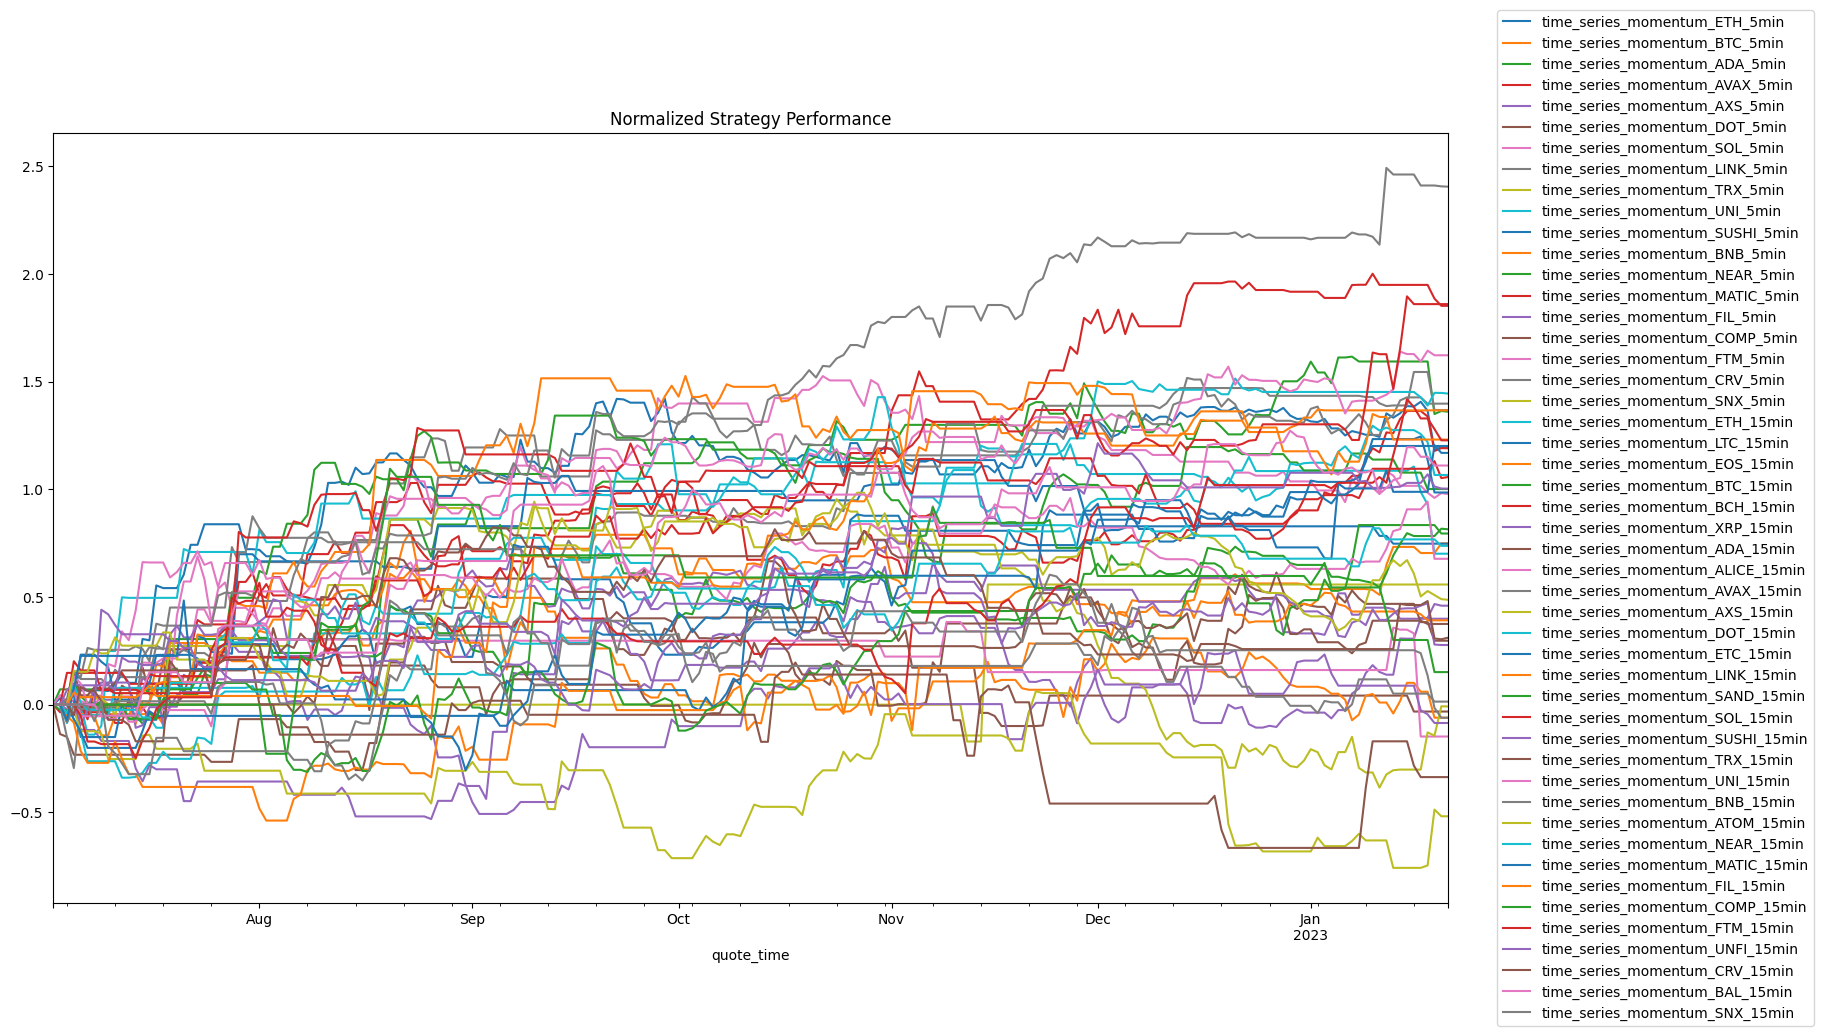

In [ ]:
# resample to daily
grouped_daily_net_pnl = resample_by_col(grouped_net_pnl_trimed[pd.Timestamp('2020-01-01',tz='UTC'):], label='right', closed='right')
# pnl where all strategies are available
valid_grouped_daily_net_pnl = grouped_daily_net_pnl.dropna()
# augment_daily_net_pnl = grouped_daily_net_pnl.join(daily_factor_zscore, rsuffix='_risk')
# cleaned_augment_daily_net_pnl = filter_extreme_events(augment_daily_net_pnl)
# calc vol
grouped_annual_vol = calculate_vol(grouped_net_pnl_trimed[pd.Timestamp('2020-01-01',tz='UTC'):], is_exclude_extreme_events=True, resample='1d')
grouped_valid_annual_vol = calculate_vol(valid_grouped_daily_net_pnl, is_exclude_extreme_events=True, resample='1d')
# resample
grouped_standardized_net_pnl = grouped_net_pnl_trimed[pd.Timestamp('2020-01-01',tz='UTC'):] / grouped_annual_vol
grouped_standardized_daily_net_pnl = resample_by_col(grouped_standardized_net_pnl, label='right', closed='right')
cleaned_grouped_standardized_daily_net_pnl = filter_extreme_events(grouped_standardized_daily_net_pnl)

ax = cleaned_grouped_standardized_daily_net_pnl.cumsum().plot(figsize=(18,10))
ax.legend(loc = 'center left', bbox_to_anchor=(1.03, 0.5))
ax.set_title("Normalized Strategy Performance")


plt.show()
# grouped_net_pnl_by_leg.to_csv(file_path)

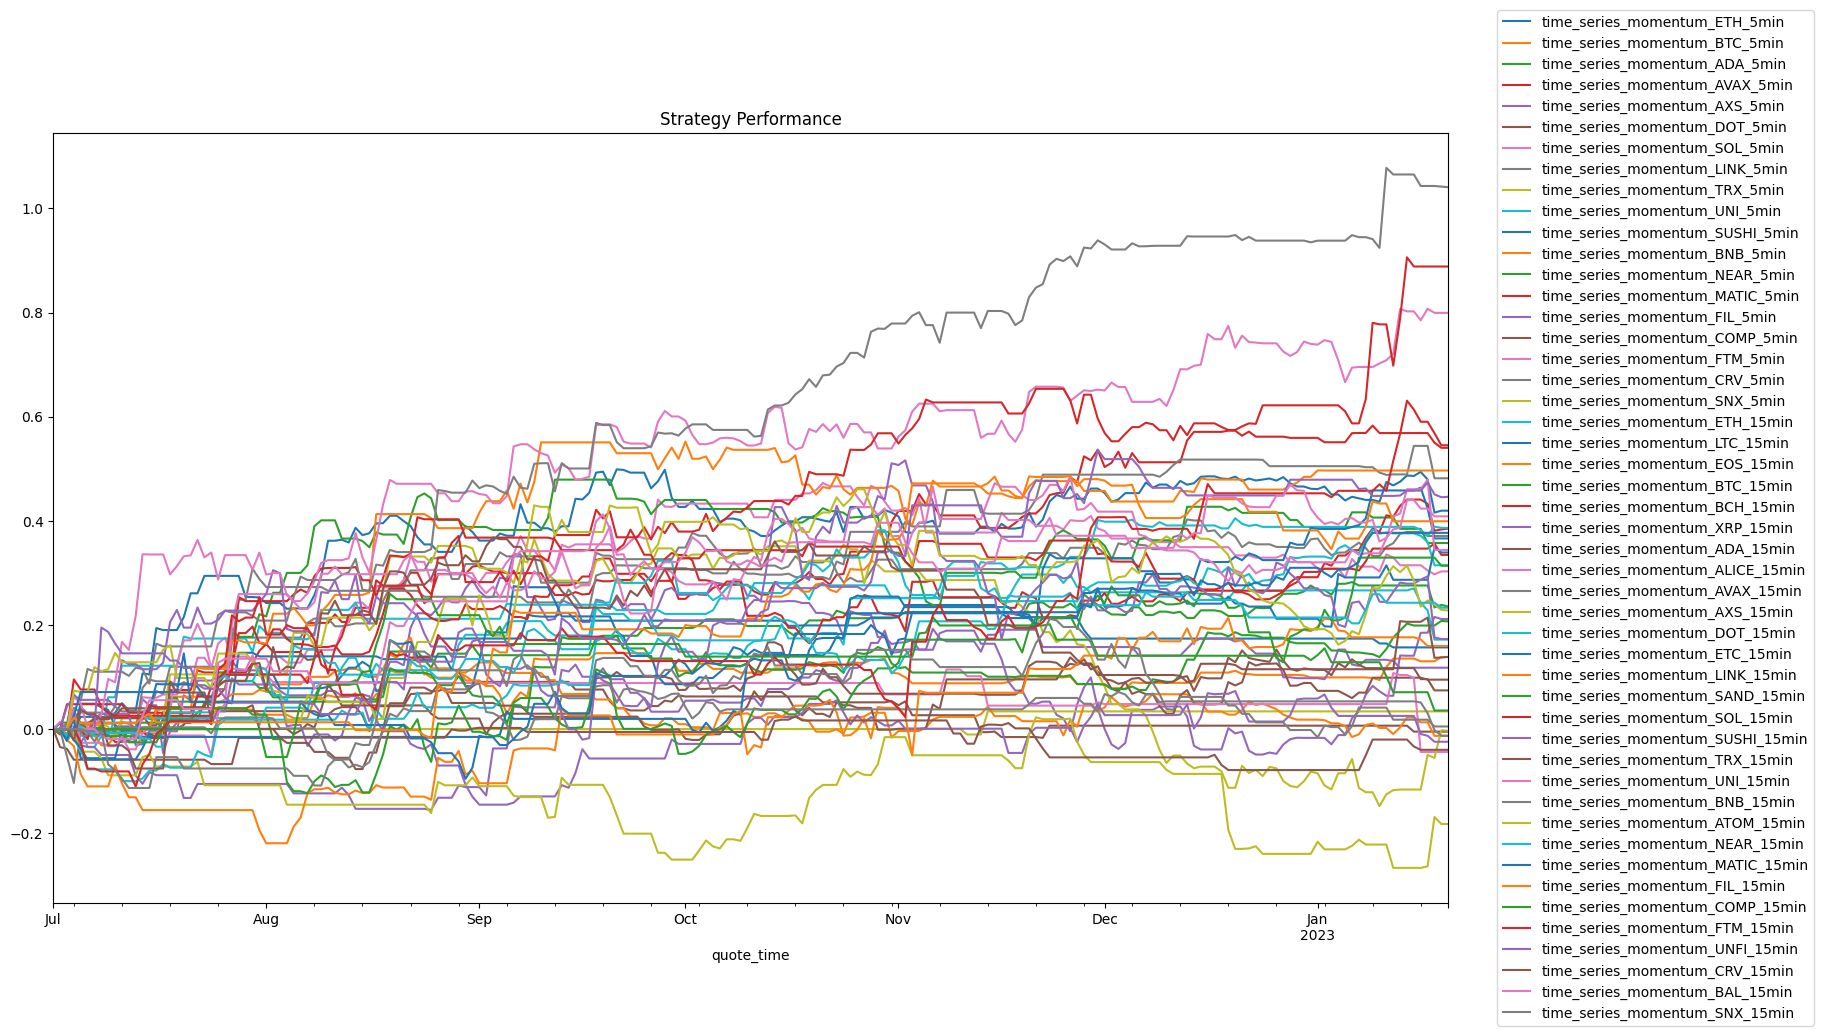

In [ ]:
ax = grouped_net_pnl_trimed.resample('1d').sum().dropna().cumsum().plot(figsize=(18,10))
ax.legend(loc = 'center left', bbox_to_anchor=(1.03, 0.5))
ax.set_title("Strategy Performance")
plt.show()

#### Portfolio weights - with liquidity constraints

##### Perp liquidity

In [ ]:
currency_list = ['BTC', 'ETH', 'BCH', 'LTC', 'EOS', 'XRP', 'ADA', 'ALICE', 'AVAX', 'AXS', 
                 'DOT', 'ETC', 'LINK', 'SAND', 'SOL', 'SUSHI', 'TRX', 'UNI', 'BNB', 'ATOM','NEAR','MATIC',
                 'FIL','COMP','FTM','UNFI','CRV','BAL','SNX']
start_date = '2020-01-01'
end_date = '2022-07-31'

grouped_trading_volume = pd.DataFrame()
for currency in currency_list:
    filename_temp = op.join(repo_dir, 'df_swap_kline_binance') + '_' + start_date.replace('-','_') + '_to_' + end_date.replace('-','_') + '_' + currency
    if op.exists(filename_temp + '.pkl'): 
        df_temp = load_obj(filename_temp) 
        trading_volume_temp = df_temp[['volume']].rename(columns = {'volume':'volume_' + currency})
        price_temp = df_temp[['close']].rename(columns = {'close':'close_' + currency})
        trading_volume_temp[f'volume_{currency}'] = np.multiply(trading_volume_temp.values,price_temp.values)
        grouped_trading_volume = pd.concat([grouped_trading_volume,trading_volume_temp], axis=1)


In [ ]:
## target liquidity 
participate_rate = 0.1
target_liquidity_5min_strategy = np.round(grouped_trading_volume.dropna().resample('15T', label='right').sum().mean().sum()*participate_rate, 1)
target_liquidity_15min_strategy = np.round(grouped_trading_volume.dropna().resample('30T', label='right').sum().mean().sum()*participate_rate, 1)

print(f'target liquidity of 5min and 15min time series momentum strategies are {target_liquidity_5min_strategy} \
and {target_liquidity_15min_strategy} respectively')

target liquidity of 5min and 15min time series momentum strategies are 38146425.0 and 76291266.7 respectively


In [ ]:
grouped_trading_volume_15min = grouped_trading_volume.dropna().resample('15T', label='right').sum()
grouped_trading_volume_15min.mean(axis=0)

volume_BTC      1.731411e+08
volume_ETH      7.685410e+07
volume_BCH      2.893611e+06
volume_LTC      4.975706e+06
volume_EOS      4.445728e+06
volume_XRP      1.365577e+07
volume_ADA      9.971001e+06
volume_ALICE    2.106989e+06
volume_AVAX     5.966469e+06
volume_AXS      5.648891e+06
volume_DOT      6.495949e+06
volume_ETC      5.955670e+06
volume_LINK     4.661714e+06
volume_SAND     5.707545e+06
volume_SOL      1.303532e+07
volume_SUSHI    1.932844e+06
volume_TRX      2.951488e+06
volume_UNI      1.824177e+06
volume_BNB      1.128940e+07
volume_ATOM     3.436272e+06
volume_NEAR     4.003319e+06
volume_MATIC    6.553239e+06
volume_FIL      3.514305e+06
volume_COMP     6.949008e+05
volume_FTM      5.998342e+06
volume_UNFI     8.818013e+05
volume_CRV      1.820440e+06
volume_BAL      3.101619e+05
volume_SNX      7.379640e+05
dtype: float64

In [ ]:
trading_volume_mean = grouped_trading_volume.dropna().resample('15T', label='right').sum().mean(axis=0)
target_liquidity_percentage = trading_volume_mean/trading_volume_mean.sum()
target_liquidity_percentage

volume_BTC      0.453886
volume_ETH      0.201471
volume_BCH      0.007586
volume_LTC      0.013044
volume_EOS      0.011654
volume_XRP      0.035798
volume_ADA      0.026139
volume_ALICE    0.005523
volume_AVAX     0.015641
volume_AXS      0.014808
volume_DOT      0.017029
volume_ETC      0.015613
volume_LINK     0.012221
volume_SAND     0.014962
volume_SOL      0.034172
volume_SUSHI    0.005067
volume_TRX      0.007737
volume_UNI      0.004782
volume_BNB      0.029595
volume_ATOM     0.009008
volume_NEAR     0.010495
volume_MATIC    0.017179
volume_FIL      0.009213
volume_COMP     0.001822
volume_FTM      0.015725
volume_UNFI     0.002312
volume_CRV      0.004772
volume_BAL      0.000813
volume_SNX      0.001935
dtype: float64

In [ ]:
strategy_cols = ['time_series_momentum_ETH_5min', 'time_series_momentum_BTC_5min', 'time_series_momentum_LINK_5min',
                 'time_series_momentum_AVAX_5min', 'time_series_momentum_AXS_5min',  
                 'time_series_momentum_DOT_5min', 'time_series_momentum_SOL_5min', 'time_series_momentum_ADA_5min',
                 'time_series_momentum_TRX_5min', 'time_series_momentum_UNI_5min', 'time_series_momentum_SUSHI_5min',
                 'time_series_momentum_BNB_5min', 'time_series_momentum_NEAR_5min', 'time_series_momentum_MATIC_5min',  
                 'time_series_momentum_FIL_5min', 'time_series_momentum_COMP_5min', 'time_series_momentum_FTM_5min',
                 'time_series_momentum_CRV_5min', 'time_series_momentum_SNX_5min',
                 
                 'time_series_momentum_ETH_15min', 'time_series_momentum_BTC_15min', 'time_series_momentum_XRP_15min',
                 'time_series_momentum_BCH_15min', 'time_series_momentum_EOS_15min','time_series_momentum_LTC_15min',
                 'time_series_momentum_ADA_15min', 'time_series_momentum_ALICE_15min','time_series_momentum_AVAX_15min',
                 'time_series_momentum_AXS_15min', 'time_series_momentum_DOT_15min','time_series_momentum_ETC_15min',
                 'time_series_momentum_LINK_15min','time_series_momentum_SAND_15min','time_series_momentum_SOL_15min',
                 'time_series_momentum_SUSHI_15min','time_series_momentum_TRX_15min','time_series_momentum_UNI_15min',
                 'time_series_momentum_BNB_15min','time_series_momentum_ATOM_15min','time_series_momentum_NEAR_15min',
                 'time_series_momentum_MATIC_15min','time_series_momentum_FIL_15min','time_series_momentum_COMP_15min',
                 'time_series_momentum_FTM_15min','time_series_momentum_UNFI_15min',
                 'time_series_momentum_CRV_15min','time_series_momentum_BAL_15min','time_series_momentum_SNX_15min']
risk_cols = []
# put target return
target_return = 2

# bounds
lower_limit_multiplier = 0.4
upper_limit_multiplier = 6

bounds = []
for strategy in strategy_cols:
    if '_15min' in strategy:
        currency = strategy.split('momentum_')[1].split('_')[0]
        if currency in ['LTC','EOS','XRP','BCH','ALICE','SAND','ATOM','UNFI','BAL','ETC']:
            upper_bound = target_liquidity_percentage[f'volume_{currency}'] * upper_limit_multiplier 
            lower_bound = target_liquidity_percentage[f'volume_{currency}'] * lower_limit_multiplier 
            bounds = bounds + [(lower_bound, upper_bound),]
        else:
            upper_bound = target_liquidity_percentage[f'volume_{currency}'] * upper_limit_multiplier * 3/4
            lower_bound = target_liquidity_percentage[f'volume_{currency}'] * lower_limit_multiplier * 3/4
            bounds = bounds + [(lower_bound, upper_bound),]

    elif '_5min' in strategy:
        currency = strategy.split('momentum_')[1].split('_')[0]
        upper_bound = target_liquidity_percentage[f'volume_{currency}'] * upper_limit_multiplier * 1/4
        lower_bound = target_liquidity_percentage[f'volume_{currency}'] * lower_limit_multiplier * 1/4
        bounds = bounds + [(lower_bound, upper_bound),]

# fit MVO
min_wt = minimize(get_portfolio_risk, 
                  # starting eq-wt portfolio with no risk
                  [1] * len(strategy_cols) + [0] * len(risk_cols),
                  args=(valid_grouped_daily_net_pnl[strategy_cols+risk_cols],), 
                        method='SLSQP',
                        options={'disp': False},
                        constraints=({'type': 'eq', 
                                      'args': (valid_grouped_daily_net_pnl[strategy_cols+risk_cols],),
                                      # get to target return
                                      'fun': lambda x, r:
                                             target_return - get_portfolio_return(weights=x, returns=r)}),
                  # do not bet against strategies
                  bounds = bounds + [(None, None),] * len(risk_cols))

wt_sr = pd.Series(min_wt.x, index=strategy_cols+risk_cols)

In [ ]:
wt_sr.sum()

2.1334367672965233

In [ ]:
# percentage risk - new
wt_sr_norm = wt_sr/wt_sr.sum()
round(wt_sr_norm,4)

time_series_momentum_ETH_5min       0.0807
time_series_momentum_BTC_5min       0.0411
time_series_momentum_LINK_5min      0.0086
time_series_momentum_AVAX_5min      0.0110
time_series_momentum_AXS_5min       0.0104
time_series_momentum_DOT_5min       0.0120
time_series_momentum_SOL_5min       0.0240
time_series_momentum_ADA_5min       0.0184
time_series_momentum_TRX_5min       0.0054
time_series_momentum_UNI_5min       0.0034
time_series_momentum_SUSHI_5min     0.0036
time_series_momentum_BNB_5min       0.0208
time_series_momentum_NEAR_5min      0.0074
time_series_momentum_MATIC_5min     0.0008
time_series_momentum_FIL_5min       0.0030
time_series_momentum_COMP_5min      0.0013
time_series_momentum_FTM_5min       0.0111
time_series_momentum_CRV_5min       0.0034
time_series_momentum_SNX_5min       0.0014
time_series_momentum_ETH_15min      0.0507
time_series_momentum_BTC_15min      0.0846
time_series_momentum_XRP_15min      0.0380
time_series_momentum_BCH_15min      0.0014
time_series

In [ ]:
start_date = '2020-01-01'
end_date = '2022-07-31'

## save strategy weights
path = '/content/drive/My Drive/Quant Research/CryptoCurrency/Strategy/Stats Arb/Amber/Data/prod_data_kline_20220814/portfolio_construction_pnl'
filename = op.join(path, 'time_series_momentum_strategy_weight_v5') + '_' + start_date.replace('-','_') + '_to_' + end_date.replace('-','_')
# if not op.exists(filename + '.pkl'):
save_obj(wt_sr_norm, filename)

In [ ]:
start_date = '2020-01-01'
end_date = '2022-07-31'

## read strategy weights
path = '/content/drive/My Drive/Quant Research/CryptoCurrency/Strategy/Stats Arb/Amber/Data/prod_data_kline_20220814/portfolio_construction_pnl'
filename = op.join(path, 'time_series_momentum_strategy_weight_v5') + '_' + start_date.replace('-','_') + '_to_' + end_date.replace('-','_')
if op.exists(filename + '.pkl'):
    wt_sr_norm = load_obj(filename)

In [ ]:
# weights for 5min and 15min
print('time_series_momentum_5min has a weight of: ', wt_sr_norm.filter(regex='_5min').sum())
print('time_series_momentum_15min has a weight of: ', wt_sr_norm.filter(regex='_15min').sum())

time_series_momentum_5min has a weight of:  0.26751093042782503
time_series_momentum_15min has a weight of:  0.7324890695721751


In [ ]:
# dollar risk - new
dollar_risk_5m = np.round(wt_sr_norm * 500000)*10
dollar_risk_50m = np.round(wt_sr_norm * 5000000)*10
dollar_risk = pd.concat([dollar_risk_5m, dollar_risk_50m], axis=1)
dollar_risk = dollar_risk.rename(columns={0: '5M', 1:'50M'})
dollar_risk

,5M,50M
time_series_momentum_ETH_5min,403360.0,4033610.0
time_series_momentum_BTC_5min,205460.0,2054640.0
time_series_momentum_LINK_5min,42960.0,429610.0
time_series_momentum_AVAX_5min,54990.0,549850.0
time_series_momentum_AXS_5min,52060.0,520580.0
time_series_momentum_DOT_5min,59860.0,598650.0
time_series_momentum_SOL_5min,120130.0,1201290.0
time_series_momentum_ADA_5min,91890.0,918900.0
time_series_momentum_TRX_5min,27200.0,272000.0
time_series_momentum_UNI_5min,16810.0,168110.0


In [ ]:
# max pos 
currency_list = ['BTC', 'ETH', 'BCH', 'LTC', 'EOS', 'XRP', 'ADA', 'ALICE', 'AVAX', 'AXS', 
                 'DOT', 'ETC', 'LINK', 'SAND', 'SOL', 'SUSHI', 'TRX', 'UNI', 'BNB', 'ATOM','NEAR','MATIC',
                 'FIL','COMP','FTM','UNFI','CRV','BAL','SNX']

max_pos = pd.DataFrame(data=[0] * len(currency_list), columns=['10M'], index=currency_list)
for currency in currency_list:
    max_pos_currency = 0.0
    if f'time_series_momentum_{currency}_5min' in dollar_risk.index:
        max_pos_currency = dollar_risk.loc[f'time_series_momentum_{currency}_5min','10M']
    if f'time_series_momentum_{currency}_15min' in dollar_risk.index:
        max_pos_currency = max_pos_currency + dollar_risk.loc[f'time_series_momentum_{currency}_15min','10M']
    max_pos.loc[currency] = max_pos_currency

max_pos['15M'] = max_pos['10M'] * 1.5
max_pos

In [ ]:
strategy_cols = ['time_series_momentum_ETH_5min', 'time_series_momentum_BTC_5min', 'time_series_momentum_LINK_5min',
                 'time_series_momentum_AVAX_5min', 'time_series_momentum_AXS_5min',  
                 'time_series_momentum_DOT_5min', 'time_series_momentum_SOL_5min', 'time_series_momentum_ADA_5min',
                 'time_series_momentum_TRX_5min', 'time_series_momentum_UNI_5min', 'time_series_momentum_SUSHI_5min',
                 'time_series_momentum_BNB_5min', 'time_series_momentum_NEAR_5min', 'time_series_momentum_MATIC_5min',  
                 'time_series_momentum_FIL_5min', 'time_series_momentum_COMP_5min', 'time_series_momentum_FTM_5min',
                 'time_series_momentum_CRV_5min', 'time_series_momentum_SNX_5min',
                 
                 'time_series_momentum_ETH_15min', 'time_series_momentum_BTC_15min', 'time_series_momentum_XRP_15min',
                 'time_series_momentum_BCH_15min', 'time_series_momentum_EOS_15min','time_series_momentum_LTC_15min',
                 'time_series_momentum_ADA_15min', 'time_series_momentum_ALICE_15min','time_series_momentum_AVAX_15min',
                 'time_series_momentum_AXS_15min', 'time_series_momentum_DOT_15min','time_series_momentum_ETC_15min',
                 'time_series_momentum_LINK_15min','time_series_momentum_SAND_15min','time_series_momentum_SOL_15min',
                 'time_series_momentum_SUSHI_15min','time_series_momentum_TRX_15min','time_series_momentum_UNI_15min',
                 'time_series_momentum_BNB_15min','time_series_momentum_ATOM_15min','time_series_momentum_NEAR_15min',
                 'time_series_momentum_MATIC_15min','time_series_momentum_FIL_15min','time_series_momentum_COMP_15min',
                 'time_series_momentum_FTM_15min','time_series_momentum_UNFI_15min',
                 'time_series_momentum_CRV_15min','time_series_momentum_BAL_15min','time_series_momentum_SNX_15min']

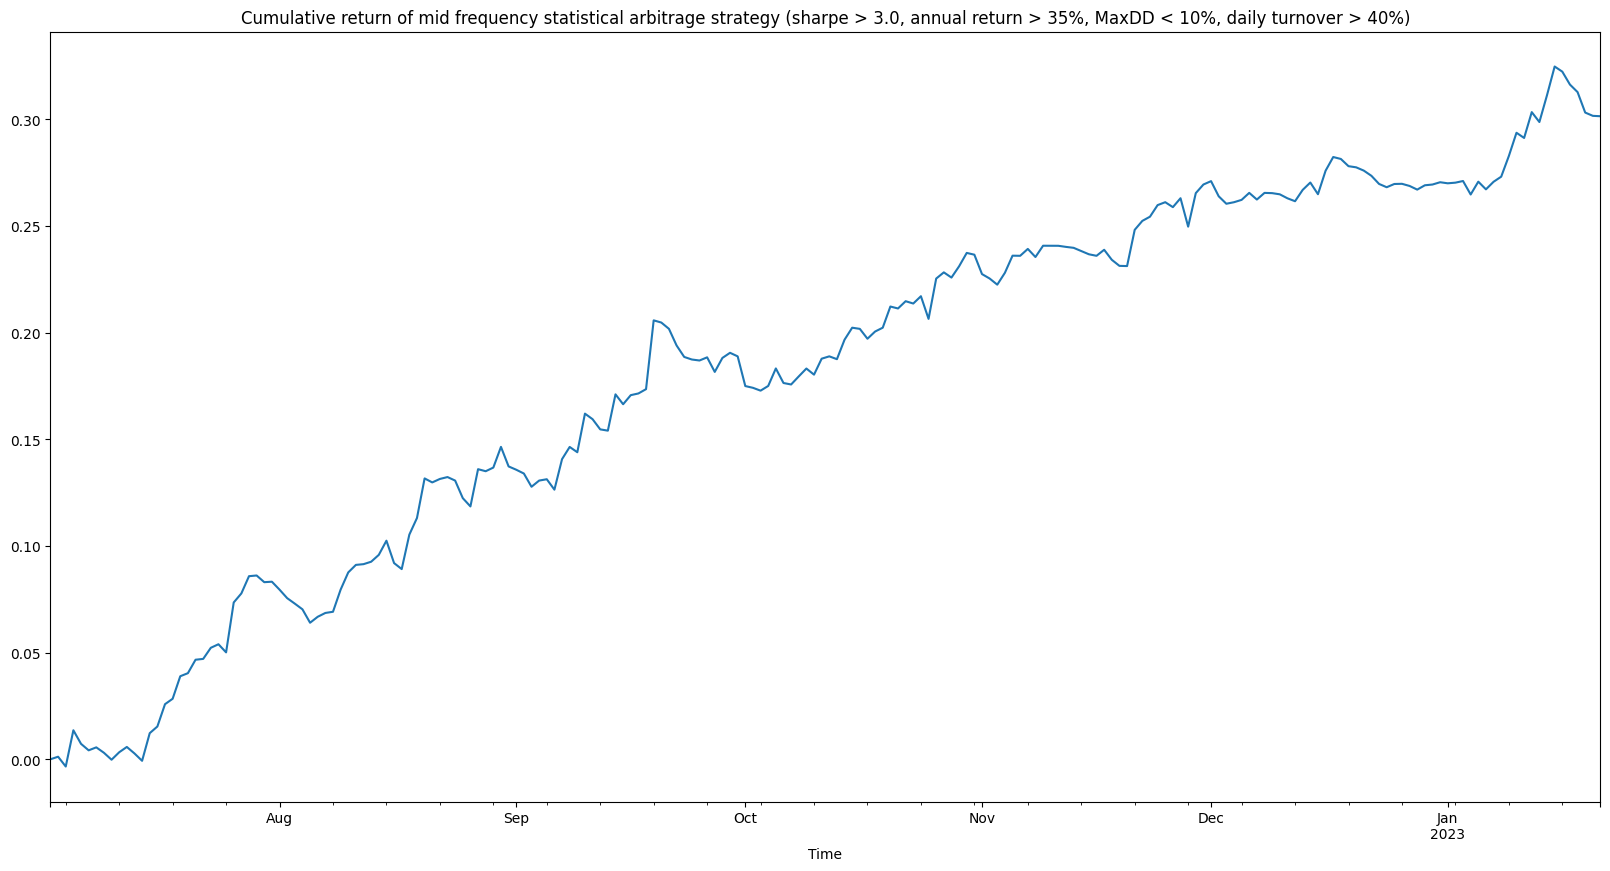

In [ ]:
time_series_momentum_liquidity_cns_total_return = pd.DataFrame(valid_grouped_daily_net_pnl[strategy_cols].values * wt_sr_norm.values, 
                                                                columns=strategy_cols, 
                                                                index = valid_grouped_daily_net_pnl.index )

time_series_momentum_liquidity_cns_total_return['total_return'] = time_series_momentum_liquidity_cns_total_return.sum(axis=1)
time_series_momentum_liquidity_cns_total_return['total_return_5min'] = \
time_series_momentum_liquidity_cns_total_return[time_series_momentum_liquidity_cns_total_return.filter(regex='_5min').columns].sum(axis=1)
time_series_momentum_liquidity_cns_total_return['total_return_15min'] = \
time_series_momentum_liquidity_cns_total_return[time_series_momentum_liquidity_cns_total_return.filter(regex='_15min').columns].sum(axis=1)
time_series_momentum_liquidity_cns_total_return['total_return'].resample('1d').sum().dropna().cumsum().plot(figsize=(20,10))

# ax = plt.gca()
# ax.xaxis.set_major_locator(mdates.DayLocator())

plt.title('Cumulative return of mid frequency statistical arbitrage strategy (sharpe > 3.0, annual return > 35%, MaxDD < 10%, daily turnover > 40%)')
plt.xlabel('Time')
plt.show()

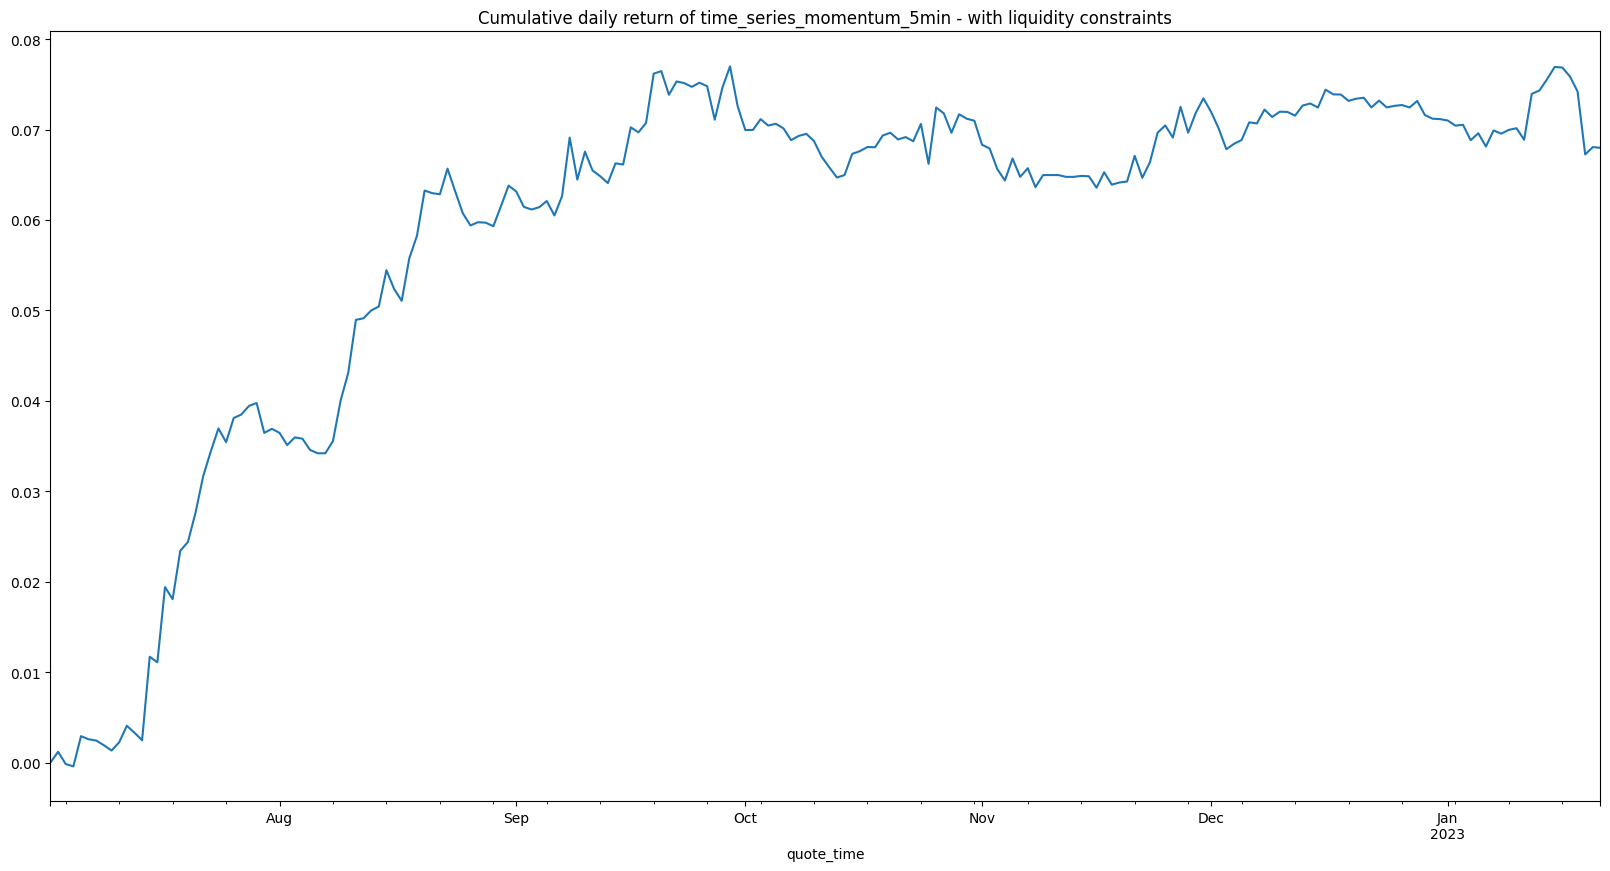

In [ ]:
time_series_momentum_liquidity_cns_total_return['total_return_5min'].resample('1d').sum().dropna().cumsum().plot(figsize=(20,10))

plt.title('Cumulative daily return of time_series_momentum_5min - with liquidity constraints')
plt.show()

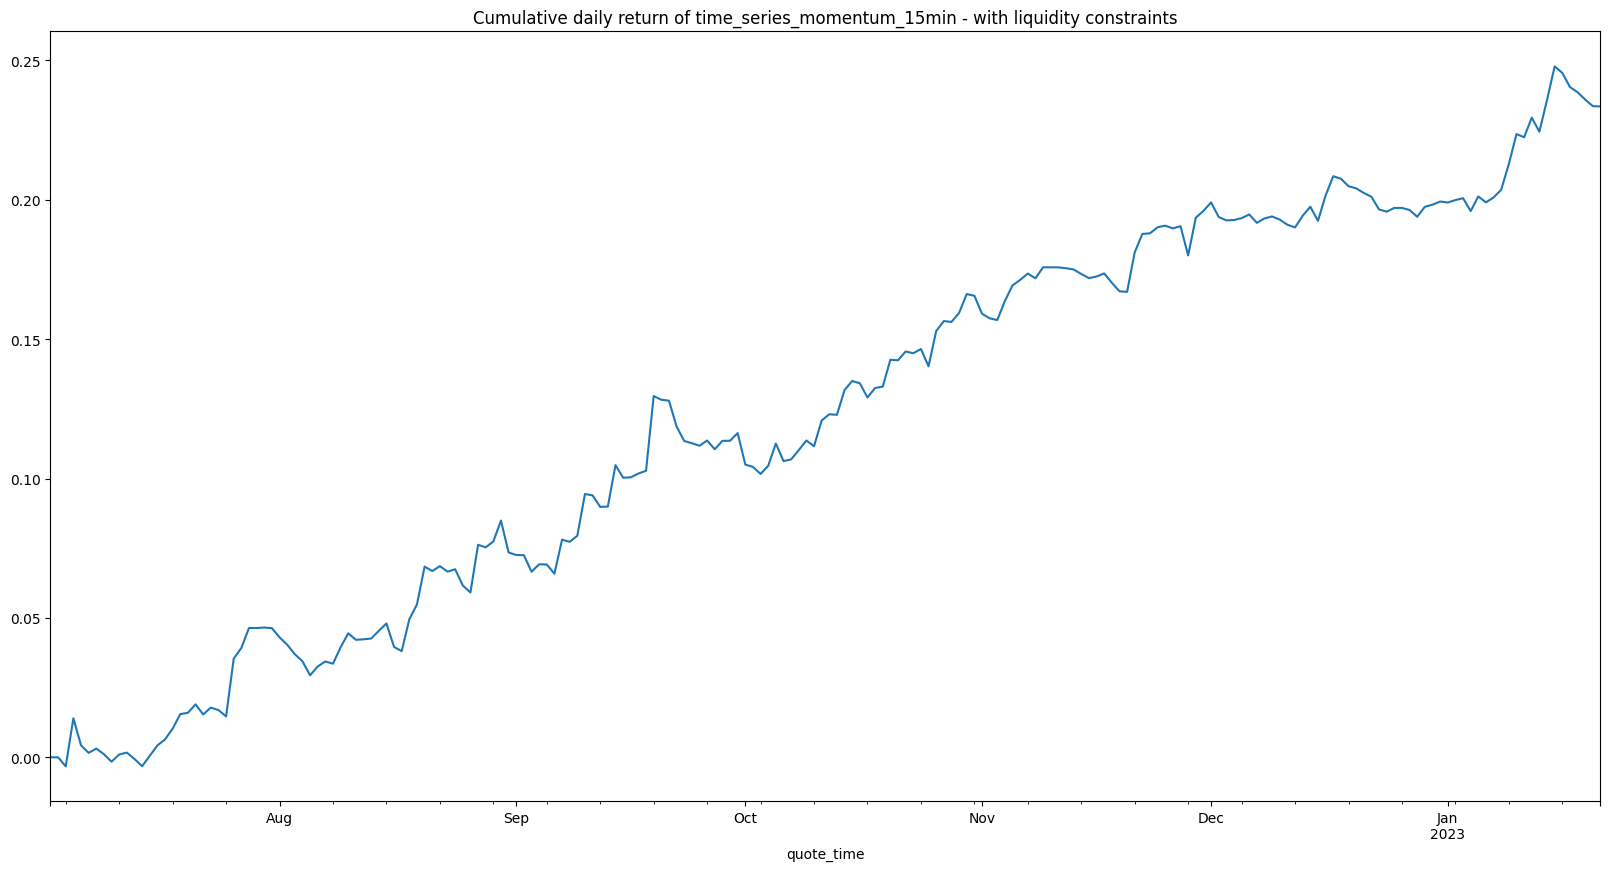

In [ ]:
time_series_momentum_liquidity_cns_total_return['total_return_15min'].resample('1d').sum().dropna().cumsum().plot(figsize=(20,10))

plt.title('Cumulative daily return of time_series_momentum_15min - with liquidity constraints')
plt.show()

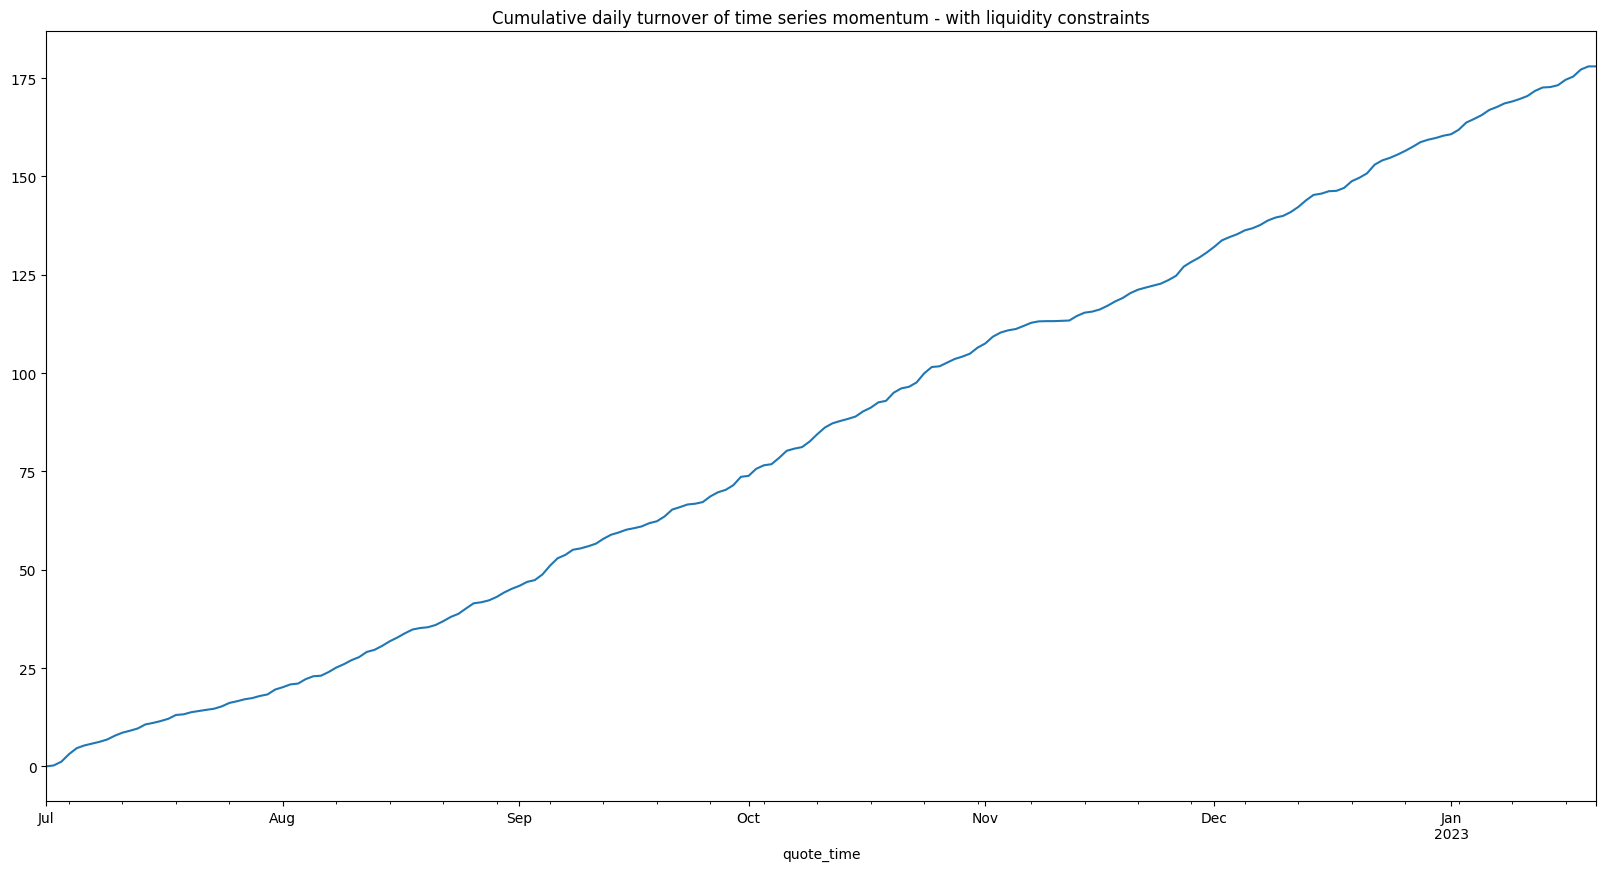

In [ ]:
time_series_momentum_liquidity_cns_pos = pd.DataFrame(grouped_pos[strategy_cols].values * wt_sr_norm.values, 
                                                                columns=strategy_cols, 
                                                                index = grouped_pos.index )

time_series_momentum_liquidity_cns_pos = time_series_momentum_liquidity_cns_pos.fillna(method='ffill').fillna(0.0)
time_series_momentum_liquidity_cns_pos['strategy_turnover'] = time_series_momentum_liquidity_cns_pos.diff().abs().fillna(0.0).sum(axis=1)
time_series_momentum_liquidity_cns_pos['strategy_turnover'].resample('1d').sum().dropna().cumsum().plot(figsize=(20,10))

plt.title('Cumulative daily turnover of time series momentum - with liquidity constraints')
plt.show()

In [ ]:
## total return
total_return = time_series_momentum_liquidity_cns_total_return['total_return'].sum()

## annual return
annual_return = total_return * 365 / len(time_series_momentum_liquidity_cns_total_return)

## turnover
total_turnover = time_series_momentum_liquidity_cns_pos['strategy_turnover'].sum()
avg_daily_turnover = total_turnover / (time_series_momentum_liquidity_cns_pos.index[-1] - time_series_momentum_liquidity_cns_pos.index[0]).days

## maximum drawdown
max_drawdown = maximum_drawdown(time_series_momentum_liquidity_cns_total_return['total_return'].dropna().values)


## sharpe ratio
shp_ratio = sharpe_ratio(time_series_momentum_liquidity_cns_total_return['total_return'].dropna().resample('D').sum().values, r_0=0, scale = 365)

## performance metrics
df_performance_metrics = pd.DataFrame({'sharpe_ratio': shp_ratio,
                                       'return_per_trade': 2*total_return/total_turnover,
                                       'total_return': total_return,
                                       'annual_return': annual_return,
                                       'daily_turnover':avg_daily_turnover,
                                       'max_drawdown': max_drawdown,},
                                       index = [0])

In [ ]:
df_performance_metrics

,sharpe_ratio,return_per_trade,total_return,annual_return,daily_turnover,max_drawdown
0,4.30829,0.003388,0.301503,0.539454,0.876794,0.032965


In [ ]:
currency_list = ['BTC', 'ETH', 'BCH', 'LTC', 'EOS', 'XRP', 'ADA', 'ALICE', 'AVAX', 'AXS', 
                 'DOT', 'ETC', 'LINK', 'SAND', 'SOL', 'SUSHI', 'TRX', 'UNI', 'BNB', 'ATOM','NEAR','MATIC',
                 'FIL','COMP','FTM','UNFI','CRV','BAL','SNX']

In [ ]:
time_series_momentum_pos = pd.DataFrame()
pos_copy = time_series_momentum_liquidity_cns_pos.mask(time_series_momentum_liquidity_cns_pos == time_series_momentum_liquidity_cns_pos.shift(), None).fillna(0.0)
for currency in currency_list:
    time_series_momentum_pos[currency] = pos_copy[pos_copy.filter(regex=currency).columns].sum(axis=1)

time_series_momentum_pos

,BTC,ETH,BCH,LTC,EOS,XRP,ADA,ALICE,AVAX,AXS,...,ATOM,NEAR,MATIC,FIL,COMP,FTM,UNFI,CRV,BAL,SNX
quote_time,,,,,,,,,,,,,,,,,,,,,
2022-07-01 00:05:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-07-01 00:10:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-07-01 00:15:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-07-01 00:20:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-07-01 00:25:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-01-19 23:45:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2023-01-19 23:50:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2023-01-19 23:55:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
time_series_momentum_pos.describe()

,BTC,ETH,BCH,LTC,EOS,XRP,ADA,ALICE,AVAX,AXS,...,ATOM,NEAR,MATIC,FIL,COMP,FTM,UNFI,CRV,BAL,SNX
count,5.846500e+04,58465.000000,5.846500e+04,5.846500e+04,5.846500e+04,58465.000000,58465.000000,58465.000000,58465.000000,58465.000000,...,5.846500e+04,58465.000000,58465.000000,58465.000000,5.846500e+04,58465.000000,58465.000000,5.846500e+04,5.846500e+04,5.846500e+04
mean,-5.902921e-07,-0.000006,2.006894e-07,9.411691e-08,2.055588e-07,-0.000002,-0.000021,-0.000008,0.000005,-0.000004,...,5.055406e-08,0.000001,0.000003,-0.000004,2.464547e-07,0.000002,-0.000001,-9.899816e-07,-2.444501e-07,4.187640e-07
std,3.832202e-03,0.005356,3.722930e-05,6.855199e-05,6.145801e-05,0.001200,0.002646,0.000631,0.001437,0.001164,...,9.165801e-05,0.000813,0.001142,0.000637,9.679823e-05,0.001354,0.000228,4.287929e-04,9.098668e-05,1.627580e-04
min,-1.257395e-01,-0.131405,-1.422219e-03,-2.445576e-03,-2.185090e-03,-0.037982,-0.055134,-0.011686,-0.032991,-0.031235,...,-1.688939e-03,-0.022136,-0.036236,-0.022392,-3.842393e-03,-0.033167,-0.006501,-1.006596e-02,-2.286684e-03,-4.080506e-03
25%,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00
50%,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00
75%,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00
max,1.257395e-01,0.080672,1.422219e-03,2.445576e-03,2.185090e-03,0.037982,0.073512,0.011686,0.032991,0.031235,...,1.688939e-03,0.022136,0.036236,0.022392,3.842393e-03,0.033167,0.006501,1.006596e-02,2.286684e-03,4.080506e-03


In [ ]:
time_series_momentum_pos.describe()

,BTC,ETH,BCH,LTC,EOS,XRP,ADA,ALICE,AVAX,AXS,...,ATOM,NEAR,MATIC,FIL,COMP,FTM,UNFI,CRV,BAL,SNX
count,5.846500e+04,58465.000000,5.846500e+04,5.846500e+04,5.846500e+04,58465.000000,58465.000000,58465.000000,58465.000000,58465.000000,...,5.846500e+04,58465.000000,58465.000000,58465.000000,5.846500e+04,58465.000000,58465.000000,5.846500e+04,5.846500e+04,5.846500e+04
mean,-5.902921e-07,-0.000006,2.006894e-07,9.411691e-08,2.055588e-07,-0.000002,-0.000021,-0.000008,0.000005,-0.000004,...,5.055406e-08,0.000001,0.000003,-0.000004,2.464547e-07,0.000002,-0.000001,-9.899816e-07,-2.444501e-07,4.187640e-07
std,3.832202e-03,0.005356,3.722930e-05,6.855199e-05,6.145801e-05,0.001200,0.002646,0.000631,0.001437,0.001164,...,9.165801e-05,0.000813,0.001142,0.000637,9.679823e-05,0.001354,0.000228,4.287929e-04,9.098668e-05,1.627580e-04
min,-1.257395e-01,-0.131405,-1.422219e-03,-2.445576e-03,-2.185090e-03,-0.037982,-0.055134,-0.011686,-0.032991,-0.031235,...,-1.688939e-03,-0.022136,-0.036236,-0.022392,-3.842393e-03,-0.033167,-0.006501,-1.006596e-02,-2.286684e-03,-4.080506e-03
25%,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00
50%,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00
75%,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00
max,1.257395e-01,0.080672,1.422219e-03,2.445576e-03,2.185090e-03,0.037982,0.073512,0.011686,0.032991,0.031235,...,1.688939e-03,0.022136,0.036236,0.022392,3.842393e-03,0.033167,0.006501,1.006596e-02,2.286684e-03,4.080506e-03


<Axes: xlabel='quote_time'>

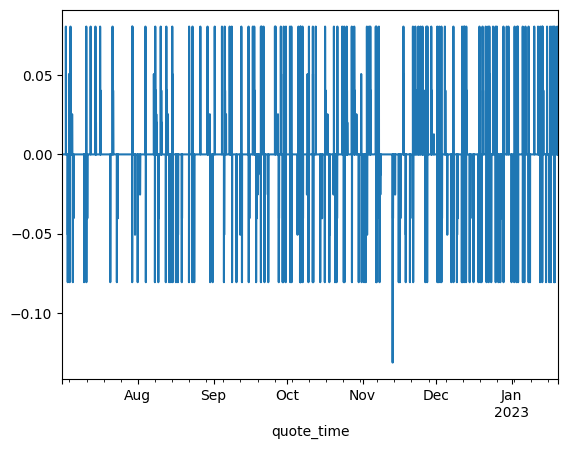

In [ ]:
time_series_momentum_pos.ETH.plot()

In [ ]:
time_series_momentum_liquidity_cns_pos['time_series_momentum_ETH_5min'] + time_series_momentum_liquidity_cns_pos['time_series_momentum_ETH_15min']

quote_time
2022-07-01 00:05:00    0.000000
2022-07-01 00:10:00    0.000000
2022-07-01 00:15:00    0.000000
2022-07-01 00:20:00    0.000000
2022-07-01 00:25:00    0.000000
                         ...   
2023-01-19 23:45:00    0.131405
2023-01-19 23:50:00    0.131405
2023-01-19 23:55:00    0.131405
2023-01-20 00:00:00    0.131405
2023-01-20 00:05:00    0.131405
Freq: 5T, Length: 58465, dtype: float64

In [ ]:
pos_copy[pos_copy.filter(regex="ETH").columns].describe()

,time_series_momentum_ETH_5min,time_series_momentum_ETH_15min
count,58465.000000,5.846500e+04
mean,0.000001,8.677387e-07
std,0.007346,2.373808e-03
min,-0.161344,-1.014647e-01
25%,0.000000,0.000000e+00
50%,0.000000,0.000000e+00
75%,0.000000,0.000000e+00
max,0.161344,1.014647e-01


In [ ]:
time_series_momentum_pos_dollar = time_series_momentum_pos.replace(0.0, None).fillna(method='ffill').fillna(0.0) * 20000000
path = '/content/drive/My Drive/Quant Research/CryptoCurrency/Strategy/Stats Arb/Amber/Data/prod_data_kline_20220814/portfolio_construction_pnl'
time_series_momentum_pos_dollar[pd.Timestamp('2022-07-01'):pd.Timestamp('2022-12-01')].to_csv(path + '/strategy_position_20220701_20230120_20M_risk.csv')

In [ ]:
## total return
total_return = time_series_momentum_liquidity_cns_total_return['total_return'].sum()

## annual return
annual_return = total_return * 365 / len(time_series_momentum_liquidity_cns_total_return)

## turnover
total_turnover = time_series_momentum_liquidity_cns_pos['strategy_turnover'].sum()
avg_daily_turnover = total_turnover / (time_series_momentum_liquidity_cns_pos.index[-1] - time_series_momentum_liquidity_cns_pos.index[0]).days

## maximum drawdown
max_drawdown = maximum_drawdown(time_series_momentum_liquidity_cns_total_return['total_return'].dropna().values)


## sharpe ratio
shp_ratio = sharpe_ratio(time_series_momentum_liquidity_cns_total_return['total_return'].dropna().resample('D').sum().values, r_0=0, scale = 365)

## performance metrics
df_performance_metrics = pd.DataFrame({'sharpe_ratio': shp_ratio,
                                       'return_per_trade': 2*total_return/total_turnover,
                                       'total_return': total_return,
                                       'annual_return': annual_return,
                                       'daily_turnover':avg_daily_turnover,
                                       'max_drawdown': max_drawdown,},
                                       index = [0])

In [ ]:
# out of sample
df_performance_metrics

,sharpe_ratio,return_per_trade,total_return,annual_return,daily_turnover,max_drawdown
0,4.30829,0.003388,0.301503,0.539454,0.876794,0.032965


In [ ]:
# in sample
df_performance_metrics

,sharpe_ratio,return_per_trade,total_return,annual_return,daily_turnover,max_drawdown
0,6.93538,0.004364,1.356764,0.982577,0.660094,0.030883


In [ ]:
start_date = '2022-07-01'
end_date = '2023-01-20'

## save position series
path = '/content/drive/My Drive/Quant Research/CryptoCurrency/Strategy/Stats Arb/Amber/Data/prod_data_kline_20220814/portfolio_construction_pnl'
filename = op.join(path, 'time_series_momentum_total_return') + '_' + start_date.replace('-','_') + '_to_' + end_date.replace('-','_')
if not op.exists(filename + '.pkl'):
    save_obj(time_series_momentum_liquidity_cns_total_return, filename)

In [ ]:
start_date = '2022-07-01'
end_date = '2023-01-20'

## save position series
path = '/content/drive/My Drive/Quant Research/CryptoCurrency/Strategy/Stats Arb/Amber/Data/prod_data_kline_20220814/portfolio_construction_pnl'
filename = op.join(path, 'time_series_momentum_grouped_pos_') + '_' + start_date.replace('-','_') + '_to_' + end_date.replace('-','_')
if not op.exists(filename + '.pkl'):
    save_obj(time_series_momentum_liquidity_cns_pos, filename)

##### The End